In [1]:
import numpy as np
np.random.seed(1001)

import pickle
import os
import shutil

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import StratifiedKFold, train_test_split
import sklearn
import dask.dataframe as dd
from dask import array

import librosa
import IPython.display as ipd  # To play sound in the notebook
import librosa.display

import keras
from keras.layers import Conv1D, Dropout, Dense, MaxPooling1D, Flatten, Conv2D, MaxPooling2D
from keras import Sequential

%matplotlib inline
matplotlib.style.use('ggplot')

import dask
from dask.distributed import Client, wait, progress

Using TensorFlow backend.


In [2]:
client = Client()

In [3]:
client

Client Scheduler: tcp://127.0.0.1:52799 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 16.90 GB


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [5]:
metadata = pd.read_csv("file_metadata.csv", index_col=0)

# Features

In [6]:
y, sr = librosa.load(metadata["filepath"].iloc[0])

In [7]:
y

array([ 1.5591205e-07, -1.5845627e-07,  1.5362870e-07, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)

In [8]:
D = librosa.stft(y, n_fft=512)

spec = librosa.amplitude_to_db(D,ref=np.max)

c:\users\chris\appdata\local\programs\python\python35\lib\site-packages\librosa\core\spectrum.py:960: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


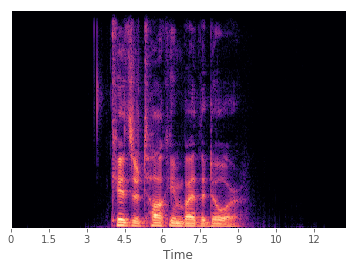

In [9]:
librosa.display.specshow(spec, x_axis='time')

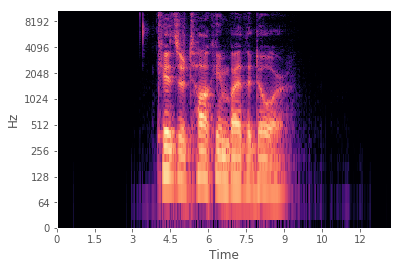

In [10]:
librosa.display.specshow(spec, y_axis='log', x_axis='time')

In [11]:
spec.shape

(257, 570)

In [12]:
len(librosa.feature.spectral_flatness(y))

1

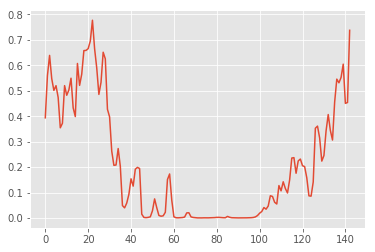

In [13]:
# Spectral flatness
plt.plot(librosa.feature.spectral_flatness(y)[0])

# Spectral contrast

In [14]:
# each row of spectral contrast values corresponds to a given octave-based frequency

n = 2
len(librosa.feature.spectral_contrast(y, sr, n_bands=n))

3

In [15]:
def get_spec_contrast_features(y, sr):
    n_bands = 3
    vals = librosa.feature.spectral_contrast(y,n_bands=n_bands)
    means = [np.mean(x) for x in vals]
    stds = [np.std(x) for x in vals]

    for i in range(n_bands+1):
        plt.plot(vals[i])
    return means, stds

([20.4819336937591, 11.763805230162642, 15.675733982039421, 30.6657186784521],
 [9.93648825074117, 4.362921028288391, 4.953411190605515, 6.3135557571715895])

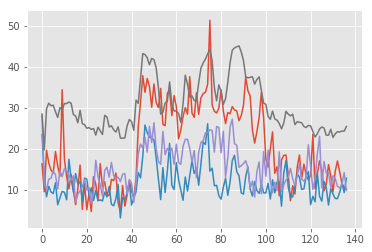

In [16]:

y, sr = librosa.load(metadata["filepath"].iloc[3])
get_spec_contrast_features(y, sr)

# Spectral flatness - WILL ONLY WORK IF WE REMOVE NOISE FIRST
Spectral flatness (or tonality coefficient) is a measure to quantify how much noise-like a sound is, as opposed to being tone-like [1]. A high spectral flatness (closer to 1.0) indicates the spectrum is similar to white noise. It is often converted to decibel.

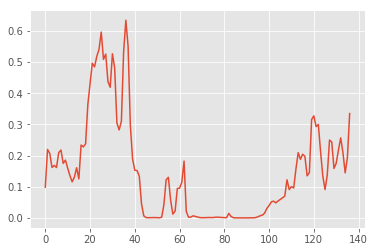

In [17]:
n = 2
plt.plot(librosa.feature.spectral_flatness(y)[0])

In [18]:
def get_spec_flatness_features(y):
    vals = librosa.feature.spectral_flatness(y)
    mean = [np.mean(x) for x in vals]
    std = [np.std(x) for x in vals]
    plt.plot(librosa.feature.spectral_flatness(y)[0])
    return mean, std

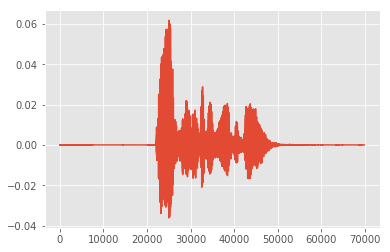

In [19]:
plt.plot(y)

([0.15351795], [0.18956923])

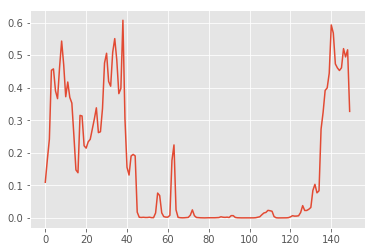

In [20]:
y, sr = librosa.load(metadata["filepath"].iloc[5])
get_spec_flatness_features(y)

# Spectral Rolloff

1


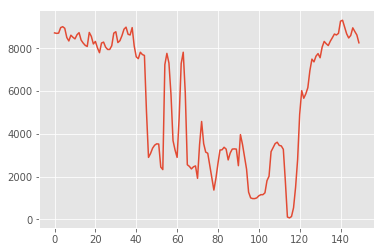

In [21]:
print(len(librosa.feature.spectral_rolloff(y,sr)))
plt.plot(librosa.feature.spectral_rolloff(y,sr)[0])

In [6]:
def get_ts_features(y,sr, hop_length=32):
    n_cont_bands = 2
    res = pd.DataFrame(columns=["contrast_band_{}".format(x) for x in range(n_cont_bands+1)].extend(["sroll", "sflat"]))
    
    scont = librosa.feature.spectral_contrast(y,n_bands=n_cont_bands, hop_length=hop_length)
    
    for i in range(n_cont_bands + 1):
        res["contrast_band_{}".format(i)] = scont[i]
        
    sroll = librosa.feature.spectral_rolloff(y,sr, hop_length=hop_length)[0].T
    res["sroll"] = sroll
    
    sflat = librosa.feature.spectral_flatness(y, hop_length=hop_length)[0].T
    res["sflat"] = sflat
    
    y_df = pd.DataFrame(y)
    res["downsampled"] = y_df.groupby(y_df.index//hop_length).mean().rolling(2).mean()
    res["downsampled_smooth_abs"] = y_df.abs().groupby(y_df.index//hop_length).mean().rolling(6).mean()

    return res.fillna(method="backfill").fillna(method="ffill")

y, sr = librosa.load(metadata["filepath"].iloc[0])
res = get_ts_features(y, sr)

In [7]:
def get_length_in_seconds(y,sr):
    return len(y)/sr

def create_samples_from_fn(idx, fn, return_data=False, save_data=True):
    """
    Also trims silence from a file
    """
    desired_sr = 22050
    try:
        # Load, resample if needed
        y, sr = librosa.load(fn)
    except:
        return None
    if sr != desired_sr:
        y = librosa.core.resample(y, sr, desired_sr)
        sr = desired_sr

    # Standard scaling
    standardScaler = StandardScaler()    
    y = standardScaler.fit_transform(y.reshape(-1, 1)).reshape(1, -1)[0]

    length = get_length_in_seconds(y, sr)

    #ax.plot(y, alpha=0.3)
    #print(f"{np.round(length, 4)}")
    # Trim silence
    y_trimmed = librosa.effects.trim(y, top_db=12.5)[0]
    length_trimmed = get_length_in_seconds(y_trimmed, sr)
    #print(f"{np.round(length_trimmed, 4)}")
    #plt.plot(y_trimmed, alpha=0.5)

    # Split into chunks
    chunk_len = int(sr / 2) # .5 seconds
    end = len(y_trimmed) - (len(y_trimmed) % chunk_len)
    n_chunks = int(end / chunk_len)
    if n_chunks == 0:
        return None
    y_trimmed_chunks = np.split(y_trimmed[:end], n_chunks)
    
    #print([x.shape for x in y_trimmed_chunks])

    # TODO: Engineer some damn features!
    
    y_trimmed_chunks = [x for x in y_trimmed_chunks]
    
    y_feature_chunks = [get_ts_features(ch, desired_sr).values for ch in y_trimmed_chunks]  
    
    for i in range(len(y_feature_chunks)):
        res = pd.DataFrame(y_feature_chunks[i])
        res.columns = res.columns.astype(str)
        res["sample"]="{}-{}".format(idx, i) # Store the
        if save_data:
            res.to_parquet("../data/listenr-ml/preprocessed_2/{}-{}.parquet".format(idx, i))
    if return_data:
        return res

In [10]:
def establish_data(metadata):
    """
    Save all preprocessed (and eventually feature engineered samples)
    """
    n = len(metadata)
    
    futures = []

    for idx, data in metadata.iterrows():
        futures.append(client.submit(create_samples_from_fn, idx, data["filepath"], return_data=False, save_data=True, stft_fea=True,
                                    key=idx))
    return futures
    

In [11]:
# futures = establish_data(metadata)

In [8]:
client

Client Scheduler: tcp://127.0.0.1:52799 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 16.90 GB


In [9]:
client.restart()

tornado.application - ERROR - Exception in callback <bound method Nanny.memory_monitor of <Nanny: tcp://127.0.0.1:52916, threads: 1>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\psutil\_pswindows.py", line 636, in wrapper
    return fun(self, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\psutil\_pswindows.py", line 752, in memory_info
    t = self._get_raw_meminfo()
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\psutil\_pswindows.py", line 727, in _get_raw_meminfo
    return cext.proc_memory_info(self.pid)
ProcessLookupError: [Errno 3] No such process

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tornado\ioloop.py", line 1229, in _run
    return self.callback()
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\distributed\nanny.py", line 264, in memory_monitor
    m

Client Scheduler: tcp://127.0.0.1:52799 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 16.90 GB


In [10]:
# def load_one(fn):
#     res = pd.read_parquet("../data/listenr-ml/preprocessed_2/{}".format(fn))
#     return res
# res = load_one("0-0.parquet")

In [11]:
import gc

def load_data_and_scale(client, metadata):
    """
    Load all samples into keras-digestible format
    """
    train_indices = metadata.index
    
    print(train_indices)
    print(type(train_indices[0]))
    folder = "../data/listenr-ml/preprocessed_2/"
    train_samples = ["{}{}".format(folder, x) for x in os.listdir(folder) if int(x.split("-")[0]) in train_indices]    
    
    # Get the original sample's metada for each of these chunks
    indices = [int(os.path.basename(x).split("-")[0]) for x in train_samples]
    these_samples_metadata = metadata.loc[indices]
    
    y = pd.get_dummies(these_samples_metadata["emo"].values)
    sample_weight = these_samples_metadata["emo_intensity"] + 1
    

    # First, train a standard scaler on all elements
    df = dd.read_parquet(train_samples).compute()
    #return df, y, sample_weight

    cols = df.columns
    gc.collect()
    client.restart()
    sScaler = StandardScaler()

    print("scaling")
    # Transform to standard scale, then ignore the sample name column
    df[df.columns[:-1]] = sScaler.fit_transform(df[df.columns[:-1]])

    # Do we need a sort on each of these? 
    # Groupby sample (which removes sample column), then get the df values, group these all together into an np object
    groups = df.groupby("sample")
    X = np.array([x[1].drop("sample", axis=1).values for x in groups])
    labels = [x[0] for x in groups]
    
    return X, y, sample_weight, labels

In [12]:
train_meta = pd.read_parquet("train_meta")
val_meta = pd.read_parquet("val_meta")
test_meta = pd.read_parquet("test_meta")

In [13]:
train_meta.shape

(1503, 11)

In [14]:
# Don't need to keep val separate
train_meta = pd.concat([train_meta, val_meta])

In [15]:
X, y, sw, lbl = load_data_and_scale(client, train_meta)

Int64Index([1463,  944,   29, 1269, 1020,  762,  913,  916,  590, 1342,
            ...
             889, 1368, 1642,  825,  927,  358,  541,  458,  713, 1095],
           dtype='int64', length=1670)
<class 'numpy.int64'>


tornado.application - ERROR - Exception in callback <bound method Nanny.memory_monitor of <Nanny: tcp://127.0.0.1:53188, threads: 1>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\psutil\_pswindows.py", line 636, in wrapper
    return fun(self, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\psutil\_pswindows.py", line 752, in memory_info
    t = self._get_raw_meminfo()
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\psutil\_pswindows.py", line 727, in _get_raw_meminfo
    return cext.proc_memory_info(self.pid)
ProcessLookupError: [Errno 3] No such process

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tornado\ioloop.py", line 1229, in _run
    return self.callback()
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\distributed\nanny.py", line 264, in memory_monitor
    m

scaling


In [48]:
X_test, y_test, sw, lbl = load_data_and_scale(client, test_meta)

Int64Index([1624, 1345,  104, 1166,  957, 1019,  471, 1490,  796,  366, 1406,
             829, 1182, 1718, 1252,  110, 1178, 1323, 1396,  448, 1610,   58,
            1211,  290,  613,  687,  810,  338,   32, 1112, 1738,  836,  514,
            1079, 1035, 1138, 1471,   99,   93,  869,  516, 1450,  335, 1436,
             316, 1580, 1200,  238,  134,  353, 1204, 1179,  602, 1600,  942,
             179,  479, 1590, 1479, 1456, 1614,  173, 1715,  196,  109, 1150,
            1247,  538, 1286, 1085, 1452,  937, 1367, 1333,  273,  522,  551,
             963,  403,  611,  546, 1472, 1650,  425, 1499,  570,  855,  361],
           dtype='int64')
<class 'numpy.int64'>


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 14216 was killed by signal 15
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 3252 was killed by signal 15
distributed.nanny - WARNING - Worker process 11676 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


scaling


In [54]:
X_test.shape

(226, 345, 7)

In [18]:
X.shape

(4460, 345, 7)

In [19]:
y.shape

(4460, 6)

In [62]:
def build_1D_model(sample_len, n_classes, filter_size, pool_size=3, dropout=0.2, base_dense=32, reg_amt=0.01, n_filt=128, extra_dense=True):
    model = Sequential()
    model.add(Conv1D(n_filt, filter_size,
                            padding='valid',
                            input_shape=(sample_len, 7),
                            activation="relu", 
                             kernel_regularizer=keras.regularizers.l2(reg_amt)))
    model.add(Dropout(dropout))
    
    model.add(Conv1D(n_filt, filter_size,
                            padding="same",
                            activation="relu",
                            kernel_regularizer=keras.regularizers.l2(reg_amt)))
    model.add(MaxPooling1D(padding="same", pool_size=(pool_size)))
    model.add(Dropout(dropout))
    
    model.add(Flatten())
    model.add(Dense(base_dense, activation="relu", kernel_regularizer=keras.regularizers.l2(reg_amt)))
    
    if extra_dense:
        model.add(Dropout(dropout))    
        model.add(Dense(int(base_dense / 2), activation="relu", kernel_regularizer=keras.regularizers.l2(reg_amt)))

    model.add(Dense(n_classes, activation="softmax"))
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['acc'])
    return model

# Grid searching

In [46]:
print(f"{10}")

10


In [59]:
from keras import backend as K
import tensorflow as tf
import gc
 

In [74]:
filter_size_df = pd.DataFrame(columns=["loss", "acc"])

for fs in [3,6,9]:
    for ps in [2,3,4]:
        for bd in [32,64,128,256]:
            for do in [0.1, 0.2, 0.3]:
                for reg in [0.00, 0.001, 0.01]:
                    for nf in [32, 64, 128]:
                        for ed in [True, False]:
                            try:
                                with tf.Graph().as_default():
                                    with tf.Session() as sess:

                                        name = f"{fs}-{ps}-{bd}-{do}-{reg}-{nf}-{ed}"
                                        print(name)

                                        md = build_1D_model(345, len(y.columns),
                                                           filter_size=fs,
                                                           pool_size=ps,
                                                           base_dense=bd,
                                                           dropout=do,
                                                           reg_amt=reg,
                                                           n_filt=nf,
                                                           extra_dense=ed)

                                        md.fit(X, y, epochs=100, validation_split = 0.1, 
                                               verbose=2, 
                                               callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                  min_delta=0,
                                                                  patience=5,
                                                                  verbose=0, mode='auto',
                                                                  restore_best_weights=True)])
                                        res = md.evaluate(X_test, y_test)
                                        print("eval done")
                                        res_df = pd.DataFrame(columns=["fiter_size", "pool_size", "base_dense", "dropout", "reg_amt", "n_filt", "extra_dense", "loss", "acc"])
                                        res_df.loc[name] = {"fiter_size":fs, 
                                                         "pool_size":ps, 
                                                         "base_dense":bd, 
                                                         "dropout":do, 
                                                         "reg_amt":reg, 
                                                         "n_filt":nf, 
                                                         "extra_dense":ed,
                                                         "loss":res[0],
                                                         "acc":res[1]}
                                        res_df.to_parquet(f"res_1D/{name}")
                                        md.save(f"md_1D/{name}")
                                        print("saved")
                            except:
                                pass
                            


3-2-32-0.1-0.0-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7600 - acc: 0.2200 - val_loss: 1.8221 - val_acc: 0.1996
Epoch 2/100
 - 1s - loss: 1.7004 - acc: 0.2651 - val_loss: 1.7423 - val_acc: 0.2960
Epoch 3/100
 - 1s - loss: 1.6225 - acc: 0.3274 - val_loss: 1.7218 - val_acc: 0.2534
Epoch 4/100
 - 1s - loss: 1.5656 - acc: 0.3515 - val_loss: 1.8074 - val_acc: 0.2758
Epoch 5/100
 - 1s - loss: 1.5135 - acc: 0.3784 - val_loss: 1.7362 - val_acc: 0.2848
Epoch 6/100
 - 1s - loss: 1.4570 - acc: 0.4078 - val_loss: 1.7330 - val_acc: 0.2780
Epoch 7/100
 - 1s - loss: 1.4010 - acc: 0.4350 - val_loss: 1.8270 - val_acc: 0.2758
Epoch 8/100
 - 1s - loss: 1.3332 - acc: 0.4579 - val_loss: 1.7427 - val_acc: 0.2848
226/226 [==============================] - 0s 69us/step
eval done
saved
3-2-32-0.1-0.0-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7413 - acc: 0.2559 - val_loss: 1.7604 - val_acc: 0.2309
Epoch 2/100
 - 1s - loss: 1.595

226/226 [==============================] - 0s 207us/step
eval done
saved
3-2-32-0.1-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.7406 - acc: 0.2491 - val_loss: 2.0854 - val_acc: 0.2511
Epoch 2/100
 - 2s - loss: 1.8851 - acc: 0.3156 - val_loss: 1.8231 - val_acc: 0.3027
Epoch 3/100
 - 2s - loss: 1.7266 - acc: 0.3423 - val_loss: 1.7804 - val_acc: 0.2758
Epoch 4/100
 - 2s - loss: 1.6771 - acc: 0.3440 - val_loss: 1.7370 - val_acc: 0.2937
Epoch 5/100
 - 2s - loss: 1.6502 - acc: 0.3495 - val_loss: 1.7590 - val_acc: 0.2646
Epoch 6/100
 - 2s - loss: 1.6378 - acc: 0.3570 - val_loss: 1.7401 - val_acc: 0.2960
Epoch 7/100
 - 2s - loss: 1.6260 - acc: 0.3630 - val_loss: 1.7085 - val_acc: 0.3408
Epoch 8/100
 - 2s - loss: 1.6198 - acc: 0.3595 - val_loss: 1.7511 - val_acc: 0.3274
Epoch 9/100
 - 2s - loss: 1.6094 - acc: 0.3710 - val_loss: 1.8855 - val_acc: 0.2399
Epoch 10/100
 - 2s - loss: 1.6054 - acc: 0.3782 - val_loss: 1.7302 - val_acc: 0.3386
Epoch 11/100


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000020E5CC2E128>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000020E5C73D7B8>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\ProgramData\Anaco

Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7998 - acc: 0.2045 - val_loss: 1.7828 - val_acc: 0.1794
Epoch 2/100
 - 1s - loss: 1.7770 - acc: 0.2103 - val_loss: 1.7724 - val_acc: 0.1637
Epoch 3/100
 - 1s - loss: 1.7659 - acc: 0.2260 - val_loss: 1.7677 - val_acc: 0.1726
Epoch 4/100
 - 1s - loss: 1.7460 - acc: 0.2454 - val_loss: 1.7668 - val_acc: 0.1839
Epoch 5/100
 - 1s - loss: 1.7186 - acc: 0.2546 - val_loss: 1.7681 - val_acc: 0.1816
Epoch 6/100
 - 1s - loss: 1.6973 - acc: 0.2626 - val_loss: 1.7693 - val_acc: 0.1839
Epoch 7/100
 - 1s - loss: 1.6908 - acc: 0.2646 - val_loss: 1.7646 - val_acc: 0.2085
Epoch 8/100
 - 1s - loss: 1.6530 - acc: 0.2980 - val_loss: 1.7656 - val_acc: 0.2265
Epoch 9/100
 - 1s - loss: 1.6470 - acc: 0.3004 - val_loss: 1.7608 - val_acc: 0.2287
Epoch 10/100
 - 1s - loss: 1.6309 - acc: 0.3009 - val_loss: 1.7514 - val_acc: 0.2197
Epoch 11/100
 - 1s - loss: 1.6018 - acc: 0.3229 - val_loss: 1.7740 - val_acc: 0.2242
Epoch 12/100
 - 1s - loss: 

 - 2s - loss: 1.6314 - acc: 0.3503 - val_loss: 1.7637 - val_acc: 0.3072
Epoch 7/100
 - 2s - loss: 1.6071 - acc: 0.3702 - val_loss: 1.8387 - val_acc: 0.2556
Epoch 8/100
 - 2s - loss: 1.5769 - acc: 0.3782 - val_loss: 1.8688 - val_acc: 0.3027
Epoch 9/100
 - 2s - loss: 1.5534 - acc: 0.3994 - val_loss: 1.8256 - val_acc: 0.3161
Epoch 10/100
 - 2s - loss: 1.5485 - acc: 0.4006 - val_loss: 1.8822 - val_acc: 0.2870
Epoch 11/100
 - 2s - loss: 1.5129 - acc: 0.4203 - val_loss: 1.9708 - val_acc: 0.2735
226/226 [==============================] - 0s 138us/step
eval done
saved
3-2-32-0.2-0.001-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.9007 - acc: 0.2633 - val_loss: 1.8643 - val_acc: 0.2735
Epoch 2/100
 - 2s - loss: 1.7256 - acc: 0.3348 - val_loss: 1.8250 - val_acc: 0.2937
Epoch 3/100
 - 2s - loss: 1.6461 - acc: 0.3627 - val_loss: 1.7863 - val_acc: 0.3049
Epoch 4/100
 - 2s - loss: 1.5824 - acc: 0.3869 - val_loss: 1.7401 - val_acc: 0.3251
Epoch 5/100
 - 2s - los

Epoch 4/100
 - 2s - loss: 1.6998 - acc: 0.3004 - val_loss: 1.7984 - val_acc: 0.2511
Epoch 5/100
 - 2s - loss: 1.6708 - acc: 0.3269 - val_loss: 1.7303 - val_acc: 0.2960
Epoch 6/100
 - 2s - loss: 1.6593 - acc: 0.3348 - val_loss: 1.7513 - val_acc: 0.2803
Epoch 7/100
 - 2s - loss: 1.6521 - acc: 0.3388 - val_loss: 1.7365 - val_acc: 0.2982
Epoch 8/100
 - 2s - loss: 1.6328 - acc: 0.3548 - val_loss: 1.7601 - val_acc: 0.2848
Epoch 9/100
 - 2s - loss: 1.6310 - acc: 0.3560 - val_loss: 1.7471 - val_acc: 0.3206
Epoch 10/100
 - 2s - loss: 1.6278 - acc: 0.3495 - val_loss: 1.7011 - val_acc: 0.3498
Epoch 11/100
 - 2s - loss: 1.6241 - acc: 0.3590 - val_loss: 1.7295 - val_acc: 0.3363
Epoch 12/100
 - 2s - loss: 1.6084 - acc: 0.3632 - val_loss: 1.6887 - val_acc: 0.3498
Epoch 13/100
 - 2s - loss: 1.6075 - acc: 0.3620 - val_loss: 1.7905 - val_acc: 0.3117
Epoch 14/100
 - 2s - loss: 1.6022 - acc: 0.3749 - val_loss: 1.7537 - val_acc: 0.3049
Epoch 15/100
 - 2s - loss: 1.5969 - acc: 0.3837 - val_loss: 1.7733 - va

Epoch 8/100
 - 2s - loss: 1.1811 - acc: 0.5429 - val_loss: 1.9629 - val_acc: 0.2623
226/226 [==============================] - 0s 138us/step
eval done
saved
3-2-32-0.3-0.001-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.8995 - acc: 0.2088 - val_loss: 1.8643 - val_acc: 0.2130
Epoch 2/100
 - 1s - loss: 1.8224 - acc: 0.2444 - val_loss: 1.8156 - val_acc: 0.2197
Epoch 3/100
 - 1s - loss: 1.7671 - acc: 0.2783 - val_loss: 1.7874 - val_acc: 0.3094
Epoch 4/100
 - 1s - loss: 1.7193 - acc: 0.2965 - val_loss: 1.8189 - val_acc: 0.2489
Epoch 5/100
 - 1s - loss: 1.6852 - acc: 0.3206 - val_loss: 1.7442 - val_acc: 0.3274
Epoch 6/100
 - 1s - loss: 1.6737 - acc: 0.3284 - val_loss: 1.7498 - val_acc: 0.2892
Epoch 7/100
 - 1s - loss: 1.6436 - acc: 0.3303 - val_loss: 1.7506 - val_acc: 0.3049
Epoch 8/100
 - 1s - loss: 1.6242 - acc: 0.3505 - val_loss: 1.7974 - val_acc: 0.2623
Epoch 9/100
 - 1s - loss: 1.6254 - acc: 0.3533 - val_loss: 1.7194 - val_acc: 0.3049
Epoch 10/100
 -

Epoch 3/100
 - 1s - loss: 1.8104 - acc: 0.3450 - val_loss: 1.8810 - val_acc: 0.3408
Epoch 4/100
 - 1s - loss: 1.7363 - acc: 0.3585 - val_loss: 1.8724 - val_acc: 0.3072
Epoch 5/100
 - 1s - loss: 1.7010 - acc: 0.3739 - val_loss: 1.8060 - val_acc: 0.2870
Epoch 6/100
 - 1s - loss: 1.6747 - acc: 0.3792 - val_loss: 1.7737 - val_acc: 0.3341
Epoch 7/100
 - 1s - loss: 1.6558 - acc: 0.3829 - val_loss: 1.8739 - val_acc: 0.2534
Epoch 8/100
 - 1s - loss: 1.6468 - acc: 0.3859 - val_loss: 1.8479 - val_acc: 0.3027
Epoch 9/100
 - 1s - loss: 1.6337 - acc: 0.3899 - val_loss: 1.8496 - val_acc: 0.2691
Epoch 10/100
 - 1s - loss: 1.6241 - acc: 0.3931 - val_loss: 1.8335 - val_acc: 0.2960
Epoch 11/100
 - 1s - loss: 1.6174 - acc: 0.3941 - val_loss: 1.8245 - val_acc: 0.2870
226/226 [==============================] - 0s 69us/step
eval done
saved
3-2-32-0.3-0.01-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 2.6239 - acc: 0.1903 - val_loss: 2.0801 - val_acc: 0.2287
Epoch 2/100
 - 

Epoch 17/100
 - 1s - loss: 1.6189 - acc: 0.3979 - val_loss: 1.8065 - val_acc: 0.2780
Epoch 18/100
 - 1s - loss: 1.6005 - acc: 0.4108 - val_loss: 1.8788 - val_acc: 0.2892
Epoch 19/100
 - 1s - loss: 1.6144 - acc: 0.4058 - val_loss: 1.7752 - val_acc: 0.3161
226/226 [==============================] - 0s 69us/step
eval done
saved
3-2-64-0.1-0.01-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 2.6482 - acc: 0.2818 - val_loss: 2.2764 - val_acc: 0.2422
Epoch 2/100
 - 1s - loss: 1.9938 - acc: 0.3435 - val_loss: 2.0239 - val_acc: 0.3184
Epoch 3/100
 - 1s - loss: 1.8260 - acc: 0.3832 - val_loss: 1.9834 - val_acc: 0.2735
Epoch 4/100
 - 1s - loss: 1.7644 - acc: 0.3954 - val_loss: 1.9141 - val_acc: 0.2892
Epoch 5/100
 - 1s - loss: 1.7064 - acc: 0.4056 - val_loss: 1.8821 - val_acc: 0.2870
Epoch 6/100
 - 1s - loss: 1.6807 - acc: 0.4068 - val_loss: 1.8762 - val_acc: 0.3117
Epoch 7/100
 - 1s - loss: 1.6660 - acc: 0.4290 - val_loss: 1.8812 - val_acc: 0.3094
Epoch 8/100
 

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000020E7CE6F400>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000020E79976630>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\ProgramData\Anaco

Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7657 - acc: 0.2280 - val_loss: 1.6966 - val_acc: 0.2534
Epoch 2/100
 - 1s - loss: 1.6039 - acc: 0.3288 - val_loss: 1.7406 - val_acc: 0.2377
Epoch 3/100
 - 1s - loss: 1.5170 - acc: 0.3779 - val_loss: 1.6212 - val_acc: 0.3117
Epoch 4/100
 - 1s - loss: 1.4322 - acc: 0.4180 - val_loss: 1.7440 - val_acc: 0.2668
Epoch 5/100
 - 1s - loss: 1.3743 - acc: 0.4472 - val_loss: 1.7106 - val_acc: 0.2825
Epoch 6/100
 - 1s - loss: 1.2935 - acc: 0.4843 - val_loss: 1.7357 - val_acc: 0.3049
Epoch 7/100
 - 1s - loss: 1.2091 - acc: 0.5184 - val_loss: 1.7818 - val_acc: 0.2825
Epoch 8/100
 - 1s - loss: 1.1242 - acc: 0.5618 - val_loss: 1.9403 - val_acc: 0.2803
226/226 [==============================] - 0s 69us/step
eval done
saved
3-2-64-0.2-0.0-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7532 - acc: 0.2439 - val_loss: 1.6971 - val_acc: 0.3139
Epoch 2/100
 - 1s - loss: 1.6223 - acc: 0.3214 - val_lo

Epoch 7/100
 - 2s - loss: 1.4584 - acc: 0.4893 - val_loss: 1.9259 - val_acc: 0.3161
Epoch 8/100
 - 2s - loss: 1.4130 - acc: 0.5080 - val_loss: 1.9788 - val_acc: 0.3027
Epoch 9/100
 - 2s - loss: 1.3352 - acc: 0.5623 - val_loss: 2.0966 - val_acc: 0.2915
226/226 [==============================] - 0s 138us/step
eval done
saved
3-2-64-0.2-0.001-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.9806 - acc: 0.2583 - val_loss: 1.9074 - val_acc: 0.2691
Epoch 2/100
 - 2s - loss: 1.7524 - acc: 0.3483 - val_loss: 1.8530 - val_acc: 0.2713
Epoch 3/100
 - 2s - loss: 1.6300 - acc: 0.4011 - val_loss: 1.8764 - val_acc: 0.3184
Epoch 4/100
 - 2s - loss: 1.5529 - acc: 0.4407 - val_loss: 1.9353 - val_acc: 0.2691
Epoch 5/100
 - 2s - loss: 1.4587 - acc: 0.4865 - val_loss: 1.9096 - val_acc: 0.2780
Epoch 6/100
 - 2s - loss: 1.3897 - acc: 0.5234 - val_loss: 2.1089 - val_acc: 0.2825
Epoch 7/100
 - 2s - loss: 1.2816 - acc: 0.5802 - val_loss: 2.1604 - val_acc: 0.3161
226/226 [====

Epoch 13/100
 - 2s - loss: 1.6434 - acc: 0.3700 - val_loss: 1.7583 - val_acc: 0.3139
Epoch 14/100
 - 2s - loss: 1.6426 - acc: 0.3719 - val_loss: 1.7386 - val_acc: 0.3453
Epoch 15/100
 - 2s - loss: 1.6386 - acc: 0.3714 - val_loss: 1.7643 - val_acc: 0.3274
Epoch 16/100
 - 2s - loss: 1.6404 - acc: 0.3789 - val_loss: 1.7855 - val_acc: 0.3004
226/226 [==============================] - 0s 138us/step
eval done
saved
3-2-64-0.2-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.9023 - acc: 0.2698 - val_loss: 2.1182 - val_acc: 0.2265
Epoch 2/100
 - 2s - loss: 1.8648 - acc: 0.3214 - val_loss: 1.9266 - val_acc: 0.2444
Epoch 3/100
 - 2s - loss: 1.7165 - acc: 0.3563 - val_loss: 1.8334 - val_acc: 0.2982
Epoch 4/100
 - 2s - loss: 1.6781 - acc: 0.3670 - val_loss: 1.8744 - val_acc: 0.2511
Epoch 5/100
 - 2s - loss: 1.6701 - acc: 0.3640 - val_loss: 1.7867 - val_acc: 0.3094
Epoch 6/100
 - 2s - loss: 1.6444 - acc: 0.3857 - val_loss: 1.8410 - val_acc: 0.3117
Epoch 7/10

Epoch 13/100
 - 1s - loss: 1.5375 - acc: 0.3984 - val_loss: 1.7725 - val_acc: 0.3072
Epoch 14/100
 - 1s - loss: 1.5223 - acc: 0.4253 - val_loss: 1.7310 - val_acc: 0.3229
226/226 [==============================] - 0s 69us/step
eval done
saved
3-2-64-0.3-0.001-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.9230 - acc: 0.2309 - val_loss: 1.8593 - val_acc: 0.2175
Epoch 2/100
 - 1s - loss: 1.7823 - acc: 0.3079 - val_loss: 1.8501 - val_acc: 0.2915
Epoch 3/100
 - 1s - loss: 1.6845 - acc: 0.3530 - val_loss: 1.7672 - val_acc: 0.2735
Epoch 4/100
 - 1s - loss: 1.6120 - acc: 0.3749 - val_loss: 1.7783 - val_acc: 0.2937
Epoch 5/100
 - 1s - loss: 1.5470 - acc: 0.4175 - val_loss: 1.7954 - val_acc: 0.3072
Epoch 6/100
 - 1s - loss: 1.4989 - acc: 0.4330 - val_loss: 1.8572 - val_acc: 0.2915
Epoch 7/100
 - 1s - loss: 1.4455 - acc: 0.4629 - val_loss: 1.9007 - val_acc: 0.3117
Epoch 8/100
 - 1s - loss: 1.4043 - acc: 0.4920 - val_loss: 1.8839 - val_acc: 0.2623
226/226 [====

Epoch 8/100
 - 1s - loss: 1.6941 - acc: 0.3321 - val_loss: 1.7590 - val_acc: 0.2646
Epoch 9/100
 - 1s - loss: 1.6909 - acc: 0.3308 - val_loss: 1.7189 - val_acc: 0.3117
Epoch 10/100
 - 1s - loss: 1.6797 - acc: 0.3351 - val_loss: 1.7107 - val_acc: 0.3139
Epoch 11/100
 - 1s - loss: 1.6803 - acc: 0.3266 - val_loss: 1.7389 - val_acc: 0.3229
Epoch 12/100
 - 1s - loss: 1.6735 - acc: 0.3358 - val_loss: 1.7027 - val_acc: 0.3251
Epoch 13/100
 - 1s - loss: 1.6616 - acc: 0.3435 - val_loss: 1.7090 - val_acc: 0.3184
Epoch 14/100
 - 1s - loss: 1.6564 - acc: 0.3396 - val_loss: 1.6649 - val_acc: 0.3700
Epoch 15/100
 - 1s - loss: 1.6570 - acc: 0.3450 - val_loss: 1.7076 - val_acc: 0.3386
Epoch 16/100
 - 1s - loss: 1.6558 - acc: 0.3423 - val_loss: 1.7615 - val_acc: 0.2870
Epoch 17/100
 - 1s - loss: 1.6578 - acc: 0.3493 - val_loss: 1.7011 - val_acc: 0.3543
Epoch 18/100
 - 1s - loss: 1.6514 - acc: 0.3455 - val_loss: 1.7152 - val_acc: 0.3318
Epoch 19/100
 - 1s - loss: 1.6431 - acc: 0.3533 - val_loss: 1.7675 

 - 3s - loss: 1.7270 - acc: 0.2541 - val_loss: 1.6833 - val_acc: 0.2691
Epoch 2/100
 - 2s - loss: 1.5618 - acc: 0.3485 - val_loss: 1.7098 - val_acc: 0.2758
Epoch 3/100
 - 2s - loss: 1.4529 - acc: 0.4081 - val_loss: 1.7693 - val_acc: 0.3027
Epoch 4/100
 - 2s - loss: 1.3174 - acc: 0.4776 - val_loss: 1.7287 - val_acc: 0.2915
Epoch 5/100
 - 2s - loss: 1.1155 - acc: 0.5655 - val_loss: 1.9513 - val_acc: 0.2803
Epoch 6/100
 - 2s - loss: 0.8914 - acc: 0.6614 - val_loss: 2.0829 - val_acc: 0.2780
226/226 [==============================] - 0s 138us/step
eval done
saved
3-2-128-0.1-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.6846 - acc: 0.3012 - val_loss: 1.6660 - val_acc: 0.2646
Epoch 2/100
 - 2s - loss: 1.4985 - acc: 0.3879 - val_loss: 1.7005 - val_acc: 0.3072
Epoch 3/100
 - 2s - loss: 1.3080 - acc: 0.4748 - val_loss: 1.7806 - val_acc: 0.2803
Epoch 4/100
 - 2s - loss: 1.0467 - acc: 0.6019 - val_loss: 2.1130 - val_acc: 0.2982
Epoch 5/100
 - 2s - loss: 

Epoch 13/100
 - 1s - loss: 1.5950 - acc: 0.4190 - val_loss: 1.9432 - val_acc: 0.2915
Epoch 14/100
 - 1s - loss: 1.5901 - acc: 0.4337 - val_loss: 1.9199 - val_acc: 0.2960
Epoch 15/100
 - 1s - loss: 1.5761 - acc: 0.4405 - val_loss: 1.8634 - val_acc: 0.3117
Epoch 16/100
 - 1s - loss: 1.5685 - acc: 0.4484 - val_loss: 1.8487 - val_acc: 0.2982
226/226 [==============================] - 0s 138us/step
eval done
saved
3-2-128-0.1-0.01-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 3.2665 - acc: 0.2850 - val_loss: 2.2618 - val_acc: 0.3318
Epoch 2/100
 - 1s - loss: 2.0376 - acc: 0.3376 - val_loss: 1.9672 - val_acc: 0.3430
Epoch 3/100
 - 1s - loss: 1.8432 - acc: 0.3470 - val_loss: 1.8325 - val_acc: 0.3251
Epoch 4/100
 - 1s - loss: 1.7753 - acc: 0.3523 - val_loss: 1.8251 - val_acc: 0.3251
Epoch 5/100
 - 1s - loss: 1.7324 - acc: 0.3670 - val_loss: 1.8575 - val_acc: 0.2691
Epoch 6/100
 - 1s - loss: 1.7022 - acc: 0.3587 - val_loss: 1.8073 - val_acc: 0.3341
Epoch 7/100

 - 1s - loss: 1.3094 - acc: 0.4743 - val_loss: 1.6693 - val_acc: 0.3498
Epoch 6/100
 - 1s - loss: 1.1738 - acc: 0.5364 - val_loss: 1.8282 - val_acc: 0.2982
Epoch 7/100
 - 1s - loss: 1.0354 - acc: 0.5924 - val_loss: 1.9120 - val_acc: 0.3072
Epoch 8/100
 - 1s - loss: 0.8531 - acc: 0.6849 - val_loss: 1.9519 - val_acc: 0.3296
Epoch 9/100
 - 1s - loss: 0.7385 - acc: 0.7260 - val_loss: 2.1051 - val_acc: 0.3027
Epoch 10/100
 - 1s - loss: 0.5912 - acc: 0.7840 - val_loss: 2.3616 - val_acc: 0.2937
226/226 [==============================] - 0s 69us/step
eval done
saved
3-2-128-0.2-0.0-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7515 - acc: 0.2633 - val_loss: 1.6972 - val_acc: 0.3004
Epoch 2/100
 - 1s - loss: 1.5424 - acc: 0.3650 - val_loss: 1.6654 - val_acc: 0.2960
Epoch 3/100
 - 1s - loss: 1.4010 - acc: 0.4464 - val_loss: 1.7548 - val_acc: 0.2848
Epoch 4/100
 - 1s - loss: 1.2477 - acc: 0.5219 - val_loss: 1.6964 - val_acc: 0.3251
Epoch 5/100
 - 1s - loss: 1

Epoch 3/100
 - 1s - loss: 1.9191 - acc: 0.3373 - val_loss: 1.9399 - val_acc: 0.2937
Epoch 4/100
 - 1s - loss: 1.8183 - acc: 0.3455 - val_loss: 1.8786 - val_acc: 0.2601
Epoch 5/100
 - 1s - loss: 1.7674 - acc: 0.3498 - val_loss: 1.8644 - val_acc: 0.3117
Epoch 6/100
 - 1s - loss: 1.7356 - acc: 0.3508 - val_loss: 1.7845 - val_acc: 0.3363
Epoch 7/100
 - 1s - loss: 1.7078 - acc: 0.3662 - val_loss: 1.8561 - val_acc: 0.2982
Epoch 8/100
 - 1s - loss: 1.7024 - acc: 0.3575 - val_loss: 1.8311 - val_acc: 0.2825
Epoch 9/100
 - 1s - loss: 1.6909 - acc: 0.3625 - val_loss: 1.7496 - val_acc: 0.3543
Epoch 10/100
 - 1s - loss: 1.6758 - acc: 0.3610 - val_loss: 1.8342 - val_acc: 0.2713
Epoch 11/100
 - 1s - loss: 1.6702 - acc: 0.3707 - val_loss: 1.7566 - val_acc: 0.3565
Epoch 12/100
 - 1s - loss: 1.6607 - acc: 0.3714 - val_loss: 1.8056 - val_acc: 0.2960
Epoch 13/100
 - 1s - loss: 1.6571 - acc: 0.3799 - val_loss: 1.7709 - val_acc: 0.3004
Epoch 14/100
 - 1s - loss: 1.6478 - acc: 0.3807 - val_loss: 1.7551 - val

Epoch 7/100
 - 1s - loss: 1.4022 - acc: 0.4302 - val_loss: 1.6586 - val_acc: 0.2848
Epoch 8/100
 - 1s - loss: 1.3433 - acc: 0.4567 - val_loss: 1.6678 - val_acc: 0.3117
Epoch 9/100
 - 1s - loss: 1.3000 - acc: 0.4801 - val_loss: 1.6477 - val_acc: 0.3475
Epoch 10/100
 - 1s - loss: 1.2549 - acc: 0.5092 - val_loss: 1.6624 - val_acc: 0.3094
Epoch 11/100
 - 1s - loss: 1.1631 - acc: 0.5391 - val_loss: 1.6835 - val_acc: 0.3251
226/226 [==============================] - 0s 69us/step
eval done
saved
3-2-128-0.3-0.0-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7588 - acc: 0.2414 - val_loss: 1.7124 - val_acc: 0.2534
Epoch 2/100
 - 1s - loss: 1.6230 - acc: 0.3361 - val_loss: 1.6412 - val_acc: 0.3251
Epoch 3/100
 - 1s - loss: 1.5415 - acc: 0.3739 - val_loss: 1.6610 - val_acc: 0.3161
Epoch 4/100
 - 1s - loss: 1.4634 - acc: 0.4106 - val_loss: 1.7174 - val_acc: 0.3072
Epoch 5/100
 - 1s - loss: 1.3885 - acc: 0.4449 - val_loss: 1.6675 - val_acc: 0.3161
Epoch 6/100
 -

Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 2.1736 - acc: 0.2436 - val_loss: 2.0745 - val_acc: 0.2713
Epoch 2/100
 - 2s - loss: 1.8901 - acc: 0.3164 - val_loss: 1.9383 - val_acc: 0.2646
Epoch 3/100
 - 2s - loss: 1.7704 - acc: 0.3450 - val_loss: 1.8681 - val_acc: 0.2758
Epoch 4/100
 - 2s - loss: 1.6987 - acc: 0.3782 - val_loss: 1.8759 - val_acc: 0.3229
Epoch 5/100
 - 2s - loss: 1.6472 - acc: 0.4098 - val_loss: 1.9033 - val_acc: 0.3184
Epoch 6/100
 - 2s - loss: 1.6092 - acc: 0.4352 - val_loss: 2.0090 - val_acc: 0.2870
Epoch 7/100
 - 2s - loss: 1.5542 - acc: 0.4848 - val_loss: 1.9783 - val_acc: 0.2803
Epoch 8/100
 - 2s - loss: 1.5240 - acc: 0.5080 - val_loss: 2.0345 - val_acc: 0.3049
226/226 [==============================] - 0s 138us/step
eval done
saved
3-2-128-0.3-0.001-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 2.1265 - acc: 0.2392 - val_loss: 1.9897 - val_acc: 0.2870
Epoch 2/100
 - 2s - loss: 1.8091 - acc: 0.3565 - 

Epoch 9/100
 - 2s - loss: 1.6788 - acc: 0.3468 - val_loss: 1.7631 - val_acc: 0.3251
Epoch 10/100
 - 2s - loss: 1.6702 - acc: 0.3565 - val_loss: 1.7583 - val_acc: 0.3139
Epoch 11/100
 - 2s - loss: 1.6686 - acc: 0.3582 - val_loss: 1.7668 - val_acc: 0.3004
Epoch 12/100
 - 2s - loss: 1.6666 - acc: 0.3538 - val_loss: 1.7634 - val_acc: 0.3027
Epoch 13/100
 - 2s - loss: 1.6612 - acc: 0.3582 - val_loss: 1.7339 - val_acc: 0.3161
226/226 [==============================] - 0s 138us/step
eval done
saved
3-2-128-0.3-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 3.9343 - acc: 0.2170 - val_loss: 2.5676 - val_acc: 0.2668
Epoch 2/100
 - 2s - loss: 2.1429 - acc: 0.3181 - val_loss: 2.0771 - val_acc: 0.2556
Epoch 3/100
 - 2s - loss: 1.8069 - acc: 0.3426 - val_loss: 1.8801 - val_acc: 0.2578
Epoch 4/100
 - 2s - loss: 1.7045 - acc: 0.3498 - val_loss: 1.8244 - val_acc: 0.2735
Epoch 5/100
 - 2s - loss: 1.6708 - acc: 0.3575 - val_loss: 1.8270 - val_acc: 0.2646
Epoch 6/1

226/226 [==============================] - 0s 138us/step
eval done
saved
3-2-256-0.1-0.001-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.2016 - acc: 0.2701 - val_loss: 2.0240 - val_acc: 0.2578
Epoch 2/100
 - 2s - loss: 1.8056 - acc: 0.3592 - val_loss: 1.8733 - val_acc: 0.3004
Epoch 3/100
 - 2s - loss: 1.6440 - acc: 0.4103 - val_loss: 1.9309 - val_acc: 0.2556
Epoch 4/100
 - 2s - loss: 1.5349 - acc: 0.4624 - val_loss: 1.9139 - val_acc: 0.2646
Epoch 5/100
 - 2s - loss: 1.4153 - acc: 0.5344 - val_loss: 1.9727 - val_acc: 0.2892
Epoch 6/100
 - 2s - loss: 1.2592 - acc: 0.6129 - val_loss: 2.1784 - val_acc: 0.2848
Epoch 7/100
 - 2s - loss: 1.1290 - acc: 0.6921 - val_loss: 2.4664 - val_acc: 0.2780
226/226 [==============================] - 0s 138us/step
eval done
saved
3-2-256-0.1-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 4s - loss: 2.2443 - acc: 0.2830 - val_loss: 2.1001 - val_acc: 0.2668
Epoch 2/100
 - 3s - loss: 1.8364 -

Epoch 2/100
 - 3s - loss: 2.0391 - acc: 0.3236 - val_loss: 1.9271 - val_acc: 0.3161
Epoch 3/100
 - 3s - loss: 1.7735 - acc: 0.3560 - val_loss: 1.8619 - val_acc: 0.2534
Epoch 4/100
 - 3s - loss: 1.6905 - acc: 0.3577 - val_loss: 1.8010 - val_acc: 0.3184
Epoch 5/100
 - 3s - loss: 1.6561 - acc: 0.3807 - val_loss: 1.8127 - val_acc: 0.3139
Epoch 6/100
 - 3s - loss: 1.6424 - acc: 0.3847 - val_loss: 1.8199 - val_acc: 0.2915
Epoch 7/100
 - 3s - loss: 1.6282 - acc: 0.3879 - val_loss: 1.9003 - val_acc: 0.2646
Epoch 8/100
 - 3s - loss: 1.6247 - acc: 0.3999 - val_loss: 1.8909 - val_acc: 0.2713
Epoch 9/100
 - 3s - loss: 1.6123 - acc: 0.4026 - val_loss: 1.8057 - val_acc: 0.3161
226/226 [==============================] - 0s 139us/step
eval done
saved
3-2-256-0.2-0.0-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7499 - acc: 0.2636 - val_loss: 1.7043 - val_acc: 0.2287
Epoch 2/100
 - 1s - loss: 1.5793 - acc: 0.3391 - val_loss: 1.6586 - val_acc: 0.2780
Epoch 3/100
 - 1

Epoch 5/100
 - 2s - loss: 1.4518 - acc: 0.5262 - val_loss: 2.1603 - val_acc: 0.2892
Epoch 6/100
 - 2s - loss: 1.3449 - acc: 0.5842 - val_loss: 1.9611 - val_acc: 0.3296
Epoch 7/100
 - 2s - loss: 1.2339 - acc: 0.6632 - val_loss: 2.3074 - val_acc: 0.2601
Epoch 8/100
 - 2s - loss: 1.1360 - acc: 0.7090 - val_loss: 2.4919 - val_acc: 0.2825
Epoch 9/100
 - 2s - loss: 1.0181 - acc: 0.7708 - val_loss: 2.5791 - val_acc: 0.2982
226/226 [==============================] - 0s 138us/step
eval done
saved
3-2-256-0.2-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 4s - loss: 2.3768 - acc: 0.2536 - val_loss: 2.0751 - val_acc: 0.3430
Epoch 2/100
 - 3s - loss: 1.9371 - acc: 0.3371 - val_loss: 1.9557 - val_acc: 0.3363
Epoch 3/100
 - 3s - loss: 1.7778 - acc: 0.3799 - val_loss: 1.9408 - val_acc: 0.3386
Epoch 4/100
 - 3s - loss: 1.6968 - acc: 0.4220 - val_loss: 1.9317 - val_acc: 0.3363
Epoch 5/100
 - 3s - loss: 1.6241 - acc: 0.4706 - val_loss: 2.0250 - val_acc: 0.3453
Epoch 6/100
 

 - 3s - loss: 1.7759 - acc: 0.3438 - val_loss: 1.8174 - val_acc: 0.3520
Epoch 5/100
 - 3s - loss: 1.7307 - acc: 0.3468 - val_loss: 1.7799 - val_acc: 0.3027
Epoch 6/100
 - 3s - loss: 1.7060 - acc: 0.3545 - val_loss: 1.7816 - val_acc: 0.2960
Epoch 7/100
 - 3s - loss: 1.6919 - acc: 0.3555 - val_loss: 1.8242 - val_acc: 0.2713
Epoch 8/100
 - 3s - loss: 1.6695 - acc: 0.3622 - val_loss: 1.7845 - val_acc: 0.2892
Epoch 9/100
 - 3s - loss: 1.6766 - acc: 0.3515 - val_loss: 1.7538 - val_acc: 0.3072
Epoch 10/100
 - 3s - loss: 1.6583 - acc: 0.3677 - val_loss: 1.7237 - val_acc: 0.3386
Epoch 11/100
 - 3s - loss: 1.6546 - acc: 0.3647 - val_loss: 1.7339 - val_acc: 0.3094
Epoch 12/100
 - 3s - loss: 1.6535 - acc: 0.3587 - val_loss: 1.8217 - val_acc: 0.2646
Epoch 13/100
 - 3s - loss: 1.6400 - acc: 0.3670 - val_loss: 1.7756 - val_acc: 0.2982
Epoch 14/100
 - 3s - loss: 1.6483 - acc: 0.3650 - val_loss: 1.7679 - val_acc: 0.2870
Epoch 15/100
 - 3s - loss: 1.6369 - acc: 0.3690 - val_loss: 1.7629 - val_acc: 0.327

 - 1s - loss: 1.5730 - acc: 0.4649 - val_loss: 1.8717 - val_acc: 0.2870
Epoch 6/100
 - 1s - loss: 1.5182 - acc: 0.4898 - val_loss: 1.9283 - val_acc: 0.2691
Epoch 7/100
 - 1s - loss: 1.4559 - acc: 0.5299 - val_loss: 1.9943 - val_acc: 0.3498
Epoch 8/100
 - 1s - loss: 1.3956 - acc: 0.5802 - val_loss: 2.1390 - val_acc: 0.3206
226/226 [==============================] - 0s 138us/step
eval done
saved
3-2-256-0.3-0.001-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 2.3310 - acc: 0.2651 - val_loss: 2.1332 - val_acc: 0.2691
Epoch 2/100
 - 2s - loss: 1.9747 - acc: 0.3421 - val_loss: 2.0138 - val_acc: 0.2937
Epoch 3/100
 - 2s - loss: 1.8369 - acc: 0.3705 - val_loss: 1.9216 - val_acc: 0.3139
Epoch 4/100
 - 2s - loss: 1.7594 - acc: 0.4001 - val_loss: 1.9084 - val_acc: 0.3363
Epoch 5/100
 - 2s - loss: 1.7067 - acc: 0.4350 - val_loss: 1.9257 - val_acc: 0.3386
Epoch 6/100
 - 2s - loss: 1.6860 - acc: 0.4651 - val_loss: 2.0583 - val_acc: 0.3027
Epoch 7/100
 - 2s - loss: 

Epoch 8/100
 - 2s - loss: 1.7017 - acc: 0.3533 - val_loss: 1.8854 - val_acc: 0.2377
Epoch 9/100
 - 2s - loss: 1.6894 - acc: 0.3585 - val_loss: 1.7658 - val_acc: 0.3498
Epoch 10/100
 - 2s - loss: 1.6817 - acc: 0.3565 - val_loss: 1.8093 - val_acc: 0.2825
Epoch 11/100
 - 2s - loss: 1.6797 - acc: 0.3672 - val_loss: 1.7827 - val_acc: 0.3475
Epoch 12/100
 - 2s - loss: 1.6735 - acc: 0.3732 - val_loss: 1.7979 - val_acc: 0.3184
226/226 [==============================] - 0s 138us/step
eval done
saved
3-2-256-0.3-0.01-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 4.0791 - acc: 0.2753 - val_loss: 2.5423 - val_acc: 0.2534
Epoch 2/100
 - 2s - loss: 2.1827 - acc: 0.3371 - val_loss: 2.0743 - val_acc: 0.2870
Epoch 3/100
 - 2s - loss: 1.8794 - acc: 0.3535 - val_loss: 1.9290 - val_acc: 0.2915
Epoch 4/100
 - 2s - loss: 1.7812 - acc: 0.3632 - val_loss: 1.9642 - val_acc: 0.2825
Epoch 5/100
 - 2s - loss: 1.7379 - acc: 0.3710 - val_loss: 1.8562 - val_acc: 0.3274
Epoch 6/100

 - 2s - loss: 1.7621 - acc: 0.2339 - val_loss: 1.7691 - val_acc: 0.2646
Epoch 2/100
 - 1s - loss: 1.6749 - acc: 0.3032 - val_loss: 1.6945 - val_acc: 0.3251
Epoch 3/100
 - 1s - loss: 1.5915 - acc: 0.3453 - val_loss: 1.7220 - val_acc: 0.2556
Epoch 4/100
 - 1s - loss: 1.5353 - acc: 0.3687 - val_loss: 1.8177 - val_acc: 0.2287
Epoch 5/100
 - 1s - loss: 1.4630 - acc: 0.3914 - val_loss: 1.7300 - val_acc: 0.3296
Epoch 6/100
 - 1s - loss: 1.3850 - acc: 0.4340 - val_loss: 1.8439 - val_acc: 0.2691
Epoch 7/100
 - 1s - loss: 1.2809 - acc: 0.4843 - val_loss: 1.7685 - val_acc: 0.3072
226/226 [==============================] - 0s 138us/step
eval done
saved
3-3-32-0.1-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.6904 - acc: 0.2890 - val_loss: 1.7148 - val_acc: 0.2803
Epoch 2/100
 - 1s - loss: 1.5478 - acc: 0.3625 - val_loss: 1.7820 - val_acc: 0.2534
Epoch 3/100
 - 1s - loss: 1.4551 - acc: 0.4091 - val_loss: 1.7049 - val_acc: 0.2982
Epoch 4/100
 - 1s - loss: 1

Epoch 8/100
 - 1s - loss: 1.6693 - acc: 0.3533 - val_loss: 1.7539 - val_acc: 0.3004
Epoch 9/100
 - 1s - loss: 1.6667 - acc: 0.3490 - val_loss: 1.7843 - val_acc: 0.3161
Epoch 10/100
 - 1s - loss: 1.6629 - acc: 0.3545 - val_loss: 1.7739 - val_acc: 0.2982
Epoch 11/100
 - 1s - loss: 1.6629 - acc: 0.3463 - val_loss: 1.7578 - val_acc: 0.2848
Epoch 12/100
 - 1s - loss: 1.6467 - acc: 0.3545 - val_loss: 1.7369 - val_acc: 0.3363
Epoch 13/100
 - 1s - loss: 1.6403 - acc: 0.3630 - val_loss: 1.7367 - val_acc: 0.3251
Epoch 14/100
 - 1s - loss: 1.6392 - acc: 0.3687 - val_loss: 1.7335 - val_acc: 0.3139
Epoch 15/100
 - 1s - loss: 1.6394 - acc: 0.3523 - val_loss: 1.7360 - val_acc: 0.3229
Epoch 16/100
 - 1s - loss: 1.6313 - acc: 0.3677 - val_loss: 1.7869 - val_acc: 0.2758
Epoch 17/100
 - 1s - loss: 1.6260 - acc: 0.3563 - val_loss: 1.6976 - val_acc: 0.3363
Epoch 18/100
 - 1s - loss: 1.6267 - acc: 0.3724 - val_loss: 1.7163 - val_acc: 0.3027
Epoch 19/100
 - 1s - loss: 1.6163 - acc: 0.3817 - val_loss: 1.7563 

Epoch 13/100
 - 1s - loss: 1.5508 - acc: 0.3276 - val_loss: 1.6844 - val_acc: 0.2713
Epoch 14/100
 - 1s - loss: 1.5325 - acc: 0.3358 - val_loss: 1.7502 - val_acc: 0.2489
Epoch 15/100
 - 1s - loss: 1.5249 - acc: 0.3443 - val_loss: 1.7044 - val_acc: 0.2623
Epoch 16/100
 - 1s - loss: 1.5166 - acc: 0.3478 - val_loss: 1.6976 - val_acc: 0.2623
Epoch 17/100
 - 1s - loss: 1.4987 - acc: 0.3560 - val_loss: 1.7132 - val_acc: 0.2623
Epoch 18/100
 - 1s - loss: 1.4851 - acc: 0.3620 - val_loss: 1.6947 - val_acc: 0.2534
226/226 [==============================] - 0s 138us/step
eval done
saved
3-3-32-0.2-0.0-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7553 - acc: 0.2162 - val_loss: 1.7298 - val_acc: 0.2220
Epoch 2/100
 - 1s - loss: 1.6650 - acc: 0.2713 - val_loss: 1.6799 - val_acc: 0.2377
Epoch 3/100
 - 1s - loss: 1.5779 - acc: 0.3368 - val_loss: 1.6493 - val_acc: 0.2848
Epoch 4/100
 - 1s - loss: 1.5156 - acc: 0.3729 - val_loss: 1.6309 - val_acc: 0.3318
Epoch 5/10

Epoch 5/100
 - 1s - loss: 1.6947 - acc: 0.3024 - val_loss: 1.8119 - val_acc: 0.2489
Epoch 6/100
 - 1s - loss: 1.6650 - acc: 0.3311 - val_loss: 1.8176 - val_acc: 0.2377
Epoch 7/100
 - 1s - loss: 1.6321 - acc: 0.3401 - val_loss: 1.7425 - val_acc: 0.3072
Epoch 8/100
 - 1s - loss: 1.6255 - acc: 0.3398 - val_loss: 1.7819 - val_acc: 0.2758
Epoch 9/100
 - 1s - loss: 1.5906 - acc: 0.3717 - val_loss: 1.8118 - val_acc: 0.2578
Epoch 10/100
 - 1s - loss: 1.5628 - acc: 0.3884 - val_loss: 1.7896 - val_acc: 0.2960
Epoch 11/100
 - 1s - loss: 1.5306 - acc: 0.4165 - val_loss: 1.7983 - val_acc: 0.3027
Epoch 12/100
 - 1s - loss: 1.5113 - acc: 0.4210 - val_loss: 1.8722 - val_acc: 0.2444
226/226 [==============================] - 0s 69us/step
eval done
saved
3-3-32-0.2-0.001-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.8704 - acc: 0.2427 - val_loss: 1.8331 - val_acc: 0.2466
Epoch 2/100
 - 1s - loss: 1.7312 - acc: 0.3338 - val_loss: 1.8154 - val_acc: 0.2511
Epoch 3/100


Epoch 17/100
 - 1s - loss: 1.6454 - acc: 0.3401 - val_loss: 1.7223 - val_acc: 0.3498
Epoch 18/100
 - 1s - loss: 1.6457 - acc: 0.3381 - val_loss: 1.7062 - val_acc: 0.3543
Epoch 19/100
 - 1s - loss: 1.6412 - acc: 0.3463 - val_loss: 1.7349 - val_acc: 0.3004
Epoch 20/100
 - 1s - loss: 1.6389 - acc: 0.3478 - val_loss: 1.6960 - val_acc: 0.3587
226/226 [==============================] - 0s 69us/step
eval done
saved
3-3-32-0.2-0.01-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 2.5570 - acc: 0.1881 - val_loss: 2.0919 - val_acc: 0.2332
Epoch 2/100
 - 1s - loss: 1.9135 - acc: 0.2603 - val_loss: 1.8156 - val_acc: 0.3184
Epoch 3/100
 - 1s - loss: 1.7432 - acc: 0.3107 - val_loss: 1.7830 - val_acc: 0.3318
Epoch 4/100
 - 1s - loss: 1.6910 - acc: 0.3254 - val_loss: 1.7094 - val_acc: 0.3565
Epoch 5/100
 - 1s - loss: 1.6641 - acc: 0.3465 - val_loss: 1.7965 - val_acc: 0.2937
Epoch 6/100
 - 1s - loss: 1.6516 - acc: 0.3388 - val_loss: 1.7232 - val_acc: 0.3117
Epoch 7/100


Epoch 4/100
 - 1s - loss: 1.6268 - acc: 0.3022 - val_loss: 1.6572 - val_acc: 0.3027
Epoch 5/100
 - 1s - loss: 1.5928 - acc: 0.3264 - val_loss: 1.6973 - val_acc: 0.2713
Epoch 6/100
 - 1s - loss: 1.5600 - acc: 0.3376 - val_loss: 1.6569 - val_acc: 0.3206
Epoch 7/100
 - 1s - loss: 1.5299 - acc: 0.3645 - val_loss: 1.6841 - val_acc: 0.2937
Epoch 8/100
 - 1s - loss: 1.5175 - acc: 0.3627 - val_loss: 1.6499 - val_acc: 0.2825
Epoch 9/100
 - 1s - loss: 1.4680 - acc: 0.3914 - val_loss: 1.6535 - val_acc: 0.3004
Epoch 10/100
 - 1s - loss: 1.4476 - acc: 0.3964 - val_loss: 1.7039 - val_acc: 0.2960
Epoch 11/100
 - 1s - loss: 1.4191 - acc: 0.4021 - val_loss: 1.6704 - val_acc: 0.3117
Epoch 12/100
 - 1s - loss: 1.3826 - acc: 0.4285 - val_loss: 1.6339 - val_acc: 0.3229
Epoch 13/100
 - 1s - loss: 1.3494 - acc: 0.4332 - val_loss: 1.6695 - val_acc: 0.3139
Epoch 14/100
 - 1s - loss: 1.3279 - acc: 0.4477 - val_loss: 1.6654 - val_acc: 0.3184
Epoch 15/100
 - 1s - loss: 1.2973 - acc: 0.4589 - val_loss: 1.6736 - va

Epoch 9/100
 - 1s - loss: 1.7223 - acc: 0.2628 - val_loss: 1.7832 - val_acc: 0.2399
Epoch 10/100
 - 2s - loss: 1.7186 - acc: 0.2668 - val_loss: 1.7302 - val_acc: 0.2825
Epoch 11/100
 - 1s - loss: 1.7160 - acc: 0.2633 - val_loss: 1.7236 - val_acc: 0.2825
Epoch 12/100
 - 1s - loss: 1.7172 - acc: 0.2668 - val_loss: 1.7139 - val_acc: 0.2915
226/226 [==============================] - 0s 138us/step
eval done
saved
3-3-32-0.3-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.7548 - acc: 0.2394 - val_loss: 2.0948 - val_acc: 0.2332
Epoch 2/100
 - 1s - loss: 1.8827 - acc: 0.3032 - val_loss: 1.8339 - val_acc: 0.3296
Epoch 3/100
 - 1s - loss: 1.7376 - acc: 0.3341 - val_loss: 1.7586 - val_acc: 0.2937
Epoch 4/100
 - 1s - loss: 1.7043 - acc: 0.3396 - val_loss: 1.7688 - val_acc: 0.3520
Epoch 5/100
 - 1s - loss: 1.6751 - acc: 0.3555 - val_loss: 1.8116 - val_acc: 0.2915
Epoch 6/100
 - 1s - loss: 1.6542 - acc: 0.3615 - val_loss: 1.7287 - val_acc: 0.3430
Epoch 7/100

 - 1s - loss: 1.3809 - acc: 0.5070 - val_loss: 1.8306 - val_acc: 0.3161
Epoch 7/100
 - 1s - loss: 1.3068 - acc: 0.5344 - val_loss: 1.8977 - val_acc: 0.3229
Epoch 8/100
 - 1s - loss: 1.2291 - acc: 0.5787 - val_loss: 1.9944 - val_acc: 0.3251
Epoch 9/100
 - 1s - loss: 1.1631 - acc: 0.6124 - val_loss: 2.1172 - val_acc: 0.2960
226/226 [==============================] - 0s 69us/step
eval done
saved
3-3-64-0.1-0.001-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.9410 - acc: 0.2514 - val_loss: 1.9146 - val_acc: 0.2466
Epoch 2/100
 - 1s - loss: 1.7636 - acc: 0.3311 - val_loss: 1.8056 - val_acc: 0.2915
Epoch 3/100
 - 1s - loss: 1.6661 - acc: 0.3555 - val_loss: 1.8123 - val_acc: 0.2870
Epoch 4/100
 - 1s - loss: 1.6149 - acc: 0.3891 - val_loss: 1.7787 - val_acc: 0.3117
Epoch 5/100
 - 1s - loss: 1.5631 - acc: 0.4056 - val_loss: 1.7992 - val_acc: 0.2735
Epoch 6/100
 - 1s - loss: 1.5171 - acc: 0.4310 - val_loss: 1.8616 - val_acc: 0.3229
Epoch 7/100
 - 1s - loss: 1.

Epoch 7/100
 - 1s - loss: 1.6372 - acc: 0.3794 - val_loss: 1.7847 - val_acc: 0.2825
Epoch 8/100
 - 1s - loss: 1.6283 - acc: 0.3921 - val_loss: 1.8383 - val_acc: 0.2848
Epoch 9/100
 - 1s - loss: 1.6178 - acc: 0.3911 - val_loss: 1.8221 - val_acc: 0.2937
Epoch 10/100
 - 1s - loss: 1.6143 - acc: 0.3941 - val_loss: 1.8310 - val_acc: 0.2960
226/226 [==============================] - 0s 69us/step
eval done
saved
3-3-64-0.1-0.01-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.8840 - acc: 0.2357 - val_loss: 2.0134 - val_acc: 0.3094
Epoch 2/100
 - 2s - loss: 1.8855 - acc: 0.3029 - val_loss: 1.8311 - val_acc: 0.3072
Epoch 3/100
 - 2s - loss: 1.7697 - acc: 0.3204 - val_loss: 1.7748 - val_acc: 0.2937
Epoch 4/100
 - 2s - loss: 1.7263 - acc: 0.3348 - val_loss: 1.8183 - val_acc: 0.2534
Epoch 5/100
 - 2s - loss: 1.6998 - acc: 0.3488 - val_loss: 1.7310 - val_acc: 0.3318
Epoch 6/100
 - 2s - loss: 1.6838 - acc: 0.3443 - val_loss: 1.7785 - val_acc: 0.3408
Epoch 7/100
 - 

Epoch 3/100
 - 1s - loss: 1.7172 - acc: 0.3408 - val_loss: 1.7975 - val_acc: 0.2735
Epoch 4/100
 - 1s - loss: 1.6455 - acc: 0.3582 - val_loss: 1.7948 - val_acc: 0.2937
Epoch 5/100
 - 1s - loss: 1.6003 - acc: 0.3859 - val_loss: 1.8102 - val_acc: 0.2848
Epoch 6/100
 - 1s - loss: 1.5725 - acc: 0.4046 - val_loss: 1.7799 - val_acc: 0.2848
Epoch 7/100
 - 1s - loss: 1.5453 - acc: 0.4190 - val_loss: 1.7894 - val_acc: 0.2937
Epoch 8/100
 - 1s - loss: 1.5030 - acc: 0.4345 - val_loss: 1.8168 - val_acc: 0.3139
Epoch 9/100
 - 1s - loss: 1.4709 - acc: 0.4571 - val_loss: 1.8004 - val_acc: 0.3318
Epoch 10/100
 - 1s - loss: 1.4418 - acc: 0.4756 - val_loss: 1.8134 - val_acc: 0.3139
Epoch 11/100
 - 1s - loss: 1.3997 - acc: 0.5097 - val_loss: 1.9660 - val_acc: 0.2892
226/226 [==============================] - 0s 69us/step
eval done
saved
3-3-64-0.2-0.001-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.8824 - acc: 0.2573 - val_loss: 1.8259 - val_acc: 0.3184
Epoch 2/100
 

 - 1s - loss: 3.0996 - acc: 0.2486 - val_loss: 2.3425 - val_acc: 0.3161
Epoch 2/100
 - 1s - loss: 2.0784 - acc: 0.3104 - val_loss: 1.9588 - val_acc: 0.2870
Epoch 3/100
 - 1s - loss: 1.8503 - acc: 0.3229 - val_loss: 1.8879 - val_acc: 0.2870
Epoch 4/100
 - 1s - loss: 1.7807 - acc: 0.3363 - val_loss: 1.7948 - val_acc: 0.3587
Epoch 5/100
 - 1s - loss: 1.7362 - acc: 0.3388 - val_loss: 1.8402 - val_acc: 0.3072
Epoch 6/100
 - 1s - loss: 1.7127 - acc: 0.3513 - val_loss: 1.7898 - val_acc: 0.3027
Epoch 7/100
 - 1s - loss: 1.7050 - acc: 0.3483 - val_loss: 1.8118 - val_acc: 0.2758
Epoch 8/100
 - 1s - loss: 1.6946 - acc: 0.3440 - val_loss: 1.8417 - val_acc: 0.2578
Epoch 9/100
 - 1s - loss: 1.6798 - acc: 0.3575 - val_loss: 1.7518 - val_acc: 0.3408
Epoch 10/100
 - 1s - loss: 1.6656 - acc: 0.3610 - val_loss: 1.7418 - val_acc: 0.3049
Epoch 11/100
 - 1s - loss: 1.6634 - acc: 0.3570 - val_loss: 1.7478 - val_acc: 0.3027
Epoch 12/100
 - 1s - loss: 1.6524 - acc: 0.3680 - val_loss: 1.7454 - val_acc: 0.3161
E

 - 1s - loss: 1.5194 - acc: 0.3660 - val_loss: 1.6405 - val_acc: 0.3139
Epoch 6/100
 - 1s - loss: 1.4731 - acc: 0.3946 - val_loss: 1.6550 - val_acc: 0.3475
Epoch 7/100
 - 1s - loss: 1.4204 - acc: 0.4076 - val_loss: 1.6504 - val_acc: 0.3475
Epoch 8/100
 - 1s - loss: 1.3756 - acc: 0.4322 - val_loss: 1.6887 - val_acc: 0.3072
Epoch 9/100
 - 1s - loss: 1.3337 - acc: 0.4499 - val_loss: 1.6689 - val_acc: 0.3072
Epoch 10/100
 - 1s - loss: 1.2897 - acc: 0.4836 - val_loss: 1.6662 - val_acc: 0.3341
226/226 [==============================] - 0s 138us/step
eval done
saved
3-3-64-0.3-0.0-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7453 - acc: 0.2516 - val_loss: 1.6991 - val_acc: 0.2915
Epoch 2/100
 - 1s - loss: 1.5960 - acc: 0.3448 - val_loss: 1.6559 - val_acc: 0.3498
Epoch 3/100
 - 1s - loss: 1.5152 - acc: 0.3829 - val_loss: 1.6782 - val_acc: 0.3184
Epoch 4/100
 - 1s - loss: 1.4712 - acc: 0.4011 - val_loss: 1.6273 - val_acc: 0.3318
Epoch 5/100
 - 1s - loss: 1

Epoch 8/100
 - 2s - loss: 1.5743 - acc: 0.4068 - val_loss: 1.9016 - val_acc: 0.2892
Epoch 9/100
 - 2s - loss: 1.5606 - acc: 0.4208 - val_loss: 1.8172 - val_acc: 0.3206
Epoch 10/100
 - 2s - loss: 1.5271 - acc: 0.4287 - val_loss: 1.8365 - val_acc: 0.3004
226/226 [==============================] - 0s 138us/step
eval done
saved
3-3-64-0.3-0.001-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.9674 - acc: 0.2703 - val_loss: 1.9541 - val_acc: 0.2489
Epoch 2/100
 - 2s - loss: 1.7845 - acc: 0.3142 - val_loss: 1.8720 - val_acc: 0.3206
Epoch 3/100
 - 2s - loss: 1.7092 - acc: 0.3433 - val_loss: 1.8568 - val_acc: 0.2870
Epoch 4/100
 - 2s - loss: 1.6307 - acc: 0.3690 - val_loss: 1.7931 - val_acc: 0.3251
Epoch 5/100
 - 2s - loss: 1.5773 - acc: 0.4008 - val_loss: 1.7589 - val_acc: 0.3206
Epoch 6/100
 - 2s - loss: 1.5305 - acc: 0.4322 - val_loss: 1.8471 - val_acc: 0.3251
Epoch 7/100
 - 2s - loss: 1.4752 - acc: 0.4651 - val_loss: 1.8314 - val_acc: 0.3094
Epoch 8/100


Epoch 12/100
 - 2s - loss: 1.6602 - acc: 0.3478 - val_loss: 1.7253 - val_acc: 0.3229
Epoch 13/100
 - 2s - loss: 1.6614 - acc: 0.3453 - val_loss: 1.7284 - val_acc: 0.3206
Epoch 14/100
 - 2s - loss: 1.6511 - acc: 0.3500 - val_loss: 1.7171 - val_acc: 0.2870
Epoch 15/100
 - 2s - loss: 1.6512 - acc: 0.3460 - val_loss: 1.7090 - val_acc: 0.3139
Epoch 16/100
 - 2s - loss: 1.6453 - acc: 0.3530 - val_loss: 1.7063 - val_acc: 0.3072
Epoch 17/100
 - 2s - loss: 1.6545 - acc: 0.3520 - val_loss: 1.6768 - val_acc: 0.3498
Epoch 18/100
 - 2s - loss: 1.6405 - acc: 0.3490 - val_loss: 1.8148 - val_acc: 0.2534
Epoch 19/100
 - 2s - loss: 1.6371 - acc: 0.3637 - val_loss: 1.7733 - val_acc: 0.2892
Epoch 20/100
 - 2s - loss: 1.6386 - acc: 0.3602 - val_loss: 1.8005 - val_acc: 0.2556
Epoch 21/100
 - 2s - loss: 1.6432 - acc: 0.3558 - val_loss: 1.6988 - val_acc: 0.3094
Epoch 22/100
 - 2s - loss: 1.6372 - acc: 0.3597 - val_loss: 1.8064 - val_acc: 0.2534
226/226 [==============================] - 0s 138us/step
eval don

226/226 [==============================] - 0s 138us/step
eval done
saved
3-3-128-0.1-0.001-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.0139 - acc: 0.2661 - val_loss: 1.9082 - val_acc: 0.3274
Epoch 2/100
 - 1s - loss: 1.7671 - acc: 0.3550 - val_loss: 1.8823 - val_acc: 0.2892
Epoch 3/100
 - 1s - loss: 1.6560 - acc: 0.3946 - val_loss: 1.8586 - val_acc: 0.3206
Epoch 4/100
 - 1s - loss: 1.5716 - acc: 0.4295 - val_loss: 1.8490 - val_acc: 0.3318
Epoch 5/100
 - 1s - loss: 1.4892 - acc: 0.4900 - val_loss: 1.9254 - val_acc: 0.3274
Epoch 6/100
 - 1s - loss: 1.4175 - acc: 0.5354 - val_loss: 1.9808 - val_acc: 0.3139
Epoch 7/100
 - 1s - loss: 1.3365 - acc: 0.5847 - val_loss: 2.1467 - val_acc: 0.3094
Epoch 8/100
 - 1s - loss: 1.2317 - acc: 0.6460 - val_loss: 2.3169 - val_acc: 0.2982
Epoch 9/100
 - 1s - loss: 1.1116 - acc: 0.7147 - val_loss: 2.3751 - val_acc: 0.2982
226/226 [==============================] - 0s 138us/step
eval done
saved
3-3-128-0.1-0.001-64-Fals

Epoch 6/100
 - 1s - loss: 1.6692 - acc: 0.3717 - val_loss: 1.8104 - val_acc: 0.2892
Epoch 7/100
 - 1s - loss: 1.6461 - acc: 0.3819 - val_loss: 1.8084 - val_acc: 0.3117
Epoch 8/100
 - 1s - loss: 1.6329 - acc: 0.3807 - val_loss: 1.7542 - val_acc: 0.3610
Epoch 9/100
 - 1s - loss: 1.6246 - acc: 0.3966 - val_loss: 1.7784 - val_acc: 0.2937
Epoch 10/100
 - 1s - loss: 1.6177 - acc: 0.3949 - val_loss: 1.7717 - val_acc: 0.3296
Epoch 11/100
 - 1s - loss: 1.6128 - acc: 0.3996 - val_loss: 1.8071 - val_acc: 0.3206
Epoch 12/100
 - 1s - loss: 1.5982 - acc: 0.4018 - val_loss: 1.8862 - val_acc: 0.3206
Epoch 13/100
 - 1s - loss: 1.5963 - acc: 0.4056 - val_loss: 1.8238 - val_acc: 0.2848
226/226 [==============================] - 0s 69us/step
eval done
saved
3-3-128-0.1-0.01-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 3.4834 - acc: 0.2828 - val_loss: 2.2440 - val_acc: 0.3049
Epoch 2/100
 - 2s - loss: 2.0016 - acc: 0.3313 - val_loss: 1.9110 - val_acc: 0.3139
Epoch 3/100

226/226 [==============================] - 0s 138us/step
eval done
saved
3-3-128-0.2-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7094 - acc: 0.2790 - val_loss: 1.6514 - val_acc: 0.3363
Epoch 2/100
 - 2s - loss: 1.5301 - acc: 0.3672 - val_loss: 1.6777 - val_acc: 0.3049
Epoch 3/100
 - 2s - loss: 1.3814 - acc: 0.4362 - val_loss: 1.7437 - val_acc: 0.2803
Epoch 4/100
 - 2s - loss: 1.2236 - acc: 0.5217 - val_loss: 1.9211 - val_acc: 0.2892
Epoch 5/100
 - 2s - loss: 1.0158 - acc: 0.6143 - val_loss: 1.9299 - val_acc: 0.2870
Epoch 6/100
 - 2s - loss: 0.7781 - acc: 0.7088 - val_loss: 2.1268 - val_acc: 0.2892
226/226 [==============================] - 0s 138us/step
eval done
saved
3-3-128-0.2-0.001-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 2.0775 - acc: 0.2481 - val_loss: 1.9680 - val_acc: 0.2691
Epoch 2/100
 - 1s - loss: 1.8557 - acc: 0.3388 - val_loss: 1.8953 - val_acc: 0.3117
Epoch 3/100
 - 1s - loss: 1.7486 - a

Epoch 12/100
 - 1s - loss: 1.6139 - acc: 0.3996 - val_loss: 1.8900 - val_acc: 0.2803
226/226 [==============================] - 0s 69us/step
eval done
saved
3-3-128-0.2-0.01-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 3.5561 - acc: 0.2402 - val_loss: 2.3752 - val_acc: 0.2399
Epoch 2/100
 - 1s - loss: 2.0680 - acc: 0.3114 - val_loss: 1.9535 - val_acc: 0.3004
Epoch 3/100
 - 1s - loss: 1.8313 - acc: 0.3418 - val_loss: 1.8165 - val_acc: 0.3363
Epoch 4/100
 - 1s - loss: 1.7626 - acc: 0.3435 - val_loss: 1.8244 - val_acc: 0.2825
Epoch 5/100
 - 1s - loss: 1.7185 - acc: 0.3470 - val_loss: 1.8400 - val_acc: 0.2668
Epoch 6/100
 - 1s - loss: 1.6982 - acc: 0.3473 - val_loss: 1.8200 - val_acc: 0.2623
Epoch 7/100
 - 1s - loss: 1.6794 - acc: 0.3587 - val_loss: 1.7979 - val_acc: 0.2691
Epoch 8/100
 - 1s - loss: 1.6771 - acc: 0.3540 - val_loss: 1.7559 - val_acc: 0.2825
Epoch 9/100
 - 1s - loss: 1.6637 - acc: 0.3577 - val_loss: 1.7940 - val_acc: 0.3049
Epoch 10/100
 -

Epoch 11/100
 - 1s - loss: 1.0564 - acc: 0.5927 - val_loss: 1.8377 - val_acc: 0.3027
226/226 [==============================] - 0s 69us/step
eval done
saved
3-3-128-0.3-0.0-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7639 - acc: 0.2516 - val_loss: 1.6916 - val_acc: 0.2758
Epoch 2/100
 - 1s - loss: 1.5878 - acc: 0.3421 - val_loss: 1.6753 - val_acc: 0.2870
Epoch 3/100
 - 1s - loss: 1.4961 - acc: 0.3939 - val_loss: 1.6361 - val_acc: 0.3184
Epoch 4/100
 - 1s - loss: 1.4074 - acc: 0.4380 - val_loss: 1.7072 - val_acc: 0.3139
Epoch 5/100
 - 1s - loss: 1.2916 - acc: 0.4860 - val_loss: 1.7851 - val_acc: 0.2960
Epoch 6/100
 - 1s - loss: 1.1978 - acc: 0.5371 - val_loss: 1.7027 - val_acc: 0.3206
Epoch 7/100
 - 1s - loss: 1.0803 - acc: 0.5827 - val_loss: 1.8070 - val_acc: 0.3072
Epoch 8/100
 - 1s - loss: 0.9762 - acc: 0.6221 - val_loss: 1.8652 - val_acc: 0.3475
226/226 [==============================] - 0s 69us/step
eval done
saved
3-3-128-0.3-0.0-128-True
Tr

Epoch 3/100
 - 2s - loss: 1.6909 - acc: 0.3911 - val_loss: 1.8557 - val_acc: 0.3274
Epoch 4/100
 - 2s - loss: 1.5997 - acc: 0.4190 - val_loss: 1.8443 - val_acc: 0.2758
Epoch 5/100
 - 2s - loss: 1.5327 - acc: 0.4532 - val_loss: 1.9388 - val_acc: 0.2242
Epoch 6/100
 - 2s - loss: 1.4602 - acc: 0.4838 - val_loss: 2.0048 - val_acc: 0.2713
Epoch 7/100
 - 2s - loss: 1.4004 - acc: 0.5361 - val_loss: 2.0931 - val_acc: 0.2780
Epoch 8/100
 - 2s - loss: 1.3262 - acc: 0.5725 - val_loss: 2.1704 - val_acc: 0.2623
Epoch 9/100
 - 2s - loss: 1.2684 - acc: 0.6076 - val_loss: 2.2383 - val_acc: 0.2713
226/226 [==============================] - 0s 207us/step
eval done
saved
3-3-128-0.3-0.01-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 3.8596 - acc: 0.2195 - val_loss: 2.7249 - val_acc: 0.2444
Epoch 2/100
 - 1s - loss: 2.3493 - acc: 0.2805 - val_loss: 2.1053 - val_acc: 0.3543
Epoch 3/100
 - 1s - loss: 1.9601 - acc: 0.3234 - val_loss: 1.9248 - val_acc: 0.3296
Epoch 4/100
 - 

Epoch 15/100
 - 2s - loss: 1.5939 - acc: 0.3951 - val_loss: 1.9186 - val_acc: 0.2735
Epoch 16/100
 - 2s - loss: 1.6064 - acc: 0.4058 - val_loss: 1.7951 - val_acc: 0.2780
226/226 [==============================] - 0s 138us/step
eval done
saved
3-3-256-0.1-0.0-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7328 - acc: 0.2598 - val_loss: 1.6737 - val_acc: 0.2780
Epoch 2/100
 - 1s - loss: 1.5461 - acc: 0.3657 - val_loss: 1.6583 - val_acc: 0.3117
Epoch 3/100
 - 1s - loss: 1.4297 - acc: 0.4235 - val_loss: 1.6708 - val_acc: 0.3094
Epoch 4/100
 - 1s - loss: 1.2896 - acc: 0.4938 - val_loss: 1.7118 - val_acc: 0.3184
Epoch 5/100
 - 1s - loss: 1.1184 - acc: 0.5693 - val_loss: 1.9462 - val_acc: 0.3117
Epoch 6/100
 - 1s - loss: 0.9332 - acc: 0.6432 - val_loss: 1.9909 - val_acc: 0.3049
Epoch 7/100
 - 1s - loss: 0.7024 - acc: 0.7429 - val_loss: 2.2636 - val_acc: 0.3184
226/226 [==============================] - 0s 69us/step
eval done
saved
3-3-256-0.1-0.0-32-False
T

Epoch 8/100
 - 1s - loss: 1.0693 - acc: 0.7439 - val_loss: 2.5132 - val_acc: 0.2803
Epoch 9/100
 - 1s - loss: 0.9338 - acc: 0.8221 - val_loss: 2.7567 - val_acc: 0.3094
226/226 [==============================] - 0s 69us/step
eval done
saved
3-3-256-0.1-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 4s - loss: 2.2999 - acc: 0.2616 - val_loss: 2.0888 - val_acc: 0.3161
Epoch 2/100
 - 2s - loss: 1.8731 - acc: 0.3470 - val_loss: 1.9030 - val_acc: 0.3072
Epoch 3/100
 - 2s - loss: 1.7071 - acc: 0.3976 - val_loss: 1.8973 - val_acc: 0.2892
Epoch 4/100
 - 2s - loss: 1.5996 - acc: 0.4497 - val_loss: 1.8978 - val_acc: 0.3004
Epoch 5/100
 - 2s - loss: 1.5080 - acc: 0.4985 - val_loss: 2.0710 - val_acc: 0.3072
Epoch 6/100
 - 2s - loss: 1.4181 - acc: 0.5566 - val_loss: 2.2209 - val_acc: 0.2848
Epoch 7/100
 - 2s - loss: 1.2877 - acc: 0.6293 - val_loss: 2.3554 - val_acc: 0.2489
Epoch 8/100
 - 2s - loss: 1.1966 - acc: 0.6908 - val_loss: 2.5074 - val_acc: 0.2511
226/226 [=====

Epoch 17/100
 - 1s - loss: 1.5849 - acc: 0.4178 - val_loss: 1.8430 - val_acc: 0.3139
Epoch 18/100
 - 1s - loss: 1.5739 - acc: 0.4178 - val_loss: 1.7422 - val_acc: 0.3543
Epoch 19/100
 - 1s - loss: 1.5809 - acc: 0.4228 - val_loss: 1.7875 - val_acc: 0.3251
Epoch 20/100
 - 1s - loss: 1.5638 - acc: 0.4263 - val_loss: 1.9133 - val_acc: 0.3049
Epoch 21/100
 - 1s - loss: 1.5492 - acc: 0.4347 - val_loss: 1.8296 - val_acc: 0.3453
Epoch 22/100
 - 1s - loss: 1.5504 - acc: 0.4452 - val_loss: 1.8520 - val_acc: 0.3274
Epoch 23/100
 - 1s - loss: 1.5517 - acc: 0.4412 - val_loss: 1.8334 - val_acc: 0.3274
226/226 [==============================] - 0s 138us/step
eval done
saved
3-3-256-0.1-0.01-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 4.2491 - acc: 0.2845 - val_loss: 2.4726 - val_acc: 0.2534
Epoch 2/100
 - 2s - loss: 2.0677 - acc: 0.3326 - val_loss: 1.9859 - val_acc: 0.2937
Epoch 3/100
 - 2s - loss: 1.8249 - acc: 0.3478 - val_loss: 1.8679 - val_acc: 0.2870
Epoch 4

226/226 [==============================] - 0s 138us/step
eval done
saved
3-3-256-0.2-0.001-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.2825 - acc: 0.2578 - val_loss: 2.1188 - val_acc: 0.2892
Epoch 2/100
 - 1s - loss: 1.9464 - acc: 0.3338 - val_loss: 1.9975 - val_acc: 0.3072
Epoch 3/100
 - 1s - loss: 1.8002 - acc: 0.3774 - val_loss: 2.0254 - val_acc: 0.2803
Epoch 4/100
 - 1s - loss: 1.7186 - acc: 0.3924 - val_loss: 1.9341 - val_acc: 0.3072
Epoch 5/100
 - 1s - loss: 1.6428 - acc: 0.4305 - val_loss: 1.8995 - val_acc: 0.3004
Epoch 6/100
 - 1s - loss: 1.5954 - acc: 0.4549 - val_loss: 1.9200 - val_acc: 0.3139
Epoch 7/100
 - 1s - loss: 1.5353 - acc: 0.4953 - val_loss: 2.0318 - val_acc: 0.2758
Epoch 8/100
 - 1s - loss: 1.4689 - acc: 0.5344 - val_loss: 2.0360 - val_acc: 0.2735
Epoch 9/100
 - 1s - loss: 1.4138 - acc: 0.5722 - val_loss: 2.1446 - val_acc: 0.3049
Epoch 10/100
 - 1s - loss: 1.3792 - acc: 0.5954 - val_loss: 2.3479 - val_acc: 0.2870
226/226 [====

Epoch 16/100
 - 1s - loss: 1.5990 - acc: 0.4213 - val_loss: 1.8235 - val_acc: 0.2982
Epoch 17/100
 - 1s - loss: 1.5911 - acc: 0.4223 - val_loss: 1.8269 - val_acc: 0.2870
Epoch 18/100
 - 1s - loss: 1.6025 - acc: 0.4178 - val_loss: 1.8600 - val_acc: 0.2870
Epoch 19/100
 - 1s - loss: 1.5807 - acc: 0.4312 - val_loss: 1.8634 - val_acc: 0.2825
Epoch 20/100
 - 1s - loss: 1.5795 - acc: 0.4283 - val_loss: 1.8801 - val_acc: 0.2735
226/226 [==============================] - 0s 138us/step
eval done
saved
3-3-256-0.2-0.01-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 4.3178 - acc: 0.2417 - val_loss: 2.4362 - val_acc: 0.3027
Epoch 2/100
 - 1s - loss: 2.1177 - acc: 0.3186 - val_loss: 1.9977 - val_acc: 0.3049
Epoch 3/100
 - 1s - loss: 1.8629 - acc: 0.3371 - val_loss: 1.8891 - val_acc: 0.3161
Epoch 4/100
 - 1s - loss: 1.7833 - acc: 0.3363 - val_loss: 1.8483 - val_acc: 0.3139
Epoch 5/100
 - 1s - loss: 1.7352 - acc: 0.3393 - val_loss: 1.8234 - val_acc: 0.2937
Epoch 6/10

226/226 [==============================] - 0s 69us/step
eval done
saved
3-3-256-0.3-0.0-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7499 - acc: 0.2496 - val_loss: 1.7474 - val_acc: 0.2511
Epoch 2/100
 - 1s - loss: 1.6106 - acc: 0.3453 - val_loss: 1.6464 - val_acc: 0.3206
Epoch 3/100
 - 1s - loss: 1.5372 - acc: 0.3590 - val_loss: 1.6724 - val_acc: 0.3117
Epoch 4/100
 - 1s - loss: 1.4591 - acc: 0.4086 - val_loss: 1.6612 - val_acc: 0.2892
Epoch 5/100
 - 1s - loss: 1.3835 - acc: 0.4472 - val_loss: 1.6710 - val_acc: 0.2623
Epoch 6/100
 - 1s - loss: 1.2820 - acc: 0.4853 - val_loss: 1.6343 - val_acc: 0.3161
Epoch 7/100
 - 1s - loss: 1.1995 - acc: 0.5249 - val_loss: 1.6840 - val_acc: 0.3453
Epoch 8/100
 - 1s - loss: 1.0830 - acc: 0.5787 - val_loss: 1.7089 - val_acc: 0.2870
Epoch 9/100
 - 1s - loss: 0.9405 - acc: 0.6460 - val_loss: 1.9275 - val_acc: 0.2780
Epoch 10/100
 - 1s - loss: 0.8365 - acc: 0.6751 - val_loss: 1.9719 - val_acc: 0.2982
Epoch 11/100
 - 

Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 2.2871 - acc: 0.2616 - val_loss: 2.0604 - val_acc: 0.2623
Epoch 2/100
 - 2s - loss: 1.8782 - acc: 0.3505 - val_loss: 2.0097 - val_acc: 0.2848
Epoch 3/100
 - 2s - loss: 1.7138 - acc: 0.4041 - val_loss: 1.9035 - val_acc: 0.3004
Epoch 4/100
 - 2s - loss: 1.6020 - acc: 0.4554 - val_loss: 1.8977 - val_acc: 0.2870
Epoch 5/100
 - 2s - loss: 1.5155 - acc: 0.5085 - val_loss: 2.0279 - val_acc: 0.3004
Epoch 6/100
 - 2s - loss: 1.4517 - acc: 0.5453 - val_loss: 2.1609 - val_acc: 0.2735
Epoch 7/100
 - 2s - loss: 1.3493 - acc: 0.6139 - val_loss: 2.3208 - val_acc: 0.2489
Epoch 8/100
 - 2s - loss: 1.2553 - acc: 0.6854 - val_loss: 2.4771 - val_acc: 0.2713
Epoch 9/100
 - 2s - loss: 1.1800 - acc: 0.7367 - val_loss: 2.7971 - val_acc: 0.2578
226/226 [==============================] - 0s 208us/step
eval done
saved
3-3-256-0.3-0.01-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 4.8014 - acc: 0.2367 - val

Epoch 10/100
 - 2s - loss: 1.6681 - acc: 0.3577 - val_loss: 1.7876 - val_acc: 0.3004
Epoch 11/100
 - 2s - loss: 1.6689 - acc: 0.3550 - val_loss: 1.7184 - val_acc: 0.3632
Epoch 12/100
 - 2s - loss: 1.6583 - acc: 0.3627 - val_loss: 1.8232 - val_acc: 0.2713
Epoch 13/100
 - 2s - loss: 1.6534 - acc: 0.3530 - val_loss: 1.7694 - val_acc: 0.2780
Epoch 14/100
 - 2s - loss: 1.6597 - acc: 0.3645 - val_loss: 1.7825 - val_acc: 0.2556
Epoch 15/100
 - 2s - loss: 1.6502 - acc: 0.3605 - val_loss: 1.7748 - val_acc: 0.2937
Epoch 16/100
 - 2s - loss: 1.6484 - acc: 0.3702 - val_loss: 1.7714 - val_acc: 0.2982
226/226 [==============================] - 0s 138us/step
eval done
saved
3-3-256-0.3-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 4.6186 - acc: 0.2299 - val_loss: 2.6672 - val_acc: 0.2444
Epoch 2/100
 - 2s - loss: 2.1970 - acc: 0.3199 - val_loss: 2.0019 - val_acc: 0.3161
Epoch 3/100
 - 2s - loss: 1.8118 - acc: 0.3485 - val_loss: 1.8706 - val_acc: 0.2780
Epoch 

Epoch 6/100
 - 1s - loss: 1.5575 - acc: 0.3861 - val_loss: 1.7650 - val_acc: 0.3072
Epoch 7/100
 - 1s - loss: 1.5379 - acc: 0.4053 - val_loss: 1.7859 - val_acc: 0.2892
Epoch 8/100
 - 1s - loss: 1.4984 - acc: 0.4220 - val_loss: 1.7736 - val_acc: 0.2937
Epoch 9/100
 - 1s - loss: 1.4656 - acc: 0.4452 - val_loss: 1.8195 - val_acc: 0.3027
Epoch 10/100
 - 1s - loss: 1.4457 - acc: 0.4624 - val_loss: 1.7964 - val_acc: 0.3072
Epoch 11/100
 - 1s - loss: 1.4057 - acc: 0.4753 - val_loss: 1.8469 - val_acc: 0.3004
226/226 [==============================] - 0s 138us/step
eval done
saved
3-4-32-0.1-0.001-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.8571 - acc: 0.2402 - val_loss: 1.8069 - val_acc: 0.2309
Epoch 2/100
 - 1s - loss: 1.7424 - acc: 0.3144 - val_loss: 1.7739 - val_acc: 0.2691
Epoch 3/100
 - 1s - loss: 1.6655 - acc: 0.3483 - val_loss: 1.9704 - val_acc: 0.2040
Epoch 4/100
 - 1s - loss: 1.6149 - acc: 0.3657 - val_loss: 1.7967 - val_acc: 0.2915
Epoch 5/100


Epoch 6/100
 - 1s - loss: 1.6887 - acc: 0.3229 - val_loss: 1.7163 - val_acc: 0.3475
Epoch 7/100
 - 1s - loss: 1.6749 - acc: 0.3298 - val_loss: 1.7082 - val_acc: 0.3139
Epoch 8/100
 - 1s - loss: 1.6742 - acc: 0.3323 - val_loss: 1.7609 - val_acc: 0.2982
Epoch 9/100
 - 1s - loss: 1.6633 - acc: 0.3381 - val_loss: 1.7085 - val_acc: 0.3229
Epoch 10/100
 - 1s - loss: 1.6579 - acc: 0.3341 - val_loss: 1.7191 - val_acc: 0.3161
Epoch 11/100
 - 1s - loss: 1.6509 - acc: 0.3490 - val_loss: 1.7101 - val_acc: 0.3229
Epoch 12/100
 - 1s - loss: 1.6515 - acc: 0.3468 - val_loss: 1.6890 - val_acc: 0.3543
Epoch 13/100
 - 1s - loss: 1.6517 - acc: 0.3413 - val_loss: 1.7594 - val_acc: 0.3027
Epoch 14/100
 - 1s - loss: 1.6420 - acc: 0.3485 - val_loss: 1.6680 - val_acc: 0.3565
Epoch 15/100
 - 1s - loss: 1.6416 - acc: 0.3453 - val_loss: 1.6946 - val_acc: 0.3677
Epoch 16/100
 - 1s - loss: 1.6309 - acc: 0.3515 - val_loss: 1.7805 - val_acc: 0.2892
Epoch 17/100
 - 1s - loss: 1.6336 - acc: 0.3530 - val_loss: 1.7118 - 

Epoch 10/100
 - 1s - loss: 1.2439 - acc: 0.5117 - val_loss: 1.6765 - val_acc: 0.3139
Epoch 11/100
 - 1s - loss: 1.1924 - acc: 0.5244 - val_loss: 1.6984 - val_acc: 0.3251
226/226 [==============================] - 0s 69us/step
eval done
saved
3-4-32-0.2-0.0-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7864 - acc: 0.2237 - val_loss: 1.7402 - val_acc: 0.2937
Epoch 2/100
 - 1s - loss: 1.7279 - acc: 0.2740 - val_loss: 1.6930 - val_acc: 0.2937
Epoch 3/100
 - 1s - loss: 1.6969 - acc: 0.2875 - val_loss: 1.7227 - val_acc: 0.2758
Epoch 4/100
 - 1s - loss: 1.6805 - acc: 0.2930 - val_loss: 1.6844 - val_acc: 0.3296
Epoch 5/100
 - 1s - loss: 1.6557 - acc: 0.3079 - val_loss: 1.6800 - val_acc: 0.3049
Epoch 6/100
 - 1s - loss: 1.6473 - acc: 0.3134 - val_loss: 1.6825 - val_acc: 0.3341
Epoch 7/100
 - 1s - loss: 1.6354 - acc: 0.3112 - val_loss: 1.6702 - val_acc: 0.3049
Epoch 8/100
 - 1s - loss: 1.6204 - acc: 0.3169 - val_loss: 1.6990 - val_acc: 0.3341
Epoch 9/100
 - 1

Epoch 11/100
 - 1s - loss: 1.5601 - acc: 0.3764 - val_loss: 1.7470 - val_acc: 0.3318
Epoch 12/100
 - 1s - loss: 1.5460 - acc: 0.3844 - val_loss: 1.7603 - val_acc: 0.3251
Epoch 13/100
 - 1s - loss: 1.5305 - acc: 0.3886 - val_loss: 1.7461 - val_acc: 0.3049
Epoch 14/100
 - 1s - loss: 1.4966 - acc: 0.4031 - val_loss: 1.7961 - val_acc: 0.2982
226/226 [==============================] - 0s 69us/step
eval done
saved
3-4-32-0.2-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.9557 - acc: 0.2165 - val_loss: 1.9073 - val_acc: 0.2377
Epoch 2/100
 - 1s - loss: 1.8318 - acc: 0.2698 - val_loss: 1.8181 - val_acc: 0.2915
Epoch 3/100
 - 1s - loss: 1.7487 - acc: 0.2977 - val_loss: 1.7684 - val_acc: 0.3072
Epoch 4/100
 - 1s - loss: 1.6945 - acc: 0.3114 - val_loss: 1.7298 - val_acc: 0.3139
Epoch 5/100
 - 1s - loss: 1.6511 - acc: 0.3356 - val_loss: 1.7711 - val_acc: 0.2511
Epoch 6/100
 - 1s - loss: 1.6257 - acc: 0.3453 - val_loss: 1.7910 - val_acc: 0.2780
Epoch 7/100

Epoch 15/100
 - 1s - loss: 1.5872 - acc: 0.3842 - val_loss: 1.6974 - val_acc: 0.3386
Epoch 16/100
 - 1s - loss: 1.5853 - acc: 0.3966 - val_loss: 1.8115 - val_acc: 0.2892
Epoch 17/100
 - 1s - loss: 1.5846 - acc: 0.3914 - val_loss: 1.7502 - val_acc: 0.3229
Epoch 18/100
 - 1s - loss: 1.5788 - acc: 0.3961 - val_loss: 1.7577 - val_acc: 0.3318
Epoch 19/100
 - 1s - loss: 1.5667 - acc: 0.4131 - val_loss: 1.7375 - val_acc: 0.3341
Epoch 20/100
 - 1s - loss: 1.5731 - acc: 0.4031 - val_loss: 1.7386 - val_acc: 0.3274
226/226 [==============================] - 0s 69us/step
eval done
saved
3-4-32-0.2-0.01-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.6865 - acc: 0.2461 - val_loss: 1.9751 - val_acc: 0.3117
Epoch 2/100
 - 1s - loss: 1.8614 - acc: 0.2867 - val_loss: 1.7992 - val_acc: 0.3117
Epoch 3/100
 - 1s - loss: 1.7543 - acc: 0.3079 - val_loss: 1.7496 - val_acc: 0.2825
Epoch 4/100
 - 1s - loss: 1.7243 - acc: 0.3097 - val_loss: 1.7278 - val_acc: 0.3206
Epoch 5/10

Epoch 7/100
 - 1s - loss: 1.4481 - acc: 0.4036 - val_loss: 1.6434 - val_acc: 0.3251
Epoch 8/100
 - 1s - loss: 1.3955 - acc: 0.4290 - val_loss: 1.6685 - val_acc: 0.3094
Epoch 9/100
 - 1s - loss: 1.3754 - acc: 0.4395 - val_loss: 1.6908 - val_acc: 0.3274
Epoch 10/100
 - 1s - loss: 1.3401 - acc: 0.4524 - val_loss: 1.6650 - val_acc: 0.3453
Epoch 11/100
 - 1s - loss: 1.3121 - acc: 0.4626 - val_loss: 1.7226 - val_acc: 0.3049
Epoch 12/100
 - 1s - loss: 1.2728 - acc: 0.4885 - val_loss: 1.7470 - val_acc: 0.3072
226/226 [==============================] - 0s 69us/step
eval done
saved
3-4-32-0.3-0.0-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7645 - acc: 0.2436 - val_loss: 1.7172 - val_acc: 0.3027
Epoch 2/100
 - 1s - loss: 1.6800 - acc: 0.2905 - val_loss: 1.7040 - val_acc: 0.3117
Epoch 3/100
 - 1s - loss: 1.6449 - acc: 0.2975 - val_loss: 1.7591 - val_acc: 0.2197
Epoch 4/100
 - 1s - loss: 1.6050 - acc: 0.3221 - val_loss: 1.6650 - val_acc: 0.3117
Epoch 5/100
 -

Epoch 12/100
 - 1s - loss: 1.4738 - acc: 0.4395 - val_loss: 1.7643 - val_acc: 0.3049
Epoch 13/100
 - 1s - loss: 1.4534 - acc: 0.4507 - val_loss: 1.7757 - val_acc: 0.2848
Epoch 14/100
 - 1s - loss: 1.4268 - acc: 0.4621 - val_loss: 1.7866 - val_acc: 0.3049
226/226 [==============================] - 0s 69us/step
eval done
saved
3-4-32-0.3-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.9804 - acc: 0.1968 - val_loss: 1.9212 - val_acc: 0.2265
Epoch 2/100
 - 2s - loss: 1.8406 - acc: 0.2551 - val_loss: 1.8084 - val_acc: 0.2892
Epoch 3/100
 - 1s - loss: 1.7510 - acc: 0.3024 - val_loss: 1.7611 - val_acc: 0.3229
Epoch 4/100
 - 1s - loss: 1.6987 - acc: 0.3194 - val_loss: 1.7574 - val_acc: 0.2982
Epoch 5/100
 - 1s - loss: 1.6675 - acc: 0.3291 - val_loss: 1.7560 - val_acc: 0.2982
Epoch 6/100
 - 2s - loss: 1.6416 - acc: 0.3475 - val_loss: 1.7365 - val_acc: 0.3206
Epoch 7/100
 - 2s - loss: 1.6233 - acc: 0.3515 - val_loss: 1.7038 - val_acc: 0.3408
Epoch 8/100


226/226 [==============================] - 0s 138us/step
eval done
saved
3-4-32-0.3-0.01-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 2.6045 - acc: 0.2446 - val_loss: 2.1785 - val_acc: 0.3117
Epoch 2/100
 - 1s - loss: 1.9599 - acc: 0.3189 - val_loss: 1.9258 - val_acc: 0.2937
Epoch 3/100
 - 1s - loss: 1.7727 - acc: 0.3530 - val_loss: 1.8541 - val_acc: 0.2601
Epoch 4/100
 - 1s - loss: 1.7127 - acc: 0.3528 - val_loss: 1.8281 - val_acc: 0.2758
Epoch 5/100
 - 1s - loss: 1.6662 - acc: 0.3687 - val_loss: 1.7439 - val_acc: 0.3072
Epoch 6/100
 - 1s - loss: 1.6501 - acc: 0.3662 - val_loss: 1.7966 - val_acc: 0.2937
Epoch 7/100
 - 1s - loss: 1.6422 - acc: 0.3660 - val_loss: 1.7401 - val_acc: 0.3408
Epoch 8/100
 - 1s - loss: 1.6256 - acc: 0.3812 - val_loss: 1.8233 - val_acc: 0.2848
Epoch 9/100
 - 1s - loss: 1.6174 - acc: 0.3742 - val_loss: 1.8089 - val_acc: 0.2960
Epoch 10/100
 - 1s - loss: 1.6154 - acc: 0.3861 - val_loss: 1.7365 - val_acc: 0.3161
Epoch 11/100
 

 - 1s - loss: 1.6949 - acc: 0.2862 - val_loss: 1.6996 - val_acc: 0.2735
Epoch 2/100
 - 1s - loss: 1.5467 - acc: 0.3558 - val_loss: 1.6506 - val_acc: 0.3027
Epoch 3/100
 - 1s - loss: 1.4495 - acc: 0.4121 - val_loss: 1.6794 - val_acc: 0.2982
Epoch 4/100
 - 1s - loss: 1.3626 - acc: 0.4532 - val_loss: 1.7655 - val_acc: 0.2892
Epoch 5/100
 - 1s - loss: 1.2523 - acc: 0.5060 - val_loss: 1.6553 - val_acc: 0.3229
Epoch 6/100
 - 1s - loss: 1.1527 - acc: 0.5585 - val_loss: 1.9041 - val_acc: 0.3049
Epoch 7/100
 - 1s - loss: 1.0158 - acc: 0.6213 - val_loss: 1.9010 - val_acc: 0.3049
226/226 [==============================] - 0s 69us/step
eval done
saved
3-4-64-0.1-0.0-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7262 - acc: 0.2561 - val_loss: 1.6673 - val_acc: 0.3318
Epoch 2/100
 - 2s - loss: 1.5859 - acc: 0.3388 - val_loss: 1.7194 - val_acc: 0.2982
Epoch 3/100
 - 1s - loss: 1.4993 - acc: 0.3794 - val_loss: 1.7422 - val_acc: 0.2960
Epoch 4/100
 - 1s - loss: 1.4

 - 1s - loss: 1.7238 - acc: 0.3508 - val_loss: 1.8365 - val_acc: 0.3072
Epoch 6/100
 - 1s - loss: 1.6976 - acc: 0.3555 - val_loss: 1.8270 - val_acc: 0.2937
Epoch 7/100
 - 1s - loss: 1.6851 - acc: 0.3595 - val_loss: 1.7720 - val_acc: 0.3184
Epoch 8/100
 - 1s - loss: 1.6711 - acc: 0.3523 - val_loss: 1.7519 - val_acc: 0.3386
Epoch 9/100
 - 1s - loss: 1.6648 - acc: 0.3737 - val_loss: 1.8297 - val_acc: 0.2825
Epoch 10/100
 - 1s - loss: 1.6640 - acc: 0.3660 - val_loss: 1.7730 - val_acc: 0.3094
Epoch 11/100
 - 1s - loss: 1.6562 - acc: 0.3692 - val_loss: 1.7559 - val_acc: 0.2982
Epoch 12/100
 - 1s - loss: 1.6406 - acc: 0.3687 - val_loss: 1.7251 - val_acc: 0.3341
Epoch 13/100
 - 1s - loss: 1.6345 - acc: 0.3764 - val_loss: 1.7864 - val_acc: 0.3117
Epoch 14/100
 - 1s - loss: 1.6300 - acc: 0.3692 - val_loss: 1.8061 - val_acc: 0.2646
Epoch 15/100
 - 1s - loss: 1.6266 - acc: 0.3747 - val_loss: 1.7392 - val_acc: 0.3430
Epoch 16/100
 - 1s - loss: 1.6268 - acc: 0.3859 - val_loss: 1.7658 - val_acc: 0.28

Epoch 14/100
 - 1s - loss: 1.6096 - acc: 0.3682 - val_loss: 1.7255 - val_acc: 0.3184
226/226 [==============================] - 0s 69us/step
eval done
saved
3-4-64-0.2-0.0-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7479 - acc: 0.2277 - val_loss: 1.7131 - val_acc: 0.2466
Epoch 2/100
 - 1s - loss: 1.6517 - acc: 0.3042 - val_loss: 1.6949 - val_acc: 0.2848
Epoch 3/100
 - 1s - loss: 1.6159 - acc: 0.3224 - val_loss: 1.6735 - val_acc: 0.3139
Epoch 4/100
 - 1s - loss: 1.5785 - acc: 0.3423 - val_loss: 1.6499 - val_acc: 0.3206
Epoch 5/100
 - 1s - loss: 1.5399 - acc: 0.3500 - val_loss: 1.6751 - val_acc: 0.3004
Epoch 6/100
 - 1s - loss: 1.5154 - acc: 0.3662 - val_loss: 1.6522 - val_acc: 0.3296
Epoch 7/100
 - 1s - loss: 1.4877 - acc: 0.3889 - val_loss: 1.6614 - val_acc: 0.2803
Epoch 8/100
 - 1s - loss: 1.4612 - acc: 0.4013 - val_loss: 1.6727 - val_acc: 0.3004
Epoch 9/100
 - 1s - loss: 1.4189 - acc: 0.4148 - val_loss: 1.6442 - val_acc: 0.3072
Epoch 10/100
 - 1

 - 1s - loss: 1.5197 - acc: 0.4434 - val_loss: 1.8398 - val_acc: 0.2870
Epoch 8/100
 - 1s - loss: 1.4765 - acc: 0.4773 - val_loss: 1.8469 - val_acc: 0.3184
Epoch 9/100
 - 1s - loss: 1.4308 - acc: 0.5017 - val_loss: 1.8749 - val_acc: 0.3004
Epoch 10/100
 - 1s - loss: 1.4091 - acc: 0.5224 - val_loss: 2.0061 - val_acc: 0.2758
Epoch 11/100
 - 1s - loss: 1.3540 - acc: 0.5573 - val_loss: 2.0843 - val_acc: 0.2937
226/226 [==============================] - 0s 138us/step
eval done
saved
3-4-64-0.2-0.001-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.9156 - acc: 0.2516 - val_loss: 1.8714 - val_acc: 0.2332
Epoch 2/100
 - 1s - loss: 1.7469 - acc: 0.3378 - val_loss: 1.7992 - val_acc: 0.2735
Epoch 3/100
 - 1s - loss: 1.6686 - acc: 0.3670 - val_loss: 1.7675 - val_acc: 0.2982
Epoch 4/100
 - 1s - loss: 1.6056 - acc: 0.3842 - val_loss: 1.7924 - val_acc: 0.3296
Epoch 5/100
 - 1s - loss: 1.5582 - acc: 0.4178 - val_loss: 1.7631 - val_acc: 0.3184
Epoch 6/100
 - 1s - loss

Epoch 6/100
 - 1s - loss: 1.6659 - acc: 0.3448 - val_loss: 1.7650 - val_acc: 0.2623
Epoch 7/100
 - 1s - loss: 1.6582 - acc: 0.3475 - val_loss: 1.7347 - val_acc: 0.3027
Epoch 8/100
 - 1s - loss: 1.6442 - acc: 0.3475 - val_loss: 1.6772 - val_acc: 0.3565
Epoch 9/100
 - 1s - loss: 1.6396 - acc: 0.3530 - val_loss: 1.7123 - val_acc: 0.3229
Epoch 10/100
 - 1s - loss: 1.6394 - acc: 0.3572 - val_loss: 1.7340 - val_acc: 0.2982
Epoch 11/100
 - 1s - loss: 1.6312 - acc: 0.3538 - val_loss: 1.7536 - val_acc: 0.2892
Epoch 12/100
 - 1s - loss: 1.6230 - acc: 0.3632 - val_loss: 1.7480 - val_acc: 0.2668
Epoch 13/100
 - 1s - loss: 1.6242 - acc: 0.3580 - val_loss: 1.7022 - val_acc: 0.3318
226/226 [==============================] - 0s 69us/step
eval done
saved
3-4-64-0.2-0.01-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 3.2023 - acc: 0.2312 - val_loss: 2.2235 - val_acc: 0.2758
Epoch 2/100
 - 2s - loss: 1.9800 - acc: 0.2835 - val_loss: 1.8726 - val_acc: 0.3296
Epoch 3/100


Epoch 7/100
 - 1s - loss: 1.2247 - acc: 0.5100 - val_loss: 1.7608 - val_acc: 0.3139
Epoch 8/100
 - 1s - loss: 1.1298 - acc: 0.5548 - val_loss: 1.7374 - val_acc: 0.2937
Epoch 9/100
 - 1s - loss: 1.0641 - acc: 0.5869 - val_loss: 1.7681 - val_acc: 0.3072
Epoch 10/100
 - 1s - loss: 0.9878 - acc: 0.6226 - val_loss: 1.8427 - val_acc: 0.3251
226/226 [==============================] - 0s 69us/step
eval done
saved
3-4-64-0.3-0.0-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7448 - acc: 0.2529 - val_loss: 1.6826 - val_acc: 0.3386
Epoch 2/100
 - 1s - loss: 1.6391 - acc: 0.3114 - val_loss: 1.6417 - val_acc: 0.3341
Epoch 3/100
 - 1s - loss: 1.5864 - acc: 0.3386 - val_loss: 1.6704 - val_acc: 0.2758
Epoch 4/100
 - 2s - loss: 1.5476 - acc: 0.3597 - val_loss: 1.6421 - val_acc: 0.3184
Epoch 5/100
 - 1s - loss: 1.4947 - acc: 0.3779 - val_loss: 1.6505 - val_acc: 0.3274
Epoch 6/100
 - 1s - loss: 1.4526 - acc: 0.3929 - val_loss: 1.6075 - val_acc: 0.3677
Epoch 7/100
 - 2

Epoch 7/100
 - 2s - loss: 1.4180 - acc: 0.5002 - val_loss: 1.9109 - val_acc: 0.3004
226/226 [==============================] - 0s 138us/step
eval done
saved
3-4-64-0.3-0.01-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 3.1250 - acc: 0.1916 - val_loss: 2.5190 - val_acc: 0.1906
Epoch 2/100
 - 1s - loss: 2.2559 - acc: 0.2282 - val_loss: 2.0598 - val_acc: 0.2668
Epoch 3/100
 - 1s - loss: 1.9490 - acc: 0.2688 - val_loss: 1.8853 - val_acc: 0.2354
Epoch 4/100
 - 1s - loss: 1.8152 - acc: 0.2900 - val_loss: 1.7848 - val_acc: 0.3296
Epoch 5/100
 - 1s - loss: 1.7568 - acc: 0.3199 - val_loss: 1.7693 - val_acc: 0.3318
Epoch 6/100
 - 1s - loss: 1.7211 - acc: 0.3331 - val_loss: 1.7492 - val_acc: 0.3386
Epoch 7/100
 - 1s - loss: 1.6957 - acc: 0.3418 - val_loss: 1.7487 - val_acc: 0.3184
Epoch 8/100
 - 1s - loss: 1.6898 - acc: 0.3363 - val_loss: 1.7408 - val_acc: 0.2982
Epoch 9/100
 - 1s - loss: 1.6773 - acc: 0.3438 - val_loss: 1.7138 - val_acc: 0.3117
Epoch 10/100
 - 

Epoch 12/100
 - 2s - loss: 1.6081 - acc: 0.3802 - val_loss: 1.7682 - val_acc: 0.2937
226/226 [==============================] - 0s 138us/step
eval done
saved
3-4-128-0.1-0.0-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7289 - acc: 0.2631 - val_loss: 1.6428 - val_acc: 0.3072
Epoch 2/100
 - 1s - loss: 1.5824 - acc: 0.3485 - val_loss: 1.6523 - val_acc: 0.2803
Epoch 3/100
 - 1s - loss: 1.5111 - acc: 0.3754 - val_loss: 1.6363 - val_acc: 0.3251
Epoch 4/100
 - 1s - loss: 1.4195 - acc: 0.4292 - val_loss: 1.7764 - val_acc: 0.2691
Epoch 5/100
 - 1s - loss: 1.3192 - acc: 0.4689 - val_loss: 1.6549 - val_acc: 0.2937
Epoch 6/100
 - 1s - loss: 1.2069 - acc: 0.5214 - val_loss: 1.7840 - val_acc: 0.3004
Epoch 7/100
 - 1s - loss: 1.0869 - acc: 0.5732 - val_loss: 1.7304 - val_acc: 0.3341
Epoch 8/100
 - 1s - loss: 0.9482 - acc: 0.6390 - val_loss: 1.9325 - val_acc: 0.2803
226/226 [==============================] - 0s 69us/step
eval done
saved
3-4-128-0.1-0.0-32-False
Tr

 - 2s - loss: 2.0450 - acc: 0.2860 - val_loss: 1.9793 - val_acc: 0.2466
Epoch 2/100
 - 2s - loss: 1.7810 - acc: 0.3528 - val_loss: 1.8534 - val_acc: 0.3049
Epoch 3/100
 - 2s - loss: 1.6661 - acc: 0.3874 - val_loss: 1.8763 - val_acc: 0.2870
Epoch 4/100
 - 2s - loss: 1.5839 - acc: 0.4238 - val_loss: 1.8866 - val_acc: 0.2848
Epoch 5/100
 - 2s - loss: 1.4980 - acc: 0.4714 - val_loss: 2.0330 - val_acc: 0.2735
Epoch 6/100
 - 2s - loss: 1.4447 - acc: 0.5060 - val_loss: 1.9011 - val_acc: 0.3049
Epoch 7/100
 - 2s - loss: 1.3534 - acc: 0.5548 - val_loss: 2.0478 - val_acc: 0.2892
226/226 [==============================] - 0s 138us/step
eval done
saved
3-4-128-0.1-0.001-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.0565 - acc: 0.2738 - val_loss: 1.9579 - val_acc: 0.2780
Epoch 2/100
 - 2s - loss: 1.7838 - acc: 0.3485 - val_loss: 1.8303 - val_acc: 0.3430
Epoch 3/100
 - 2s - loss: 1.6490 - acc: 0.4011 - val_loss: 1.9212 - val_acc: 0.2825
Epoch 4/100
 - 2s - loss

Epoch 15/100
 - 2s - loss: 1.6230 - acc: 0.3737 - val_loss: 1.7119 - val_acc: 0.3318
Epoch 16/100
 - 2s - loss: 1.6197 - acc: 0.3717 - val_loss: 1.7250 - val_acc: 0.3318
Epoch 17/100
 - 2s - loss: 1.6116 - acc: 0.3744 - val_loss: 1.7020 - val_acc: 0.3274
Epoch 18/100
 - 2s - loss: 1.6009 - acc: 0.3891 - val_loss: 1.7716 - val_acc: 0.3004
Epoch 19/100
 - 2s - loss: 1.6087 - acc: 0.3782 - val_loss: 1.7182 - val_acc: 0.3386
Epoch 20/100
 - 2s - loss: 1.5970 - acc: 0.3789 - val_loss: 1.7332 - val_acc: 0.3363
Epoch 21/100
 - 2s - loss: 1.5931 - acc: 0.3959 - val_loss: 1.6823 - val_acc: 0.3386
Epoch 22/100
 - 2s - loss: 1.5863 - acc: 0.4021 - val_loss: 1.7222 - val_acc: 0.3318
Epoch 23/100
 - 2s - loss: 1.5838 - acc: 0.3931 - val_loss: 1.7296 - val_acc: 0.3274
Epoch 24/100
 - 2s - loss: 1.5907 - acc: 0.4033 - val_loss: 1.7556 - val_acc: 0.3139
Epoch 25/100
 - 2s - loss: 1.5860 - acc: 0.4001 - val_loss: 1.7271 - val_acc: 0.3318
Epoch 26/100
 - 2s - loss: 1.5804 - acc: 0.3996 - val_loss: 1.747

Epoch 6/100
 - 1s - loss: 1.4951 - acc: 0.4596 - val_loss: 1.8224 - val_acc: 0.2825
Epoch 7/100
 - 1s - loss: 1.4334 - acc: 0.5020 - val_loss: 1.8402 - val_acc: 0.3004
Epoch 8/100
 - 1s - loss: 1.3764 - acc: 0.5304 - val_loss: 1.8474 - val_acc: 0.3161
Epoch 9/100
 - 1s - loss: 1.3283 - acc: 0.5588 - val_loss: 1.9374 - val_acc: 0.2937
Epoch 10/100
 - 1s - loss: 1.2623 - acc: 0.5904 - val_loss: 1.9956 - val_acc: 0.2960
226/226 [==============================] - 0s 69us/step
eval done
saved
3-4-128-0.2-0.001-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.0653 - acc: 0.2686 - val_loss: 1.9749 - val_acc: 0.2780
Epoch 2/100
 - 1s - loss: 1.8354 - acc: 0.3378 - val_loss: 1.8695 - val_acc: 0.3049
Epoch 3/100
 - 1s - loss: 1.7236 - acc: 0.3680 - val_loss: 1.8091 - val_acc: 0.3408
Epoch 4/100
 - 1s - loss: 1.6625 - acc: 0.4011 - val_loss: 1.8081 - val_acc: 0.3049
Epoch 5/100
 - 1s - loss: 1.5950 - acc: 0.4300 - val_loss: 1.7813 - val_acc: 0.3677
Epoch 6/100
 -

 - 1s - loss: 1.6601 - acc: 0.3553 - val_loss: 1.8277 - val_acc: 0.2668
Epoch 10/100
 - 1s - loss: 1.6601 - acc: 0.3540 - val_loss: 1.7638 - val_acc: 0.2892
Epoch 11/100
 - 1s - loss: 1.6517 - acc: 0.3635 - val_loss: 1.7868 - val_acc: 0.2623
226/226 [==============================] - 0s 69us/step
eval done
saved
3-4-128-0.2-0.01-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 3.1771 - acc: 0.2706 - val_loss: 2.2404 - val_acc: 0.3251
Epoch 2/100
 - 1s - loss: 1.9727 - acc: 0.3316 - val_loss: 1.9231 - val_acc: 0.2735
Epoch 3/100
 - 1s - loss: 1.7844 - acc: 0.3615 - val_loss: 1.8903 - val_acc: 0.2848
Epoch 4/100
 - 1s - loss: 1.7148 - acc: 0.3655 - val_loss: 1.8039 - val_acc: 0.2892
Epoch 5/100
 - 1s - loss: 1.6812 - acc: 0.3724 - val_loss: 1.8664 - val_acc: 0.2691
Epoch 6/100
 - 1s - loss: 1.6586 - acc: 0.3852 - val_loss: 1.7995 - val_acc: 0.2982
Epoch 7/100
 - 1s - loss: 1.6462 - acc: 0.3824 - val_loss: 1.8001 - val_acc: 0.2960
Epoch 8/100
 - 1s - loss:

Epoch 6/100
 - 1s - loss: 1.4407 - acc: 0.4145 - val_loss: 1.6430 - val_acc: 0.3117
Epoch 7/100
 - 1s - loss: 1.3755 - acc: 0.4327 - val_loss: 1.6094 - val_acc: 0.3475
Epoch 8/100
 - 1s - loss: 1.3113 - acc: 0.4726 - val_loss: 1.6642 - val_acc: 0.3274
Epoch 9/100
 - 1s - loss: 1.2579 - acc: 0.5082 - val_loss: 1.6759 - val_acc: 0.3049
Epoch 10/100
 - 1s - loss: 1.1840 - acc: 0.5344 - val_loss: 1.6642 - val_acc: 0.3341
Epoch 11/100
 - 1s - loss: 1.1031 - acc: 0.5615 - val_loss: 1.7747 - val_acc: 0.3184
Epoch 12/100
 - 1s - loss: 1.0625 - acc: 0.5877 - val_loss: 1.7374 - val_acc: 0.3363
226/226 [==============================] - 0s 138us/step
eval done
saved
3-4-128-0.3-0.0-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7186 - acc: 0.2790 - val_loss: 1.7079 - val_acc: 0.2466
Epoch 2/100
 - 1s - loss: 1.5615 - acc: 0.3568 - val_loss: 1.6749 - val_acc: 0.2960
Epoch 3/100
 - 1s - loss: 1.4831 - acc: 0.3974 - val_loss: 1.6580 - val_acc: 0.3296
Epoch 4/100


Epoch 10/100
 - 2s - loss: 1.4969 - acc: 0.5042 - val_loss: 1.9428 - val_acc: 0.3318
226/226 [==============================] - 0s 138us/step
eval done
saved
3-4-128-0.3-0.001-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.0588 - acc: 0.2745 - val_loss: 1.9616 - val_acc: 0.2578
Epoch 2/100
 - 2s - loss: 1.7846 - acc: 0.3642 - val_loss: 1.8855 - val_acc: 0.2399
Epoch 3/100
 - 2s - loss: 1.6718 - acc: 0.3901 - val_loss: 1.8261 - val_acc: 0.3274
Epoch 4/100
 - 2s - loss: 1.5895 - acc: 0.4208 - val_loss: 1.8727 - val_acc: 0.2803
Epoch 5/100
 - 2s - loss: 1.5283 - acc: 0.4586 - val_loss: 1.8928 - val_acc: 0.2870
Epoch 6/100
 - 2s - loss: 1.4791 - acc: 0.4816 - val_loss: 1.9657 - val_acc: 0.2534
Epoch 7/100
 - 2s - loss: 1.4093 - acc: 0.5279 - val_loss: 2.0621 - val_acc: 0.2960
Epoch 8/100
 - 2s - loss: 1.3426 - acc: 0.5837 - val_loss: 2.2368 - val_acc: 0.2735
226/226 [==============================] - 0s 207us/step
eval done
saved
3-4-128-0.3-0.01-32-Tr

Epoch 6/100
 - 2s - loss: 1.7056 - acc: 0.3388 - val_loss: 1.7229 - val_acc: 0.3296
Epoch 7/100
 - 2s - loss: 1.6915 - acc: 0.3455 - val_loss: 1.7728 - val_acc: 0.2848
Epoch 8/100
 - 2s - loss: 1.6883 - acc: 0.3408 - val_loss: 1.7043 - val_acc: 0.3677
Epoch 9/100
 - 2s - loss: 1.6711 - acc: 0.3465 - val_loss: 1.7227 - val_acc: 0.3498
Epoch 10/100
 - 2s - loss: 1.6623 - acc: 0.3540 - val_loss: 1.7348 - val_acc: 0.3161
Epoch 11/100
 - 2s - loss: 1.6617 - acc: 0.3518 - val_loss: 1.7057 - val_acc: 0.3498
Epoch 12/100
 - 2s - loss: 1.6589 - acc: 0.3518 - val_loss: 1.7131 - val_acc: 0.3296
Epoch 13/100
 - 2s - loss: 1.6494 - acc: 0.3577 - val_loss: 1.7766 - val_acc: 0.2848
226/226 [==============================] - 0s 138us/step
eval done
saved
3-4-128-0.3-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 3.5071 - acc: 0.2596 - val_loss: 2.2839 - val_acc: 0.3363
Epoch 2/100
 - 2s - loss: 1.9776 - acc: 0.3166 - val_loss: 1.8468 - val_acc: 0.3229
Epoch 3/1

Epoch 9/100
 - 1s - loss: 1.1104 - acc: 0.6953 - val_loss: 2.3410 - val_acc: 0.2601
226/226 [==============================] - 0s 69us/step
eval done
saved
3-4-256-0.1-0.001-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.2656 - acc: 0.2773 - val_loss: 2.0782 - val_acc: 0.2870
Epoch 2/100
 - 1s - loss: 1.9005 - acc: 0.3530 - val_loss: 1.9598 - val_acc: 0.2758
Epoch 3/100
 - 1s - loss: 1.7417 - acc: 0.3871 - val_loss: 1.8822 - val_acc: 0.2848
Epoch 4/100
 - 1s - loss: 1.6328 - acc: 0.4297 - val_loss: 1.8858 - val_acc: 0.3072
Epoch 5/100
 - 1s - loss: 1.5448 - acc: 0.4771 - val_loss: 1.9985 - val_acc: 0.2848
Epoch 6/100
 - 1s - loss: 1.4750 - acc: 0.5209 - val_loss: 2.1279 - val_acc: 0.2578
Epoch 7/100
 - 1s - loss: 1.3772 - acc: 0.5889 - val_loss: 2.1830 - val_acc: 0.2937
Epoch 8/100
 - 1s - loss: 1.2875 - acc: 0.6465 - val_loss: 2.4726 - val_acc: 0.2825
226/226 [==============================] - 0s 69us/step
eval done
saved
3-4-256-0.1-0.001-64-False


 - 1s - loss: 1.6131 - acc: 0.3797 - val_loss: 1.8718 - val_acc: 0.2803
Epoch 17/100
 - 1s - loss: 1.6156 - acc: 0.3789 - val_loss: 1.7264 - val_acc: 0.3274
226/226 [==============================] - 0s 138us/step
eval done
saved
3-4-256-0.1-0.01-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 3.6943 - acc: 0.2808 - val_loss: 2.3211 - val_acc: 0.2870
Epoch 2/100
 - 1s - loss: 2.0135 - acc: 0.3523 - val_loss: 1.9779 - val_acc: 0.2915
Epoch 3/100
 - 1s - loss: 1.8002 - acc: 0.3543 - val_loss: 1.8793 - val_acc: 0.2892
Epoch 4/100
 - 1s - loss: 1.7331 - acc: 0.3607 - val_loss: 1.8424 - val_acc: 0.2668
Epoch 5/100
 - 1s - loss: 1.6776 - acc: 0.3744 - val_loss: 1.8458 - val_acc: 0.2915
Epoch 6/100
 - 1s - loss: 1.6684 - acc: 0.3700 - val_loss: 1.9201 - val_acc: 0.2646
Epoch 7/100
 - 1s - loss: 1.6515 - acc: 0.3759 - val_loss: 1.7641 - val_acc: 0.3161
Epoch 8/100
 - 1s - loss: 1.6371 - acc: 0.3737 - val_loss: 1.8375 - val_acc: 0.3251
Epoch 9/100
 - 1s - loss:

226/226 [==============================] - 0s 138us/step
eval done
saved
3-4-256-0.2-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7090 - acc: 0.2895 - val_loss: 1.6744 - val_acc: 0.2937
Epoch 2/100
 - 2s - loss: 1.5123 - acc: 0.3769 - val_loss: 1.7540 - val_acc: 0.2444
Epoch 3/100
 - 2s - loss: 1.3883 - acc: 0.4362 - val_loss: 1.7336 - val_acc: 0.2758
Epoch 4/100
 - 2s - loss: 1.2563 - acc: 0.4978 - val_loss: 1.7104 - val_acc: 0.2803
Epoch 5/100
 - 2s - loss: 1.0560 - acc: 0.6041 - val_loss: 1.9187 - val_acc: 0.2646
Epoch 6/100
 - 2s - loss: 0.8415 - acc: 0.6868 - val_loss: 2.0551 - val_acc: 0.2960
226/226 [==============================] - 0s 138us/step
eval done
saved
3-4-256-0.2-0.001-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 2.3188 - acc: 0.2402 - val_loss: 2.1588 - val_acc: 0.2803
Epoch 2/100
 - 1s - loss: 2.0040 - acc: 0.3171 - val_loss: 1.9801 - val_acc: 0.2937
Epoch 3/100
 - 1s - loss: 1.8290 - a

226/226 [==============================] - 0s 138us/step
eval done
saved
3-4-256-0.2-0.01-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 4.1435 - acc: 0.2641 - val_loss: 2.6651 - val_acc: 0.2601
Epoch 2/100
 - 1s - loss: 2.2209 - acc: 0.3214 - val_loss: 2.1204 - val_acc: 0.2220
Epoch 3/100
 - 1s - loss: 1.8866 - acc: 0.3475 - val_loss: 1.9434 - val_acc: 0.3117
Epoch 4/100
 - 1s - loss: 1.7878 - acc: 0.3680 - val_loss: 1.8382 - val_acc: 0.3498
Epoch 5/100
 - 1s - loss: 1.7343 - acc: 0.3652 - val_loss: 1.8225 - val_acc: 0.3161
Epoch 6/100
 - 1s - loss: 1.7014 - acc: 0.3707 - val_loss: 1.8929 - val_acc: 0.3004
Epoch 7/100
 - 1s - loss: 1.6804 - acc: 0.3774 - val_loss: 1.8290 - val_acc: 0.3229
Epoch 8/100
 - 1s - loss: 1.6709 - acc: 0.3772 - val_loss: 1.8111 - val_acc: 0.2960
Epoch 9/100
 - 1s - loss: 1.6614 - acc: 0.3819 - val_loss: 1.8146 - val_acc: 0.2960
Epoch 10/100
 - 1s - loss: 1.6522 - acc: 0.3829 - val_loss: 1.7852 - val_acc: 0.3296
Epoch 11/100


Epoch 2/100
 - 1s - loss: 1.6406 - acc: 0.3176 - val_loss: 1.7095 - val_acc: 0.2601
Epoch 3/100
 - 1s - loss: 1.5643 - acc: 0.3645 - val_loss: 1.6594 - val_acc: 0.3341
Epoch 4/100
 - 1s - loss: 1.5249 - acc: 0.3742 - val_loss: 1.6631 - val_acc: 0.3206
Epoch 5/100
 - 1s - loss: 1.4811 - acc: 0.3971 - val_loss: 1.6402 - val_acc: 0.3498
Epoch 6/100
 - 1s - loss: 1.4236 - acc: 0.4205 - val_loss: 1.6435 - val_acc: 0.3430
Epoch 7/100
 - 1s - loss: 1.3735 - acc: 0.4427 - val_loss: 1.6419 - val_acc: 0.3341
Epoch 8/100
 - 1s - loss: 1.3222 - acc: 0.4701 - val_loss: 1.6122 - val_acc: 0.3318
Epoch 9/100
 - 1s - loss: 1.2552 - acc: 0.5032 - val_loss: 1.6559 - val_acc: 0.3430
Epoch 10/100
 - 1s - loss: 1.2102 - acc: 0.5207 - val_loss: 1.6538 - val_acc: 0.3610
Epoch 11/100
 - 1s - loss: 1.1460 - acc: 0.5513 - val_loss: 1.6820 - val_acc: 0.3453
Epoch 12/100
 - 1s - loss: 1.0802 - acc: 0.5757 - val_loss: 1.7827 - val_acc: 0.3274
Epoch 13/100
 - 1s - loss: 0.9984 - acc: 0.6206 - val_loss: 1.7935 - val_

 - 2s - loss: 2.3414 - acc: 0.2402 - val_loss: 2.1558 - val_acc: 0.2668
Epoch 2/100
 - 1s - loss: 1.9641 - acc: 0.3403 - val_loss: 1.9782 - val_acc: 0.2982
Epoch 3/100
 - 1s - loss: 1.8227 - acc: 0.3732 - val_loss: 1.9352 - val_acc: 0.3117
Epoch 4/100
 - 1s - loss: 1.7415 - acc: 0.3847 - val_loss: 1.9302 - val_acc: 0.3072
Epoch 5/100
 - 1s - loss: 1.6941 - acc: 0.4150 - val_loss: 1.9323 - val_acc: 0.2758
Epoch 6/100
 - 1s - loss: 1.6564 - acc: 0.4218 - val_loss: 1.9231 - val_acc: 0.2982
Epoch 7/100
 - 1s - loss: 1.6216 - acc: 0.4579 - val_loss: 1.9225 - val_acc: 0.3139
Epoch 8/100
 - 1s - loss: 1.5784 - acc: 0.4768 - val_loss: 1.9914 - val_acc: 0.3004
Epoch 9/100
 - 1s - loss: 1.5588 - acc: 0.5087 - val_loss: 2.0128 - val_acc: 0.3117
Epoch 10/100
 - 1s - loss: 1.5202 - acc: 0.5429 - val_loss: 2.0821 - val_acc: 0.3206
Epoch 11/100
 - 1s - loss: 1.4962 - acc: 0.5571 - val_loss: 2.1362 - val_acc: 0.3139
Epoch 12/100
 - 1s - loss: 1.4658 - acc: 0.6001 - val_loss: 2.2017 - val_acc: 0.3072
2

Epoch 4/100
 - 1s - loss: 1.7396 - acc: 0.3652 - val_loss: 1.7946 - val_acc: 0.3363
Epoch 5/100
 - 1s - loss: 1.7074 - acc: 0.3717 - val_loss: 1.8090 - val_acc: 0.3027
Epoch 6/100
 - 1s - loss: 1.6871 - acc: 0.3697 - val_loss: 1.8075 - val_acc: 0.2780
Epoch 7/100
 - 1s - loss: 1.6738 - acc: 0.3647 - val_loss: 1.7815 - val_acc: 0.3161
Epoch 8/100
 - 1s - loss: 1.6602 - acc: 0.3714 - val_loss: 1.8112 - val_acc: 0.2668
Epoch 9/100
 - 1s - loss: 1.6461 - acc: 0.3854 - val_loss: 1.7835 - val_acc: 0.3072
Epoch 10/100
 - 1s - loss: 1.6432 - acc: 0.3807 - val_loss: 1.7938 - val_acc: 0.2825
Epoch 11/100
 - 1s - loss: 1.6295 - acc: 0.3939 - val_loss: 1.7960 - val_acc: 0.3274
Epoch 12/100
 - 1s - loss: 1.6386 - acc: 0.3881 - val_loss: 1.8053 - val_acc: 0.2601
226/226 [==============================] - 0s 138us/step
eval done
saved
3-4-256-0.3-0.01-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 4.6158 - acc: 0.2573 - val_loss: 2.4859 - val_acc: 0.2848
Epoch 2/100

Epoch 8/100
 - 2s - loss: 1.0199 - acc: 0.6054 - val_loss: 2.2886 - val_acc: 0.2489
226/226 [==============================] - 0s 208us/step
eval done
saved
6-2-32-0.1-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7685 - acc: 0.1963 - val_loss: 1.7311 - val_acc: 0.2399
Epoch 2/100
 - 2s - loss: 1.6441 - acc: 0.3052 - val_loss: 1.6837 - val_acc: 0.2578
Epoch 3/100
 - 2s - loss: 1.5530 - acc: 0.3585 - val_loss: 1.6857 - val_acc: 0.2758
Epoch 4/100
 - 2s - loss: 1.4835 - acc: 0.3934 - val_loss: 1.8019 - val_acc: 0.2578
Epoch 5/100
 - 2s - loss: 1.4060 - acc: 0.4290 - val_loss: 1.8340 - val_acc: 0.2242
Epoch 6/100
 - 2s - loss: 1.3051 - acc: 0.4766 - val_loss: 1.9735 - val_acc: 0.2511
Epoch 7/100
 - 2s - loss: 1.1905 - acc: 0.5294 - val_loss: 1.9855 - val_acc: 0.2422
226/226 [==============================] - 0s 138us/step
eval done
saved
6-2-32-0.1-0.001-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.8613 - acc

Epoch 2/100
 - 1s - loss: 1.8706 - acc: 0.2965 - val_loss: 1.8195 - val_acc: 0.2578
Epoch 3/100
 - 1s - loss: 1.7585 - acc: 0.3117 - val_loss: 1.8015 - val_acc: 0.2422
Epoch 4/100
 - 1s - loss: 1.7089 - acc: 0.3346 - val_loss: 1.7542 - val_acc: 0.3027
Epoch 5/100
 - 1s - loss: 1.6807 - acc: 0.3361 - val_loss: 1.7767 - val_acc: 0.2848
Epoch 6/100
 - 1s - loss: 1.6732 - acc: 0.3426 - val_loss: 1.8107 - val_acc: 0.2265
Epoch 7/100
 - 1s - loss: 1.6567 - acc: 0.3530 - val_loss: 1.7184 - val_acc: 0.3296
Epoch 8/100
 - 1s - loss: 1.6525 - acc: 0.3505 - val_loss: 1.7084 - val_acc: 0.3543
Epoch 9/100
 - 1s - loss: 1.6406 - acc: 0.3523 - val_loss: 1.7930 - val_acc: 0.2848
Epoch 10/100
 - 1s - loss: 1.6413 - acc: 0.3610 - val_loss: 1.7385 - val_acc: 0.3318
Epoch 11/100
 - 1s - loss: 1.6253 - acc: 0.3650 - val_loss: 1.7202 - val_acc: 0.3251
Epoch 12/100
 - 1s - loss: 1.6306 - acc: 0.3652 - val_loss: 1.7508 - val_acc: 0.3251
Epoch 13/100
 - 1s - loss: 1.6194 - acc: 0.3630 - val_loss: 1.7109 - val_

Epoch 7/100
 - 2s - loss: 1.4255 - acc: 0.4061 - val_loss: 1.7719 - val_acc: 0.3049
Epoch 8/100
 - 2s - loss: 1.3750 - acc: 0.4220 - val_loss: 1.7404 - val_acc: 0.3117
226/226 [==============================] - 0s 207us/step
eval done
saved
6-2-32-0.2-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7803 - acc: 0.2212 - val_loss: 1.7211 - val_acc: 0.2152
Epoch 2/100
 - 2s - loss: 1.6761 - acc: 0.2805 - val_loss: 1.7355 - val_acc: 0.2265
Epoch 3/100
 - 2s - loss: 1.5975 - acc: 0.3433 - val_loss: 1.7135 - val_acc: 0.2444
Epoch 4/100
 - 2s - loss: 1.5136 - acc: 0.3817 - val_loss: 1.8086 - val_acc: 0.2534
Epoch 5/100
 - 2s - loss: 1.4436 - acc: 0.4235 - val_loss: 1.6915 - val_acc: 0.3004
Epoch 6/100
 - 2s - loss: 1.3496 - acc: 0.4649 - val_loss: 1.8483 - val_acc: 0.2399
Epoch 7/100
 - 2s - loss: 1.2670 - acc: 0.5037 - val_loss: 1.8520 - val_acc: 0.2354
Epoch 8/100
 - 2s - loss: 1.1527 - acc: 0.5486 - val_loss: 2.0851 - val_acc: 0.2578
Epoch 9/100
 - 

Epoch 12/100
 - 1s - loss: 1.6487 - acc: 0.3373 - val_loss: 1.8767 - val_acc: 0.2489
Epoch 13/100
 - 1s - loss: 1.6489 - acc: 0.3348 - val_loss: 1.7009 - val_acc: 0.3318
226/226 [==============================] - 0s 138us/step
eval done
saved
6-2-32-0.2-0.01-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 2.3914 - acc: 0.2272 - val_loss: 2.1125 - val_acc: 0.2309
Epoch 2/100
 - 1s - loss: 1.9043 - acc: 0.3219 - val_loss: 1.9365 - val_acc: 0.2646
Epoch 3/100
 - 1s - loss: 1.7588 - acc: 0.3493 - val_loss: 2.0715 - val_acc: 0.2735
Epoch 4/100
 - 1s - loss: 1.7022 - acc: 0.3717 - val_loss: 1.8184 - val_acc: 0.3341
Epoch 5/100
 - 1s - loss: 1.6701 - acc: 0.3812 - val_loss: 1.8662 - val_acc: 0.2870
Epoch 6/100
 - 1s - loss: 1.6489 - acc: 0.3951 - val_loss: 1.8578 - val_acc: 0.3094
Epoch 7/100
 - 1s - loss: 1.6307 - acc: 0.3976 - val_loss: 1.8361 - val_acc: 0.2780
Epoch 8/100
 - 1s - loss: 1.6113 - acc: 0.4133 - val_loss: 1.9312 - val_acc: 0.2780
Epoch 9/100
 

Epoch 14/100
 - 1s - loss: 1.4637 - acc: 0.3690 - val_loss: 1.7052 - val_acc: 0.3072
Epoch 15/100
 - 1s - loss: 1.4462 - acc: 0.3717 - val_loss: 1.7244 - val_acc: 0.2937
Epoch 16/100
 - 1s - loss: 1.4360 - acc: 0.3926 - val_loss: 1.6781 - val_acc: 0.2960
Epoch 17/100
 - 1s - loss: 1.4045 - acc: 0.3884 - val_loss: 1.6856 - val_acc: 0.3094
226/226 [==============================] - 0s 69us/step
eval done
saved
6-2-32-0.3-0.0-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7603 - acc: 0.2294 - val_loss: 1.7032 - val_acc: 0.2556
Epoch 2/100
 - 1s - loss: 1.6248 - acc: 0.3279 - val_loss: 1.7103 - val_acc: 0.2803
Epoch 3/100
 - 1s - loss: 1.5479 - acc: 0.3637 - val_loss: 1.6447 - val_acc: 0.3117
Epoch 4/100
 - 1s - loss: 1.4865 - acc: 0.3914 - val_loss: 1.6689 - val_acc: 0.2960
Epoch 5/100
 - 1s - loss: 1.4279 - acc: 0.4143 - val_loss: 1.7429 - val_acc: 0.2870
Epoch 6/100
 - 1s - loss: 1.3642 - acc: 0.4469 - val_loss: 1.7242 - val_acc: 0.3094
Epoch 7/100
 

Epoch 6/100
 - 1s - loss: 1.4316 - acc: 0.4798 - val_loss: 1.9583 - val_acc: 0.2803
226/226 [==============================] - 0s 138us/step
eval done
saved
6-2-32-0.3-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.9623 - acc: 0.2312 - val_loss: 1.8661 - val_acc: 0.2892
Epoch 2/100
 - 2s - loss: 1.8130 - acc: 0.2768 - val_loss: 1.8462 - val_acc: 0.2534
Epoch 3/100
 - 2s - loss: 1.7255 - acc: 0.3221 - val_loss: 1.7603 - val_acc: 0.3117
Epoch 4/100
 - 2s - loss: 1.6913 - acc: 0.3266 - val_loss: 1.6973 - val_acc: 0.3610
Epoch 5/100
 - 2s - loss: 1.6497 - acc: 0.3448 - val_loss: 1.7638 - val_acc: 0.3161
Epoch 6/100
 - 2s - loss: 1.6268 - acc: 0.3535 - val_loss: 1.7578 - val_acc: 0.3206
Epoch 7/100
 - 2s - loss: 1.6075 - acc: 0.3572 - val_loss: 1.7620 - val_acc: 0.2803
Epoch 8/100
 - 2s - loss: 1.5740 - acc: 0.3752 - val_loss: 1.8913 - val_acc: 0.2758
Epoch 9/100
 - 2s - loss: 1.5674 - acc: 0.3914 - val_loss: 1.8135 - val_acc: 0.3117
226/226 [=====

Epoch 8/100
 - 2s - loss: 1.6837 - acc: 0.3224 - val_loss: 1.7756 - val_acc: 0.2825
Epoch 9/100
 - 2s - loss: 1.6713 - acc: 0.3328 - val_loss: 1.7184 - val_acc: 0.3229
Epoch 10/100
 - 2s - loss: 1.6689 - acc: 0.3284 - val_loss: 1.7830 - val_acc: 0.2803
226/226 [==============================] - 0s 138us/step
eval done
saved
6-2-32-0.3-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.6273 - acc: 0.2337 - val_loss: 1.9876 - val_acc: 0.2152
Epoch 2/100
 - 2s - loss: 1.7954 - acc: 0.3072 - val_loss: 1.7789 - val_acc: 0.2825
Epoch 3/100
 - 2s - loss: 1.6943 - acc: 0.3276 - val_loss: 1.8499 - val_acc: 0.2377
Epoch 4/100
 - 2s - loss: 1.6667 - acc: 0.3274 - val_loss: 1.7510 - val_acc: 0.2803
Epoch 5/100
 - 2s - loss: 1.6527 - acc: 0.3346 - val_loss: 1.7268 - val_acc: 0.3184
Epoch 6/100
 - 2s - loss: 1.6360 - acc: 0.3540 - val_loss: 1.6916 - val_acc: 0.3251
Epoch 7/100
 - 2s - loss: 1.6258 - acc: 0.3630 - val_loss: 1.7892 - val_acc: 0.2960
Epoch 8/100
 

Epoch 15/100
 - 2s - loss: 1.6149 - acc: 0.3724 - val_loss: 1.7260 - val_acc: 0.3004
Epoch 16/100
 - 2s - loss: 1.6106 - acc: 0.3779 - val_loss: 1.7712 - val_acc: 0.3475
226/226 [==============================] - 0s 207us/step
eval done
saved
6-2-64-0.1-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 2.8825 - acc: 0.2531 - val_loss: 2.0791 - val_acc: 0.2534
Epoch 2/100
 - 2s - loss: 1.8481 - acc: 0.3209 - val_loss: 1.8333 - val_acc: 0.2780
Epoch 3/100
 - 2s - loss: 1.7197 - acc: 0.3495 - val_loss: 1.8033 - val_acc: 0.2758
Epoch 4/100
 - 2s - loss: 1.6615 - acc: 0.3612 - val_loss: 1.8087 - val_acc: 0.2870
Epoch 5/100
 - 2s - loss: 1.6340 - acc: 0.3886 - val_loss: 1.7785 - val_acc: 0.3117
Epoch 6/100
 - 2s - loss: 1.6188 - acc: 0.3989 - val_loss: 1.9362 - val_acc: 0.2780
Epoch 7/100
 - 2s - loss: 1.5977 - acc: 0.4126 - val_loss: 1.8517 - val_acc: 0.2982
Epoch 8/100
 - 2s - loss: 1.5843 - acc: 0.4260 - val_loss: 1.8608 - val_acc: 0.2937
Epoch 9/100


Epoch 8/100
 - 1s - loss: 1.2368 - acc: 0.5859 - val_loss: 2.1423 - val_acc: 0.2422
226/226 [==============================] - 0s 138us/step
eval done
saved
6-2-64-0.2-0.001-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.9710 - acc: 0.2302 - val_loss: 1.9088 - val_acc: 0.2489
Epoch 2/100
 - 1s - loss: 1.8100 - acc: 0.2962 - val_loss: 1.8189 - val_acc: 0.3206
Epoch 3/100
 - 1s - loss: 1.7131 - acc: 0.3348 - val_loss: 1.8586 - val_acc: 0.2646
Epoch 4/100
 - 1s - loss: 1.6637 - acc: 0.3478 - val_loss: 1.8264 - val_acc: 0.2937
Epoch 5/100
 - 1s - loss: 1.6279 - acc: 0.3762 - val_loss: 1.8135 - val_acc: 0.2758
Epoch 6/100
 - 1s - loss: 1.5616 - acc: 0.4041 - val_loss: 1.7933 - val_acc: 0.3408
Epoch 7/100
 - 1s - loss: 1.5245 - acc: 0.4335 - val_loss: 1.9142 - val_acc: 0.3004
Epoch 8/100
 - 1s - loss: 1.4783 - acc: 0.4736 - val_loss: 1.9990 - val_acc: 0.2915
Epoch 9/100
 - 1s - loss: 1.4241 - acc: 0.5022 - val_loss: 1.9514 - val_acc: 0.2848
Epoch 10/100
 -

Epoch 5/100
 - 1s - loss: 1.6673 - acc: 0.3782 - val_loss: 1.9017 - val_acc: 0.3004
Epoch 6/100
 - 1s - loss: 1.6377 - acc: 0.3969 - val_loss: 1.8062 - val_acc: 0.3139
Epoch 7/100
 - 1s - loss: 1.6242 - acc: 0.4136 - val_loss: 1.9363 - val_acc: 0.2892
Epoch 8/100
 - 1s - loss: 1.6158 - acc: 0.4200 - val_loss: 1.8665 - val_acc: 0.3318
Epoch 9/100
 - 1s - loss: 1.6080 - acc: 0.4372 - val_loss: 1.9490 - val_acc: 0.2601
Epoch 10/100
 - 1s - loss: 1.5952 - acc: 0.4292 - val_loss: 1.9137 - val_acc: 0.2825
Epoch 11/100
 - 1s - loss: 1.5873 - acc: 0.4442 - val_loss: 2.0429 - val_acc: 0.2601
226/226 [==============================] - 0s 69us/step
eval done
saved
6-2-64-0.2-0.01-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 3.0120 - acc: 0.2369 - val_loss: 2.1471 - val_acc: 0.2780
Epoch 2/100
 - 2s - loss: 1.9150 - acc: 0.3104 - val_loss: 1.9587 - val_acc: 0.2287
Epoch 3/100
 - 2s - loss: 1.7787 - acc: 0.3284 - val_loss: 1.7747 - val_acc: 0.3004
Epoch 4/100
 -

Epoch 5/100
 - 2s - loss: 1.4599 - acc: 0.4041 - val_loss: 1.8584 - val_acc: 0.2691
Epoch 6/100
 - 2s - loss: 1.3872 - acc: 0.4397 - val_loss: 1.7975 - val_acc: 0.2825
Epoch 7/100
 - 2s - loss: 1.3122 - acc: 0.4781 - val_loss: 1.8824 - val_acc: 0.3094
226/226 [==============================] - 0s 207us/step
eval done
saved
6-2-64-0.3-0.001-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.9648 - acc: 0.2285 - val_loss: 1.9017 - val_acc: 0.2422
Epoch 2/100
 - 1s - loss: 1.8368 - acc: 0.2887 - val_loss: 1.8460 - val_acc: 0.2915
Epoch 3/100
 - 1s - loss: 1.7616 - acc: 0.3129 - val_loss: 1.8343 - val_acc: 0.2758
Epoch 4/100
 - 1s - loss: 1.7048 - acc: 0.3408 - val_loss: 1.8254 - val_acc: 0.2892
Epoch 5/100
 - 1s - loss: 1.6631 - acc: 0.3575 - val_loss: 1.8718 - val_acc: 0.3004
Epoch 6/100
 - 1s - loss: 1.6271 - acc: 0.3817 - val_loss: 1.8510 - val_acc: 0.2668
Epoch 7/100
 - 1s - loss: 1.6018 - acc: 0.3971 - val_loss: 1.8575 - val_acc: 0.2915
Epoch 8/100
 - 

Epoch 13/100
 - 1s - loss: 1.6087 - acc: 0.4452 - val_loss: 1.9087 - val_acc: 0.3004
Epoch 14/100
 - 1s - loss: 1.5880 - acc: 0.4626 - val_loss: 1.9876 - val_acc: 0.2735
Epoch 15/100
 - 1s - loss: 1.5839 - acc: 0.4636 - val_loss: 1.9663 - val_acc: 0.3274
226/226 [==============================] - 0s 69us/step
eval done
saved
6-2-64-0.3-0.01-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.9487 - acc: 0.2297 - val_loss: 2.1819 - val_acc: 0.3161
Epoch 2/100
 - 1s - loss: 1.9849 - acc: 0.2975 - val_loss: 1.8719 - val_acc: 0.2982
Epoch 3/100
 - 1s - loss: 1.8069 - acc: 0.3139 - val_loss: 1.8524 - val_acc: 0.2534
Epoch 4/100
 - 1s - loss: 1.7556 - acc: 0.3124 - val_loss: 1.7855 - val_acc: 0.2892
Epoch 5/100
 - 1s - loss: 1.7225 - acc: 0.3343 - val_loss: 1.7874 - val_acc: 0.3251
Epoch 6/100
 - 1s - loss: 1.7081 - acc: 0.3318 - val_loss: 1.7448 - val_acc: 0.3072
Epoch 7/100
 - 1s - loss: 1.6921 - acc: 0.3413 - val_loss: 1.8183 - val_acc: 0.2825
Epoch 8/100
 -

Epoch 3/100
 - 1s - loss: 1.4194 - acc: 0.4205 - val_loss: 1.7318 - val_acc: 0.3139
Epoch 4/100
 - 1s - loss: 1.2701 - acc: 0.4988 - val_loss: 1.6892 - val_acc: 0.3453
Epoch 5/100
 - 1s - loss: 1.0672 - acc: 0.5919 - val_loss: 1.8904 - val_acc: 0.3117
Epoch 6/100
 - 1s - loss: 0.8655 - acc: 0.6834 - val_loss: 2.0094 - val_acc: 0.3475
Epoch 7/100
 - 1s - loss: 0.6145 - acc: 0.7818 - val_loss: 2.3664 - val_acc: 0.2982
226/226 [==============================] - 0s 138us/step
eval done
saved
6-2-128-0.1-0.0-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7277 - acc: 0.2476 - val_loss: 1.7135 - val_acc: 0.2780
Epoch 2/100
 - 1s - loss: 1.5765 - acc: 0.3465 - val_loss: 1.7392 - val_acc: 0.3004
Epoch 3/100
 - 1s - loss: 1.4696 - acc: 0.4018 - val_loss: 1.8500 - val_acc: 0.2825
Epoch 4/100
 - 1s - loss: 1.3443 - acc: 0.4636 - val_loss: 1.8064 - val_acc: 0.2892
Epoch 5/100
 - 1s - loss: 1.1555 - acc: 0.5448 - val_loss: 1.9623 - val_acc: 0.3004
Epoch 6/100
 - 1

Epoch 5/100
 - 1s - loss: 1.7197 - acc: 0.3615 - val_loss: 1.9330 - val_acc: 0.2466
Epoch 6/100
 - 1s - loss: 1.6993 - acc: 0.3727 - val_loss: 1.7816 - val_acc: 0.3094
Epoch 7/100
 - 1s - loss: 1.6814 - acc: 0.3744 - val_loss: 1.8228 - val_acc: 0.2713
Epoch 8/100
 - 1s - loss: 1.6709 - acc: 0.3682 - val_loss: 1.7812 - val_acc: 0.3072
Epoch 9/100
 - 1s - loss: 1.6625 - acc: 0.3759 - val_loss: 1.8196 - val_acc: 0.3004
Epoch 10/100
 - 1s - loss: 1.6441 - acc: 0.3759 - val_loss: 1.7498 - val_acc: 0.3408
Epoch 11/100
 - 1s - loss: 1.6377 - acc: 0.3789 - val_loss: 1.7735 - val_acc: 0.3004
Epoch 12/100
 - 1s - loss: 1.6308 - acc: 0.3829 - val_loss: 1.7639 - val_acc: 0.3184
Epoch 13/100
 - 1s - loss: 1.6246 - acc: 0.3944 - val_loss: 1.8763 - val_acc: 0.2870
Epoch 14/100
 - 1s - loss: 1.6127 - acc: 0.3964 - val_loss: 1.8360 - val_acc: 0.2870
Epoch 15/100
 - 1s - loss: 1.6179 - acc: 0.3911 - val_loss: 1.8563 - val_acc: 0.3004
226/226 [==============================] - 0s 69us/step
eval done
save

Epoch 2/100
 - 1s - loss: 1.5961 - acc: 0.3391 - val_loss: 1.6882 - val_acc: 0.2848
Epoch 3/100
 - 1s - loss: 1.5209 - acc: 0.3700 - val_loss: 1.7115 - val_acc: 0.2646
Epoch 4/100
 - 1s - loss: 1.4175 - acc: 0.4248 - val_loss: 1.6735 - val_acc: 0.2960
Epoch 5/100
 - 1s - loss: 1.3103 - acc: 0.4828 - val_loss: 1.7174 - val_acc: 0.2691
Epoch 6/100
 - 1s - loss: 1.1402 - acc: 0.5583 - val_loss: 1.7693 - val_acc: 0.2960
Epoch 7/100
 - 1s - loss: 0.9770 - acc: 0.6283 - val_loss: 1.8526 - val_acc: 0.3072
Epoch 8/100
 - 1s - loss: 0.7835 - acc: 0.7025 - val_loss: 2.2465 - val_acc: 0.3072
Epoch 9/100
 - 1s - loss: 0.6193 - acc: 0.7686 - val_loss: 2.3173 - val_acc: 0.3184
226/226 [==============================] - 0s 69us/step
eval done
saved
6-2-128-0.2-0.0-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7080 - acc: 0.2775 - val_loss: 1.7701 - val_acc: 0.2489
Epoch 2/100
 - 1s - loss: 1.5218 - acc: 0.3734 - val_loss: 1.6974 - val_acc: 0.3117
Epoch 3/100
 - 1

 - 1s - loss: 2.1317 - acc: 0.3224 - val_loss: 1.9926 - val_acc: 0.3408
Epoch 3/100
 - 1s - loss: 1.8878 - acc: 0.3291 - val_loss: 1.9070 - val_acc: 0.2892
Epoch 4/100
 - 1s - loss: 1.7926 - acc: 0.3528 - val_loss: 1.8834 - val_acc: 0.2892
Epoch 5/100
 - 1s - loss: 1.7540 - acc: 0.3550 - val_loss: 1.8561 - val_acc: 0.2780
Epoch 6/100
 - 1s - loss: 1.7247 - acc: 0.3612 - val_loss: 1.7841 - val_acc: 0.3184
Epoch 7/100
 - 1s - loss: 1.7004 - acc: 0.3665 - val_loss: 1.8548 - val_acc: 0.2713
Epoch 8/100
 - 1s - loss: 1.6829 - acc: 0.3762 - val_loss: 1.7662 - val_acc: 0.3453
Epoch 9/100
 - 1s - loss: 1.6867 - acc: 0.3767 - val_loss: 1.8446 - val_acc: 0.2982
Epoch 10/100
 - 1s - loss: 1.6669 - acc: 0.3687 - val_loss: 1.8033 - val_acc: 0.3139
Epoch 11/100
 - 1s - loss: 1.6603 - acc: 0.3817 - val_loss: 1.7527 - val_acc: 0.3408
Epoch 12/100
 - 1s - loss: 1.6503 - acc: 0.3792 - val_loss: 1.8498 - val_acc: 0.2780
Epoch 13/100
 - 1s - loss: 1.6470 - acc: 0.3854 - val_loss: 1.7665 - val_acc: 0.3251


Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7290 - acc: 0.2514 - val_loss: 1.7321 - val_acc: 0.2646
Epoch 2/100
 - 1s - loss: 1.5854 - acc: 0.3393 - val_loss: 1.6680 - val_acc: 0.3117
Epoch 3/100
 - 1s - loss: 1.4896 - acc: 0.3989 - val_loss: 1.6480 - val_acc: 0.3430
Epoch 4/100
 - 1s - loss: 1.3992 - acc: 0.4310 - val_loss: 1.6920 - val_acc: 0.2735
Epoch 5/100
 - 1s - loss: 1.2908 - acc: 0.4893 - val_loss: 1.7348 - val_acc: 0.2960
Epoch 6/100
 - 1s - loss: 1.1638 - acc: 0.5361 - val_loss: 1.8295 - val_acc: 0.2825
Epoch 7/100
 - 1s - loss: 1.0368 - acc: 0.5997 - val_loss: 1.9054 - val_acc: 0.3251
Epoch 8/100
 - 1s - loss: 0.9216 - acc: 0.6507 - val_loss: 2.0625 - val_acc: 0.2825
226/226 [==============================] - 0s 69us/step
eval done
saved
6-2-128-0.3-0.0-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7420 - acc: 0.2464 - val_loss: 1.7107 - val_acc: 0.2758
Epoch 2/100
 - 1s - loss: 1.6107 - acc: 0.3261 - val_l

Epoch 10/100
 - 2s - loss: 1.4630 - acc: 0.5424 - val_loss: 2.3924 - val_acc: 0.2691
226/226 [==============================] - 0s 138us/step
eval done
saved
6-2-128-0.3-0.001-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 2.1204 - acc: 0.2491 - val_loss: 1.9691 - val_acc: 0.2735
Epoch 2/100
 - 2s - loss: 1.8200 - acc: 0.3363 - val_loss: 1.8795 - val_acc: 0.2825
Epoch 3/100
 - 2s - loss: 1.6750 - acc: 0.3717 - val_loss: 1.9222 - val_acc: 0.2691
Epoch 4/100
 - 2s - loss: 1.5857 - acc: 0.4223 - val_loss: 1.8894 - val_acc: 0.2668
Epoch 5/100
 - 2s - loss: 1.5023 - acc: 0.4482 - val_loss: 1.9007 - val_acc: 0.2937
Epoch 6/100
 - 2s - loss: 1.4210 - acc: 0.4888 - val_loss: 2.0036 - val_acc: 0.3004
Epoch 7/100
 - 2s - loss: 1.3159 - acc: 0.5551 - val_loss: 2.2311 - val_acc: 0.2937
226/226 [==============================] - 0s 207us/step
eval done
saved
6-2-128-0.3-0.01-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 3.7078 -

Epoch 2/100
 - 2s - loss: 1.8838 - acc: 0.3316 - val_loss: 1.8748 - val_acc: 0.3117
Epoch 3/100
 - 2s - loss: 1.7142 - acc: 0.3448 - val_loss: 1.7983 - val_acc: 0.3027
Epoch 4/100
 - 2s - loss: 1.6720 - acc: 0.3697 - val_loss: 1.7944 - val_acc: 0.3094
Epoch 5/100
 - 2s - loss: 1.6548 - acc: 0.3705 - val_loss: 1.7866 - val_acc: 0.3049
Epoch 6/100
 - 2s - loss: 1.6359 - acc: 0.3824 - val_loss: 1.7876 - val_acc: 0.2960
Epoch 7/100
 - 2s - loss: 1.6275 - acc: 0.3819 - val_loss: 1.7552 - val_acc: 0.3004
Epoch 8/100
 - 2s - loss: 1.6237 - acc: 0.3884 - val_loss: 1.7837 - val_acc: 0.3117
Epoch 9/100
 - 2s - loss: 1.6110 - acc: 0.3936 - val_loss: 1.8295 - val_acc: 0.2937
Epoch 10/100
 - 2s - loss: 1.6077 - acc: 0.3976 - val_loss: 1.8309 - val_acc: 0.2892
Epoch 11/100
 - 2s - loss: 1.5897 - acc: 0.4160 - val_loss: 1.8731 - val_acc: 0.3072
Epoch 12/100
 - 2s - loss: 1.6032 - acc: 0.4058 - val_loss: 1.8721 - val_acc: 0.2960
226/226 [==============================] - 0s 207us/step
eval done
saved


Epoch 6/100
 - 2s - loss: 1.3189 - acc: 0.5732 - val_loss: 2.1621 - val_acc: 0.3004
Epoch 7/100
 - 2s - loss: 1.1983 - acc: 0.6373 - val_loss: 2.4612 - val_acc: 0.2825
Epoch 8/100
 - 2s - loss: 1.0436 - acc: 0.7230 - val_loss: 2.6731 - val_acc: 0.2578
Epoch 9/100
 - 2s - loss: 0.8982 - acc: 0.8009 - val_loss: 3.0368 - val_acc: 0.2578
Epoch 10/100
 - 2s - loss: 0.7932 - acc: 0.8543 - val_loss: 3.3750 - val_acc: 0.2960
226/226 [==============================] - 0s 138us/step
eval done
saved
6-2-256-0.1-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 5s - loss: 2.3257 - acc: 0.2339 - val_loss: 2.0892 - val_acc: 0.2489
Epoch 2/100
 - 3s - loss: 1.8852 - acc: 0.3137 - val_loss: 1.8981 - val_acc: 0.2960
Epoch 3/100
 - 3s - loss: 1.7454 - acc: 0.3408 - val_loss: 1.8628 - val_acc: 0.3027
Epoch 4/100
 - 3s - loss: 1.6616 - acc: 0.3852 - val_loss: 1.8402 - val_acc: 0.3161
Epoch 5/100
 - 3s - loss: 1.5958 - acc: 0.4145 - val_loss: 1.9144 - val_acc: 0.2691
Epoch 6/100


Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 4s - loss: 3.8336 - acc: 0.2324 - val_loss: 2.2602 - val_acc: 0.2848
Epoch 2/100
 - 3s - loss: 2.0041 - acc: 0.3166 - val_loss: 1.9198 - val_acc: 0.2803
Epoch 3/100
 - 3s - loss: 1.7656 - acc: 0.3363 - val_loss: 1.8181 - val_acc: 0.3206
Epoch 4/100
 - 3s - loss: 1.6856 - acc: 0.3615 - val_loss: 1.8480 - val_acc: 0.2825
Epoch 5/100
 - 3s - loss: 1.6641 - acc: 0.3635 - val_loss: 1.8356 - val_acc: 0.2825
Epoch 6/100
 - 3s - loss: 1.6448 - acc: 0.3749 - val_loss: 1.7944 - val_acc: 0.3318
Epoch 7/100
 - 3s - loss: 1.6294 - acc: 0.3879 - val_loss: 1.7578 - val_acc: 0.2892
Epoch 8/100
 - 3s - loss: 1.6258 - acc: 0.3804 - val_loss: 1.8468 - val_acc: 0.2848
Epoch 9/100
 - 3s - loss: 1.6182 - acc: 0.3916 - val_loss: 1.8151 - val_acc: 0.2758
Epoch 10/100
 - 3s - loss: 1.6038 - acc: 0.4056 - val_loss: 1.8127 - val_acc: 0.2915
Epoch 11/100
 - 3s - loss: 1.5967 - acc: 0.4113 - val_loss: 1.8135 - val_acc: 0.2803
Epoch 12/100
 - 3s - loss: 

Epoch 3/100
 - 2s - loss: 1.6769 - acc: 0.4076 - val_loss: 1.9026 - val_acc: 0.2848
Epoch 4/100
 - 2s - loss: 1.5684 - acc: 0.4718 - val_loss: 1.9063 - val_acc: 0.3072
Epoch 5/100
 - 2s - loss: 1.4481 - acc: 0.5306 - val_loss: 2.0593 - val_acc: 0.2937
Epoch 6/100
 - 2s - loss: 1.3428 - acc: 0.6101 - val_loss: 2.3229 - val_acc: 0.2803
Epoch 7/100
 - 2s - loss: 1.2457 - acc: 0.6659 - val_loss: 2.3669 - val_acc: 0.2937
Epoch 8/100
 - 2s - loss: 1.0840 - acc: 0.7658 - val_loss: 2.9208 - val_acc: 0.3049
226/226 [==============================] - 0s 138us/step
eval done
saved
6-2-256-0.2-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 5s - loss: 2.2834 - acc: 0.2623 - val_loss: 2.0860 - val_acc: 0.2713
Epoch 2/100
 - 3s - loss: 1.8644 - acc: 0.3582 - val_loss: 1.9630 - val_acc: 0.2646
Epoch 3/100
 - 3s - loss: 1.7272 - acc: 0.3926 - val_loss: 1.9001 - val_acc: 0.3094
Epoch 4/100
 - 3s - loss: 1.6655 - acc: 0.4183 - val_loss: 2.0592 - val_acc: 0.3004
Epoch 5/100
 

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000002106736A9B0>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x00000210671CE780>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\ProgramData\Anaco

Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 4.4008 - acc: 0.2506 - val_loss: 2.5163 - val_acc: 0.2892
Epoch 2/100
 - 1s - loss: 2.1812 - acc: 0.3084 - val_loss: 2.0566 - val_acc: 0.2937
Epoch 3/100
 - 1s - loss: 1.8895 - acc: 0.3361 - val_loss: 1.9343 - val_acc: 0.3049
Epoch 4/100
 - 1s - loss: 1.7959 - acc: 0.3473 - val_loss: 1.7957 - val_acc: 0.3453
Epoch 5/100
 - 1s - loss: 1.7392 - acc: 0.3555 - val_loss: 1.8037 - val_acc: 0.3453
Epoch 6/100
 - 1s - loss: 1.7166 - acc: 0.3568 - val_loss: 1.8076 - val_acc: 0.3386
Epoch 7/100
 - 1s - loss: 1.6946 - acc: 0.3650 - val_loss: 1.8478 - val_acc: 0.2489
Epoch 8/100
 - 1s - loss: 1.6774 - acc: 0.3695 - val_loss: 1.7495 - val_acc: 0.3161
Epoch 9/100
 - 1s - loss: 1.6583 - acc: 0.3685 - val_loss: 1.7683 - val_acc: 0.3049
Epoch 10/100
 - 1s - loss: 1.6546 - acc: 0.3717 - val_loss: 1.7613 - val_acc: 0.3117
Epoch 11/100
 - 1s - loss: 1.6526 - acc: 0.3714 - val_loss: 1.9572 - val_acc: 0.2377
Epoch 12/100
 - 1s - loss: 

 - 1s - loss: 1.7338 - acc: 0.2693 - val_loss: 1.6909 - val_acc: 0.2691
Epoch 2/100
 - 1s - loss: 1.5455 - acc: 0.3505 - val_loss: 1.6812 - val_acc: 0.2758
Epoch 3/100
 - 1s - loss: 1.4436 - acc: 0.4093 - val_loss: 1.6736 - val_acc: 0.3139
Epoch 4/100
 - 1s - loss: 1.3485 - acc: 0.4636 - val_loss: 1.6771 - val_acc: 0.2825
Epoch 5/100
 - 1s - loss: 1.2401 - acc: 0.5107 - val_loss: 1.7594 - val_acc: 0.2937
Epoch 6/100
 - 1s - loss: 1.1085 - acc: 0.5708 - val_loss: 1.8849 - val_acc: 0.2578
Epoch 7/100
 - 1s - loss: 0.9249 - acc: 0.6487 - val_loss: 1.9478 - val_acc: 0.2646
Epoch 8/100
 - 1s - loss: 0.7609 - acc: 0.7110 - val_loss: 2.2940 - val_acc: 0.2623
226/226 [==============================] - 0s 69us/step
eval done
saved
6-2-256-0.3-0.0-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7408 - acc: 0.2504 - val_loss: 1.7083 - val_acc: 0.2735
Epoch 2/100
 - 2s - loss: 1.5964 - acc: 0.3229 - val_loss: 1.6602 - val_acc: 0.3094
Epoch 3/100
 - 2s - loss: 1.5

Epoch 3/100
 - 3s - loss: 1.7596 - acc: 0.3438 - val_loss: 1.8655 - val_acc: 0.2601
Epoch 4/100
 - 3s - loss: 1.6621 - acc: 0.3804 - val_loss: 2.0030 - val_acc: 0.2803
Epoch 5/100
 - 3s - loss: 1.5972 - acc: 0.4048 - val_loss: 1.8055 - val_acc: 0.2870
Epoch 6/100
 - 3s - loss: 1.5353 - acc: 0.4397 - val_loss: 1.9211 - val_acc: 0.3117
Epoch 7/100
 - 3s - loss: 1.4686 - acc: 0.4711 - val_loss: 1.9619 - val_acc: 0.3027
Epoch 8/100
 - 3s - loss: 1.4182 - acc: 0.5035 - val_loss: 2.1003 - val_acc: 0.2937
Epoch 9/100
 - 3s - loss: 1.3663 - acc: 0.5573 - val_loss: 2.3859 - val_acc: 0.2601
Epoch 10/100
 - 3s - loss: 1.2828 - acc: 0.6084 - val_loss: 2.3859 - val_acc: 0.2960
226/226 [==============================] - 0s 138us/step
eval done
saved
6-2-256-0.3-0.01-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 4.6423 - acc: 0.2581 - val_loss: 2.6821 - val_acc: 0.2422
Epoch 2/100
 - 1s - loss: 2.2583 - acc: 0.3219 - val_loss: 2.0664 - val_acc: 0.3004
Epoch 3/100
 -

226/226 [==============================] - 0s 207us/step
eval done
saved
6-3-32-0.1-0.0-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7480 - acc: 0.2352 - val_loss: 1.6905 - val_acc: 0.2623
Epoch 2/100
 - 1s - loss: 1.6279 - acc: 0.3189 - val_loss: 1.6813 - val_acc: 0.2825
Epoch 3/100
 - 1s - loss: 1.5536 - acc: 0.3558 - val_loss: 1.7229 - val_acc: 0.3049
Epoch 4/100
 - 1s - loss: 1.5131 - acc: 0.3759 - val_loss: 1.7399 - val_acc: 0.3139
Epoch 5/100
 - 1s - loss: 1.4624 - acc: 0.3976 - val_loss: 1.7351 - val_acc: 0.2803
Epoch 6/100
 - 1s - loss: 1.4074 - acc: 0.4235 - val_loss: 1.6589 - val_acc: 0.3408
Epoch 7/100
 - 1s - loss: 1.3642 - acc: 0.4497 - val_loss: 1.7580 - val_acc: 0.2915
Epoch 8/100
 - 1s - loss: 1.2813 - acc: 0.4803 - val_loss: 1.7479 - val_acc: 0.3027
Epoch 9/100
 - 1s - loss: 1.2230 - acc: 0.5057 - val_loss: 1.8543 - val_acc: 0.3274
Epoch 10/100
 - 1s - loss: 1.1589 - acc: 0.5436 - val_loss: 1.7890 - val_acc: 0.3274
Epoch 11/100
 - 

226/226 [==============================] - 0s 69us/step
eval done
saved
6-3-32-0.1-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.9853 - acc: 0.1926 - val_loss: 1.9133 - val_acc: 0.1861
Epoch 2/100
 - 2s - loss: 1.8634 - acc: 0.2464 - val_loss: 1.8347 - val_acc: 0.2018
Epoch 3/100
 - 2s - loss: 1.7734 - acc: 0.2718 - val_loss: 1.8129 - val_acc: 0.2399
Epoch 4/100
 - 2s - loss: 1.7170 - acc: 0.2980 - val_loss: 1.7422 - val_acc: 0.3027
Epoch 5/100
 - 2s - loss: 1.6835 - acc: 0.3241 - val_loss: 1.8145 - val_acc: 0.2489
Epoch 6/100
 - 2s - loss: 1.6730 - acc: 0.3211 - val_loss: 1.7310 - val_acc: 0.2960
Epoch 7/100
 - 2s - loss: 1.6448 - acc: 0.3346 - val_loss: 1.7277 - val_acc: 0.2870
Epoch 8/100
 - 2s - loss: 1.6144 - acc: 0.3498 - val_loss: 1.7302 - val_acc: 0.2982
Epoch 9/100
 - 2s - loss: 1.5943 - acc: 0.3575 - val_loss: 1.8104 - val_acc: 0.2601
Epoch 10/100
 - 2s - loss: 1.5667 - acc: 0.3660 - val_loss: 1.7213 - val_acc: 0.2803
Epoch 11/100
 

 - 2s - loss: 1.8305 - acc: 0.2753 - val_loss: 1.8047 - val_acc: 0.2825
Epoch 3/100
 - 2s - loss: 1.7419 - acc: 0.3057 - val_loss: 1.8082 - val_acc: 0.2265
Epoch 4/100
 - 2s - loss: 1.7105 - acc: 0.3149 - val_loss: 1.7817 - val_acc: 0.2242
Epoch 5/100
 - 2s - loss: 1.6906 - acc: 0.3179 - val_loss: 1.7747 - val_acc: 0.2377
Epoch 6/100
 - 2s - loss: 1.6762 - acc: 0.3246 - val_loss: 1.7103 - val_acc: 0.3072
Epoch 7/100
 - 2s - loss: 1.6675 - acc: 0.3284 - val_loss: 1.7604 - val_acc: 0.3072
Epoch 8/100
 - 2s - loss: 1.6657 - acc: 0.3366 - val_loss: 1.7693 - val_acc: 0.3117
Epoch 9/100
 - 2s - loss: 1.6476 - acc: 0.3475 - val_loss: 1.7442 - val_acc: 0.3072
Epoch 10/100
 - 2s - loss: 1.6430 - acc: 0.3508 - val_loss: 1.7702 - val_acc: 0.3161
Epoch 11/100
 - 2s - loss: 1.6438 - acc: 0.3523 - val_loss: 1.8410 - val_acc: 0.2691
226/226 [==============================] - 0s 207us/step
eval done
saved
6-3-32-0.1-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss

Epoch 8/100
 - 1s - loss: 1.5374 - acc: 0.4043 - val_loss: 1.7763 - val_acc: 0.2937
Epoch 9/100
 - 1s - loss: 1.4980 - acc: 0.4315 - val_loss: 1.8256 - val_acc: 0.3229
Epoch 10/100
 - 1s - loss: 1.4711 - acc: 0.4499 - val_loss: 1.7673 - val_acc: 0.3206
226/226 [==============================] - 0s 138us/step
eval done
saved
6-3-32-0.2-0.001-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.8210 - acc: 0.2643 - val_loss: 1.8080 - val_acc: 0.2466
Epoch 2/100
 - 1s - loss: 1.7025 - acc: 0.3281 - val_loss: 1.7860 - val_acc: 0.2578
Epoch 3/100
 - 1s - loss: 1.6288 - acc: 0.3744 - val_loss: 1.7561 - val_acc: 0.2870
Epoch 4/100
 - 1s - loss: 1.5838 - acc: 0.3767 - val_loss: 1.7022 - val_acc: 0.3206
Epoch 5/100
 - 1s - loss: 1.5375 - acc: 0.4116 - val_loss: 1.7607 - val_acc: 0.2892
Epoch 6/100
 - 1s - loss: 1.5061 - acc: 0.4150 - val_loss: 1.7058 - val_acc: 0.2892
Epoch 7/100
 - 1s - loss: 1.4676 - acc: 0.4402 - val_loss: 1.7546 - val_acc: 0.3184
Epoch 8/100
 

Epoch 4/100
 - 1s - loss: 1.7267 - acc: 0.3002 - val_loss: 1.7231 - val_acc: 0.3206
Epoch 5/100
 - 1s - loss: 1.7048 - acc: 0.3079 - val_loss: 1.7096 - val_acc: 0.3094
Epoch 6/100
 - 1s - loss: 1.6898 - acc: 0.3164 - val_loss: 1.6714 - val_acc: 0.3430
Epoch 7/100
 - 1s - loss: 1.6794 - acc: 0.3176 - val_loss: 1.6683 - val_acc: 0.3655
Epoch 8/100
 - 1s - loss: 1.6726 - acc: 0.3269 - val_loss: 1.8150 - val_acc: 0.2623
Epoch 9/100
 - 1s - loss: 1.6606 - acc: 0.3291 - val_loss: 1.7213 - val_acc: 0.3184
Epoch 10/100
 - 1s - loss: 1.6555 - acc: 0.3341 - val_loss: 1.7835 - val_acc: 0.2915
Epoch 11/100
 - 1s - loss: 1.6507 - acc: 0.3458 - val_loss: 1.7078 - val_acc: 0.3430
Epoch 12/100
 - 1s - loss: 1.6497 - acc: 0.3408 - val_loss: 1.6951 - val_acc: 0.3475
226/226 [==============================] - 0s 69us/step
eval done
saved
6-3-32-0.2-0.01-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 2.5016 - acc: 0.2073 - val_loss: 2.0464 - val_acc: 0.1839
Epoch 2/100
 

Epoch 9/100
 - 1s - loss: 1.5507 - acc: 0.3361 - val_loss: 1.6934 - val_acc: 0.2735
Epoch 10/100
 - 1s - loss: 1.5373 - acc: 0.3450 - val_loss: 1.6868 - val_acc: 0.2915
Epoch 11/100
 - 1s - loss: 1.5116 - acc: 0.3587 - val_loss: 1.7215 - val_acc: 0.2848
226/226 [==============================] - 0s 138us/step
eval done
saved
6-3-32-0.3-0.0-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7436 - acc: 0.2347 - val_loss: 1.7079 - val_acc: 0.2422
Epoch 2/100
 - 1s - loss: 1.6576 - acc: 0.2997 - val_loss: 1.6841 - val_acc: 0.2825
Epoch 3/100
 - 1s - loss: 1.5832 - acc: 0.3458 - val_loss: 1.7091 - val_acc: 0.2780
Epoch 4/100
 - 1s - loss: 1.5233 - acc: 0.3640 - val_loss: 1.6897 - val_acc: 0.2937
Epoch 5/100
 - 1s - loss: 1.4615 - acc: 0.4036 - val_loss: 1.7000 - val_acc: 0.2713
Epoch 6/100
 - 1s - loss: 1.4070 - acc: 0.4223 - val_loss: 1.6591 - val_acc: 0.2735
Epoch 7/100
 - 1s - loss: 1.3406 - acc: 0.4489 - val_loss: 1.7077 - val_acc: 0.3004
Epoch 8/100
 -

Epoch 14/100
 - 2s - loss: 1.6082 - acc: 0.3453 - val_loss: 1.7166 - val_acc: 0.3072
Epoch 15/100
 - 2s - loss: 1.5909 - acc: 0.3602 - val_loss: 1.7330 - val_acc: 0.3004
226/226 [==============================] - 0s 138us/step
eval done
saved
6-3-32-0.3-0.001-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.9079 - acc: 0.2571 - val_loss: 1.8355 - val_acc: 0.3094
Epoch 2/100
 - 2s - loss: 1.7545 - acc: 0.3291 - val_loss: 1.8395 - val_acc: 0.2848
Epoch 3/100
 - 2s - loss: 1.6717 - acc: 0.3625 - val_loss: 1.8055 - val_acc: 0.2601
Epoch 4/100
 - 2s - loss: 1.5912 - acc: 0.3884 - val_loss: 1.8158 - val_acc: 0.2870
Epoch 5/100
 - 2s - loss: 1.5241 - acc: 0.4248 - val_loss: 1.8524 - val_acc: 0.2780
Epoch 6/100
 - 2s - loss: 1.4755 - acc: 0.4599 - val_loss: 1.8417 - val_acc: 0.2713
Epoch 7/100
 - 2s - loss: 1.3913 - acc: 0.5045 - val_loss: 1.9116 - val_acc: 0.2803
Epoch 8/100
 - 2s - loss: 1.3635 - acc: 0.5197 - val_loss: 2.0647 - val_acc: 0.3072
226/226 [==

Epoch 10/100
 - 2s - loss: 1.6910 - acc: 0.3127 - val_loss: 1.7255 - val_acc: 0.2848
Epoch 11/100
 - 2s - loss: 1.6953 - acc: 0.3102 - val_loss: 1.7238 - val_acc: 0.2623
Epoch 12/100
 - 2s - loss: 1.6824 - acc: 0.3154 - val_loss: 1.7075 - val_acc: 0.2803
Epoch 13/100
 - 2s - loss: 1.6840 - acc: 0.3102 - val_loss: 1.7441 - val_acc: 0.2556
Epoch 14/100
 - 2s - loss: 1.6781 - acc: 0.3134 - val_loss: 1.7215 - val_acc: 0.2668
Epoch 15/100
 - 2s - loss: 1.6811 - acc: 0.3137 - val_loss: 1.6946 - val_acc: 0.2601
Epoch 16/100
 - 2s - loss: 1.6751 - acc: 0.3214 - val_loss: 1.7379 - val_acc: 0.2309
Epoch 17/100
 - 2s - loss: 1.6761 - acc: 0.3224 - val_loss: 1.7510 - val_acc: 0.2309
Epoch 18/100
 - 2s - loss: 1.6692 - acc: 0.3244 - val_loss: 1.7189 - val_acc: 0.2623
Epoch 19/100
 - 2s - loss: 1.6708 - acc: 0.3191 - val_loss: 1.7368 - val_acc: 0.2511
Epoch 20/100
 - 2s - loss: 1.6688 - acc: 0.3196 - val_loss: 1.7135 - val_acc: 0.2534
226/226 [==============================] - 0s 138us/step
eval don

Epoch 8/100
 - 1s - loss: 1.3649 - acc: 0.5174 - val_loss: 2.0589 - val_acc: 0.2735
226/226 [==============================] - 0s 69us/step
eval done
saved
6-3-64-0.1-0.001-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.8657 - acc: 0.2636 - val_loss: 1.8158 - val_acc: 0.2825
Epoch 2/100
 - 1s - loss: 1.6889 - acc: 0.3597 - val_loss: 1.7692 - val_acc: 0.3363
Epoch 3/100
 - 1s - loss: 1.5823 - acc: 0.3936 - val_loss: 1.7724 - val_acc: 0.2825
Epoch 4/100
 - 1s - loss: 1.4898 - acc: 0.4420 - val_loss: 1.7339 - val_acc: 0.3206
Epoch 5/100
 - 1s - loss: 1.4055 - acc: 0.4885 - val_loss: 1.8630 - val_acc: 0.2960
Epoch 6/100
 - 1s - loss: 1.2923 - acc: 0.5585 - val_loss: 1.9631 - val_acc: 0.2915
Epoch 7/100
 - 1s - loss: 1.1893 - acc: 0.6166 - val_loss: 2.1160 - val_acc: 0.2960
Epoch 8/100
 - 1s - loss: 1.0938 - acc: 0.6707 - val_loss: 2.2990 - val_acc: 0.2960
Epoch 9/100
 - 1s - loss: 0.9671 - acc: 0.7285 - val_loss: 2.6528 - val_acc: 0.2489
226/226 [======

Epoch 16/100
 - 1s - loss: 1.6168 - acc: 0.3966 - val_loss: 1.8457 - val_acc: 0.3049
Epoch 17/100
 - 1s - loss: 1.6071 - acc: 0.4046 - val_loss: 1.7798 - val_acc: 0.3139
226/226 [==============================] - 0s 138us/step
eval done
saved
6-3-64-0.1-0.01-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.6621 - acc: 0.2800 - val_loss: 2.2540 - val_acc: 0.2556
Epoch 2/100
 - 1s - loss: 1.8765 - acc: 0.3373 - val_loss: 2.0126 - val_acc: 0.2466
Epoch 3/100
 - 1s - loss: 1.7223 - acc: 0.3637 - val_loss: 1.8498 - val_acc: 0.2780
Epoch 4/100
 - 1s - loss: 1.6767 - acc: 0.3724 - val_loss: 1.8057 - val_acc: 0.2915
Epoch 5/100
 - 1s - loss: 1.6420 - acc: 0.3857 - val_loss: 1.8346 - val_acc: 0.2735
Epoch 6/100
 - 1s - loss: 1.6264 - acc: 0.3971 - val_loss: 1.9189 - val_acc: 0.2803
Epoch 7/100
 - 1s - loss: 1.6045 - acc: 0.4031 - val_loss: 1.8897 - val_acc: 0.2960
Epoch 8/100
 - 1s - loss: 1.5878 - acc: 0.4185 - val_loss: 1.8457 - val_acc: 0.3161
Epoch 9/100
 

Epoch 5/100
 - 2s - loss: 1.1755 - acc: 0.5411 - val_loss: 1.9697 - val_acc: 0.2848
Epoch 6/100
 - 2s - loss: 1.0177 - acc: 0.6026 - val_loss: 1.9737 - val_acc: 0.2825
226/226 [==============================] - 0s 138us/step
eval done
saved
6-3-64-0.2-0.001-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.9408 - acc: 0.2419 - val_loss: 1.8922 - val_acc: 0.2578
Epoch 2/100
 - 1s - loss: 1.8027 - acc: 0.2977 - val_loss: 1.8121 - val_acc: 0.3341
Epoch 3/100
 - 1s - loss: 1.7184 - acc: 0.3366 - val_loss: 1.7651 - val_acc: 0.3408
Epoch 4/100
 - 1s - loss: 1.6568 - acc: 0.3630 - val_loss: 1.7492 - val_acc: 0.3341
Epoch 5/100
 - 1s - loss: 1.6228 - acc: 0.3817 - val_loss: 1.7648 - val_acc: 0.3161
Epoch 6/100
 - 1s - loss: 1.5734 - acc: 0.4098 - val_loss: 1.8084 - val_acc: 0.3117
Epoch 7/100
 - 1s - loss: 1.5479 - acc: 0.4220 - val_loss: 1.8401 - val_acc: 0.2848
Epoch 8/100
 - 1s - loss: 1.4943 - acc: 0.4547 - val_loss: 1.8412 - val_acc: 0.3184
Epoch 9/100
 - 

Epoch 6/100
 - 1s - loss: 1.6839 - acc: 0.3520 - val_loss: 1.7613 - val_acc: 0.3229
Epoch 7/100
 - 1s - loss: 1.6783 - acc: 0.3528 - val_loss: 1.9045 - val_acc: 0.2623
Epoch 8/100
 - 1s - loss: 1.6672 - acc: 0.3538 - val_loss: 1.9312 - val_acc: 0.2601
Epoch 9/100
 - 1s - loss: 1.6576 - acc: 0.3632 - val_loss: 1.8248 - val_acc: 0.2915
Epoch 10/100
 - 1s - loss: 1.6592 - acc: 0.3528 - val_loss: 1.8159 - val_acc: 0.2892
Epoch 11/100
 - 1s - loss: 1.6438 - acc: 0.3647 - val_loss: 1.7329 - val_acc: 0.3229
Epoch 12/100
 - 1s - loss: 1.6390 - acc: 0.3660 - val_loss: 1.7163 - val_acc: 0.3229
Epoch 13/100
 - 1s - loss: 1.6261 - acc: 0.3712 - val_loss: 1.7829 - val_acc: 0.3049
Epoch 14/100
 - 1s - loss: 1.6349 - acc: 0.3712 - val_loss: 1.7342 - val_acc: 0.3430
Epoch 15/100
 - 1s - loss: 1.6309 - acc: 0.3705 - val_loss: 1.7444 - val_acc: 0.3318
Epoch 16/100
 - 1s - loss: 1.6269 - acc: 0.3759 - val_loss: 1.7201 - val_acc: 0.3296
Epoch 17/100
 - 1s - loss: 1.6282 - acc: 0.3734 - val_loss: 1.7379 - 

Epoch 5/100
 - 2s - loss: 1.5009 - acc: 0.3824 - val_loss: 1.7165 - val_acc: 0.2892
Epoch 6/100
 - 2s - loss: 1.4574 - acc: 0.4043 - val_loss: 1.7012 - val_acc: 0.2937
Epoch 7/100
 - 2s - loss: 1.4059 - acc: 0.4225 - val_loss: 1.7193 - val_acc: 0.3004
Epoch 8/100
 - 2s - loss: 1.3675 - acc: 0.4335 - val_loss: 1.8059 - val_acc: 0.2668
226/226 [==============================] - 0s 138us/step
eval done
saved
6-3-64-0.3-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7498 - acc: 0.2536 - val_loss: 1.7274 - val_acc: 0.3072
Epoch 2/100
 - 2s - loss: 1.5984 - acc: 0.3336 - val_loss: 1.7895 - val_acc: 0.2332
Epoch 3/100
 - 2s - loss: 1.5130 - acc: 0.3690 - val_loss: 1.7740 - val_acc: 0.2623
Epoch 4/100
 - 2s - loss: 1.4271 - acc: 0.4093 - val_loss: 1.7521 - val_acc: 0.2892
Epoch 5/100
 - 2s - loss: 1.3293 - acc: 0.4664 - val_loss: 1.7536 - val_acc: 0.2803
Epoch 6/100
 - 2s - loss: 1.2241 - acc: 0.5105 - val_loss: 1.8153 - val_acc: 0.2982
226/226 [======

226/226 [==============================] - 0s 69us/step
eval done
saved
6-3-64-0.3-0.01-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 2.8491 - acc: 0.2379 - val_loss: 2.3842 - val_acc: 0.2085
Epoch 2/100
 - 1s - loss: 2.1226 - acc: 0.2975 - val_loss: 2.0229 - val_acc: 0.3027
Epoch 3/100
 - 1s - loss: 1.8576 - acc: 0.3518 - val_loss: 1.8890 - val_acc: 0.3139
Epoch 4/100
 - 1s - loss: 1.7482 - acc: 0.3627 - val_loss: 1.8794 - val_acc: 0.3072
Epoch 5/100
 - 1s - loss: 1.6993 - acc: 0.3764 - val_loss: 1.8575 - val_acc: 0.2825
Epoch 6/100
 - 1s - loss: 1.6712 - acc: 0.3891 - val_loss: 1.8803 - val_acc: 0.2870
Epoch 7/100
 - 1s - loss: 1.6456 - acc: 0.4048 - val_loss: 1.8325 - val_acc: 0.2892
Epoch 8/100
 - 1s - loss: 1.6404 - acc: 0.3936 - val_loss: 1.8726 - val_acc: 0.2892
Epoch 9/100
 - 1s - loss: 1.6165 - acc: 0.4116 - val_loss: 1.8633 - val_acc: 0.3184
Epoch 10/100
 - 1s - loss: 1.6079 - acc: 0.4131 - val_loss: 1.8771 - val_acc: 0.3004
Epoch 11/100
 -

Epoch 6/100
 - 1s - loss: 1.0379 - acc: 0.6001 - val_loss: 2.0620 - val_acc: 0.2960
Epoch 7/100
 - 1s - loss: 0.8557 - acc: 0.6759 - val_loss: 1.9142 - val_acc: 0.3251
Epoch 8/100
 - 1s - loss: 0.6161 - acc: 0.7755 - val_loss: 2.3719 - val_acc: 0.3274
226/226 [==============================] - 0s 69us/step
eval done
saved
6-3-128-0.1-0.0-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7461 - acc: 0.2598 - val_loss: 1.6975 - val_acc: 0.2511
Epoch 2/100
 - 1s - loss: 1.5591 - acc: 0.3543 - val_loss: 1.7825 - val_acc: 0.2399
Epoch 3/100
 - 1s - loss: 1.4541 - acc: 0.4033 - val_loss: 1.7194 - val_acc: 0.2825
Epoch 4/100
 - 1s - loss: 1.3221 - acc: 0.4733 - val_loss: 1.7391 - val_acc: 0.3274
Epoch 5/100
 - 1s - loss: 1.1582 - acc: 0.5556 - val_loss: 2.0529 - val_acc: 0.2825
Epoch 6/100
 - 1s - loss: 0.9507 - acc: 0.6393 - val_loss: 2.1985 - val_acc: 0.2735
226/226 [==============================] - 0s 138us/step
eval done
saved
6-3-128-0.1-0.0-128-True
Tr

Epoch 10/100
 - 1s - loss: 1.6379 - acc: 0.3757 - val_loss: 1.7765 - val_acc: 0.3161
Epoch 11/100
 - 1s - loss: 1.6263 - acc: 0.3889 - val_loss: 1.8336 - val_acc: 0.2915
Epoch 12/100
 - 1s - loss: 1.6201 - acc: 0.3849 - val_loss: 1.7806 - val_acc: 0.3117
226/226 [==============================] - 0s 69us/step
eval done
saved
6-3-128-0.1-0.01-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 3.0396 - acc: 0.2631 - val_loss: 2.2365 - val_acc: 0.3004
Epoch 2/100
 - 1s - loss: 1.9862 - acc: 0.3413 - val_loss: 2.0125 - val_acc: 0.2511
Epoch 3/100
 - 1s - loss: 1.8065 - acc: 0.3550 - val_loss: 1.8913 - val_acc: 0.3072
Epoch 4/100
 - 1s - loss: 1.7298 - acc: 0.3729 - val_loss: 1.9048 - val_acc: 0.2377
Epoch 5/100
 - 1s - loss: 1.6913 - acc: 0.3847 - val_loss: 1.8100 - val_acc: 0.3274
Epoch 6/100
 - 1s - loss: 1.6640 - acc: 0.3966 - val_loss: 1.8402 - val_acc: 0.3161
Epoch 7/100
 - 1s - loss: 1.6410 - acc: 0.4011 - val_loss: 1.8447 - val_acc: 0.2982
Epoch 8/100


 - 1s - loss: 1.2182 - acc: 0.5267 - val_loss: 1.7185 - val_acc: 0.3117
Epoch 6/100
 - 1s - loss: 1.0784 - acc: 0.5822 - val_loss: 1.7854 - val_acc: 0.3161
Epoch 7/100
 - 1s - loss: 0.9066 - acc: 0.6485 - val_loss: 2.0284 - val_acc: 0.2780
Epoch 8/100
 - 1s - loss: 0.7725 - acc: 0.7152 - val_loss: 2.2533 - val_acc: 0.2982
226/226 [==============================] - 0s 138us/step
eval done
saved
6-3-128-0.2-0.0-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7216 - acc: 0.2596 - val_loss: 1.6619 - val_acc: 0.3475
Epoch 2/100
 - 1s - loss: 1.5791 - acc: 0.3393 - val_loss: 1.6683 - val_acc: 0.3341
Epoch 3/100
 - 1s - loss: 1.5102 - acc: 0.3662 - val_loss: 1.6893 - val_acc: 0.2870
Epoch 4/100
 - 1s - loss: 1.4195 - acc: 0.4245 - val_loss: 1.7359 - val_acc: 0.2892
Epoch 5/100
 - 1s - loss: 1.3187 - acc: 0.4743 - val_loss: 1.7199 - val_acc: 0.3386
Epoch 6/100
 - 1s - loss: 1.1986 - acc: 0.5286 - val_loss: 1.7869 - val_acc: 0.3161
226/226 [===================

Epoch 7/100
 - 2s - loss: 1.2276 - acc: 0.6036 - val_loss: 2.3484 - val_acc: 0.2646
Epoch 8/100
 - 2s - loss: 1.1138 - acc: 0.6550 - val_loss: 2.4919 - val_acc: 0.2511
Epoch 9/100
 - 2s - loss: 0.9919 - acc: 0.7289 - val_loss: 2.8412 - val_acc: 0.2668
226/226 [==============================] - 0s 207us/step
eval done
saved
6-3-128-0.2-0.01-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 3.5683 - acc: 0.2431 - val_loss: 2.5176 - val_acc: 0.2309
Epoch 2/100
 - 1s - loss: 2.1464 - acc: 0.3151 - val_loss: 2.0855 - val_acc: 0.2691
Epoch 3/100
 - 1s - loss: 1.8683 - acc: 0.3411 - val_loss: 1.9202 - val_acc: 0.2960
Epoch 4/100
 - 1s - loss: 1.7843 - acc: 0.3490 - val_loss: 1.8571 - val_acc: 0.3161
Epoch 5/100
 - 1s - loss: 1.7372 - acc: 0.3612 - val_loss: 1.8581 - val_acc: 0.3072
Epoch 6/100
 - 1s - loss: 1.7163 - acc: 0.3580 - val_loss: 1.8329 - val_acc: 0.2691
Epoch 7/100
 - 1s - loss: 1.6795 - acc: 0.3682 - val_loss: 1.8430 - val_acc: 0.3004
Epoch 8/100
 - 

Epoch 7/100
 - 2s - loss: 1.6119 - acc: 0.3874 - val_loss: 1.7791 - val_acc: 0.3072
Epoch 8/100
 - 2s - loss: 1.6129 - acc: 0.3901 - val_loss: 1.8600 - val_acc: 0.3139
Epoch 9/100
 - 2s - loss: 1.5970 - acc: 0.3996 - val_loss: 1.8575 - val_acc: 0.3027
Epoch 10/100
 - 2s - loss: 1.5972 - acc: 0.4093 - val_loss: 1.9150 - val_acc: 0.3117
Epoch 11/100
 - 2s - loss: 1.5893 - acc: 0.4133 - val_loss: 1.7929 - val_acc: 0.3049
Epoch 12/100
 - 2s - loss: 1.5793 - acc: 0.4273 - val_loss: 1.9626 - val_acc: 0.3117
226/226 [==============================] - 0s 138us/step
eval done
saved
6-3-128-0.3-0.0-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7632 - acc: 0.2392 - val_loss: 1.7399 - val_acc: 0.2108
Epoch 2/100
 - 1s - loss: 1.6454 - acc: 0.3084 - val_loss: 1.7118 - val_acc: 0.2511
Epoch 3/100
 - 1s - loss: 1.5796 - acc: 0.3346 - val_loss: 1.6921 - val_acc: 0.2915
Epoch 4/100
 - 1s - loss: 1.5291 - acc: 0.3600 - val_loss: 1.6446 - val_acc: 0.3117
Epoch 5/100
 

Epoch 4/100
 - 1s - loss: 1.7069 - acc: 0.3605 - val_loss: 1.8403 - val_acc: 0.3206
Epoch 5/100
 - 1s - loss: 1.6618 - acc: 0.3879 - val_loss: 1.8349 - val_acc: 0.3229
Epoch 6/100
 - 1s - loss: 1.6217 - acc: 0.4128 - val_loss: 1.9213 - val_acc: 0.2668
Epoch 7/100
 - 1s - loss: 1.5903 - acc: 0.4335 - val_loss: 1.8785 - val_acc: 0.3072
Epoch 8/100
 - 1s - loss: 1.5629 - acc: 0.4669 - val_loss: 1.9288 - val_acc: 0.3386
Epoch 9/100
 - 1s - loss: 1.5139 - acc: 0.4928 - val_loss: 1.9801 - val_acc: 0.3072
Epoch 10/100
 - 1s - loss: 1.4852 - acc: 0.5154 - val_loss: 2.0078 - val_acc: 0.2982
226/226 [==============================] - 0s 138us/step
eval done
saved
6-3-128-0.3-0.001-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.9861 - acc: 0.2783 - val_loss: 1.9371 - val_acc: 0.2848
Epoch 2/100
 - 1s - loss: 1.7754 - acc: 0.3485 - val_loss: 1.8554 - val_acc: 0.3004
Epoch 3/100
 - 1s - loss: 1.6581 - acc: 0.4021 - val_loss: 1.8264 - val_acc: 0.3094
Epoch 4/100


 - 1s - loss: 2.0495 - acc: 0.3381 - val_loss: 1.9718 - val_acc: 0.2780
Epoch 3/100
 - 1s - loss: 1.8129 - acc: 0.3493 - val_loss: 1.9376 - val_acc: 0.2444
Epoch 4/100
 - 1s - loss: 1.7403 - acc: 0.3615 - val_loss: 1.9228 - val_acc: 0.2601
Epoch 5/100
 - 1s - loss: 1.6942 - acc: 0.3802 - val_loss: 1.7940 - val_acc: 0.3341
Epoch 6/100
 - 1s - loss: 1.6703 - acc: 0.3764 - val_loss: 1.7874 - val_acc: 0.3206
Epoch 7/100
 - 1s - loss: 1.6551 - acc: 0.3782 - val_loss: 1.7995 - val_acc: 0.3161
Epoch 8/100
 - 1s - loss: 1.6359 - acc: 0.3894 - val_loss: 1.9633 - val_acc: 0.2242
Epoch 9/100
 - 1s - loss: 1.6347 - acc: 0.3891 - val_loss: 1.8204 - val_acc: 0.3117
Epoch 10/100
 - 1s - loss: 1.6186 - acc: 0.3984 - val_loss: 1.7843 - val_acc: 0.3161
Epoch 11/100
 - 1s - loss: 1.6109 - acc: 0.4131 - val_loss: 1.8843 - val_acc: 0.3184
Epoch 12/100
 - 1s - loss: 1.6096 - acc: 0.4078 - val_loss: 1.8654 - val_acc: 0.3139
Epoch 13/100
 - 1s - loss: 1.6065 - acc: 0.4113 - val_loss: 1.8235 - val_acc: 0.2960


Epoch 5/100
 - 2s - loss: 1.2329 - acc: 0.5159 - val_loss: 1.8230 - val_acc: 0.3027
Epoch 6/100
 - 2s - loss: 1.0351 - acc: 0.6019 - val_loss: 2.0820 - val_acc: 0.2982
Epoch 7/100
 - 2s - loss: 0.8060 - acc: 0.7025 - val_loss: 2.4436 - val_acc: 0.2578
226/226 [==============================] - 0s 138us/step
eval done
saved
6-3-256-0.1-0.001-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.2108 - acc: 0.2818 - val_loss: 2.0605 - val_acc: 0.3251
Epoch 2/100
 - 1s - loss: 1.8866 - acc: 0.3513 - val_loss: 1.9388 - val_acc: 0.3049
Epoch 3/100
 - 1s - loss: 1.7247 - acc: 0.3941 - val_loss: 1.8621 - val_acc: 0.3274
Epoch 4/100
 - 1s - loss: 1.6196 - acc: 0.4474 - val_loss: 2.0065 - val_acc: 0.2982
Epoch 5/100
 - 1s - loss: 1.5234 - acc: 0.5092 - val_loss: 1.9680 - val_acc: 0.3363
Epoch 6/100
 - 1s - loss: 1.4275 - acc: 0.5588 - val_loss: 2.1972 - val_acc: 0.3072
Epoch 7/100
 - 1s - loss: 1.3074 - acc: 0.6423 - val_loss: 2.3541 - val_acc: 0.2982
Epoch 8/100
 -

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x00000210E4A8A9B0>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000020EECF30518>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\ProgramData\Anaco

Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 4.1453 - acc: 0.2810 - val_loss: 2.5030 - val_acc: 0.2713
Epoch 2/100
 - 1s - loss: 2.0841 - acc: 0.3221 - val_loss: 1.9794 - val_acc: 0.3094
Epoch 3/100
 - 1s - loss: 1.8480 - acc: 0.3403 - val_loss: 1.8560 - val_acc: 0.2825
Epoch 4/100
 - 1s - loss: 1.7705 - acc: 0.3426 - val_loss: 1.8640 - val_acc: 0.2735
Epoch 5/100
 - 1s - loss: 1.7236 - acc: 0.3465 - val_loss: 1.8984 - val_acc: 0.2556
Epoch 6/100
 - 1s - loss: 1.7039 - acc: 0.3523 - val_loss: 1.8621 - val_acc: 0.2937
Epoch 7/100
 - 1s - loss: 1.6792 - acc: 0.3700 - val_loss: 1.8040 - val_acc: 0.2892
Epoch 8/100
 - 1s - loss: 1.6678 - acc: 0.3592 - val_loss: 1.7333 - val_acc: 0.3767
Epoch 9/100
 - 1s - loss: 1.6503 - acc: 0.3705 - val_loss: 1.7936 - val_acc: 0.3296
Epoch 10/100
 - 1s - loss: 1.6460 - acc: 0.3702 - val_loss: 1.7644 - val_acc: 0.3251
Epoch 11/100
 - 1s - loss: 1.6332 - acc: 0.3906 - val_loss: 1.7556 - val_acc: 0.3274
Epoch 12/100
 - 1s - loss: 

Epoch 3/100
 - 1s - loss: 1.4327 - acc: 0.4163 - val_loss: 1.7713 - val_acc: 0.2735
Epoch 4/100
 - 1s - loss: 1.3115 - acc: 0.4743 - val_loss: 1.6802 - val_acc: 0.2825
Epoch 5/100
 - 1s - loss: 1.1537 - acc: 0.5458 - val_loss: 1.8319 - val_acc: 0.2982
Epoch 6/100
 - 1s - loss: 0.9594 - acc: 0.6261 - val_loss: 1.7550 - val_acc: 0.3296
Epoch 7/100
 - 1s - loss: 0.7536 - acc: 0.7359 - val_loss: 2.0728 - val_acc: 0.2848
226/226 [==============================] - 0s 69us/step
eval done
saved
6-3-256-0.2-0.0-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.6998 - acc: 0.2818 - val_loss: 1.6686 - val_acc: 0.3049
Epoch 2/100
 - 1s - loss: 1.5506 - acc: 0.3605 - val_loss: 1.6823 - val_acc: 0.2870
Epoch 3/100
 - 1s - loss: 1.4535 - acc: 0.3994 - val_loss: 1.6705 - val_acc: 0.2780
Epoch 4/100
 - 1s - loss: 1.3587 - acc: 0.4554 - val_loss: 1.7007 - val_acc: 0.3139
Epoch 5/100
 - 1s - loss: 1.1921 - acc: 0.5304 - val_loss: 1.7954 - val_acc: 0.2803
Epoch 6/100
 - 2s

Epoch 8/100
 - 3s - loss: 1.3989 - acc: 0.5075 - val_loss: 2.0406 - val_acc: 0.2825
Epoch 9/100
 - 3s - loss: 1.3249 - acc: 0.5551 - val_loss: 2.1958 - val_acc: 0.2646
226/226 [==============================] - 0s 207us/step
eval done
saved
6-3-256-0.2-0.01-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 4.6180 - acc: 0.2678 - val_loss: 2.6498 - val_acc: 0.3161
Epoch 2/100
 - 1s - loss: 2.2226 - acc: 0.3343 - val_loss: 2.0765 - val_acc: 0.2601
Epoch 3/100
 - 1s - loss: 1.8850 - acc: 0.3545 - val_loss: 1.9564 - val_acc: 0.2354
Epoch 4/100
 - 1s - loss: 1.8030 - acc: 0.3478 - val_loss: 1.9169 - val_acc: 0.2713
Epoch 5/100
 - 1s - loss: 1.7391 - acc: 0.3617 - val_loss: 1.8174 - val_acc: 0.2848
Epoch 6/100
 - 1s - loss: 1.7178 - acc: 0.3528 - val_loss: 1.8829 - val_acc: 0.2735
Epoch 7/100
 - 1s - loss: 1.6976 - acc: 0.3503 - val_loss: 1.8316 - val_acc: 0.2892
Epoch 8/100
 - 1s - loss: 1.6722 - acc: 0.3789 - val_loss: 1.8507 - val_acc: 0.2668
Epoch 9/100
 - 

Epoch 12/100
 - 1s - loss: 0.8855 - acc: 0.6649 - val_loss: 1.9477 - val_acc: 0.2870
Epoch 13/100
 - 1s - loss: 0.8144 - acc: 0.6886 - val_loss: 2.0701 - val_acc: 0.3004
226/226 [==============================] - 0s 69us/step
eval done
saved
6-3-256-0.3-0.0-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7302 - acc: 0.2798 - val_loss: 1.6803 - val_acc: 0.2735
Epoch 2/100
 - 1s - loss: 1.5554 - acc: 0.3710 - val_loss: 1.6703 - val_acc: 0.2870
Epoch 3/100
 - 1s - loss: 1.4709 - acc: 0.3946 - val_loss: 1.7064 - val_acc: 0.2646
Epoch 4/100
 - 1s - loss: 1.3806 - acc: 0.4387 - val_loss: 1.6856 - val_acc: 0.2915
Epoch 5/100
 - 1s - loss: 1.2738 - acc: 0.4908 - val_loss: 1.6690 - val_acc: 0.3229
Epoch 6/100
 - 1s - loss: 1.1598 - acc: 0.5488 - val_loss: 1.7276 - val_acc: 0.3027
Epoch 7/100
 - 1s - loss: 1.0207 - acc: 0.6136 - val_loss: 1.8852 - val_acc: 0.2960
Epoch 8/100
 - 1s - loss: 0.8751 - acc: 0.6667 - val_loss: 2.1188 - val_acc: 0.2713
Epoch 9/100
 -

Epoch 6/100
 - 1s - loss: 1.4644 - acc: 0.5296 - val_loss: 1.9873 - val_acc: 0.3004
Epoch 7/100
 - 1s - loss: 1.3780 - acc: 0.5884 - val_loss: 2.1781 - val_acc: 0.2937
Epoch 8/100
 - 1s - loss: 1.2982 - acc: 0.6430 - val_loss: 2.3303 - val_acc: 0.2601
Epoch 9/100
 - 1s - loss: 1.2096 - acc: 0.6998 - val_loss: 2.4842 - val_acc: 0.2870
226/226 [==============================] - 0s 138us/step
eval done
saved
6-3-256-0.3-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 4s - loss: 2.3636 - acc: 0.2521 - val_loss: 2.1315 - val_acc: 0.2960
Epoch 2/100
 - 3s - loss: 1.9544 - acc: 0.3301 - val_loss: 2.0108 - val_acc: 0.2265
Epoch 3/100
 - 3s - loss: 1.7941 - acc: 0.3625 - val_loss: 1.9387 - val_acc: 0.2982
Epoch 4/100
 - 3s - loss: 1.7199 - acc: 0.3814 - val_loss: 1.8947 - val_acc: 0.2870
Epoch 5/100
 - 3s - loss: 1.6683 - acc: 0.4143 - val_loss: 1.9387 - val_acc: 0.3184
Epoch 6/100
 - 3s - loss: 1.6346 - acc: 0.4402 - val_loss: 2.0519 - val_acc: 0.2803
Epoch 7/100
 

 - 3s - loss: 1.7645 - acc: 0.3455 - val_loss: 1.9097 - val_acc: 0.2511
Epoch 5/100
 - 3s - loss: 1.7282 - acc: 0.3475 - val_loss: 1.7707 - val_acc: 0.3206
Epoch 6/100
 - 3s - loss: 1.6945 - acc: 0.3438 - val_loss: 1.7737 - val_acc: 0.3139
Epoch 7/100
 - 3s - loss: 1.6813 - acc: 0.3513 - val_loss: 1.7919 - val_acc: 0.2848
Epoch 8/100
 - 3s - loss: 1.6707 - acc: 0.3498 - val_loss: 1.8056 - val_acc: 0.2623
Epoch 9/100
 - 3s - loss: 1.6654 - acc: 0.3500 - val_loss: 1.8149 - val_acc: 0.2803
Epoch 10/100
 - 3s - loss: 1.6545 - acc: 0.3650 - val_loss: 1.8338 - val_acc: 0.2803
226/226 [==============================] - 0s 207us/step
eval done
saved
6-3-256-0.3-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 4s - loss: 4.0142 - acc: 0.2439 - val_loss: 2.2334 - val_acc: 0.3049
Epoch 2/100
 - 3s - loss: 1.9291 - acc: 0.3373 - val_loss: 1.8386 - val_acc: 0.3161
Epoch 3/100
 - 3s - loss: 1.7360 - acc: 0.3500 - val_loss: 1.8255 - val_acc: 0.2646
Epoch 4/100
 - 3s - loss

 - 1s - loss: 1.6765 - acc: 0.3396 - val_loss: 1.7600 - val_acc: 0.2915
Epoch 3/100
 - 1s - loss: 1.5868 - acc: 0.3762 - val_loss: 1.6997 - val_acc: 0.3004
Epoch 4/100
 - 1s - loss: 1.5398 - acc: 0.3984 - val_loss: 1.8455 - val_acc: 0.2870
Epoch 5/100
 - 1s - loss: 1.4891 - acc: 0.4228 - val_loss: 1.7614 - val_acc: 0.3229
Epoch 6/100
 - 1s - loss: 1.4380 - acc: 0.4507 - val_loss: 1.8010 - val_acc: 0.3161
Epoch 7/100
 - 1s - loss: 1.3958 - acc: 0.4718 - val_loss: 1.7827 - val_acc: 0.3341
Epoch 8/100
 - 1s - loss: 1.3573 - acc: 0.4990 - val_loss: 1.9667 - val_acc: 0.3004
226/226 [==============================] - 0s 69us/step
eval done
saved
6-4-32-0.1-0.001-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.8976 - acc: 0.2128 - val_loss: 1.8324 - val_acc: 0.2354
Epoch 2/100
 - 1s - loss: 1.8106 - acc: 0.2608 - val_loss: 1.7800 - val_acc: 0.3049
Epoch 3/100
 - 1s - loss: 1.7352 - acc: 0.2942 - val_loss: 1.7343 - val_acc: 0.3184
Epoch 4/100
 - 1s - loss: 1.

Epoch 9/100
 - 1s - loss: 1.5909 - acc: 0.3874 - val_loss: 1.7892 - val_acc: 0.2870
Epoch 10/100
 - 1s - loss: 1.5774 - acc: 0.4051 - val_loss: 1.8090 - val_acc: 0.2960
Epoch 11/100
 - 1s - loss: 1.5690 - acc: 0.4046 - val_loss: 1.8474 - val_acc: 0.2534
226/226 [==============================] - 0s 138us/step
eval done
saved
6-4-32-0.1-0.01-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.5738 - acc: 0.2250 - val_loss: 1.9434 - val_acc: 0.2287
Epoch 2/100
 - 2s - loss: 1.8403 - acc: 0.2631 - val_loss: 1.8197 - val_acc: 0.2444
Epoch 3/100
 - 2s - loss: 1.7515 - acc: 0.3109 - val_loss: 1.7300 - val_acc: 0.3161
Epoch 4/100
 - 2s - loss: 1.7147 - acc: 0.3047 - val_loss: 1.7106 - val_acc: 0.3296
Epoch 5/100
 - 2s - loss: 1.6866 - acc: 0.3269 - val_loss: 1.7400 - val_acc: 0.2915
Epoch 6/100
 - 2s - loss: 1.6741 - acc: 0.3261 - val_loss: 1.7089 - val_acc: 0.3117
Epoch 7/100
 - 2s - loss: 1.6689 - acc: 0.3259 - val_loss: 1.6999 - val_acc: 0.3161
Epoch 8/100
 

 - 1s - loss: 1.8958 - acc: 0.2045 - val_loss: 1.8382 - val_acc: 0.2242
Epoch 2/100
 - 1s - loss: 1.8127 - acc: 0.2404 - val_loss: 1.8006 - val_acc: 0.2085
Epoch 3/100
 - 1s - loss: 1.7635 - acc: 0.2810 - val_loss: 1.7818 - val_acc: 0.2713
Epoch 4/100
 - 1s - loss: 1.7219 - acc: 0.3087 - val_loss: 1.7623 - val_acc: 0.2623
Epoch 5/100
 - 1s - loss: 1.6742 - acc: 0.3161 - val_loss: 1.7725 - val_acc: 0.3094
Epoch 6/100
 - 1s - loss: 1.6374 - acc: 0.3353 - val_loss: 1.7656 - val_acc: 0.3004
Epoch 7/100
 - 1s - loss: 1.6125 - acc: 0.3470 - val_loss: 1.7184 - val_acc: 0.3139
Epoch 8/100
 - 1s - loss: 1.5827 - acc: 0.3642 - val_loss: 1.7078 - val_acc: 0.3296
Epoch 9/100
 - 1s - loss: 1.5671 - acc: 0.3769 - val_loss: 1.7100 - val_acc: 0.3341
Epoch 10/100
 - 1s - loss: 1.5478 - acc: 0.3839 - val_loss: 1.7258 - val_acc: 0.3206
Epoch 11/100
 - 1s - loss: 1.5261 - acc: 0.3914 - val_loss: 1.6940 - val_acc: 0.3475
Epoch 12/100
 - 1s - loss: 1.5171 - acc: 0.4071 - val_loss: 1.7241 - val_acc: 0.3700
E

Epoch 7/100
 - 1s - loss: 1.6320 - acc: 0.3906 - val_loss: 1.8452 - val_acc: 0.2780
Epoch 8/100
 - 1s - loss: 1.6257 - acc: 0.3971 - val_loss: 1.7857 - val_acc: 0.3318
Epoch 9/100
 - 1s - loss: 1.5984 - acc: 0.4093 - val_loss: 1.8350 - val_acc: 0.2870
Epoch 10/100
 - 1s - loss: 1.5946 - acc: 0.4218 - val_loss: 1.7883 - val_acc: 0.3229
Epoch 11/100
 - 1s - loss: 1.5835 - acc: 0.4168 - val_loss: 1.8735 - val_acc: 0.2915
Epoch 12/100
 - 1s - loss: 1.5805 - acc: 0.4200 - val_loss: 1.9515 - val_acc: 0.2758
Epoch 13/100
 - 1s - loss: 1.5750 - acc: 0.4233 - val_loss: 1.8203 - val_acc: 0.3027
226/226 [==============================] - 0s 69us/step
eval done
saved
6-4-32-0.2-0.01-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 2.6894 - acc: 0.2262 - val_loss: 2.2068 - val_acc: 0.2085
Epoch 2/100
 - 1s - loss: 1.9943 - acc: 0.2828 - val_loss: 1.9419 - val_acc: 0.2713
Epoch 3/100
 - 1s - loss: 1.8226 - acc: 0.3052 - val_loss: 1.7900 - val_acc: 0.3229
Epoch 4/100
 

Epoch 6/100
 - 1s - loss: 1.5372 - acc: 0.3739 - val_loss: 1.6895 - val_acc: 0.2825
Epoch 7/100
 - 1s - loss: 1.5050 - acc: 0.3849 - val_loss: 1.6871 - val_acc: 0.2937
Epoch 8/100
 - 1s - loss: 1.4720 - acc: 0.3961 - val_loss: 1.6618 - val_acc: 0.2892
Epoch 9/100
 - 1s - loss: 1.4536 - acc: 0.4078 - val_loss: 1.7032 - val_acc: 0.2668
Epoch 10/100
 - 1s - loss: 1.4220 - acc: 0.4208 - val_loss: 1.7311 - val_acc: 0.2646
Epoch 11/100
 - 1s - loss: 1.3704 - acc: 0.4547 - val_loss: 1.7607 - val_acc: 0.2735
Epoch 12/100
 - 1s - loss: 1.3425 - acc: 0.4621 - val_loss: 1.7787 - val_acc: 0.2691
Epoch 13/100
 - 1s - loss: 1.3165 - acc: 0.4808 - val_loss: 1.7096 - val_acc: 0.2848
226/226 [==============================] - 0s 69us/step
eval done
saved
6-4-32-0.3-0.0-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7854 - acc: 0.1689 - val_loss: 1.7674 - val_acc: 0.1771
Epoch 2/100
 - 1s - loss: 1.7486 - acc: 0.2289 - val_loss: 1.7365 - val_acc: 0.2489
Epoch 3/100
 -

226/226 [==============================] - 0s 69us/step
eval done
saved
6-4-32-0.3-0.001-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.9137 - acc: 0.2182 - val_loss: 1.8551 - val_acc: 0.2982
Epoch 2/100
 - 1s - loss: 1.8138 - acc: 0.2546 - val_loss: 1.7929 - val_acc: 0.2892
Epoch 3/100
 - 1s - loss: 1.7551 - acc: 0.2738 - val_loss: 1.7503 - val_acc: 0.3475
Epoch 4/100
 - 1s - loss: 1.7115 - acc: 0.2985 - val_loss: 1.7898 - val_acc: 0.2848
Epoch 5/100
 - 1s - loss: 1.6913 - acc: 0.3107 - val_loss: 1.7080 - val_acc: 0.3408
Epoch 6/100
 - 1s - loss: 1.6739 - acc: 0.3166 - val_loss: 1.7252 - val_acc: 0.2803
Epoch 7/100
 - 1s - loss: 1.6498 - acc: 0.3181 - val_loss: 1.7276 - val_acc: 0.2937
Epoch 8/100
 - 1s - loss: 1.6366 - acc: 0.3378 - val_loss: 1.7496 - val_acc: 0.2623
Epoch 9/100
 - 1s - loss: 1.6198 - acc: 0.3515 - val_loss: 1.7458 - val_acc: 0.2825
Epoch 10/100
 - 1s - loss: 1.6104 - acc: 0.3438 - val_loss: 1.7323 - val_acc: 0.2892
226/226 [======

Epoch 9/100
 - 1s - loss: 1.6173 - acc: 0.3817 - val_loss: 1.7884 - val_acc: 0.3049
Epoch 10/100
 - 1s - loss: 1.6144 - acc: 0.3774 - val_loss: 1.8013 - val_acc: 0.2960
Epoch 11/100
 - 1s - loss: 1.5924 - acc: 0.3969 - val_loss: 1.7895 - val_acc: 0.3049
Epoch 12/100
 - 1s - loss: 1.5990 - acc: 0.3924 - val_loss: 1.8183 - val_acc: 0.3139
226/226 [==============================] - 0s 69us/step
eval done
saved
6-4-32-0.3-0.01-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.7635 - acc: 0.2294 - val_loss: 2.0290 - val_acc: 0.2578
Epoch 2/100
 - 2s - loss: 1.8967 - acc: 0.2554 - val_loss: 1.8189 - val_acc: 0.2578
Epoch 3/100
 - 2s - loss: 1.7888 - acc: 0.2668 - val_loss: 1.7685 - val_acc: 0.3184
Epoch 4/100
 - 2s - loss: 1.7537 - acc: 0.2857 - val_loss: 1.7696 - val_acc: 0.2489
Epoch 5/100
 - 2s - loss: 1.7402 - acc: 0.2855 - val_loss: 1.7324 - val_acc: 0.2848
Epoch 6/100
 - 2s - loss: 1.7115 - acc: 0.3029 - val_loss: 1.7342 - val_acc: 0.2803
Epoch 7/100
 

Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.8512 - acc: 0.2783 - val_loss: 1.8258 - val_acc: 0.2982
Epoch 2/100
 - 1s - loss: 1.6852 - acc: 0.3617 - val_loss: 1.8073 - val_acc: 0.2825
Epoch 3/100
 - 1s - loss: 1.5862 - acc: 0.3961 - val_loss: 1.8347 - val_acc: 0.2982
Epoch 4/100
 - 1s - loss: 1.5091 - acc: 0.4434 - val_loss: 1.7556 - val_acc: 0.3363
Epoch 5/100
 - 1s - loss: 1.4377 - acc: 0.4796 - val_loss: 1.8656 - val_acc: 0.3027
Epoch 6/100
 - 1s - loss: 1.3440 - acc: 0.5224 - val_loss: 1.8781 - val_acc: 0.3072
Epoch 7/100
 - 1s - loss: 1.2546 - acc: 0.5777 - val_loss: 1.9347 - val_acc: 0.3363
Epoch 8/100
 - 1s - loss: 1.1573 - acc: 0.6188 - val_loss: 2.0191 - val_acc: 0.3161
Epoch 9/100
 - 1s - loss: 1.0575 - acc: 0.6741 - val_loss: 2.3546 - val_acc: 0.3274
226/226 [==============================] - 0s 69us/step
eval done
saved
6-4-64-0.1-0.001-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.9055 - acc: 0.2691 - val_

Epoch 5/100
 - 1s - loss: 1.7032 - acc: 0.3525 - val_loss: 1.8955 - val_acc: 0.2489
Epoch 6/100
 - 1s - loss: 1.6790 - acc: 0.3660 - val_loss: 1.7713 - val_acc: 0.3229
Epoch 7/100
 - 1s - loss: 1.6700 - acc: 0.3572 - val_loss: 1.8430 - val_acc: 0.3161
Epoch 8/100
 - 1s - loss: 1.6517 - acc: 0.3682 - val_loss: 1.7710 - val_acc: 0.3094
Epoch 9/100
 - 1s - loss: 1.6446 - acc: 0.3729 - val_loss: 1.8053 - val_acc: 0.3027
Epoch 10/100
 - 1s - loss: 1.6362 - acc: 0.3737 - val_loss: 1.7781 - val_acc: 0.3117
Epoch 11/100
 - 1s - loss: 1.6386 - acc: 0.3710 - val_loss: 1.7073 - val_acc: 0.3520
Epoch 12/100
 - 1s - loss: 1.6248 - acc: 0.3832 - val_loss: 1.7790 - val_acc: 0.3318
Epoch 13/100
 - 1s - loss: 1.6244 - acc: 0.3752 - val_loss: 1.9198 - val_acc: 0.2735
Epoch 14/100
 - 1s - loss: 1.6178 - acc: 0.3861 - val_loss: 1.7302 - val_acc: 0.3161
Epoch 15/100
 - 1s - loss: 1.6163 - acc: 0.3924 - val_loss: 1.8373 - val_acc: 0.2825
Epoch 16/100
 - 1s - loss: 1.6002 - acc: 0.3871 - val_loss: 1.7784 - v

Epoch 5/100
 - 2s - loss: 1.4588 - acc: 0.3954 - val_loss: 1.7432 - val_acc: 0.3139
Epoch 6/100
 - 2s - loss: 1.3778 - acc: 0.4427 - val_loss: 1.7457 - val_acc: 0.3004
226/226 [==============================] - 0s 138us/step
eval done
saved
6-4-64-0.2-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7163 - acc: 0.2703 - val_loss: 1.7321 - val_acc: 0.2691
Epoch 2/100
 - 2s - loss: 1.5769 - acc: 0.3463 - val_loss: 1.6803 - val_acc: 0.2713
Epoch 3/100
 - 2s - loss: 1.4861 - acc: 0.3904 - val_loss: 1.8125 - val_acc: 0.2578
Epoch 4/100
 - 2s - loss: 1.3666 - acc: 0.4507 - val_loss: 1.6908 - val_acc: 0.3229
Epoch 5/100
 - 2s - loss: 1.2417 - acc: 0.5072 - val_loss: 1.7992 - val_acc: 0.3229
Epoch 6/100
 - 2s - loss: 1.0915 - acc: 0.5785 - val_loss: 1.9243 - val_acc: 0.3386
Epoch 7/100
 - 2s - loss: 0.9083 - acc: 0.6522 - val_loss: 2.1041 - val_acc: 0.2982
226/226 [==============================] - 0s 138us/step
eval done
saved
6-4-64-0.2-0.001-32-True
T

Epoch 4/100
 - 1s - loss: 1.7398 - acc: 0.3707 - val_loss: 1.8192 - val_acc: 0.3049
Epoch 5/100
 - 1s - loss: 1.6905 - acc: 0.3822 - val_loss: 1.8279 - val_acc: 0.3072
Epoch 6/100
 - 1s - loss: 1.6490 - acc: 0.3926 - val_loss: 1.8579 - val_acc: 0.3139
Epoch 7/100
 - 1s - loss: 1.6369 - acc: 0.4021 - val_loss: 1.8473 - val_acc: 0.2758
Epoch 8/100
 - 1s - loss: 1.6167 - acc: 0.4048 - val_loss: 1.9064 - val_acc: 0.3072
Epoch 9/100
 - 1s - loss: 1.6112 - acc: 0.4210 - val_loss: 1.8901 - val_acc: 0.3027
226/226 [==============================] - 0s 69us/step
eval done
saved
6-4-64-0.2-0.01-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.9499 - acc: 0.2352 - val_loss: 2.1924 - val_acc: 0.2668
Epoch 2/100
 - 1s - loss: 1.9619 - acc: 0.2980 - val_loss: 1.8924 - val_acc: 0.2825
Epoch 3/100
 - 1s - loss: 1.7858 - acc: 0.3296 - val_loss: 1.8252 - val_acc: 0.2937
Epoch 4/100
 - 1s - loss: 1.7231 - acc: 0.3333 - val_loss: 1.8150 - val_acc: 0.2870
Epoch 5/100
 - 1s

Epoch 9/100
 - 1s - loss: 1.1471 - acc: 0.5483 - val_loss: 1.6632 - val_acc: 0.3318
Epoch 10/100
 - 1s - loss: 1.0884 - acc: 0.5787 - val_loss: 1.7785 - val_acc: 0.3341
Epoch 11/100
 - 1s - loss: 1.0192 - acc: 0.6091 - val_loss: 1.8065 - val_acc: 0.3296
226/226 [==============================] - 0s 138us/step
eval done
saved
6-4-64-0.3-0.0-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7779 - acc: 0.2165 - val_loss: 1.7396 - val_acc: 0.2422
Epoch 2/100
 - 1s - loss: 1.7008 - acc: 0.2800 - val_loss: 1.7114 - val_acc: 0.2825
Epoch 3/100
 - 1s - loss: 1.6394 - acc: 0.3124 - val_loss: 1.7112 - val_acc: 0.2937
Epoch 4/100
 - 1s - loss: 1.5927 - acc: 0.3401 - val_loss: 1.6708 - val_acc: 0.3094
Epoch 5/100
 - 1s - loss: 1.5427 - acc: 0.3627 - val_loss: 1.7153 - val_acc: 0.2623
Epoch 6/100
 - 1s - loss: 1.4935 - acc: 0.3794 - val_loss: 1.6902 - val_acc: 0.3251
Epoch 7/100
 - 1s - loss: 1.4573 - acc: 0.3984 - val_loss: 1.6722 - val_acc: 0.2892
Epoch 8/100
 - 

eval done
saved
6-4-64-0.3-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.0394 - acc: 0.2200 - val_loss: 1.9621 - val_acc: 0.2265
Epoch 2/100
 - 2s - loss: 1.8567 - acc: 0.2780 - val_loss: 1.8573 - val_acc: 0.2511
Epoch 3/100
 - 2s - loss: 1.7585 - acc: 0.3194 - val_loss: 1.8181 - val_acc: 0.2735
Epoch 4/100
 - 2s - loss: 1.7073 - acc: 0.3216 - val_loss: 1.7673 - val_acc: 0.3341
Epoch 5/100
 - 2s - loss: 1.6580 - acc: 0.3505 - val_loss: 1.8345 - val_acc: 0.2758
Epoch 6/100
 - 2s - loss: 1.6262 - acc: 0.3635 - val_loss: 1.7316 - val_acc: 0.3543
Epoch 7/100
 - 2s - loss: 1.5954 - acc: 0.3744 - val_loss: 1.7642 - val_acc: 0.2937
Epoch 8/100
 - 2s - loss: 1.5768 - acc: 0.3876 - val_loss: 1.7664 - val_acc: 0.3274
Epoch 9/100
 - 2s - loss: 1.5565 - acc: 0.4121 - val_loss: 1.8995 - val_acc: 0.3072
Epoch 10/100
 - 2s - loss: 1.5442 - acc: 0.4133 - val_loss: 1.8242 - val_acc: 0.3296
Epoch 11/100
 - 2s - loss: 1.5073 - acc: 0.4347 - val_loss: 1.9347 - v

Epoch 13/100
 - 2s - loss: 1.6517 - acc: 0.3545 - val_loss: 1.7258 - val_acc: 0.3161
Epoch 14/100
 - 2s - loss: 1.6543 - acc: 0.3565 - val_loss: 1.6917 - val_acc: 0.3139
Epoch 15/100
 - 2s - loss: 1.6497 - acc: 0.3535 - val_loss: 1.7426 - val_acc: 0.3139
Epoch 16/100
 - 2s - loss: 1.6562 - acc: 0.3568 - val_loss: 1.7574 - val_acc: 0.3184
Epoch 17/100
 - 2s - loss: 1.6510 - acc: 0.3460 - val_loss: 1.7535 - val_acc: 0.2982
Epoch 18/100
 - 2s - loss: 1.6441 - acc: 0.3575 - val_loss: 1.7472 - val_acc: 0.2735
Epoch 19/100
 - 2s - loss: 1.6378 - acc: 0.3530 - val_loss: 1.6965 - val_acc: 0.3341
226/226 [==============================] - 0s 138us/step
eval done
saved
6-4-64-0.3-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 3.0328 - acc: 0.2519 - val_loss: 2.1410 - val_acc: 0.2780
Epoch 2/100
 - 2s - loss: 1.8805 - acc: 0.3306 - val_loss: 1.8445 - val_acc: 0.3049
Epoch 3/100
 - 2s - loss: 1.7155 - acc: 0.3540 - val_loss: 1.7831 - val_acc: 0.3072
Epoch 4

Epoch 13/100
 - 2s - loss: 1.6135 - acc: 0.3802 - val_loss: 1.7595 - val_acc: 0.3161
Epoch 14/100
 - 2s - loss: 1.6078 - acc: 0.3886 - val_loss: 1.7873 - val_acc: 0.3072
Epoch 15/100
 - 2s - loss: 1.6115 - acc: 0.3829 - val_loss: 1.7479 - val_acc: 0.3251
Epoch 16/100
 - 2s - loss: 1.6016 - acc: 0.3929 - val_loss: 1.7762 - val_acc: 0.3094
Epoch 17/100
 - 2s - loss: 1.6015 - acc: 0.3951 - val_loss: 1.7635 - val_acc: 0.2937
226/226 [==============================] - 0s 138us/step
eval done
saved
6-4-128-0.1-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 3.0665 - acc: 0.2621 - val_loss: 2.0005 - val_acc: 0.2848
Epoch 2/100
 - 2s - loss: 1.7971 - acc: 0.3358 - val_loss: 1.8650 - val_acc: 0.2915
Epoch 3/100
 - 2s - loss: 1.6915 - acc: 0.3615 - val_loss: 1.8624 - val_acc: 0.2309
Epoch 4/100
 - 2s - loss: 1.6453 - acc: 0.3665 - val_loss: 1.8081 - val_acc: 0.3094
Epoch 5/100
 - 2s - loss: 1.6327 - acc: 0.3824 - val_loss: 1.7843 - val_acc: 0.2982
Epoch 6/

Epoch 7/100
 - 1s - loss: 1.3703 - acc: 0.5326 - val_loss: 2.0571 - val_acc: 0.2780
Epoch 8/100
 - 1s - loss: 1.2703 - acc: 0.5882 - val_loss: 2.1373 - val_acc: 0.2848
Epoch 9/100
 - 1s - loss: 1.1935 - acc: 0.6348 - val_loss: 2.2309 - val_acc: 0.2735
226/226 [==============================] - 0s 69us/step
eval done
saved
6-4-128-0.2-0.001-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.0507 - acc: 0.2853 - val_loss: 1.9520 - val_acc: 0.2825
Epoch 2/100
 - 1s - loss: 1.8276 - acc: 0.3378 - val_loss: 1.9638 - val_acc: 0.2758
Epoch 3/100
 - 1s - loss: 1.7294 - acc: 0.3657 - val_loss: 1.8525 - val_acc: 0.3184
Epoch 4/100
 - 1s - loss: 1.6444 - acc: 0.4041 - val_loss: 1.9413 - val_acc: 0.2803
Epoch 5/100
 - 1s - loss: 1.5847 - acc: 0.4370 - val_loss: 2.0087 - val_acc: 0.2870
Epoch 6/100
 - 1s - loss: 1.5215 - acc: 0.4818 - val_loss: 1.9013 - val_acc: 0.3004
Epoch 7/100
 - 1s - loss: 1.4468 - acc: 0.5172 - val_loss: 2.0183 - val_acc: 0.2713
Epoch 8/100
 - 

Epoch 2/100
 - 1s - loss: 1.9931 - acc: 0.3406 - val_loss: 1.9361 - val_acc: 0.3049
Epoch 3/100
 - 1s - loss: 1.7695 - acc: 0.3595 - val_loss: 1.8364 - val_acc: 0.2691
Epoch 4/100
 - 1s - loss: 1.6897 - acc: 0.3702 - val_loss: 1.7896 - val_acc: 0.3341
Epoch 5/100
 - 1s - loss: 1.6730 - acc: 0.3707 - val_loss: 1.7947 - val_acc: 0.3094
Epoch 6/100
 - 1s - loss: 1.6469 - acc: 0.3894 - val_loss: 1.8200 - val_acc: 0.2982
Epoch 7/100
 - 1s - loss: 1.6281 - acc: 0.4033 - val_loss: 1.8155 - val_acc: 0.3004
Epoch 8/100
 - 1s - loss: 1.6216 - acc: 0.4101 - val_loss: 1.7950 - val_acc: 0.3341
Epoch 9/100
 - 1s - loss: 1.6105 - acc: 0.4106 - val_loss: 1.9626 - val_acc: 0.2646
226/226 [==============================] - 0s 69us/step
eval done
saved
6-4-128-0.2-0.01-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 3.4051 - acc: 0.2524 - val_loss: 2.1699 - val_acc: 0.2623
Epoch 2/100
 - 2s - loss: 1.9348 - acc: 0.3092 - val_loss: 1.8777 - val_acc: 0.2937
Epoch 3/100
 - 

226/226 [==============================] - 0s 138us/step
eval done
saved
6-4-128-0.3-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7626 - acc: 0.2459 - val_loss: 1.7107 - val_acc: 0.2915
Epoch 2/100
 - 2s - loss: 1.5962 - acc: 0.3421 - val_loss: 1.7459 - val_acc: 0.2915
Epoch 3/100
 - 2s - loss: 1.5166 - acc: 0.3787 - val_loss: 1.7409 - val_acc: 0.2892
Epoch 4/100
 - 2s - loss: 1.4330 - acc: 0.4138 - val_loss: 1.7183 - val_acc: 0.2892
Epoch 5/100
 - 2s - loss: 1.3520 - acc: 0.4509 - val_loss: 1.7612 - val_acc: 0.3229
Epoch 6/100
 - 2s - loss: 1.2706 - acc: 0.4935 - val_loss: 1.7597 - val_acc: 0.3027
226/226 [==============================] - 0s 138us/step
eval done
saved
6-4-128-0.3-0.001-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 2.1003 - acc: 0.2387 - val_loss: 2.0044 - val_acc: 0.2646
Epoch 2/100
 - 1s - loss: 1.8956 - acc: 0.3077 - val_loss: 1.9078 - val_acc: 0.2870
Epoch 3/100
 - 1s - loss: 1.7943 - a

Epoch 19/100
 - 1s - loss: 1.6314 - acc: 0.3739 - val_loss: 1.7185 - val_acc: 0.3296
Epoch 20/100
 - 1s - loss: 1.6302 - acc: 0.3667 - val_loss: 1.7652 - val_acc: 0.3049
Epoch 21/100
 - 1s - loss: 1.6247 - acc: 0.3759 - val_loss: 1.7099 - val_acc: 0.3274
Epoch 22/100
 - 1s - loss: 1.6348 - acc: 0.3705 - val_loss: 1.6993 - val_acc: 0.3610
Epoch 23/100
 - 1s - loss: 1.6230 - acc: 0.3797 - val_loss: 1.7088 - val_acc: 0.3206
Epoch 24/100
 - 1s - loss: 1.6311 - acc: 0.3737 - val_loss: 1.8092 - val_acc: 0.3161
Epoch 25/100
 - 1s - loss: 1.6213 - acc: 0.3844 - val_loss: 1.7678 - val_acc: 0.3161
Epoch 26/100
 - 1s - loss: 1.6302 - acc: 0.3762 - val_loss: 1.7235 - val_acc: 0.3543
Epoch 27/100
 - 1s - loss: 1.6157 - acc: 0.3822 - val_loss: 1.7522 - val_acc: 0.3184
226/226 [==============================] - 0s 69us/step
eval done
saved
6-4-128-0.3-0.01-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 3.4032 - acc: 0.2613 - val_loss: 2.5266 - val_acc: 0.3004
Epoch 

Epoch 8/100
 - 1s - loss: 0.5397 - acc: 0.8067 - val_loss: 2.3890 - val_acc: 0.2735
226/226 [==============================] - 0s 69us/step
eval done
saved
6-4-256-0.1-0.0-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7126 - acc: 0.2681 - val_loss: 1.7366 - val_acc: 0.2713
Epoch 2/100
 - 1s - loss: 1.5345 - acc: 0.3764 - val_loss: 1.6739 - val_acc: 0.2825
Epoch 3/100
 - 1s - loss: 1.4161 - acc: 0.4362 - val_loss: 1.6313 - val_acc: 0.3251
Epoch 4/100
 - 1s - loss: 1.2775 - acc: 0.4933 - val_loss: 1.6932 - val_acc: 0.3027
Epoch 5/100
 - 1s - loss: 1.0941 - acc: 0.5790 - val_loss: 1.7893 - val_acc: 0.2937
Epoch 6/100
 - 1s - loss: 0.8913 - acc: 0.6627 - val_loss: 1.9924 - val_acc: 0.3027
Epoch 7/100
 - 1s - loss: 0.6532 - acc: 0.7611 - val_loss: 2.1974 - val_acc: 0.3004
Epoch 8/100
 - 1s - loss: 0.4387 - acc: 0.8488 - val_loss: 2.6248 - val_acc: 0.3251
226/226 [==============================] - 0s 69us/step
eval done
saved
6-4-256-0.1-0.0-64-True
Trai

Epoch 2/100
 - 2s - loss: 1.8139 - acc: 0.3413 - val_loss: 1.8694 - val_acc: 0.3004
Epoch 3/100
 - 2s - loss: 1.6686 - acc: 0.3829 - val_loss: 1.9386 - val_acc: 0.2399
Epoch 4/100
 - 2s - loss: 1.5683 - acc: 0.4210 - val_loss: 1.8747 - val_acc: 0.2489
Epoch 5/100
 - 2s - loss: 1.4845 - acc: 0.4656 - val_loss: 1.9811 - val_acc: 0.2803
Epoch 6/100
 - 2s - loss: 1.4044 - acc: 0.4970 - val_loss: 2.0338 - val_acc: 0.2646
Epoch 7/100
 - 2s - loss: 1.2825 - acc: 0.5710 - val_loss: 2.4982 - val_acc: 0.2892
226/226 [==============================] - 0s 138us/step
eval done
saved
6-4-256-0.1-0.01-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 4.3591 - acc: 0.2676 - val_loss: 2.5687 - val_acc: 0.2377
Epoch 2/100
 - 1s - loss: 2.1455 - acc: 0.3229 - val_loss: 1.9931 - val_acc: 0.2982
Epoch 3/100
 - 1s - loss: 1.8703 - acc: 0.3468 - val_loss: 1.9165 - val_acc: 0.2735
Epoch 4/100
 - 1s - loss: 1.7814 - acc: 0.3493 - val_loss: 1.8827 - val_acc: 0.3161
Epoch 5/100
 - 

Epoch 6/100
 - 2s - loss: 1.6290 - acc: 0.3759 - val_loss: 1.7567 - val_acc: 0.3206
Epoch 7/100
 - 2s - loss: 1.6181 - acc: 0.3847 - val_loss: 1.8932 - val_acc: 0.2803
Epoch 8/100
 - 2s - loss: 1.6170 - acc: 0.3824 - val_loss: 1.9211 - val_acc: 0.2511
Epoch 9/100
 - 2s - loss: 1.5996 - acc: 0.3966 - val_loss: 1.8559 - val_acc: 0.3027
Epoch 10/100
 - 2s - loss: 1.5947 - acc: 0.3946 - val_loss: 1.8671 - val_acc: 0.2960
Epoch 11/100
 - 2s - loss: 1.5930 - acc: 0.3971 - val_loss: 1.7827 - val_acc: 0.2758
226/226 [==============================] - 0s 138us/step
eval done
saved
6-4-256-0.2-0.0-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7192 - acc: 0.2681 - val_loss: 1.7263 - val_acc: 0.2601
Epoch 2/100
 - 1s - loss: 1.5926 - acc: 0.3279 - val_loss: 1.7087 - val_acc: 0.3004
Epoch 3/100
 - 1s - loss: 1.5029 - acc: 0.3655 - val_loss: 1.6700 - val_acc: 0.3274
Epoch 4/100
 - 1s - loss: 1.4309 - acc: 0.4160 - val_loss: 1.6131 - val_acc: 0.3565
Epoch 5/100
 -

Epoch 6/100
 - 1s - loss: 1.3807 - acc: 0.5782 - val_loss: 2.3076 - val_acc: 0.2713
Epoch 7/100
 - 1s - loss: 1.2782 - acc: 0.6415 - val_loss: 2.6957 - val_acc: 0.2825
Epoch 8/100
 - 1s - loss: 1.1602 - acc: 0.7187 - val_loss: 2.6525 - val_acc: 0.2848
226/226 [==============================] - 0s 138us/step
eval done
saved
6-4-256-0.2-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 2.3322 - acc: 0.2544 - val_loss: 2.1555 - val_acc: 0.2377
Epoch 2/100
 - 2s - loss: 1.9232 - acc: 0.3301 - val_loss: 1.9157 - val_acc: 0.2982
Epoch 3/100
 - 2s - loss: 1.7522 - acc: 0.3724 - val_loss: 1.8834 - val_acc: 0.2623
Epoch 4/100
 - 2s - loss: 1.6614 - acc: 0.4018 - val_loss: 1.8789 - val_acc: 0.3161
Epoch 5/100
 - 2s - loss: 1.5951 - acc: 0.4292 - val_loss: 1.9178 - val_acc: 0.3117
Epoch 6/100
 - 2s - loss: 1.5465 - acc: 0.4686 - val_loss: 1.8990 - val_acc: 0.2982
Epoch 7/100
 - 2s - loss: 1.4742 - acc: 0.5112 - val_loss: 1.9711 - val_acc: 0.2960
Epoch 8/100
 

 - 2s - loss: 1.6978 - acc: 0.3470 - val_loss: 1.8034 - val_acc: 0.3049
Epoch 6/100
 - 2s - loss: 1.6888 - acc: 0.3565 - val_loss: 1.8233 - val_acc: 0.2556
Epoch 7/100
 - 2s - loss: 1.6644 - acc: 0.3660 - val_loss: 1.8048 - val_acc: 0.2623
Epoch 8/100
 - 2s - loss: 1.6633 - acc: 0.3672 - val_loss: 1.7605 - val_acc: 0.2870
Epoch 9/100
 - 2s - loss: 1.6539 - acc: 0.3607 - val_loss: 1.8653 - val_acc: 0.2691
Epoch 10/100
 - 2s - loss: 1.6411 - acc: 0.3697 - val_loss: 1.7602 - val_acc: 0.2960
Epoch 11/100
 - 2s - loss: 1.6403 - acc: 0.3705 - val_loss: 1.8732 - val_acc: 0.2758
Epoch 12/100
 - 2s - loss: 1.6383 - acc: 0.3667 - val_loss: 1.7426 - val_acc: 0.2915
Epoch 13/100
 - 2s - loss: 1.6335 - acc: 0.3784 - val_loss: 1.7564 - val_acc: 0.3161
Epoch 14/100
 - 2s - loss: 1.6305 - acc: 0.3797 - val_loss: 1.6962 - val_acc: 0.3139
Epoch 15/100
 - 2s - loss: 1.6276 - acc: 0.3876 - val_loss: 1.7622 - val_acc: 0.2937
Epoch 16/100
 - 2s - loss: 1.6175 - acc: 0.3844 - val_loss: 1.7356 - val_acc: 0.32

Epoch 2/100
 - 1s - loss: 1.9097 - acc: 0.3473 - val_loss: 1.9928 - val_acc: 0.2623
Epoch 3/100
 - 1s - loss: 1.7726 - acc: 0.3797 - val_loss: 1.9249 - val_acc: 0.2735
Epoch 4/100
 - 1s - loss: 1.6799 - acc: 0.4108 - val_loss: 1.9564 - val_acc: 0.2399
Epoch 5/100
 - 1s - loss: 1.6135 - acc: 0.4390 - val_loss: 1.8854 - val_acc: 0.2870
Epoch 6/100
 - 1s - loss: 1.5426 - acc: 0.4878 - val_loss: 1.9442 - val_acc: 0.3004
Epoch 7/100
 - 1s - loss: 1.4751 - acc: 0.5324 - val_loss: 2.0902 - val_acc: 0.2825
Epoch 8/100
 - 1s - loss: 1.4206 - acc: 0.5655 - val_loss: 2.0199 - val_acc: 0.2915
Epoch 9/100
 - 1s - loss: 1.3488 - acc: 0.6091 - val_loss: 2.2363 - val_acc: 0.2803
Epoch 10/100
 - 1s - loss: 1.2661 - acc: 0.6517 - val_loss: 2.5127 - val_acc: 0.2309
226/226 [==============================] - 0s 138us/step
eval done
saved
6-4-256-0.3-0.001-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.3357 - acc: 0.2596 - val_loss: 2.1750 - val_acc: 0.2691
Epoch 2/100
 

Epoch 3/100
 - 1s - loss: 1.8168 - acc: 0.3433 - val_loss: 1.8297 - val_acc: 0.3184
Epoch 4/100
 - 1s - loss: 1.7399 - acc: 0.3533 - val_loss: 1.8322 - val_acc: 0.3094
Epoch 5/100
 - 1s - loss: 1.7118 - acc: 0.3620 - val_loss: 1.7911 - val_acc: 0.3206
Epoch 6/100
 - 1s - loss: 1.6741 - acc: 0.3749 - val_loss: 1.8714 - val_acc: 0.3117
Epoch 7/100
 - 1s - loss: 1.6615 - acc: 0.3762 - val_loss: 1.7987 - val_acc: 0.3274
Epoch 8/100
 - 1s - loss: 1.6618 - acc: 0.3842 - val_loss: 1.7870 - val_acc: 0.3049
Epoch 9/100
 - 1s - loss: 1.6461 - acc: 0.3864 - val_loss: 1.7907 - val_acc: 0.3206
Epoch 10/100
 - 1s - loss: 1.6343 - acc: 0.3981 - val_loss: 1.8688 - val_acc: 0.2713
Epoch 11/100
 - 1s - loss: 1.6265 - acc: 0.4046 - val_loss: 1.8616 - val_acc: 0.2915
Epoch 12/100
 - 1s - loss: 1.6224 - acc: 0.3979 - val_loss: 1.7716 - val_acc: 0.3341
Epoch 13/100
 - 1s - loss: 1.6143 - acc: 0.4121 - val_loss: 1.8692 - val_acc: 0.2960
Epoch 14/100
 - 1s - loss: 1.6148 - acc: 0.4081 - val_loss: 1.8527 - val

eval done
saved
9-2-32-0.1-0.001-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.8863 - acc: 0.2312 - val_loss: 1.8772 - val_acc: 0.2152
Epoch 2/100
 - 1s - loss: 1.7737 - acc: 0.3022 - val_loss: 1.7915 - val_acc: 0.3049
Epoch 3/100
 - 1s - loss: 1.6939 - acc: 0.3438 - val_loss: 1.8539 - val_acc: 0.2422
Epoch 4/100
 - 1s - loss: 1.6288 - acc: 0.3630 - val_loss: 1.7810 - val_acc: 0.3363
Epoch 5/100
 - 1s - loss: 1.5639 - acc: 0.3874 - val_loss: 1.8276 - val_acc: 0.3072
Epoch 6/100
 - 1s - loss: 1.5176 - acc: 0.4175 - val_loss: 1.9007 - val_acc: 0.2848
Epoch 7/100
 - 1s - loss: 1.4440 - acc: 0.4671 - val_loss: 1.7919 - val_acc: 0.3251
Epoch 8/100
 - 1s - loss: 1.3995 - acc: 0.4918 - val_loss: 1.9296 - val_acc: 0.2937
Epoch 9/100
 - 1s - loss: 1.3376 - acc: 0.5264 - val_loss: 1.9335 - val_acc: 0.2735
226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-32-0.1-0.001-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/10

Epoch 8/100
 - 1s - loss: 1.6541 - acc: 0.3440 - val_loss: 1.7616 - val_acc: 0.3117
Epoch 9/100
 - 1s - loss: 1.6412 - acc: 0.3440 - val_loss: 1.7635 - val_acc: 0.3072
226/226 [==============================] - 0s 69us/step
eval done
saved
9-2-32-0.1-0.01-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.4016 - acc: 0.2616 - val_loss: 1.9862 - val_acc: 0.2825
Epoch 2/100
 - 1s - loss: 1.8219 - acc: 0.3234 - val_loss: 1.8272 - val_acc: 0.3027
Epoch 3/100
 - 1s - loss: 1.7163 - acc: 0.3490 - val_loss: 1.9020 - val_acc: 0.2466
Epoch 4/100
 - 1s - loss: 1.6733 - acc: 0.3540 - val_loss: 1.8171 - val_acc: 0.2691
Epoch 5/100
 - 1s - loss: 1.6482 - acc: 0.3647 - val_loss: 1.8424 - val_acc: 0.2848
Epoch 6/100
 - 1s - loss: 1.6173 - acc: 0.3832 - val_loss: 1.8270 - val_acc: 0.2937
Epoch 7/100
 - 1s - loss: 1.6124 - acc: 0.3866 - val_loss: 1.8096 - val_acc: 0.2982
Epoch 8/100
 - 1s - loss: 1.5903 - acc: 0.3979 - val_loss: 1.9698 - val_acc: 0.2803
Epoch 9/100
 - 1

Epoch 6/100
 - 2s - loss: 1.5402 - acc: 0.3568 - val_loss: 1.7403 - val_acc: 0.2556
Epoch 7/100
 - 2s - loss: 1.5107 - acc: 0.3759 - val_loss: 1.7438 - val_acc: 0.2713
Epoch 8/100
 - 2s - loss: 1.4859 - acc: 0.3871 - val_loss: 1.7621 - val_acc: 0.2960
226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-32-0.2-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7575 - acc: 0.2359 - val_loss: 1.7016 - val_acc: 0.2825
Epoch 2/100
 - 2s - loss: 1.6379 - acc: 0.3156 - val_loss: 1.7259 - val_acc: 0.2982
Epoch 3/100
 - 2s - loss: 1.5475 - acc: 0.3535 - val_loss: 1.7394 - val_acc: 0.2848
Epoch 4/100
 - 2s - loss: 1.4794 - acc: 0.3909 - val_loss: 1.8712 - val_acc: 0.2870
Epoch 5/100
 - 2s - loss: 1.4074 - acc: 0.4322 - val_loss: 1.7641 - val_acc: 0.2825
Epoch 6/100
 - 2s - loss: 1.3275 - acc: 0.4733 - val_loss: 1.8351 - val_acc: 0.2646
226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-32-0.2-0.001-32-True
T

Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.5463 - acc: 0.2195 - val_loss: 2.0427 - val_acc: 0.2556
Epoch 2/100
 - 1s - loss: 1.9029 - acc: 0.2855 - val_loss: 1.8170 - val_acc: 0.2870
Epoch 3/100
 - 1s - loss: 1.7748 - acc: 0.2980 - val_loss: 1.7333 - val_acc: 0.3453
Epoch 4/100
 - 1s - loss: 1.7292 - acc: 0.3144 - val_loss: 1.8568 - val_acc: 0.2511
Epoch 5/100
 - 1s - loss: 1.7056 - acc: 0.3251 - val_loss: 1.7960 - val_acc: 0.2915
Epoch 6/100
 - 1s - loss: 1.6819 - acc: 0.3338 - val_loss: 1.7865 - val_acc: 0.2825
Epoch 7/100
 - 1s - loss: 1.6817 - acc: 0.3241 - val_loss: 1.7215 - val_acc: 0.3408
Epoch 8/100
 - 1s - loss: 1.6651 - acc: 0.3438 - val_loss: 1.7410 - val_acc: 0.3296
Epoch 9/100
 - 1s - loss: 1.6517 - acc: 0.3480 - val_loss: 1.7820 - val_acc: 0.2892
Epoch 10/100
 - 1s - loss: 1.6542 - acc: 0.3505 - val_loss: 1.7349 - val_acc: 0.3004
Epoch 11/100
 - 1s - loss: 1.6528 - acc: 0.3525 - val_loss: 1.7684 - val_acc: 0.3251
Epoch 12/100
 - 1s - loss: 

Epoch 3/100
 - 1s - loss: 1.5490 - acc: 0.3480 - val_loss: 1.6784 - val_acc: 0.2982
Epoch 4/100
 - 1s - loss: 1.4826 - acc: 0.3866 - val_loss: 1.6909 - val_acc: 0.2556
Epoch 5/100
 - 1s - loss: 1.3825 - acc: 0.4377 - val_loss: 1.7898 - val_acc: 0.2511
Epoch 6/100
 - 1s - loss: 1.2834 - acc: 0.4868 - val_loss: 1.9045 - val_acc: 0.2780
Epoch 7/100
 - 1s - loss: 1.1730 - acc: 0.5334 - val_loss: 1.8769 - val_acc: 0.2825
226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-32-0.3-0.0-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7822 - acc: 0.2110 - val_loss: 1.7629 - val_acc: 0.1704
Epoch 2/100
 - 2s - loss: 1.7348 - acc: 0.2372 - val_loss: 1.7190 - val_acc: 0.2803
Epoch 3/100
 - 2s - loss: 1.6840 - acc: 0.2800 - val_loss: 1.6900 - val_acc: 0.3072
Epoch 4/100
 - 2s - loss: 1.6432 - acc: 0.3027 - val_loss: 1.7455 - val_acc: 0.2937
Epoch 5/100
 - 2s - loss: 1.6278 - acc: 0.3216 - val_loss: 1.7946 - val_acc: 0.2399
Epoch 6/100
 - 2

Epoch 8/100
 - 2s - loss: 1.4914 - acc: 0.4163 - val_loss: 2.0390 - val_acc: 0.2309
Epoch 9/100
 - 2s - loss: 1.4584 - acc: 0.4292 - val_loss: 1.9168 - val_acc: 0.2444
Epoch 10/100
 - 2s - loss: 1.4149 - acc: 0.4584 - val_loss: 2.0249 - val_acc: 0.2780
226/226 [==============================] - 0s 207us/step
eval done
saved
9-2-32-0.3-0.01-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 2.5765 - acc: 0.2098 - val_loss: 2.1979 - val_acc: 0.1973
Epoch 2/100
 - 1s - loss: 2.0254 - acc: 0.2476 - val_loss: 1.9210 - val_acc: 0.2354
Epoch 3/100
 - 1s - loss: 1.8497 - acc: 0.2606 - val_loss: 1.8041 - val_acc: 0.2354
Epoch 4/100
 - 1s - loss: 1.7800 - acc: 0.2828 - val_loss: 1.7785 - val_acc: 0.2892
Epoch 5/100
 - 1s - loss: 1.7343 - acc: 0.3059 - val_loss: 1.8020 - val_acc: 0.2668
Epoch 6/100
 - 1s - loss: 1.7113 - acc: 0.3142 - val_loss: 1.7566 - val_acc: 0.3094
Epoch 7/100
 - 1s - loss: 1.6914 - acc: 0.3276 - val_loss: 1.8003 - val_acc: 0.3027
Epoch 8/100
 - 

Epoch 8/100
 - 1s - loss: 0.8141 - acc: 0.7000 - val_loss: 2.4427 - val_acc: 0.2848
Epoch 9/100
 - 1s - loss: 0.6654 - acc: 0.7499 - val_loss: 2.3234 - val_acc: 0.2848
226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-64-0.1-0.0-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.6938 - acc: 0.2775 - val_loss: 1.6970 - val_acc: 0.2691
Epoch 2/100
 - 1s - loss: 1.5537 - acc: 0.3592 - val_loss: 1.7179 - val_acc: 0.2399
Epoch 3/100
 - 1s - loss: 1.4369 - acc: 0.4225 - val_loss: 1.8695 - val_acc: 0.2601
Epoch 4/100
 - 1s - loss: 1.3000 - acc: 0.4963 - val_loss: 1.8656 - val_acc: 0.2511
Epoch 5/100
 - 1s - loss: 1.1409 - acc: 0.5585 - val_loss: 1.9848 - val_acc: 0.2960
Epoch 6/100
 - 1s - loss: 0.9369 - acc: 0.6535 - val_loss: 2.5083 - val_acc: 0.2511
226/226 [==============================] - 0s 69us/step
eval done
saved
9-2-64-0.1-0.0-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7171 - acc: 0.

Epoch 4/100
 - 2s - loss: 1.5419 - acc: 0.4088 - val_loss: 1.8376 - val_acc: 0.2668
Epoch 5/100
 - 2s - loss: 1.4707 - acc: 0.4509 - val_loss: 1.9444 - val_acc: 0.2735
Epoch 6/100
 - 2s - loss: 1.3723 - acc: 0.4958 - val_loss: 2.0192 - val_acc: 0.2825
Epoch 7/100
 - 2s - loss: 1.2869 - acc: 0.5384 - val_loss: 2.1985 - val_acc: 0.2691
Epoch 8/100
 - 2s - loss: 1.1730 - acc: 0.5997 - val_loss: 2.3703 - val_acc: 0.2444
226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-64-0.1-0.01-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 2.7583 - acc: 0.2511 - val_loss: 2.1552 - val_acc: 0.2691
Epoch 2/100
 - 1s - loss: 1.9592 - acc: 0.3127 - val_loss: 1.8960 - val_acc: 0.3004
Epoch 3/100
 - 1s - loss: 1.8024 - acc: 0.3211 - val_loss: 1.8806 - val_acc: 0.2399
Epoch 4/100
 - 1s - loss: 1.7372 - acc: 0.3448 - val_loss: 1.8452 - val_acc: 0.2601
Epoch 5/100
 - 1s - loss: 1.7096 - acc: 0.3488 - val_loss: 1.8069 - val_acc: 0.2870
Epoch 6/100
 - 1

Epoch 7/100
 - 1s - loss: 1.2788 - acc: 0.4853 - val_loss: 1.8938 - val_acc: 0.2646
Epoch 8/100
 - 1s - loss: 1.1890 - acc: 0.5321 - val_loss: 1.8361 - val_acc: 0.3206
Epoch 9/100
 - 1s - loss: 1.1163 - acc: 0.5653 - val_loss: 1.9963 - val_acc: 0.2803
226/226 [==============================] - 0s 69us/step
eval done
saved
9-2-64-0.2-0.0-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7113 - acc: 0.2708 - val_loss: 1.6620 - val_acc: 0.3094
Epoch 2/100
 - 1s - loss: 1.5582 - acc: 0.3543 - val_loss: 1.6902 - val_acc: 0.2444
Epoch 3/100
 - 1s - loss: 1.4417 - acc: 0.4155 - val_loss: 1.7306 - val_acc: 0.2489
Epoch 4/100
 - 1s - loss: 1.3243 - acc: 0.4694 - val_loss: 1.8024 - val_acc: 0.2399
Epoch 5/100
 - 1s - loss: 1.1895 - acc: 0.5321 - val_loss: 1.8394 - val_acc: 0.2915
Epoch 6/100
 - 1s - loss: 1.0190 - acc: 0.6148 - val_loss: 2.1125 - val_acc: 0.2848
226/226 [==============================] - 0s 69us/step
eval done
saved
9-2-64-0.2-0.0-64-True
Train 

Epoch 2/100
 - 2s - loss: 1.8121 - acc: 0.3044 - val_loss: 1.9218 - val_acc: 0.2623
Epoch 3/100
 - 2s - loss: 1.7076 - acc: 0.3266 - val_loss: 1.8623 - val_acc: 0.2422
Epoch 4/100
 - 2s - loss: 1.6296 - acc: 0.3560 - val_loss: 1.8803 - val_acc: 0.2466
Epoch 5/100
 - 2s - loss: 1.5753 - acc: 0.3759 - val_loss: 1.8142 - val_acc: 0.2825
Epoch 6/100
 - 2s - loss: 1.5292 - acc: 0.4093 - val_loss: 1.7955 - val_acc: 0.2870
Epoch 7/100
 - 2s - loss: 1.4707 - acc: 0.4345 - val_loss: 1.9242 - val_acc: 0.2601
Epoch 8/100
 - 2s - loss: 1.4081 - acc: 0.4736 - val_loss: 2.0266 - val_acc: 0.2803
Epoch 9/100
 - 2s - loss: 1.3569 - acc: 0.4990 - val_loss: 2.2113 - val_acc: 0.2758
Epoch 10/100
 - 2s - loss: 1.2919 - acc: 0.5344 - val_loss: 2.2429 - val_acc: 0.2601
Epoch 11/100
 - 2s - loss: 1.2442 - acc: 0.5583 - val_loss: 2.1299 - val_acc: 0.2780
226/226 [==============================] - 0s 208us/step
eval done
saved
9-2-64-0.2-0.01-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 -

Epoch 9/100
 - 2s - loss: 1.5867 - acc: 0.4178 - val_loss: 1.8482 - val_acc: 0.2937
226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-64-0.3-0.0-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7590 - acc: 0.2257 - val_loss: 1.7439 - val_acc: 0.2623
Epoch 2/100
 - 1s - loss: 1.6533 - acc: 0.3019 - val_loss: 1.6813 - val_acc: 0.2803
Epoch 3/100
 - 1s - loss: 1.6043 - acc: 0.3261 - val_loss: 1.7043 - val_acc: 0.2354
Epoch 4/100
 - 1s - loss: 1.5528 - acc: 0.3568 - val_loss: 1.6284 - val_acc: 0.3206
Epoch 5/100
 - 1s - loss: 1.5071 - acc: 0.3742 - val_loss: 1.7203 - val_acc: 0.2758
Epoch 6/100
 - 1s - loss: 1.4627 - acc: 0.3914 - val_loss: 1.6697 - val_acc: 0.3072
Epoch 7/100
 - 1s - loss: 1.4281 - acc: 0.4138 - val_loss: 1.6855 - val_acc: 0.2646
Epoch 8/100
 - 1s - loss: 1.3678 - acc: 0.4429 - val_loss: 1.7182 - val_acc: 0.3117
Epoch 9/100
 - 1s - loss: 1.3068 - acc: 0.4821 - val_loss: 1.8123 - val_acc: 0.2668
226/226 [========

Epoch 4/100
 - 1s - loss: 1.5851 - acc: 0.4048 - val_loss: 1.9114 - val_acc: 0.2646
Epoch 5/100
 - 1s - loss: 1.5037 - acc: 0.4462 - val_loss: 1.9066 - val_acc: 0.2937
Epoch 6/100
 - 1s - loss: 1.4191 - acc: 0.5077 - val_loss: 1.9466 - val_acc: 0.2803
Epoch 7/100
 - 1s - loss: 1.3435 - acc: 0.5553 - val_loss: 2.1932 - val_acc: 0.2825
226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-64-0.3-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 2.0119 - acc: 0.2332 - val_loss: 1.9352 - val_acc: 0.2287
Epoch 2/100
 - 2s - loss: 1.8320 - acc: 0.2985 - val_loss: 1.8305 - val_acc: 0.2892
Epoch 3/100
 - 2s - loss: 1.7459 - acc: 0.3259 - val_loss: 1.7957 - val_acc: 0.2534
Epoch 4/100
 - 2s - loss: 1.7032 - acc: 0.3393 - val_loss: 1.8044 - val_acc: 0.2892
Epoch 5/100
 - 2s - loss: 1.6502 - acc: 0.3645 - val_loss: 1.7878 - val_acc: 0.3027
Epoch 6/100
 - 2s - loss: 1.6308 - acc: 0.3802 - val_loss: 1.8983 - val_acc: 0.2466
Epoch 7/100
 -

Epoch 4/100
 - 2s - loss: 1.7372 - acc: 0.3206 - val_loss: 1.9756 - val_acc: 0.2534
Epoch 5/100
 - 2s - loss: 1.7150 - acc: 0.3269 - val_loss: 1.7349 - val_acc: 0.3206
Epoch 6/100
 - 2s - loss: 1.6969 - acc: 0.3363 - val_loss: 1.7853 - val_acc: 0.2623
Epoch 7/100
 - 2s - loss: 1.6796 - acc: 0.3448 - val_loss: 1.8316 - val_acc: 0.2735
Epoch 8/100
 - 2s - loss: 1.6692 - acc: 0.3401 - val_loss: 1.7637 - val_acc: 0.2870
Epoch 9/100
 - 2s - loss: 1.6638 - acc: 0.3500 - val_loss: 1.7143 - val_acc: 0.3229
Epoch 10/100
 - 2s - loss: 1.6608 - acc: 0.3473 - val_loss: 1.8252 - val_acc: 0.2623
Epoch 11/100
 - 2s - loss: 1.6574 - acc: 0.3530 - val_loss: 1.7508 - val_acc: 0.3161
Epoch 12/100
 - 2s - loss: 1.6406 - acc: 0.3550 - val_loss: 1.7492 - val_acc: 0.3229
Epoch 13/100
 - 2s - loss: 1.6426 - acc: 0.3568 - val_loss: 1.8449 - val_acc: 0.2825
Epoch 14/100
 - 2s - loss: 1.6434 - acc: 0.3602 - val_loss: 1.8265 - val_acc: 0.2466
226/226 [==============================] - 0s 207us/step
eval done
save

Epoch 8/100
 - 1s - loss: 1.1795 - acc: 0.6597 - val_loss: 2.5580 - val_acc: 0.2668
226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-128-0.1-0.001-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.9866 - acc: 0.2566 - val_loss: 1.9554 - val_acc: 0.2713
Epoch 2/100
 - 1s - loss: 1.7510 - acc: 0.3398 - val_loss: 1.8013 - val_acc: 0.2937
Epoch 3/100
 - 1s - loss: 1.6299 - acc: 0.3847 - val_loss: 1.9471 - val_acc: 0.2758
Epoch 4/100
 - 1s - loss: 1.5340 - acc: 0.4355 - val_loss: 2.0385 - val_acc: 0.2332
Epoch 5/100
 - 1s - loss: 1.4195 - acc: 0.4923 - val_loss: 1.9662 - val_acc: 0.3117
Epoch 6/100
 - 1s - loss: 1.3005 - acc: 0.5610 - val_loss: 2.0962 - val_acc: 0.2735
Epoch 7/100
 - 1s - loss: 1.1689 - acc: 0.6308 - val_loss: 2.5573 - val_acc: 0.2466
226/226 [==============================] - 0s 69us/step
eval done
saved
9-2-128-0.1-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 4s - loss: 2.0900 - 

Epoch 9/100
 - 3s - loss: 1.6515 - acc: 0.3705 - val_loss: 1.7411 - val_acc: 0.3318
Epoch 10/100
 - 3s - loss: 1.6417 - acc: 0.3632 - val_loss: 1.8336 - val_acc: 0.2803
Epoch 11/100
 - 3s - loss: 1.6310 - acc: 0.3744 - val_loss: 1.7912 - val_acc: 0.3004
Epoch 12/100
 - 3s - loss: 1.6266 - acc: 0.3719 - val_loss: 1.7895 - val_acc: 0.3004
Epoch 13/100
 - 3s - loss: 1.6246 - acc: 0.3794 - val_loss: 1.8620 - val_acc: 0.2915
Epoch 14/100
 - 3s - loss: 1.6115 - acc: 0.3896 - val_loss: 1.8956 - val_acc: 0.2758
226/226 [==============================] - 0s 207us/step
eval done
saved
9-2-128-0.1-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 3.3576 - acc: 0.2080 - val_loss: 2.2142 - val_acc: 0.2354
Epoch 2/100
 - 3s - loss: 1.9404 - acc: 0.3087 - val_loss: 1.9390 - val_acc: 0.2444
Epoch 3/100
 - 3s - loss: 1.7434 - acc: 0.3274 - val_loss: 1.8239 - val_acc: 0.2511
Epoch 4/100
 - 3s - loss: 1.6675 - acc: 0.3515 - val_loss: 1.7796 - val_acc: 0.2937
Epoch 5/

Epoch 8/100
 - 1s - loss: 1.4069 - acc: 0.5571 - val_loss: 2.2515 - val_acc: 0.2713
226/226 [==============================] - 0s 69us/step
eval done
saved
9-2-128-0.2-0.001-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.0530 - acc: 0.2332 - val_loss: 1.9186 - val_acc: 0.2803
Epoch 2/100
 - 1s - loss: 1.7906 - acc: 0.3361 - val_loss: 1.9304 - val_acc: 0.2713
Epoch 3/100
 - 1s - loss: 1.6693 - acc: 0.3787 - val_loss: 1.8587 - val_acc: 0.2915
Epoch 4/100
 - 1s - loss: 1.5832 - acc: 0.4093 - val_loss: 1.8932 - val_acc: 0.2668
Epoch 5/100
 - 1s - loss: 1.4805 - acc: 0.4676 - val_loss: 2.0652 - val_acc: 0.2758
Epoch 6/100
 - 1s - loss: 1.3835 - acc: 0.5105 - val_loss: 2.1427 - val_acc: 0.2758
Epoch 7/100
 - 1s - loss: 1.2782 - acc: 0.5850 - val_loss: 2.1874 - val_acc: 0.2399
Epoch 8/100
 - 1s - loss: 1.1709 - acc: 0.6450 - val_loss: 2.4759 - val_acc: 0.2399
226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-128-0.2-0.001-128-Tru

Epoch 3/100
 - 3s - loss: 1.7027 - acc: 0.3338 - val_loss: 1.7438 - val_acc: 0.3161
Epoch 4/100
 - 3s - loss: 1.6643 - acc: 0.3550 - val_loss: 1.8339 - val_acc: 0.2982
Epoch 5/100
 - 3s - loss: 1.6331 - acc: 0.3655 - val_loss: 1.8543 - val_acc: 0.2803
Epoch 6/100
 - 3s - loss: 1.6263 - acc: 0.3861 - val_loss: 1.8665 - val_acc: 0.2534
Epoch 7/100
 - 3s - loss: 1.6269 - acc: 0.3690 - val_loss: 1.7561 - val_acc: 0.3049
Epoch 8/100
 - 3s - loss: 1.6086 - acc: 0.3739 - val_loss: 1.8422 - val_acc: 0.2915
226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-128-0.3-0.0-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7599 - acc: 0.2322 - val_loss: 1.7057 - val_acc: 0.2848
Epoch 2/100
 - 1s - loss: 1.6418 - acc: 0.3269 - val_loss: 1.6911 - val_acc: 0.2982
Epoch 3/100
 - 1s - loss: 1.5734 - acc: 0.3485 - val_loss: 1.6785 - val_acc: 0.2960
Epoch 4/100
 - 1s - loss: 1.5229 - acc: 0.3804 - val_loss: 1.6626 - val_acc: 0.3274
Epoch 5/100
 - 1

Epoch 2/100
 - 1s - loss: 1.7818 - acc: 0.3321 - val_loss: 1.9430 - val_acc: 0.2578
Epoch 3/100
 - 1s - loss: 1.6673 - acc: 0.3727 - val_loss: 1.9531 - val_acc: 0.2780
Epoch 4/100
 - 1s - loss: 1.5798 - acc: 0.4141 - val_loss: 2.0677 - val_acc: 0.2780
Epoch 5/100
 - 1s - loss: 1.5266 - acc: 0.4482 - val_loss: 1.8667 - val_acc: 0.2668
Epoch 6/100
 - 1s - loss: 1.4621 - acc: 0.5005 - val_loss: 2.0707 - val_acc: 0.2623
Epoch 7/100
 - 1s - loss: 1.3611 - acc: 0.5553 - val_loss: 2.2293 - val_acc: 0.2489
Epoch 8/100
 - 1s - loss: 1.2661 - acc: 0.6201 - val_loss: 2.3639 - val_acc: 0.2735
Epoch 9/100
 - 1s - loss: 1.1996 - acc: 0.6629 - val_loss: 2.6349 - val_acc: 0.2668
Epoch 10/100
 - 1s - loss: 1.1006 - acc: 0.7212 - val_loss: 2.7507 - val_acc: 0.2982
226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-128-0.3-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 4s - loss: 2.1382 - acc: 0.2466 - val_loss: 2.0079 - val_acc: 0.2713
Epoch 2/100


Epoch 12/100
 - 1s - loss: 1.5952 - acc: 0.4173 - val_loss: 1.8959 - val_acc: 0.2960
Epoch 13/100
 - 1s - loss: 1.5802 - acc: 0.4315 - val_loss: 1.8616 - val_acc: 0.3206
Epoch 14/100
 - 1s - loss: 1.5824 - acc: 0.4315 - val_loss: 1.9251 - val_acc: 0.2960
226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-128-0.3-0.01-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 4s - loss: 3.5182 - acc: 0.2304 - val_loss: 2.2024 - val_acc: 0.2489
Epoch 2/100
 - 3s - loss: 1.9932 - acc: 0.2907 - val_loss: 1.9846 - val_acc: 0.2489
Epoch 3/100
 - 3s - loss: 1.8160 - acc: 0.3119 - val_loss: 1.8651 - val_acc: 0.2691
Epoch 4/100
 - 3s - loss: 1.7585 - acc: 0.3191 - val_loss: 1.8294 - val_acc: 0.2691
Epoch 5/100
 - 3s - loss: 1.7238 - acc: 0.3313 - val_loss: 1.8570 - val_acc: 0.2556
Epoch 6/100
 - 3s - loss: 1.7055 - acc: 0.3373 - val_loss: 1.7293 - val_acc: 0.3184
Epoch 7/100
 - 3s - loss: 1.6930 - acc: 0.3368 - val_loss: 1.7726 - val_acc: 0.2848
Epoch 8/100

Epoch 2/100
 - 2s - loss: 1.8303 - acc: 0.3568 - val_loss: 2.0124 - val_acc: 0.2668
Epoch 3/100
 - 2s - loss: 1.6919 - acc: 0.4046 - val_loss: 2.0042 - val_acc: 0.2534
Epoch 4/100
 - 2s - loss: 1.5916 - acc: 0.4562 - val_loss: 2.1141 - val_acc: 0.2870
Epoch 5/100
 - 2s - loss: 1.5003 - acc: 0.5164 - val_loss: 2.1653 - val_acc: 0.2735
Epoch 6/100
 - 2s - loss: 1.3717 - acc: 0.5964 - val_loss: 2.2311 - val_acc: 0.2848
Epoch 7/100
 - 2s - loss: 1.2543 - acc: 0.6642 - val_loss: 2.6217 - val_acc: 0.2937
Epoch 8/100
 - 2s - loss: 1.0972 - acc: 0.7564 - val_loss: 2.9306 - val_acc: 0.2758
226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-256-0.1-0.001-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 2.1958 - acc: 0.2237 - val_loss: 1.9942 - val_acc: 0.2578
Epoch 2/100
 - 2s - loss: 1.8358 - acc: 0.3214 - val_loss: 1.9477 - val_acc: 0.2578
Epoch 3/100
 - 2s - loss: 1.6929 - acc: 0.3729 - val_loss: 2.0084 - val_acc: 0.2422
Epoch 4/100
 

Epoch 2/100
 - 3s - loss: 1.8774 - acc: 0.3279 - val_loss: 1.8860 - val_acc: 0.2534
Epoch 3/100
 - 3s - loss: 1.7194 - acc: 0.3513 - val_loss: 1.8329 - val_acc: 0.2937
Epoch 4/100
 - 3s - loss: 1.6828 - acc: 0.3520 - val_loss: 1.8169 - val_acc: 0.2960
Epoch 5/100
 - 3s - loss: 1.6540 - acc: 0.3675 - val_loss: 1.8822 - val_acc: 0.2354
Epoch 6/100
 - 3s - loss: 1.6388 - acc: 0.3764 - val_loss: 1.8150 - val_acc: 0.3004
Epoch 7/100
 - 3s - loss: 1.6237 - acc: 0.3712 - val_loss: 1.8186 - val_acc: 0.2825
Epoch 8/100
 - 3s - loss: 1.6226 - acc: 0.3827 - val_loss: 1.8542 - val_acc: 0.2623
Epoch 9/100
 - 3s - loss: 1.6153 - acc: 0.4006 - val_loss: 1.7306 - val_acc: 0.3341
Epoch 10/100
 - 3s - loss: 1.6090 - acc: 0.3874 - val_loss: 1.9383 - val_acc: 0.2713
Epoch 11/100
 - 3s - loss: 1.5988 - acc: 0.4018 - val_loss: 1.8596 - val_acc: 0.3094
Epoch 12/100
 - 3s - loss: 1.5957 - acc: 0.4076 - val_loss: 1.8061 - val_acc: 0.3004
Epoch 13/100
 - 3s - loss: 1.5847 - acc: 0.4103 - val_loss: 1.7906 - val_

226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-256-0.2-0.001-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 2.2314 - acc: 0.2464 - val_loss: 2.0354 - val_acc: 0.2758
Epoch 2/100
 - 2s - loss: 1.8632 - acc: 0.3368 - val_loss: 1.9170 - val_acc: 0.2511
Epoch 3/100
 - 2s - loss: 1.7279 - acc: 0.3752 - val_loss: 1.8888 - val_acc: 0.2870
Epoch 4/100
 - 2s - loss: 1.6295 - acc: 0.4076 - val_loss: 1.9641 - val_acc: 0.3049
Epoch 5/100
 - 2s - loss: 1.5562 - acc: 0.4497 - val_loss: 1.9011 - val_acc: 0.3072
Epoch 6/100
 - 2s - loss: 1.4687 - acc: 0.5057 - val_loss: 2.1738 - val_acc: 0.2646
Epoch 7/100
 - 2s - loss: 1.3551 - acc: 0.5683 - val_loss: 2.2279 - val_acc: 0.2960
Epoch 8/100
 - 2s - loss: 1.2229 - acc: 0.6345 - val_loss: 2.4480 - val_acc: 0.2534
226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-256-0.2-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 5s - loss: 2.3063 -

Epoch 8/100
 - 3s - loss: 1.6686 - acc: 0.3592 - val_loss: 1.7334 - val_acc: 0.3049
Epoch 9/100
 - 3s - loss: 1.6591 - acc: 0.3642 - val_loss: 1.7726 - val_acc: 0.3117
Epoch 10/100
 - 3s - loss: 1.6586 - acc: 0.3585 - val_loss: 1.8125 - val_acc: 0.2758
Epoch 11/100
 - 3s - loss: 1.6528 - acc: 0.3655 - val_loss: 1.8058 - val_acc: 0.3004
Epoch 12/100
 - 3s - loss: 1.6512 - acc: 0.3670 - val_loss: 1.7722 - val_acc: 0.3363
Epoch 13/100
 - 3s - loss: 1.6448 - acc: 0.3705 - val_loss: 1.8277 - val_acc: 0.2825
226/226 [==============================] - 0s 207us/step
eval done
saved
9-2-256-0.2-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 5s - loss: 3.7938 - acc: 0.2576 - val_loss: 2.2925 - val_acc: 0.2287
Epoch 2/100
 - 3s - loss: 1.9440 - acc: 0.3139 - val_loss: 1.9029 - val_acc: 0.2780
Epoch 3/100
 - 3s - loss: 1.7602 - acc: 0.3366 - val_loss: 1.8762 - val_acc: 0.2803
Epoch 4/100
 - 3s - loss: 1.7064 - acc: 0.3515 - val_loss: 1.8319 - val_acc: 0.2691
Epoch 5/1

Epoch 5/100
 - 1s - loss: 1.6000 - acc: 0.4741 - val_loss: 2.0974 - val_acc: 0.2758
Epoch 6/100
 - 1s - loss: 1.5167 - acc: 0.5421 - val_loss: 2.1326 - val_acc: 0.3094
Epoch 7/100
 - 1s - loss: 1.4437 - acc: 0.6079 - val_loss: 2.3971 - val_acc: 0.2960
226/226 [==============================] - 0s 69us/step
eval done
saved
9-2-256-0.3-0.001-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 2.3716 - acc: 0.2354 - val_loss: 2.1965 - val_acc: 0.2466
Epoch 2/100
 - 2s - loss: 2.0058 - acc: 0.3214 - val_loss: 2.0465 - val_acc: 0.2735
Epoch 3/100
 - 2s - loss: 1.8549 - acc: 0.3572 - val_loss: 1.9459 - val_acc: 0.3094
Epoch 4/100
 - 2s - loss: 1.7607 - acc: 0.3879 - val_loss: 1.9747 - val_acc: 0.2892
Epoch 5/100
 - 2s - loss: 1.7303 - acc: 0.4101 - val_loss: 2.0154 - val_acc: 0.3027
Epoch 6/100
 - 2s - loss: 1.7006 - acc: 0.4387 - val_loss: 2.0710 - val_acc: 0.2982
Epoch 7/100
 - 2s - loss: 1.6582 - acc: 0.4711 - val_loss: 2.1437 - val_acc: 0.2848
Epoch 8/100
 - 

 - 2s - loss: 1.6614 - acc: 0.3585 - val_loss: 1.7558 - val_acc: 0.3206
Epoch 12/100
 - 2s - loss: 1.6622 - acc: 0.3662 - val_loss: 1.7459 - val_acc: 0.3318
Epoch 13/100
 - 2s - loss: 1.6620 - acc: 0.3672 - val_loss: 1.7544 - val_acc: 0.3094
Epoch 14/100
 - 2s - loss: 1.6432 - acc: 0.3702 - val_loss: 1.8078 - val_acc: 0.3004
Epoch 15/100
 - 2s - loss: 1.6444 - acc: 0.3762 - val_loss: 1.8034 - val_acc: 0.2668
226/226 [==============================] - 0s 138us/step
eval done
saved
9-2-256-0.3-0.01-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 3.5136 - acc: 0.2698 - val_loss: 2.3033 - val_acc: 0.2960
Epoch 2/100
 - 2s - loss: 1.9764 - acc: 0.3336 - val_loss: 1.9238 - val_acc: 0.3139
Epoch 3/100
 - 2s - loss: 1.8054 - acc: 0.3548 - val_loss: 1.8758 - val_acc: 0.2713
Epoch 4/100
 - 2s - loss: 1.7510 - acc: 0.3630 - val_loss: 1.9148 - val_acc: 0.2848
Epoch 5/100
 - 2s - loss: 1.6994 - acc: 0.3819 - val_loss: 1.8610 - val_acc: 0.2870
Epoch 6/100
 - 2s - lo

Epoch 4/100
 - 1s - loss: 1.6948 - acc: 0.3488 - val_loss: 1.7693 - val_acc: 0.2892
Epoch 5/100
 - 1s - loss: 1.6542 - acc: 0.3700 - val_loss: 1.7920 - val_acc: 0.3027
Epoch 6/100
 - 1s - loss: 1.6356 - acc: 0.3722 - val_loss: 1.8846 - val_acc: 0.2623
Epoch 7/100
 - 1s - loss: 1.6194 - acc: 0.3724 - val_loss: 1.8992 - val_acc: 0.2040
Epoch 8/100
 - 1s - loss: 1.6103 - acc: 0.3852 - val_loss: 1.7908 - val_acc: 0.2780
Epoch 9/100
 - 1s - loss: 1.5973 - acc: 0.3926 - val_loss: 1.7882 - val_acc: 0.2848
226/226 [==============================] - 0s 69us/step
eval done
saved
9-3-32-0.1-0.01-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.5043 - acc: 0.2162 - val_loss: 2.0001 - val_acc: 0.2803
Epoch 2/100
 - 1s - loss: 1.8678 - acc: 0.2783 - val_loss: 1.8873 - val_acc: 0.2466
Epoch 3/100
 - 1s - loss: 1.7448 - acc: 0.3124 - val_loss: 1.7719 - val_acc: 0.3004
Epoch 4/100
 - 1s - loss: 1.7157 - acc: 0.3236 - val_loss: 1.7344 - val_acc: 0.3184
Epoch 5/100
 - 1s

226/226 [==============================] - 0s 138us/step
eval done
saved
9-3-32-0.2-0.0-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7733 - acc: 0.2140 - val_loss: 1.7544 - val_acc: 0.2130
Epoch 2/100
 - 1s - loss: 1.7092 - acc: 0.2728 - val_loss: 1.6952 - val_acc: 0.2578
Epoch 3/100
 - 1s - loss: 1.6614 - acc: 0.2995 - val_loss: 1.6693 - val_acc: 0.3341
Epoch 4/100
 - 1s - loss: 1.6346 - acc: 0.3037 - val_loss: 1.7509 - val_acc: 0.2601
Epoch 5/100
 - 1s - loss: 1.6091 - acc: 0.3241 - val_loss: 1.6880 - val_acc: 0.2960
Epoch 6/100
 - 1s - loss: 1.5644 - acc: 0.3368 - val_loss: 1.7512 - val_acc: 0.2713
Epoch 7/100
 - 1s - loss: 1.5211 - acc: 0.3647 - val_loss: 1.7843 - val_acc: 0.2332
Epoch 8/100
 - 1s - loss: 1.4840 - acc: 0.3774 - val_loss: 1.7076 - val_acc: 0.3004
226/226 [==============================] - 0s 69us/step
eval done
saved
9-3-32-0.2-0.0-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7194 - acc: 0.

Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.9484 - acc: 0.2314 - val_loss: 1.9006 - val_acc: 0.1794
Epoch 2/100
 - 2s - loss: 1.7868 - acc: 0.2872 - val_loss: 1.8564 - val_acc: 0.2130
Epoch 3/100
 - 2s - loss: 1.7014 - acc: 0.3261 - val_loss: 1.7649 - val_acc: 0.2668
Epoch 4/100
 - 2s - loss: 1.6380 - acc: 0.3498 - val_loss: 1.7454 - val_acc: 0.2937
Epoch 5/100
 - 2s - loss: 1.6004 - acc: 0.3587 - val_loss: 1.9394 - val_acc: 0.2466
Epoch 6/100
 - 2s - loss: 1.5552 - acc: 0.3784 - val_loss: 1.9648 - val_acc: 0.2825
Epoch 7/100
 - 2s - loss: 1.5336 - acc: 0.3896 - val_loss: 1.8242 - val_acc: 0.2601
Epoch 8/100
 - 2s - loss: 1.4965 - acc: 0.4093 - val_loss: 1.8486 - val_acc: 0.2780
Epoch 9/100
 - 2s - loss: 1.4696 - acc: 0.4253 - val_loss: 1.8038 - val_acc: 0.2982
226/226 [==============================] - 0s 207us/step
eval done
saved
9-3-32-0.2-0.01-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 2.4985 - acc: 0.2025 - val_

Epoch 4/100
 - 2s - loss: 1.6680 - acc: 0.3503 - val_loss: 1.8070 - val_acc: 0.2646
Epoch 5/100
 - 2s - loss: 1.6336 - acc: 0.3682 - val_loss: 1.8073 - val_acc: 0.2848
Epoch 6/100
 - 2s - loss: 1.6249 - acc: 0.3881 - val_loss: 1.8448 - val_acc: 0.3049
Epoch 7/100
 - 2s - loss: 1.5969 - acc: 0.4003 - val_loss: 1.9203 - val_acc: 0.2825
Epoch 8/100
 - 2s - loss: 1.5777 - acc: 0.4031 - val_loss: 1.9831 - val_acc: 0.2691
Epoch 9/100
 - 2s - loss: 1.5873 - acc: 0.4003 - val_loss: 1.8232 - val_acc: 0.3004
226/226 [==============================] - 0s 138us/step
eval done
saved
9-3-32-0.3-0.0-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7961 - acc: 0.1873 - val_loss: 1.7681 - val_acc: 0.2332
Epoch 2/100
 - 1s - loss: 1.7443 - acc: 0.2327 - val_loss: 1.7243 - val_acc: 0.2825
Epoch 3/100
 - 1s - loss: 1.6866 - acc: 0.2815 - val_loss: 1.7068 - val_acc: 0.2668
Epoch 4/100
 - 1s - loss: 1.6521 - acc: 0.3009 - val_loss: 1.6684 - val_acc: 0.3049
Epoch 5/100
 - 1s

Epoch 6/100
 - 1s - loss: 1.5060 - acc: 0.4245 - val_loss: 1.8124 - val_acc: 0.2758
Epoch 7/100
 - 1s - loss: 1.4653 - acc: 0.4375 - val_loss: 1.8291 - val_acc: 0.3161
Epoch 8/100
 - 1s - loss: 1.4266 - acc: 0.4594 - val_loss: 1.7941 - val_acc: 0.2960
Epoch 9/100
 - 1s - loss: 1.3915 - acc: 0.4778 - val_loss: 1.8857 - val_acc: 0.2892
226/226 [==============================] - 0s 69us/step
eval done
saved
9-3-32-0.3-0.001-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.9239 - acc: 0.1958 - val_loss: 1.8719 - val_acc: 0.2063
Epoch 2/100
 - 1s - loss: 1.8446 - acc: 0.2282 - val_loss: 1.7986 - val_acc: 0.2713
Epoch 3/100
 - 1s - loss: 1.7620 - acc: 0.2848 - val_loss: 1.8497 - val_acc: 0.2354
Epoch 4/100
 - 1s - loss: 1.7153 - acc: 0.3069 - val_loss: 1.7748 - val_acc: 0.2623
Epoch 5/100
 - 1s - loss: 1.6789 - acc: 0.3288 - val_loss: 1.7772 - val_acc: 0.2601
Epoch 6/100
 - 1s - loss: 1.6579 - acc: 0.3291 - val_loss: 1.7811 - val_acc: 0.2691
Epoch 7/100
 - 1

 - 2s - loss: 2.6172 - acc: 0.2145 - val_loss: 2.0697 - val_acc: 0.2668
Epoch 2/100
 - 1s - loss: 1.9151 - acc: 0.2504 - val_loss: 1.8215 - val_acc: 0.2713
Epoch 3/100
 - 1s - loss: 1.7779 - acc: 0.2857 - val_loss: 1.8177 - val_acc: 0.2175
Epoch 4/100
 - 1s - loss: 1.7389 - acc: 0.2972 - val_loss: 1.7341 - val_acc: 0.2848
Epoch 5/100
 - 1s - loss: 1.7132 - acc: 0.3059 - val_loss: 1.7567 - val_acc: 0.2444
Epoch 6/100
 - 1s - loss: 1.7084 - acc: 0.3039 - val_loss: 1.7729 - val_acc: 0.2422
Epoch 7/100
 - 1s - loss: 1.7047 - acc: 0.3099 - val_loss: 1.6958 - val_acc: 0.2803
Epoch 8/100
 - 1s - loss: 1.6890 - acc: 0.3117 - val_loss: 1.7504 - val_acc: 0.2466
Epoch 9/100
 - 1s - loss: 1.6928 - acc: 0.3064 - val_loss: 1.8202 - val_acc: 0.2197
Epoch 10/100
 - 1s - loss: 1.6823 - acc: 0.3219 - val_loss: 1.7144 - val_acc: 0.2646
Epoch 11/100
 - 1s - loss: 1.6802 - acc: 0.3166 - val_loss: 1.6907 - val_acc: 0.3049
Epoch 12/100
 - 1s - loss: 1.6765 - acc: 0.3154 - val_loss: 1.7541 - val_acc: 0.2668
E

 - 1s - loss: 1.3656 - acc: 0.4437 - val_loss: 1.8196 - val_acc: 0.2803
Epoch 6/100
 - 1s - loss: 1.2668 - acc: 0.4943 - val_loss: 1.7976 - val_acc: 0.2848
Epoch 7/100
 - 1s - loss: 1.1711 - acc: 0.5401 - val_loss: 1.9489 - val_acc: 0.3027
226/226 [==============================] - 0s 138us/step
eval done
saved
9-3-64-0.1-0.0-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7161 - acc: 0.2711 - val_loss: 1.7188 - val_acc: 0.2758
Epoch 2/100
 - 1s - loss: 1.5524 - acc: 0.3607 - val_loss: 1.7131 - val_acc: 0.2601
Epoch 3/100
 - 1s - loss: 1.4542 - acc: 0.4043 - val_loss: 2.0129 - val_acc: 0.2668
Epoch 4/100
 - 1s - loss: 1.3423 - acc: 0.4609 - val_loss: 1.7369 - val_acc: 0.3139
Epoch 5/100
 - 1s - loss: 1.1890 - acc: 0.5277 - val_loss: 1.8453 - val_acc: 0.3363
Epoch 6/100
 - 1s - loss: 1.0390 - acc: 0.5902 - val_loss: 1.9985 - val_acc: 0.3184
Epoch 7/100
 - 1s - loss: 0.8469 - acc: 0.6741 - val_loss: 2.4939 - val_acc: 0.2578
226/226 [===================

Epoch 13/100
 - 1s - loss: 1.6178 - acc: 0.3787 - val_loss: 1.8312 - val_acc: 0.2578
Epoch 14/100
 - 1s - loss: 1.6196 - acc: 0.3779 - val_loss: 1.7727 - val_acc: 0.3094
Epoch 15/100
 - 1s - loss: 1.6107 - acc: 0.3861 - val_loss: 1.8461 - val_acc: 0.3027
Epoch 16/100
 - 1s - loss: 1.5980 - acc: 0.3901 - val_loss: 1.7991 - val_acc: 0.3296
226/226 [==============================] - 0s 69us/step
eval done
saved
9-3-64-0.1-0.01-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 2.6736 - acc: 0.2728 - val_loss: 2.2146 - val_acc: 0.2511
Epoch 2/100
 - 1s - loss: 1.9563 - acc: 0.3393 - val_loss: 2.0159 - val_acc: 0.2960
Epoch 3/100
 - 1s - loss: 1.7701 - acc: 0.3572 - val_loss: 1.8597 - val_acc: 0.2982
Epoch 4/100
 - 1s - loss: 1.6964 - acc: 0.3757 - val_loss: 1.9074 - val_acc: 0.2399
Epoch 5/100
 - 1s - loss: 1.6580 - acc: 0.3899 - val_loss: 1.9144 - val_acc: 0.2892
Epoch 6/100
 - 1s - loss: 1.6317 - acc: 0.4081 - val_loss: 1.9274 - val_acc: 0.2892
Epoch 7/100


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000002123B0B4DA0>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000020E4C8929E8>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\ProgramData\Anaco

Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 7s - loss: 2.8609 - acc: 0.2606 - val_loss: 2.4229 - val_acc: 0.2220
Epoch 2/100
 - 1s - loss: 1.9652 - acc: 0.3184 - val_loss: 1.9380 - val_acc: 0.2735
Epoch 3/100
 - 1s - loss: 1.7987 - acc: 0.3381 - val_loss: 1.8357 - val_acc: 0.2892
Epoch 4/100
 - 1s - loss: 1.7445 - acc: 0.3468 - val_loss: 1.8717 - val_acc: 0.2803
Epoch 5/100
 - 1s - loss: 1.6977 - acc: 0.3687 - val_loss: 1.9375 - val_acc: 0.2354
Epoch 6/100
 - 1s - loss: 1.6778 - acc: 0.3722 - val_loss: 1.8867 - val_acc: 0.2444
Epoch 7/100
 - 1s - loss: 1.6616 - acc: 0.3705 - val_loss: 1.9225 - val_acc: 0.2803
Epoch 8/100
 - 1s - loss: 1.6509 - acc: 0.3729 - val_loss: 1.8778 - val_acc: 0.2915
226/226 [==============================] - 0s 276us/step
eval done
saved
9-3-64-0.1-0.01-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.5610 - acc: 0.2618 - val_loss: 2.0275 - val_acc: 0.2915
Epoch 2/100
 - 1s - loss: 1.8394 - acc: 0.3276 - val

Epoch 5/100
 - 2s - loss: 1.2583 - acc: 0.5025 - val_loss: 1.9385 - val_acc: 0.2803
Epoch 6/100
 - 2s - loss: 1.1296 - acc: 0.5623 - val_loss: 2.0253 - val_acc: 0.2870
226/226 [==============================] - 0s 207us/step
eval done
saved
9-3-64-0.2-0.001-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.9514 - acc: 0.2317 - val_loss: 1.8893 - val_acc: 0.3072
Epoch 2/100
 - 1s - loss: 1.8109 - acc: 0.3014 - val_loss: 1.8586 - val_acc: 0.2646
Epoch 3/100
 - 1s - loss: 1.7182 - acc: 0.3438 - val_loss: 1.8286 - val_acc: 0.2825
Epoch 4/100
 - 1s - loss: 1.6452 - acc: 0.3807 - val_loss: 1.8350 - val_acc: 0.2780
Epoch 5/100
 - 1s - loss: 1.6116 - acc: 0.3931 - val_loss: 1.8061 - val_acc: 0.2915
Epoch 6/100
 - 1s - loss: 1.5587 - acc: 0.4273 - val_loss: 1.8286 - val_acc: 0.2960
Epoch 7/100
 - 1s - loss: 1.5120 - acc: 0.4559 - val_loss: 1.8793 - val_acc: 0.3049
Epoch 8/100
 - 1s - loss: 1.4751 - acc: 0.4798 - val_loss: 2.0328 - val_acc: 0.2803
Epoch 9/100
 - 

Epoch 10/100
 - 1s - loss: 1.5967 - acc: 0.4248 - val_loss: 1.9347 - val_acc: 0.2668
Epoch 11/100
 - 1s - loss: 1.5907 - acc: 0.4400 - val_loss: 1.8281 - val_acc: 0.3318
Epoch 12/100
 - 1s - loss: 1.5745 - acc: 0.4569 - val_loss: 1.9153 - val_acc: 0.3049
226/226 [==============================] - 0s 138us/step
eval done
saved
9-3-64-0.2-0.01-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.9634 - acc: 0.2312 - val_loss: 2.1916 - val_acc: 0.2960
Epoch 2/100
 - 1s - loss: 1.9826 - acc: 0.2895 - val_loss: 1.8829 - val_acc: 0.2758
Epoch 3/100
 - 1s - loss: 1.7962 - acc: 0.3184 - val_loss: 1.8338 - val_acc: 0.2960
Epoch 4/100
 - 1s - loss: 1.7460 - acc: 0.3351 - val_loss: 1.7979 - val_acc: 0.3117
Epoch 5/100
 - 1s - loss: 1.6993 - acc: 0.3493 - val_loss: 1.8157 - val_acc: 0.3049
Epoch 6/100
 - 1s - loss: 1.7064 - acc: 0.3396 - val_loss: 1.7594 - val_acc: 0.3161
Epoch 7/100
 - 1s - loss: 1.6922 - acc: 0.3458 - val_loss: 1.7633 - val_acc: 0.3072
Epoch 8/100
 

226/226 [==============================] - 0s 138us/step
eval done
saved
9-3-64-0.3-0.0-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7460 - acc: 0.2459 - val_loss: 1.7037 - val_acc: 0.2623
Epoch 2/100
 - 1s - loss: 1.6081 - acc: 0.3393 - val_loss: 1.7041 - val_acc: 0.2803
Epoch 3/100
 - 1s - loss: 1.5102 - acc: 0.3734 - val_loss: 1.6799 - val_acc: 0.2556
Epoch 4/100
 - 1s - loss: 1.4270 - acc: 0.4200 - val_loss: 1.7407 - val_acc: 0.2556
Epoch 5/100
 - 1s - loss: 1.3368 - acc: 0.4586 - val_loss: 1.7809 - val_acc: 0.2870
Epoch 6/100
 - 1s - loss: 1.2384 - acc: 0.5194 - val_loss: 1.9159 - val_acc: 0.2803
Epoch 7/100
 - 1s - loss: 1.1251 - acc: 0.5658 - val_loss: 1.9464 - val_acc: 0.2825
Epoch 8/100
 - 1s - loss: 0.9980 - acc: 0.6198 - val_loss: 2.1702 - val_acc: 0.2780
226/226 [==============================] - 0s 138us/step
eval done
saved
9-3-64-0.3-0.0-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 1.7676 - acc: 

Epoch 5/100
 - 2s - loss: 1.4763 - acc: 0.4624 - val_loss: 1.8595 - val_acc: 0.2937
Epoch 6/100
 - 2s - loss: 1.3969 - acc: 0.5105 - val_loss: 2.0323 - val_acc: 0.2848
Epoch 7/100
 - 2s - loss: 1.3021 - acc: 0.5630 - val_loss: 2.2112 - val_acc: 0.3049
Epoch 8/100
 - 2s - loss: 1.2099 - acc: 0.6136 - val_loss: 2.3051 - val_acc: 0.3004
Epoch 9/100
 - 2s - loss: 1.1138 - acc: 0.6794 - val_loss: 2.3398 - val_acc: 0.2848
226/226 [==============================] - 0s 138us/step
eval done
saved
9-3-64-0.3-0.01-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 3.0884 - acc: 0.2123 - val_loss: 2.4600 - val_acc: 0.1973
Epoch 2/100
 - 1s - loss: 2.1726 - acc: 0.2621 - val_loss: 2.0044 - val_acc: 0.2668
Epoch 3/100
 - 1s - loss: 1.8848 - acc: 0.3074 - val_loss: 1.9379 - val_acc: 0.2242
Epoch 4/100
 - 1s - loss: 1.7941 - acc: 0.3251 - val_loss: 1.8170 - val_acc: 0.2960
Epoch 5/100
 - 1s - loss: 1.7362 - acc: 0.3346 - val_loss: 1.8192 - val_acc: 0.2915
Epoch 6/100
 - 1

Epoch 6/100
 - 1s - loss: 1.0961 - acc: 0.5705 - val_loss: 2.1158 - val_acc: 0.2691
Epoch 7/100
 - 1s - loss: 0.9161 - acc: 0.6562 - val_loss: 2.1301 - val_acc: 0.3117
Epoch 8/100
 - 1s - loss: 0.7461 - acc: 0.7250 - val_loss: 2.3185 - val_acc: 0.2892
226/226 [==============================] - 0s 69us/step
eval done
saved
9-3-128-0.1-0.0-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7042 - acc: 0.2775 - val_loss: 1.7098 - val_acc: 0.2870
Epoch 2/100
 - 1s - loss: 1.5512 - acc: 0.3637 - val_loss: 1.7539 - val_acc: 0.2713
Epoch 3/100
 - 1s - loss: 1.4295 - acc: 0.4145 - val_loss: 1.6556 - val_acc: 0.3161
Epoch 4/100
 - 1s - loss: 1.2902 - acc: 0.4808 - val_loss: 1.8007 - val_acc: 0.2758
Epoch 5/100
 - 1s - loss: 1.1366 - acc: 0.5685 - val_loss: 1.8993 - val_acc: 0.2735
Epoch 6/100
 - 1s - loss: 0.9425 - acc: 0.6340 - val_loss: 2.0548 - val_acc: 0.3027
Epoch 7/100
 - 1s - loss: 0.7029 - acc: 0.7489 - val_loss: 2.2528 - val_acc: 0.3004
Epoch 8/100
 - 1

Epoch 2/100
 - 2s - loss: 1.7952 - acc: 0.3356 - val_loss: 1.9108 - val_acc: 0.2646
Epoch 3/100
 - 2s - loss: 1.6674 - acc: 0.3710 - val_loss: 1.8399 - val_acc: 0.2892
Epoch 4/100
 - 2s - loss: 1.5979 - acc: 0.4013 - val_loss: 1.9669 - val_acc: 0.2578
Epoch 5/100
 - 2s - loss: 1.5109 - acc: 0.4350 - val_loss: 1.9378 - val_acc: 0.2466
Epoch 6/100
 - 2s - loss: 1.4303 - acc: 0.4768 - val_loss: 1.9872 - val_acc: 0.2803
Epoch 7/100
 - 2s - loss: 1.3545 - acc: 0.5222 - val_loss: 2.0463 - val_acc: 0.2668
Epoch 8/100
 - 2s - loss: 1.2611 - acc: 0.5663 - val_loss: 2.2888 - val_acc: 0.2578
226/226 [==============================] - 0s 207us/step
eval done
saved
9-3-128-0.1-0.01-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 3.2420 - acc: 0.2653 - val_loss: 2.3166 - val_acc: 0.2444
Epoch 2/100
 - 1s - loss: 2.0246 - acc: 0.3318 - val_loss: 1.9779 - val_acc: 0.2578
Epoch 3/100
 - 1s - loss: 1.8366 - acc: 0.3328 - val_loss: 1.9026 - val_acc: 0.2623
Epoch 4/100
 - 

226/226 [==============================] - 0s 69us/step
eval done
saved
9-3-128-0.2-0.0-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7047 - acc: 0.2621 - val_loss: 1.7014 - val_acc: 0.2713
Epoch 2/100
 - 1s - loss: 1.5558 - acc: 0.3563 - val_loss: 1.6962 - val_acc: 0.2803
Epoch 3/100
 - 1s - loss: 1.4474 - acc: 0.4043 - val_loss: 1.6758 - val_acc: 0.2803
Epoch 4/100
 - 1s - loss: 1.3275 - acc: 0.4776 - val_loss: 1.6780 - val_acc: 0.3027
Epoch 5/100
 - 1s - loss: 1.1923 - acc: 0.5351 - val_loss: 1.9784 - val_acc: 0.2982
Epoch 6/100
 - 1s - loss: 1.0099 - acc: 0.6129 - val_loss: 1.9821 - val_acc: 0.3049
Epoch 7/100
 - 1s - loss: 0.8459 - acc: 0.6878 - val_loss: 2.2247 - val_acc: 0.2915
Epoch 8/100
 - 1s - loss: 0.6410 - acc: 0.7628 - val_loss: 2.4753 - val_acc: 0.2825
226/226 [==============================] - 0s 138us/step
eval done
saved
9-3-128-0.2-0.0-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7308 - acc: 

Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 2.0760 - acc: 0.2578 - val_loss: 2.0436 - val_acc: 0.2601
Epoch 2/100
 - 2s - loss: 1.7936 - acc: 0.3338 - val_loss: 1.8246 - val_acc: 0.3206
Epoch 3/100
 - 2s - loss: 1.6764 - acc: 0.3702 - val_loss: 1.9636 - val_acc: 0.2578
Epoch 4/100
 - 2s - loss: 1.6058 - acc: 0.3926 - val_loss: 1.8444 - val_acc: 0.2623
Epoch 5/100
 - 2s - loss: 1.5235 - acc: 0.4215 - val_loss: 1.8569 - val_acc: 0.3206
Epoch 6/100
 - 2s - loss: 1.4781 - acc: 0.4467 - val_loss: 1.9319 - val_acc: 0.3004
Epoch 7/100
 - 2s - loss: 1.4230 - acc: 0.4731 - val_loss: 2.0133 - val_acc: 0.2646
226/226 [==============================] - 0s 207us/step
eval done
saved
9-3-128-0.2-0.01-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 3.3742 - acc: 0.2713 - val_loss: 2.3712 - val_acc: 0.2982
Epoch 2/100
 - 1s - loss: 2.0898 - acc: 0.3229 - val_loss: 1.9859 - val_acc: 0.3139
Epoch 3/100
 - 1s - loss: 1.8580 - acc: 0.3348 - val

226/226 [==============================] - 0s 138us/step
eval done
saved
9-3-128-0.3-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 2.1417 - acc: 0.2534 - val_loss: 2.0052 - val_acc: 0.3139
Epoch 2/100
 - 2s - loss: 1.8649 - acc: 0.3184 - val_loss: 1.8851 - val_acc: 0.2982
Epoch 3/100
 - 2s - loss: 1.7690 - acc: 0.3430 - val_loss: 1.8310 - val_acc: 0.2915
Epoch 4/100
 - 2s - loss: 1.7038 - acc: 0.3508 - val_loss: 1.7944 - val_acc: 0.3004
Epoch 5/100
 - 2s - loss: 1.6571 - acc: 0.3662 - val_loss: 1.7850 - val_acc: 0.3206
Epoch 6/100
 - 2s - loss: 1.6235 - acc: 0.3876 - val_loss: 1.9355 - val_acc: 0.2668
Epoch 7/100
 - 2s - loss: 1.6029 - acc: 0.4016 - val_loss: 1.7886 - val_acc: 0.3475
Epoch 8/100
 - 2s - loss: 1.5902 - acc: 0.4153 - val_loss: 1.8589 - val_acc: 0.2803
Epoch 9/100
 - 2s - loss: 1.5507 - acc: 0.4370 - val_loss: 1.9227 - val_acc: 0.2870
Epoch 10/100
 - 2s - loss: 1.5153 - acc: 0.4509 - val_loss: 1.9427 - val_acc: 0.3004
226/226 [===

Epoch 17/100
 - 1s - loss: 1.5609 - acc: 0.4569 - val_loss: 1.9066 - val_acc: 0.3206
Epoch 18/100
 - 1s - loss: 1.5393 - acc: 0.4714 - val_loss: 1.9686 - val_acc: 0.3027
226/226 [==============================] - 0s 138us/step
eval done
saved
9-3-128-0.3-0.01-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 3.6228 - acc: 0.2427 - val_loss: 2.2918 - val_acc: 0.2444
Epoch 2/100
 - 2s - loss: 2.0199 - acc: 0.2977 - val_loss: 1.9393 - val_acc: 0.2691
Epoch 3/100
 - 2s - loss: 1.8228 - acc: 0.3137 - val_loss: 1.8364 - val_acc: 0.2982
Epoch 4/100
 - 2s - loss: 1.7512 - acc: 0.3241 - val_loss: 1.8321 - val_acc: 0.2960
Epoch 5/100
 - 2s - loss: 1.7135 - acc: 0.3353 - val_loss: 1.8074 - val_acc: 0.2892
Epoch 6/100
 - 2s - loss: 1.6917 - acc: 0.3398 - val_loss: 1.7976 - val_acc: 0.2780
Epoch 7/100
 - 2s - loss: 1.6803 - acc: 0.3500 - val_loss: 1.7893 - val_acc: 0.3184
Epoch 8/100
 - 2s - loss: 1.6626 - acc: 0.3642 - val_loss: 1.7580 - val_acc: 0.3139
Epoch 9/100


 - 1s - loss: 1.6618 - acc: 0.4133 - val_loss: 1.9628 - val_acc: 0.3049
Epoch 4/100
 - 1s - loss: 1.5481 - acc: 0.4821 - val_loss: 1.9701 - val_acc: 0.3139
Epoch 5/100
 - 1s - loss: 1.4401 - acc: 0.5326 - val_loss: 1.9845 - val_acc: 0.3139
Epoch 6/100
 - 1s - loss: 1.3042 - acc: 0.6276 - val_loss: 2.1555 - val_acc: 0.2803
Epoch 7/100
 - 1s - loss: 1.1711 - acc: 0.6851 - val_loss: 2.4199 - val_acc: 0.3229
226/226 [==============================] - 0s 69us/step
eval done
saved
9-3-256-0.1-0.001-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.2558 - acc: 0.2661 - val_loss: 2.0742 - val_acc: 0.2848
Epoch 2/100
 - 2s - loss: 1.8966 - acc: 0.3381 - val_loss: 2.0553 - val_acc: 0.2758
Epoch 3/100
 - 2s - loss: 1.7550 - acc: 0.3734 - val_loss: 1.9436 - val_acc: 0.2623
Epoch 4/100
 - 2s - loss: 1.6407 - acc: 0.4155 - val_loss: 2.0082 - val_acc: 0.2578
Epoch 5/100
 - 2s - loss: 1.5703 - acc: 0.4542 - val_loss: 2.0035 - val_acc: 0.2803
Epoch 6/100
 - 2s - loss: 1

Epoch 2/100
 - 1s - loss: 1.8908 - acc: 0.3418 - val_loss: 1.8481 - val_acc: 0.3004
Epoch 3/100
 - 1s - loss: 1.7428 - acc: 0.3590 - val_loss: 1.8443 - val_acc: 0.2780
Epoch 4/100
 - 2s - loss: 1.6919 - acc: 0.3625 - val_loss: 1.8078 - val_acc: 0.3072
Epoch 5/100
 - 1s - loss: 1.6595 - acc: 0.3640 - val_loss: 1.8523 - val_acc: 0.2892
Epoch 6/100
 - 1s - loss: 1.6419 - acc: 0.3839 - val_loss: 1.8270 - val_acc: 0.3184
Epoch 7/100
 - 1s - loss: 1.6334 - acc: 0.3911 - val_loss: 1.7941 - val_acc: 0.3274
Epoch 8/100
 - 1s - loss: 1.6096 - acc: 0.4026 - val_loss: 1.8459 - val_acc: 0.2915
Epoch 9/100
 - 2s - loss: 1.5970 - acc: 0.4083 - val_loss: 1.8417 - val_acc: 0.2892
Epoch 10/100
 - 1s - loss: 1.5895 - acc: 0.4131 - val_loss: 2.0693 - val_acc: 0.2489
Epoch 11/100
 - 1s - loss: 1.5803 - acc: 0.4332 - val_loss: 1.8201 - val_acc: 0.3251
Epoch 12/100
 - 1s - loss: 1.5968 - acc: 0.4143 - val_loss: 1.8254 - val_acc: 0.3296
226/226 [==============================] - 0s 138us/step
eval done
saved


Epoch 6/100
 - 1s - loss: 1.5793 - acc: 0.4758 - val_loss: 1.9690 - val_acc: 0.3229
Epoch 7/100
 - 1s - loss: 1.5079 - acc: 0.5316 - val_loss: 2.0612 - val_acc: 0.2982
Epoch 8/100
 - 1s - loss: 1.4737 - acc: 0.5643 - val_loss: 2.2500 - val_acc: 0.3094
Epoch 9/100
 - 1s - loss: 1.4076 - acc: 0.6081 - val_loss: 2.2464 - val_acc: 0.2758
226/226 [==============================] - 0s 69us/step
eval done
saved
9-3-256-0.2-0.001-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 2.1360 - acc: 0.2738 - val_loss: 2.0478 - val_acc: 0.2534
Epoch 2/100
 - 1s - loss: 1.8442 - acc: 0.3505 - val_loss: 1.9286 - val_acc: 0.2780
Epoch 3/100
 - 1s - loss: 1.6930 - acc: 0.3954 - val_loss: 1.9318 - val_acc: 0.2780
Epoch 4/100
 - 1s - loss: 1.5996 - acc: 0.4524 - val_loss: 2.0404 - val_acc: 0.2691
Epoch 5/100
 - 1s - loss: 1.5013 - acc: 0.5080 - val_loss: 2.1450 - val_acc: 0.2691
Epoch 6/100
 - 1s - loss: 1.4146 - acc: 0.5695 - val_loss: 2.1191 - val_acc: 0.3049
Epoch 7/100
 -

Epoch 4/100
 - 2s - loss: 1.7305 - acc: 0.3376 - val_loss: 1.8342 - val_acc: 0.3206
Epoch 5/100
 - 2s - loss: 1.6997 - acc: 0.3538 - val_loss: 1.8154 - val_acc: 0.3049
Epoch 6/100
 - 2s - loss: 1.6809 - acc: 0.3610 - val_loss: 1.7422 - val_acc: 0.3318
Epoch 7/100
 - 2s - loss: 1.6645 - acc: 0.3655 - val_loss: 1.7480 - val_acc: 0.3274
Epoch 8/100
 - 2s - loss: 1.6635 - acc: 0.3580 - val_loss: 1.7849 - val_acc: 0.3184
Epoch 9/100
 - 2s - loss: 1.6493 - acc: 0.3729 - val_loss: 1.8309 - val_acc: 0.2601
Epoch 10/100
 - 2s - loss: 1.6368 - acc: 0.3637 - val_loss: 1.8046 - val_acc: 0.2937
Epoch 11/100
 - 2s - loss: 1.6411 - acc: 0.3640 - val_loss: 1.7530 - val_acc: 0.2937
226/226 [==============================] - 0s 138us/step
eval done
saved
9-3-256-0.2-0.01-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 3.8306 - acc: 0.2576 - val_loss: 2.3163 - val_acc: 0.2332
Epoch 2/100
 - 2s - loss: 1.9590 - acc: 0.3306 - val_loss: 2.0565 - val_acc: 0.2085
Epoch 3/100


226/226 [==============================] - 0s 138us/step
eval done
saved
9-3-256-0.3-0.0-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7860 - acc: 0.2362 - val_loss: 1.6855 - val_acc: 0.3139
Epoch 2/100
 - 1s - loss: 1.6359 - acc: 0.3161 - val_loss: 1.6688 - val_acc: 0.2915
Epoch 3/100
 - 1s - loss: 1.5396 - acc: 0.3615 - val_loss: 1.7025 - val_acc: 0.2848
Epoch 4/100
 - 1s - loss: 1.4519 - acc: 0.4118 - val_loss: 1.7454 - val_acc: 0.2780
Epoch 5/100
 - 1s - loss: 1.3279 - acc: 0.4778 - val_loss: 1.7952 - val_acc: 0.2982
Epoch 6/100
 - 1s - loss: 1.1952 - acc: 0.5336 - val_loss: 1.8879 - val_acc: 0.2758
Epoch 7/100
 - 1s - loss: 1.0487 - acc: 0.5894 - val_loss: 1.9987 - val_acc: 0.2870
226/226 [==============================] - 0s 138us/step
eval done
saved
9-3-256-0.3-0.0-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 1.7234 - acc: 0.2541 - val_loss: 1.7042 - val_acc: 0.2780
Epoch 2/100
 - 3s - loss: 1.6187 - acc

 - 2s - loss: 4.6374 - acc: 0.2329 - val_loss: 2.6699 - val_acc: 0.2332
Epoch 2/100
 - 1s - loss: 2.2313 - acc: 0.3062 - val_loss: 2.0369 - val_acc: 0.2870
Epoch 3/100
 - 1s - loss: 1.8902 - acc: 0.3284 - val_loss: 1.8496 - val_acc: 0.3229
Epoch 4/100
 - 1s - loss: 1.7806 - acc: 0.3338 - val_loss: 1.8958 - val_acc: 0.2646
Epoch 5/100
 - 1s - loss: 1.7388 - acc: 0.3500 - val_loss: 1.8102 - val_acc: 0.2870
Epoch 6/100
 - 1s - loss: 1.7039 - acc: 0.3545 - val_loss: 1.7784 - val_acc: 0.3251
Epoch 7/100
 - 1s - loss: 1.6980 - acc: 0.3515 - val_loss: 1.7581 - val_acc: 0.3251
Epoch 8/100
 - 1s - loss: 1.6799 - acc: 0.3572 - val_loss: 1.7837 - val_acc: 0.2915
Epoch 9/100
 - 1s - loss: 1.6776 - acc: 0.3590 - val_loss: 1.7781 - val_acc: 0.2870
Epoch 10/100
 - 1s - loss: 1.6682 - acc: 0.3647 - val_loss: 1.8110 - val_acc: 0.2780
Epoch 11/100
 - 1s - loss: 1.6740 - acc: 0.3602 - val_loss: 1.7652 - val_acc: 0.2691
Epoch 12/100
 - 1s - loss: 1.6561 - acc: 0.3695 - val_loss: 1.7956 - val_acc: 0.2982
2

Epoch 4/100
 - 1s - loss: 1.5775 - acc: 0.3371 - val_loss: 1.7719 - val_acc: 0.2758
Epoch 5/100
 - 1s - loss: 1.5273 - acc: 0.3630 - val_loss: 1.6691 - val_acc: 0.3049
Epoch 6/100
 - 1s - loss: 1.4759 - acc: 0.3819 - val_loss: 1.7355 - val_acc: 0.2982
Epoch 7/100
 - 1s - loss: 1.4317 - acc: 0.4053 - val_loss: 1.7773 - val_acc: 0.2937
Epoch 8/100
 - 1s - loss: 1.3741 - acc: 0.4357 - val_loss: 1.8224 - val_acc: 0.3094
Epoch 9/100
 - 1s - loss: 1.3133 - acc: 0.4746 - val_loss: 1.7340 - val_acc: 0.3027
Epoch 10/100
 - 1s - loss: 1.2606 - acc: 0.4848 - val_loss: 1.7939 - val_acc: 0.3318
226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-32-0.1-0.0-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7438 - acc: 0.2299 - val_loss: 1.7148 - val_acc: 0.2848
Epoch 2/100
 - 1s - loss: 1.6198 - acc: 0.3368 - val_loss: 1.7025 - val_acc: 0.2466
Epoch 3/100
 - 1s - loss: 1.5377 - acc: 0.3647 - val_loss: 1.6686 - val_acc: 0.3004
Epoch 4/100
 - 

 - 1s - loss: 1.5846 - acc: 0.3824 - val_loss: 1.7130 - val_acc: 0.3161
Epoch 5/100
 - 1s - loss: 1.5274 - acc: 0.4031 - val_loss: 1.8292 - val_acc: 0.2466
Epoch 6/100
 - 1s - loss: 1.4690 - acc: 0.4474 - val_loss: 1.8663 - val_acc: 0.2780
Epoch 7/100
 - 1s - loss: 1.4008 - acc: 0.4893 - val_loss: 1.9596 - val_acc: 0.2825
Epoch 8/100
 - 1s - loss: 1.3329 - acc: 0.5262 - val_loss: 1.9493 - val_acc: 0.2982
Epoch 9/100
 - 1s - loss: 1.2764 - acc: 0.5578 - val_loss: 2.0686 - val_acc: 0.2937
226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-32-0.1-0.001-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.9514 - acc: 0.2043 - val_loss: 1.8818 - val_acc: 0.2309
Epoch 2/100
 - 2s - loss: 1.7743 - acc: 0.3024 - val_loss: 1.8229 - val_acc: 0.2578
Epoch 3/100
 - 2s - loss: 1.6846 - acc: 0.3323 - val_loss: 1.7587 - val_acc: 0.2803
Epoch 4/100
 - 2s - loss: 1.6327 - acc: 0.3510 - val_loss: 1.8672 - val_acc: 0.2444
Epoch 5/100
 - 2s - loss: 

226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-32-0.1-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.5568 - acc: 0.2686 - val_loss: 1.8998 - val_acc: 0.2892
Epoch 2/100
 - 2s - loss: 1.7701 - acc: 0.3124 - val_loss: 1.7776 - val_acc: 0.3027
Epoch 3/100
 - 2s - loss: 1.6923 - acc: 0.3311 - val_loss: 1.7557 - val_acc: 0.3117
Epoch 4/100
 - 2s - loss: 1.6637 - acc: 0.3463 - val_loss: 1.7565 - val_acc: 0.2960
Epoch 5/100
 - 2s - loss: 1.6336 - acc: 0.3600 - val_loss: 1.7854 - val_acc: 0.3027
Epoch 6/100
 - 2s - loss: 1.6252 - acc: 0.3657 - val_loss: 1.7983 - val_acc: 0.2982
Epoch 7/100
 - 2s - loss: 1.6154 - acc: 0.3757 - val_loss: 1.8902 - val_acc: 0.2780
Epoch 8/100
 - 2s - loss: 1.5920 - acc: 0.3959 - val_loss: 2.0210 - val_acc: 0.2511
226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-32-0.2-0.0-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7598 - acc:

226/226 [==============================] - 0s 69us/step
eval done
saved
9-4-32-0.2-0.001-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.8378 - acc: 0.2581 - val_loss: 1.8028 - val_acc: 0.2848
Epoch 2/100
 - 1s - loss: 1.7292 - acc: 0.3114 - val_loss: 1.7623 - val_acc: 0.2982
Epoch 3/100
 - 1s - loss: 1.6674 - acc: 0.3408 - val_loss: 1.7360 - val_acc: 0.3117
Epoch 4/100
 - 1s - loss: 1.5944 - acc: 0.3772 - val_loss: 1.7368 - val_acc: 0.3049
Epoch 5/100
 - 1s - loss: 1.5395 - acc: 0.3969 - val_loss: 1.8283 - val_acc: 0.2892
Epoch 6/100
 - 1s - loss: 1.4856 - acc: 0.4260 - val_loss: 1.7498 - val_acc: 0.3072
Epoch 7/100
 - 1s - loss: 1.4434 - acc: 0.4539 - val_loss: 1.7616 - val_acc: 0.3072
Epoch 8/100
 - 1s - loss: 1.3912 - acc: 0.4796 - val_loss: 1.8572 - val_acc: 0.3161
226/226 [==============================] - 0s 69us/step
eval done
saved
9-4-32-0.2-0.001-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.8969 - acc:

Epoch 2/100
 - 1s - loss: 1.8579 - acc: 0.3029 - val_loss: 1.8132 - val_acc: 0.3251
Epoch 3/100
 - 1s - loss: 1.7344 - acc: 0.3254 - val_loss: 1.8024 - val_acc: 0.2780
Epoch 4/100
 - 1s - loss: 1.6881 - acc: 0.3473 - val_loss: 1.7601 - val_acc: 0.2937
Epoch 5/100
 - 1s - loss: 1.6508 - acc: 0.3533 - val_loss: 1.7392 - val_acc: 0.3206
Epoch 6/100
 - 1s - loss: 1.6347 - acc: 0.3695 - val_loss: 1.7568 - val_acc: 0.3117
Epoch 7/100
 - 1s - loss: 1.6220 - acc: 0.3732 - val_loss: 1.8754 - val_acc: 0.2691
Epoch 8/100
 - 1s - loss: 1.6255 - acc: 0.3677 - val_loss: 1.7415 - val_acc: 0.3386
Epoch 9/100
 - 1s - loss: 1.6051 - acc: 0.3807 - val_loss: 1.7710 - val_acc: 0.2848
Epoch 10/100
 - 1s - loss: 1.5982 - acc: 0.3886 - val_loss: 1.7635 - val_acc: 0.3430
226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-32-0.2-0.01-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.6092 - acc: 0.2317 - val_loss: 1.9470 - val_acc: 0.2803
Epoch 2/100
 -

Epoch 10/100
 - 2s - loss: 1.5602 - acc: 0.3503 - val_loss: 1.7050 - val_acc: 0.2803
Epoch 11/100
 - 2s - loss: 1.5474 - acc: 0.3582 - val_loss: 1.6976 - val_acc: 0.2668
Epoch 12/100
 - 2s - loss: 1.5131 - acc: 0.3779 - val_loss: 1.7239 - val_acc: 0.2803
226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-32-0.3-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7429 - acc: 0.2185 - val_loss: 1.7463 - val_acc: 0.2197
Epoch 2/100
 - 2s - loss: 1.6439 - acc: 0.3054 - val_loss: 1.6768 - val_acc: 0.3072
Epoch 3/100
 - 2s - loss: 1.5816 - acc: 0.3465 - val_loss: 1.7580 - val_acc: 0.3184
Epoch 4/100
 - 2s - loss: 1.5295 - acc: 0.3657 - val_loss: 1.7225 - val_acc: 0.2982
Epoch 5/100
 - 2s - loss: 1.4638 - acc: 0.4021 - val_loss: 1.7149 - val_acc: 0.2803
Epoch 6/100
 - 2s - loss: 1.4028 - acc: 0.4253 - val_loss: 1.6811 - val_acc: 0.3094
Epoch 7/100
 - 2s - loss: 1.3378 - acc: 0.4524 - val_loss: 1.6699 - val_acc: 0.3094
Epoch 8/100


 - 2s - loss: 1.7803 - acc: 0.2703 - val_loss: 1.7890 - val_acc: 0.2578
Epoch 4/100
 - 2s - loss: 1.7070 - acc: 0.3022 - val_loss: 1.7384 - val_acc: 0.2825
Epoch 5/100
 - 2s - loss: 1.6664 - acc: 0.3236 - val_loss: 1.7133 - val_acc: 0.2915
Epoch 6/100
 - 2s - loss: 1.6231 - acc: 0.3428 - val_loss: 1.7192 - val_acc: 0.3094
Epoch 7/100
 - 2s - loss: 1.5967 - acc: 0.3605 - val_loss: 1.7028 - val_acc: 0.2982
Epoch 8/100
 - 2s - loss: 1.5651 - acc: 0.3705 - val_loss: 1.7029 - val_acc: 0.3184
Epoch 9/100
 - 2s - loss: 1.5294 - acc: 0.4031 - val_loss: 1.7428 - val_acc: 0.3094
Epoch 10/100
 - 2s - loss: 1.4976 - acc: 0.4101 - val_loss: 1.8822 - val_acc: 0.2960
Epoch 11/100
 - 2s - loss: 1.4794 - acc: 0.4310 - val_loss: 1.8334 - val_acc: 0.2960
Epoch 12/100
 - 2s - loss: 1.4377 - acc: 0.4472 - val_loss: 1.7463 - val_acc: 0.3094
226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-32-0.3-0.01-32-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss:

 - 2s - loss: 1.6210 - acc: 0.3538 - val_loss: 1.7734 - val_acc: 0.2982
Epoch 12/100
 - 2s - loss: 1.6056 - acc: 0.3622 - val_loss: 1.7211 - val_acc: 0.3318
Epoch 13/100
 - 2s - loss: 1.6069 - acc: 0.3630 - val_loss: 1.7943 - val_acc: 0.2892
Epoch 14/100
 - 2s - loss: 1.6102 - acc: 0.3600 - val_loss: 1.6865 - val_acc: 0.3341
Epoch 15/100
 - 2s - loss: 1.6105 - acc: 0.3692 - val_loss: 1.7545 - val_acc: 0.3296
Epoch 16/100
 - 2s - loss: 1.6027 - acc: 0.3660 - val_loss: 1.7174 - val_acc: 0.3408
Epoch 17/100
 - 2s - loss: 1.5902 - acc: 0.3762 - val_loss: 1.8252 - val_acc: 0.3004
Epoch 18/100
 - 2s - loss: 1.5919 - acc: 0.3767 - val_loss: 1.7170 - val_acc: 0.3430
Epoch 19/100
 - 2s - loss: 1.5928 - acc: 0.3697 - val_loss: 1.6763 - val_acc: 0.3430
Epoch 20/100
 - 2s - loss: 1.5882 - acc: 0.3809 - val_loss: 1.7297 - val_acc: 0.3206
Epoch 21/100
 - 2s - loss: 1.5849 - acc: 0.3847 - val_loss: 1.7504 - val_acc: 0.3274
Epoch 22/100
 - 2s - loss: 1.5812 - acc: 0.3794 - val_loss: 1.8115 - val_acc: 

226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-64-0.1-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.6370 - acc: 0.2643 - val_loss: 1.9075 - val_acc: 0.3341
Epoch 2/100
 - 2s - loss: 1.7729 - acc: 0.3266 - val_loss: 1.8277 - val_acc: 0.2780
Epoch 3/100
 - 2s - loss: 1.6954 - acc: 0.3495 - val_loss: 1.7893 - val_acc: 0.3094
Epoch 4/100
 - 2s - loss: 1.6577 - acc: 0.3592 - val_loss: 1.8080 - val_acc: 0.2937
Epoch 5/100
 - 2s - loss: 1.6386 - acc: 0.3595 - val_loss: 1.7750 - val_acc: 0.3363
Epoch 6/100
 - 2s - loss: 1.6217 - acc: 0.3804 - val_loss: 1.7726 - val_acc: 0.3049
Epoch 7/100
 - 2s - loss: 1.6001 - acc: 0.3881 - val_loss: 1.7663 - val_acc: 0.3206
Epoch 8/100
 - 2s - loss: 1.5949 - acc: 0.4016 - val_loss: 1.8078 - val_acc: 0.3072
Epoch 9/100
 - 2s - loss: 1.5815 - acc: 0.3946 - val_loss: 1.8501 - val_acc: 0.2848
Epoch 10/100
 - 2s - loss: 1.5614 - acc: 0.4173 - val_loss: 1.8256 - val_acc: 0.3251
Epoch 11/100


Epoch 7/100
 - 2s - loss: 1.6664 - acc: 0.3408 - val_loss: 1.7224 - val_acc: 0.3363
Epoch 8/100
 - 2s - loss: 1.6601 - acc: 0.3438 - val_loss: 1.7264 - val_acc: 0.3386
Epoch 9/100
 - 2s - loss: 1.6497 - acc: 0.3503 - val_loss: 1.7020 - val_acc: 0.2982
Epoch 10/100
 - 2s - loss: 1.6453 - acc: 0.3590 - val_loss: 1.7607 - val_acc: 0.3072
Epoch 11/100
 - 2s - loss: 1.6387 - acc: 0.3627 - val_loss: 1.7620 - val_acc: 0.3386
Epoch 12/100
 - 2s - loss: 1.6361 - acc: 0.3635 - val_loss: 1.7826 - val_acc: 0.2825
Epoch 13/100
 - 2s - loss: 1.6365 - acc: 0.3568 - val_loss: 1.7340 - val_acc: 0.3251
Epoch 14/100
 - 2s - loss: 1.6290 - acc: 0.3632 - val_loss: 1.7205 - val_acc: 0.3184
226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-64-0.2-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.9718 - acc: 0.2586 - val_loss: 2.1211 - val_acc: 0.2466
Epoch 2/100
 - 2s - loss: 1.8575 - acc: 0.3231 - val_loss: 1.8531 - val_acc: 0.2511
Epoch 3/1

Epoch 6/100
 - 1s - loss: 1.6270 - acc: 0.3690 - val_loss: 1.7956 - val_acc: 0.3161
Epoch 7/100
 - 1s - loss: 1.6121 - acc: 0.3819 - val_loss: 1.7830 - val_acc: 0.2623
Epoch 8/100
 - 1s - loss: 1.5804 - acc: 0.4051 - val_loss: 1.7958 - val_acc: 0.2870
Epoch 9/100
 - 1s - loss: 1.5462 - acc: 0.4310 - val_loss: 1.8324 - val_acc: 0.2892
226/226 [==============================] - 0s 69us/step
eval done
saved
9-4-64-0.3-0.001-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.9048 - acc: 0.2407 - val_loss: 1.8365 - val_acc: 0.2937
Epoch 2/100
 - 1s - loss: 1.7543 - acc: 0.3194 - val_loss: 1.8185 - val_acc: 0.2534
Epoch 3/100
 - 1s - loss: 1.6743 - acc: 0.3508 - val_loss: 1.7531 - val_acc: 0.3498
Epoch 4/100
 - 1s - loss: 1.6055 - acc: 0.3866 - val_loss: 1.7644 - val_acc: 0.3094
Epoch 5/100
 - 1s - loss: 1.5557 - acc: 0.4053 - val_loss: 1.7835 - val_acc: 0.3072
Epoch 6/100
 - 1s - loss: 1.4934 - acc: 0.4355 - val_loss: 1.7846 - val_acc: 0.3341
Epoch 7/100
 - 

Epoch 2/100
 - 1s - loss: 2.1127 - acc: 0.3002 - val_loss: 1.9747 - val_acc: 0.3049
Epoch 3/100
 - 1s - loss: 1.8554 - acc: 0.3216 - val_loss: 1.9096 - val_acc: 0.2623
Epoch 4/100
 - 1s - loss: 1.7709 - acc: 0.3331 - val_loss: 1.8484 - val_acc: 0.2601
Epoch 5/100
 - 1s - loss: 1.7280 - acc: 0.3458 - val_loss: 1.8189 - val_acc: 0.2960
Epoch 6/100
 - 1s - loss: 1.6960 - acc: 0.3508 - val_loss: 1.9060 - val_acc: 0.2466
Epoch 7/100
 - 1s - loss: 1.6819 - acc: 0.3518 - val_loss: 1.7712 - val_acc: 0.3161
Epoch 8/100
 - 1s - loss: 1.6774 - acc: 0.3570 - val_loss: 1.7941 - val_acc: 0.2668
Epoch 9/100
 - 1s - loss: 1.6722 - acc: 0.3607 - val_loss: 1.7932 - val_acc: 0.2870
Epoch 10/100
 - 1s - loss: 1.6557 - acc: 0.3690 - val_loss: 1.7836 - val_acc: 0.3094
Epoch 11/100
 - 1s - loss: 1.6500 - acc: 0.3622 - val_loss: 1.9202 - val_acc: 0.2601
Epoch 12/100
 - 1s - loss: 1.6477 - acc: 0.3630 - val_loss: 1.8179 - val_acc: 0.3072
226/226 [==============================] - 0s 138us/step
eval done
saved


Epoch 4/100
 - 2s - loss: 1.3922 - acc: 0.4377 - val_loss: 1.7745 - val_acc: 0.2735
Epoch 5/100
 - 2s - loss: 1.2587 - acc: 0.4990 - val_loss: 1.9037 - val_acc: 0.2870
Epoch 6/100
 - 2s - loss: 1.0931 - acc: 0.5820 - val_loss: 2.1111 - val_acc: 0.2735
226/226 [==============================] - 0s 207us/step
eval done
saved
9-4-128-0.1-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7412 - acc: 0.2611 - val_loss: 1.7184 - val_acc: 0.2915
Epoch 2/100
 - 2s - loss: 1.5980 - acc: 0.3408 - val_loss: 1.6869 - val_acc: 0.2803
Epoch 3/100
 - 2s - loss: 1.5192 - acc: 0.3779 - val_loss: 1.7705 - val_acc: 0.2466
Epoch 4/100
 - 2s - loss: 1.4381 - acc: 0.4136 - val_loss: 1.7099 - val_acc: 0.2848
Epoch 5/100
 - 2s - loss: 1.3662 - acc: 0.4487 - val_loss: 1.8738 - val_acc: 0.3117
Epoch 6/100
 - 2s - loss: 1.2740 - acc: 0.4935 - val_loss: 1.9802 - val_acc: 0.2735
Epoch 7/100
 - 2s - loss: 1.1779 - acc: 0.5461 - val_loss: 2.2162 - val_acc: 0.2399
226/226 [=====

Epoch 7/100
 - 1s - loss: 1.6261 - acc: 0.3941 - val_loss: 1.9214 - val_acc: 0.3004
Epoch 8/100
 - 1s - loss: 1.6058 - acc: 0.4061 - val_loss: 1.8378 - val_acc: 0.3027
Epoch 9/100
 - 1s - loss: 1.5873 - acc: 0.4235 - val_loss: 1.8294 - val_acc: 0.3206
Epoch 10/100
 - 1s - loss: 1.5776 - acc: 0.4325 - val_loss: 1.8631 - val_acc: 0.3184
226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-128-0.1-0.01-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 3.3414 - acc: 0.2566 - val_loss: 2.2554 - val_acc: 0.2713
Epoch 2/100
 - 1s - loss: 1.9585 - acc: 0.3313 - val_loss: 2.0323 - val_acc: 0.2354
Epoch 3/100
 - 1s - loss: 1.7926 - acc: 0.3363 - val_loss: 1.9571 - val_acc: 0.2735
Epoch 4/100
 - 1s - loss: 1.7285 - acc: 0.3478 - val_loss: 1.7980 - val_acc: 0.3027
Epoch 5/100
 - 1s - loss: 1.6968 - acc: 0.3508 - val_loss: 1.7651 - val_acc: 0.3318
Epoch 6/100
 - 1s - loss: 1.6811 - acc: 0.3533 - val_loss: 1.7649 - val_acc: 0.3117
Epoch 7/100
 -

Epoch 5/100
 - 2s - loss: 1.4044 - acc: 0.4335 - val_loss: 1.7277 - val_acc: 0.2848
Epoch 6/100
 - 2s - loss: 1.3298 - acc: 0.4684 - val_loss: 1.7855 - val_acc: 0.3408
Epoch 7/100
 - 2s - loss: 1.2545 - acc: 0.4888 - val_loss: 1.9661 - val_acc: 0.2534
226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-128-0.2-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7327 - acc: 0.2676 - val_loss: 1.7260 - val_acc: 0.2937
Epoch 2/100
 - 2s - loss: 1.5629 - acc: 0.3448 - val_loss: 1.6833 - val_acc: 0.2780
Epoch 3/100
 - 2s - loss: 1.4680 - acc: 0.3931 - val_loss: 1.7826 - val_acc: 0.2601
Epoch 4/100
 - 2s - loss: 1.3675 - acc: 0.4552 - val_loss: 1.7394 - val_acc: 0.2668
Epoch 5/100
 - 2s - loss: 1.2628 - acc: 0.4903 - val_loss: 1.9770 - val_acc: 0.2466
Epoch 6/100
 - 2s - loss: 1.1029 - acc: 0.5735 - val_loss: 2.0264 - val_acc: 0.2623
Epoch 7/100
 - 2s - loss: 0.9530 - acc: 0.6365 - val_loss: 2.2211 - val_acc: 0.2691
226/226 [=====

 - 1s - loss: 1.8196 - acc: 0.3373 - val_loss: 1.9155 - val_acc: 0.2668
Epoch 4/100
 - 1s - loss: 1.7465 - acc: 0.3460 - val_loss: 1.7827 - val_acc: 0.2960
Epoch 5/100
 - 1s - loss: 1.7153 - acc: 0.3528 - val_loss: 1.8149 - val_acc: 0.2511
Epoch 6/100
 - 1s - loss: 1.6921 - acc: 0.3655 - val_loss: 1.8458 - val_acc: 0.2758
Epoch 7/100
 - 1s - loss: 1.6789 - acc: 0.3570 - val_loss: 1.9106 - val_acc: 0.2399
Epoch 8/100
 - 1s - loss: 1.6612 - acc: 0.3655 - val_loss: 1.8168 - val_acc: 0.2825
Epoch 9/100
 - 1s - loss: 1.6506 - acc: 0.3697 - val_loss: 1.7530 - val_acc: 0.3161
Epoch 10/100
 - 1s - loss: 1.6532 - acc: 0.3707 - val_loss: 1.7375 - val_acc: 0.3161
Epoch 11/100
 - 1s - loss: 1.6537 - acc: 0.3600 - val_loss: 1.7792 - val_acc: 0.2937
Epoch 12/100
 - 1s - loss: 1.6333 - acc: 0.3782 - val_loss: 1.8088 - val_acc: 0.2803
Epoch 13/100
 - 1s - loss: 1.6297 - acc: 0.3769 - val_loss: 1.8407 - val_acc: 0.2803
Epoch 14/100
 - 1s - loss: 1.6172 - acc: 0.3894 - val_loss: 1.8336 - val_acc: 0.3094

226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-128-0.3-0.0-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7482 - acc: 0.2394 - val_loss: 1.6982 - val_acc: 0.2668
Epoch 2/100
 - 1s - loss: 1.5915 - acc: 0.3488 - val_loss: 1.6538 - val_acc: 0.2825
Epoch 3/100
 - 1s - loss: 1.5002 - acc: 0.3869 - val_loss: 1.6346 - val_acc: 0.3229
Epoch 4/100
 - 1s - loss: 1.4180 - acc: 0.4253 - val_loss: 1.6852 - val_acc: 0.2982
Epoch 5/100
 - 1s - loss: 1.3156 - acc: 0.4736 - val_loss: 1.7368 - val_acc: 0.3274
Epoch 6/100
 - 1s - loss: 1.2102 - acc: 0.5154 - val_loss: 1.8894 - val_acc: 0.2848
Epoch 7/100
 - 1s - loss: 1.0863 - acc: 0.5695 - val_loss: 1.8662 - val_acc: 0.3094
Epoch 8/100
 - 1s - loss: 0.9744 - acc: 0.6181 - val_loss: 2.1680 - val_acc: 0.3049
226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-128-0.3-0.0-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 1.7267 - acc

Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 3.8226 - acc: 0.2292 - val_loss: 2.6812 - val_acc: 0.2668
Epoch 2/100
 - 1s - loss: 2.2637 - acc: 0.3022 - val_loss: 2.0432 - val_acc: 0.2780
Epoch 3/100
 - 1s - loss: 1.9179 - acc: 0.3214 - val_loss: 1.9166 - val_acc: 0.2713
Epoch 4/100
 - 1s - loss: 1.7991 - acc: 0.3416 - val_loss: 1.8650 - val_acc: 0.2623
Epoch 5/100
 - 1s - loss: 1.7413 - acc: 0.3483 - val_loss: 1.8221 - val_acc: 0.3027
Epoch 6/100
 - 1s - loss: 1.7111 - acc: 0.3478 - val_loss: 1.7770 - val_acc: 0.3296
Epoch 7/100
 - 1s - loss: 1.6977 - acc: 0.3575 - val_loss: 1.7450 - val_acc: 0.3274
Epoch 8/100
 - 1s - loss: 1.6772 - acc: 0.3563 - val_loss: 1.8029 - val_acc: 0.2937
Epoch 9/100
 - 1s - loss: 1.6833 - acc: 0.3458 - val_loss: 1.7664 - val_acc: 0.3072
Epoch 10/100
 - 1s - loss: 1.6651 - acc: 0.3630 - val_loss: 1.7563 - val_acc: 0.2870
Epoch 11/100
 - 1s - loss: 1.6550 - acc: 0.3595 - val_loss: 1.8216 - val_acc: 0.2825
Epoch 12/100
 - 1s - loss: 

Epoch 3/100
 - 1s - loss: 1.4149 - acc: 0.4280 - val_loss: 1.7375 - val_acc: 0.2489
Epoch 4/100
 - 1s - loss: 1.2687 - acc: 0.4990 - val_loss: 1.8439 - val_acc: 0.2803
Epoch 5/100
 - 1s - loss: 1.0727 - acc: 0.5897 - val_loss: 2.0739 - val_acc: 0.2578
Epoch 6/100
 - 1s - loss: 0.8068 - acc: 0.7035 - val_loss: 2.4384 - val_acc: 0.2511
226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-256-0.1-0.0-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.6871 - acc: 0.2890 - val_loss: 1.6652 - val_acc: 0.2870
Epoch 2/100
 - 1s - loss: 1.5551 - acc: 0.3697 - val_loss: 1.7880 - val_acc: 0.2713
Epoch 3/100
 - 1s - loss: 1.4655 - acc: 0.4018 - val_loss: 1.6983 - val_acc: 0.2915
Epoch 4/100
 - 1s - loss: 1.3387 - acc: 0.4559 - val_loss: 1.7290 - val_acc: 0.2803
Epoch 5/100
 - 1s - loss: 1.1887 - acc: 0.5329 - val_loss: 1.7773 - val_acc: 0.2780
Epoch 6/100
 - 1s - loss: 0.9753 - acc: 0.6206 - val_loss: 1.8910 - val_acc: 0.2915
226/226 [=======

 - 2s - loss: 4.1517 - acc: 0.2768 - val_loss: 2.4451 - val_acc: 0.2735
Epoch 2/100
 - 1s - loss: 2.0875 - acc: 0.3156 - val_loss: 1.9972 - val_acc: 0.2937
Epoch 3/100
 - 1s - loss: 1.8348 - acc: 0.3406 - val_loss: 1.8459 - val_acc: 0.2960
Epoch 4/100
 - 1s - loss: 1.7602 - acc: 0.3498 - val_loss: 1.8749 - val_acc: 0.2780
Epoch 5/100
 - 1s - loss: 1.7132 - acc: 0.3625 - val_loss: 1.7674 - val_acc: 0.3341
Epoch 6/100
 - 1s - loss: 1.6838 - acc: 0.3682 - val_loss: 1.7993 - val_acc: 0.3251
Epoch 7/100
 - 1s - loss: 1.6686 - acc: 0.3677 - val_loss: 1.7700 - val_acc: 0.3004
Epoch 8/100
 - 1s - loss: 1.6476 - acc: 0.3754 - val_loss: 1.8154 - val_acc: 0.2758
Epoch 9/100
 - 1s - loss: 1.6390 - acc: 0.3747 - val_loss: 1.7942 - val_acc: 0.3049
Epoch 10/100
 - 1s - loss: 1.6375 - acc: 0.3772 - val_loss: 1.8121 - val_acc: 0.3072
226/226 [==============================] - 0s 69us/step
eval done
saved
9-4-256-0.1-0.01-32-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 

Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 1s - loss: 1.7053 - acc: 0.2778 - val_loss: 1.6765 - val_acc: 0.2803
Epoch 2/100
 - 1s - loss: 1.5691 - acc: 0.3575 - val_loss: 1.7305 - val_acc: 0.2646
Epoch 3/100
 - 1s - loss: 1.4881 - acc: 0.3911 - val_loss: 1.6546 - val_acc: 0.3117
Epoch 4/100
 - 1s - loss: 1.3840 - acc: 0.4464 - val_loss: 1.7145 - val_acc: 0.2803
Epoch 5/100
 - 1s - loss: 1.2696 - acc: 0.4970 - val_loss: 1.7130 - val_acc: 0.2960
Epoch 6/100
 - 1s - loss: 1.1258 - acc: 0.5668 - val_loss: 1.8920 - val_acc: 0.2758
Epoch 7/100
 - 1s - loss: 0.9618 - acc: 0.6403 - val_loss: 1.9229 - val_acc: 0.2803
Epoch 8/100
 - 1s - loss: 0.7802 - acc: 0.7110 - val_loss: 2.1404 - val_acc: 0.2803
226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-256-0.2-0.0-64-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7205 - acc: 0.2780 - val_loss: 1.7666 - val_acc: 0.2242
Epoch 2/100
 - 1s - loss: 1.5854 - acc: 0.3401 - val_

Epoch 13/100
 - 3s - loss: 1.6367 - acc: 0.3764 - val_loss: 1.7814 - val_acc: 0.3206
Epoch 14/100
 - 3s - loss: 1.6240 - acc: 0.3777 - val_loss: 1.7319 - val_acc: 0.3296
Epoch 15/100
 - 3s - loss: 1.6296 - acc: 0.3754 - val_loss: 1.7942 - val_acc: 0.2825
226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-256-0.2-0.01-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 3.9229 - acc: 0.2476 - val_loss: 2.2677 - val_acc: 0.2578
Epoch 2/100
 - 3s - loss: 1.9563 - acc: 0.3216 - val_loss: 1.9394 - val_acc: 0.2466
Epoch 3/100
 - 3s - loss: 1.7418 - acc: 0.3428 - val_loss: 1.8386 - val_acc: 0.2623
Epoch 4/100
 - 3s - loss: 1.6814 - acc: 0.3558 - val_loss: 1.7293 - val_acc: 0.3184
Epoch 5/100
 - 3s - loss: 1.6547 - acc: 0.3632 - val_loss: 1.8231 - val_acc: 0.2713
Epoch 6/100
 - 3s - loss: 1.6442 - acc: 0.3677 - val_loss: 1.7665 - val_acc: 0.3117
Epoch 7/100
 - 3s - loss: 1.6427 - acc: 0.3662 - val_loss: 1.8475 - val_acc: 0.2534
Epoch 8/10

Epoch 5/100
 - 1s - loss: 1.7104 - acc: 0.4071 - val_loss: 1.9296 - val_acc: 0.3184
Epoch 6/100
 - 1s - loss: 1.6553 - acc: 0.4397 - val_loss: 1.9513 - val_acc: 0.2915
Epoch 7/100
 - 1s - loss: 1.6296 - acc: 0.4669 - val_loss: 2.0282 - val_acc: 0.3117
Epoch 8/100
 - 1s - loss: 1.5800 - acc: 0.5032 - val_loss: 2.1881 - val_acc: 0.3184
Epoch 9/100
 - 1s - loss: 1.5383 - acc: 0.5404 - val_loss: 2.2382 - val_acc: 0.2646
Epoch 10/100
 - 1s - loss: 1.5397 - acc: 0.5745 - val_loss: 2.2455 - val_acc: 0.2848
226/226 [==============================] - 0s 69us/step
eval done
saved
9-4-256-0.3-0.001-64-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 2.2282 - acc: 0.2446 - val_loss: 2.0558 - val_acc: 0.2691
Epoch 2/100
 - 1s - loss: 1.9001 - acc: 0.3356 - val_loss: 1.9346 - val_acc: 0.2915
Epoch 3/100
 - 1s - loss: 1.7571 - acc: 0.3697 - val_loss: 1.8921 - val_acc: 0.2915
Epoch 4/100
 - 1s - loss: 1.6555 - acc: 0.4093 - val_loss: 1.9419 - val_acc: 0.2960
Epoch 5/100
 

 - 1s - loss: 1.6326 - acc: 0.4038 - val_loss: 1.8296 - val_acc: 0.3274
Epoch 11/100
 - 1s - loss: 1.6325 - acc: 0.3954 - val_loss: 1.8487 - val_acc: 0.3139
226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-256-0.3-0.01-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 4.5203 - acc: 0.2544 - val_loss: 2.3761 - val_acc: 0.2825
Epoch 2/100
 - 3s - loss: 2.0538 - acc: 0.3027 - val_loss: 1.8938 - val_acc: 0.3296
Epoch 3/100
 - 3s - loss: 1.8139 - acc: 0.3251 - val_loss: 1.8591 - val_acc: 0.2892
Epoch 4/100
 - 3s - loss: 1.7400 - acc: 0.3336 - val_loss: 1.8328 - val_acc: 0.2422
Epoch 5/100
 - 3s - loss: 1.7151 - acc: 0.3423 - val_loss: 1.7991 - val_acc: 0.2489
Epoch 6/100
 - 3s - loss: 1.6868 - acc: 0.3443 - val_loss: 1.7724 - val_acc: 0.2937
Epoch 7/100
 - 3s - loss: 1.6809 - acc: 0.3495 - val_loss: 1.8480 - val_acc: 0.2466
Epoch 8/100
 - 3s - loss: 1.6673 - acc: 0.3582 - val_loss: 1.7692 - val_acc: 0.2825
Epoch 9/100
 - 3s - loss:

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x00000213228F2B38>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x00000213212660B8>>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\ProgramData\Anaco

In [75]:
res_df = dd.read_parquet("res_1D/").compute()

,fiter_size,pool_size,base_dense,dropout,reg_amt,n_filt,extra_dense,loss,acc
3-2-32-0.1-0.0-32-False,3,2,32,0.1,0.000,32,False,1.632512,0.327434
3-2-32-0.1-0.0-32-True,3,2,32,0.1,0.000,32,True,1.674299,0.261062
3-2-32-0.1-0.0-64-False,3,2,32,0.1,0.000,64,False,1.631989,0.278761
3-2-32-0.1-0.0-64-True,3,2,32,0.1,0.000,64,True,1.589633,0.296460
3-2-32-0.1-0.0-128-False,3,2,32,0.1,0.000,128,False,1.589799,0.318584
3-2-32-0.1-0.0-128-True,3,2,32,0.1,0.000,128,True,1.658576,0.261062
3-2-32-0.1-0.001-32-False,3,2,32,0.1,0.001,32,False,1.700464,0.287611
3-2-32-0.1-0.01-32-False,3,2,32,0.1,0.010,32,False,1.739691,0.353982
3-2-32-0.1-0.001-32-True,3,2,32,0.1,0.001,32,True,1.684491,0.305310
3-2-32-0.1-0.01-32-True,3,2,32,0.1,0.010,32,True,1.697365,0.269912


In [76]:
res_df = dd.read_parquet("res_1D/").compute()

In [79]:
res_df.sort_values("loss")

,fiter_size,pool_size,base_dense,dropout,reg_amt,n_filt,extra_dense,loss,acc
6-4-64-0.3-0.0-128-True,6,4,64,0.3,0.000,128,True,1.520805,0.362832
3-4-256-0.3-0.0-64-True,3,4,256,0.3,0.000,64,True,1.524509,0.336283
3-4-256-0.3-0.0-32-True,3,4,256,0.3,0.000,32,True,1.528267,0.309735
9-4-32-0.3-0.0-64-True,9,4,32,0.3,0.000,64,True,1.533222,0.305310
9-3-64-0.3-0.0-32-True,9,3,64,0.3,0.000,32,True,1.534758,0.349558
6-4-128-0.3-0.0-64-True,6,4,128,0.3,0.000,64,True,1.539044,0.371681
9-4-64-0.2-0.0-64-True,9,4,64,0.2,0.000,64,True,1.539814,0.345133
6-4-128-0.3-0.0-128-True,6,4,128,0.3,0.000,128,True,1.541782,0.318584
6-4-128-0.2-0.0-128-True,6,4,128,0.2,0.000,128,True,1.545795,0.336283
3-4-128-0.3-0.0-128-False,3,4,128,0.3,0.000,128,False,1.546470,0.331858


In [80]:
filter_size_df = pd.DataFrame(columns=["loss", "acc"])

for fs in [3,6,9]:
    for ps in [4,5,6]:
        for bd in [32,64,128,256]:
            for do in [0.3, 0.5]:
                for reg in [0.00]:
                    for nf in [128, 256]:
                        for ed in [True, False]:
                            try:
                                with tf.Graph().as_default():
                                    with tf.Session() as sess:

                                        name = f"{fs}-{ps}-{bd}-{do}-{reg}-{nf}-{ed}"
                                        print(name)

                                        md = build_1D_model(345, len(y.columns),
                                                           filter_size=fs,
                                                           pool_size=ps,
                                                           base_dense=bd,
                                                           dropout=do,
                                                           reg_amt=reg,
                                                           n_filt=nf,
                                                           extra_dense=ed)

                                        md.fit(X, y, epochs=100, validation_split = 0.1, 
                                               verbose=2, 
                                               callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                  min_delta=0,
                                                                  patience=5,
                                                                  verbose=0, mode='auto',
                                                                  restore_best_weights=True)])
                                        res = md.evaluate(X_test, y_test)
                                        print("eval done")
                                        res_df = pd.DataFrame(columns=["fiter_size", "pool_size", "base_dense", "dropout", "reg_amt", "n_filt", "extra_dense", "loss", "acc"])
                                        res_df.loc[name] = {"fiter_size":fs, 
                                                         "pool_size":ps, 
                                                         "base_dense":bd, 
                                                         "dropout":do, 
                                                         "reg_amt":reg, 
                                                         "n_filt":nf, 
                                                         "extra_dense":ed,
                                                         "loss":res[0],
                                                         "acc":res[1]}
                                        res_df.to_parquet(f"res_1D/{name}")
                                        md.save(f"md_1D/{name}")
                                        print("saved")
                            except:
                                pass

3-4-32-0.3-0.0-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 1.7897 - acc: 0.1928 - val_loss: 1.7690 - val_acc: 0.2511
Epoch 2/100
 - 1s - loss: 1.7313 - acc: 0.2474 - val_loss: 1.7246 - val_acc: 0.3206
Epoch 3/100
 - 1s - loss: 1.6612 - acc: 0.2985 - val_loss: 1.7044 - val_acc: 0.3027
Epoch 4/100
 - 1s - loss: 1.6332 - acc: 0.3112 - val_loss: 1.7029 - val_acc: 0.2735
Epoch 5/100
 - 1s - loss: 1.6113 - acc: 0.3204 - val_loss: 1.6954 - val_acc: 0.2825
Epoch 6/100
 - 1s - loss: 1.5932 - acc: 0.3281 - val_loss: 1.7210 - val_acc: 0.2399
Epoch 7/100
 - 1s - loss: 1.5665 - acc: 0.3321 - val_loss: 1.6956 - val_acc: 0.2915
Epoch 8/100
 - 1s - loss: 1.5439 - acc: 0.3348 - val_loss: 1.6980 - val_acc: 0.2713
Epoch 9/100
 - 1s - loss: 1.5244 - acc: 0.3515 - val_loss: 1.7042 - val_acc: 0.2803
Epoch 10/100
 - 1s - loss: 1.5097 - acc: 0.3687 - val_loss: 1.7666 - val_acc: 0.2870
226/226 [==============================] - 0s 345us/step
eval done
saved
3-4-32-0.3-0.0-

Epoch 2/100
 - 3s - loss: 1.7507 - acc: 0.2282 - val_loss: 1.7564 - val_acc: 0.2287
Epoch 3/100
 - 3s - loss: 1.7272 - acc: 0.2469 - val_loss: 1.7196 - val_acc: 0.2803
Epoch 4/100
 - 3s - loss: 1.6775 - acc: 0.2688 - val_loss: 1.7039 - val_acc: 0.2982
Epoch 5/100
 - 3s - loss: 1.6253 - acc: 0.3000 - val_loss: 1.6800 - val_acc: 0.2623
Epoch 6/100
 - 3s - loss: 1.5842 - acc: 0.3161 - val_loss: 1.6509 - val_acc: 0.3341
Epoch 7/100
 - 3s - loss: 1.5584 - acc: 0.3406 - val_loss: 1.7220 - val_acc: 0.2825
Epoch 8/100
 - 3s - loss: 1.5397 - acc: 0.3498 - val_loss: 1.6655 - val_acc: 0.3139
Epoch 9/100
 - 3s - loss: 1.5194 - acc: 0.3490 - val_loss: 1.6574 - val_acc: 0.3274
Epoch 10/100
 - 3s - loss: 1.4873 - acc: 0.3732 - val_loss: 1.6692 - val_acc: 0.3430
Epoch 11/100
 - 3s - loss: 1.4782 - acc: 0.3794 - val_loss: 1.7075 - val_acc: 0.2915
226/226 [==============================] - 0s 207us/step
eval done
saved
3-4-64-0.3-0.0-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 -

Epoch 8/100
 - 3s - loss: 1.4323 - acc: 0.4108 - val_loss: 1.6522 - val_acc: 0.3296
Epoch 9/100
 - 3s - loss: 1.3990 - acc: 0.4126 - val_loss: 1.6793 - val_acc: 0.3094
Epoch 10/100
 - 3s - loss: 1.3723 - acc: 0.4320 - val_loss: 1.6925 - val_acc: 0.2870
Epoch 11/100
 - 3s - loss: 1.3269 - acc: 0.4634 - val_loss: 1.6642 - val_acc: 0.2937
226/226 [==============================] - 0s 276us/step
eval done
saved
3-4-128-0.3-0.0-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7296 - acc: 0.2576 - val_loss: 1.6755 - val_acc: 0.3543
Epoch 2/100
 - 2s - loss: 1.6132 - acc: 0.3191 - val_loss: 1.7039 - val_acc: 0.2825
Epoch 3/100
 - 2s - loss: 1.5510 - acc: 0.3515 - val_loss: 1.6610 - val_acc: 0.3206
Epoch 4/100
 - 2s - loss: 1.5105 - acc: 0.3822 - val_loss: 1.6845 - val_acc: 0.3408
Epoch 5/100
 - 2s - loss: 1.4429 - acc: 0.4088 - val_loss: 1.6050 - val_acc: 0.3386
Epoch 6/100
 - 2s - loss: 1.4059 - acc: 0.4310 - val_loss: 1.8243 - val_acc: 0.2578
Epoch 7/100
 

226/226 [==============================] - 0s 207us/step
eval done
saved
3-4-256-0.3-0.0-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 1.7147 - acc: 0.2740 - val_loss: 1.6904 - val_acc: 0.2892
Epoch 2/100
 - 2s - loss: 1.5874 - acc: 0.3408 - val_loss: 1.6551 - val_acc: 0.3498
Epoch 3/100
 - 2s - loss: 1.5195 - acc: 0.3777 - val_loss: 1.6411 - val_acc: 0.3229
Epoch 4/100
 - 2s - loss: 1.4269 - acc: 0.4068 - val_loss: 1.6276 - val_acc: 0.3161
Epoch 5/100
 - 2s - loss: 1.3413 - acc: 0.4547 - val_loss: 1.6457 - val_acc: 0.2758
Epoch 6/100
 - 2s - loss: 1.2468 - acc: 0.4998 - val_loss: 1.6799 - val_acc: 0.3430
Epoch 7/100
 - 2s - loss: 1.1161 - acc: 0.5812 - val_loss: 1.7771 - val_acc: 0.3206
Epoch 8/100
 - 2s - loss: 0.9934 - acc: 0.6163 - val_loss: 1.9448 - val_acc: 0.3386
Epoch 9/100
 - 2s - loss: 0.8505 - acc: 0.6769 - val_loss: 2.2524 - val_acc: 0.3049
226/226 [==============================] - 0s 138us/step
eval done
saved
3-4-256-0.3-0.0-128-False


Epoch 9/100
 - 1s - loss: 1.5909 - acc: 0.3124 - val_loss: 1.6925 - val_acc: 0.3206
226/226 [==============================] - 0s 138us/step
eval done
saved
3-5-32-0.3-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7412 - acc: 0.2466 - val_loss: 1.7316 - val_acc: 0.2377
Epoch 2/100
 - 1s - loss: 1.6386 - acc: 0.3024 - val_loss: 1.7053 - val_acc: 0.2825
Epoch 3/100
 - 1s - loss: 1.5897 - acc: 0.3348 - val_loss: 1.7074 - val_acc: 0.2937
Epoch 4/100
 - 1s - loss: 1.5305 - acc: 0.3580 - val_loss: 1.7293 - val_acc: 0.2780
Epoch 5/100
 - 1s - loss: 1.4864 - acc: 0.3926 - val_loss: 1.6884 - val_acc: 0.2870
Epoch 6/100
 - 1s - loss: 1.4505 - acc: 0.4033 - val_loss: 1.7408 - val_acc: 0.2332
Epoch 7/100
 - 1s - loss: 1.4043 - acc: 0.4390 - val_loss: 1.8223 - val_acc: 0.2489
Epoch 8/100
 - 1s - loss: 1.3343 - acc: 0.4621 - val_loss: 1.8015 - val_acc: 0.2870
Epoch 9/100
 - 1s - loss: 1.2918 - acc: 0.4818 - val_loss: 1.7580 - val_acc: 0.3229
Epoch 10/100
 -

 - 2s - loss: 1.7815 - acc: 0.1998 - val_loss: 1.7780 - val_acc: 0.2085
Epoch 3/100
 - 3s - loss: 1.7768 - acc: 0.1998 - val_loss: 1.7746 - val_acc: 0.2085
Epoch 4/100
 - 3s - loss: 1.7738 - acc: 0.1961 - val_loss: 1.7724 - val_acc: 0.1771
Epoch 5/100
 - 2s - loss: 1.7720 - acc: 0.2038 - val_loss: 1.7708 - val_acc: 0.1771
Epoch 6/100
 - 2s - loss: 1.7709 - acc: 0.2038 - val_loss: 1.7699 - val_acc: 0.1771
Epoch 7/100
 - 2s - loss: 1.7703 - acc: 0.2038 - val_loss: 1.7691 - val_acc: 0.1771
Epoch 8/100
 - 2s - loss: 1.7698 - acc: 0.2038 - val_loss: 1.7687 - val_acc: 0.1771
Epoch 9/100
 - 2s - loss: 1.7696 - acc: 0.2038 - val_loss: 1.7686 - val_acc: 0.1771
Epoch 10/100
 - 2s - loss: 1.7694 - acc: 0.2038 - val_loss: 1.7684 - val_acc: 0.1771
Epoch 11/100
 - 2s - loss: 1.7694 - acc: 0.2038 - val_loss: 1.7680 - val_acc: 0.1771
Epoch 12/100
 - 3s - loss: 1.7693 - acc: 0.2038 - val_loss: 1.7682 - val_acc: 0.1771
Epoch 13/100
 - 2s - loss: 1.7692 - acc: 0.1988 - val_loss: 1.7680 - val_acc: 0.1771


 - 1s - loss: 1.3006 - acc: 0.4748 - val_loss: 1.6567 - val_acc: 0.2937
Epoch 11/100
 - 1s - loss: 1.2386 - acc: 0.4970 - val_loss: 1.6493 - val_acc: 0.2982
226/226 [==============================] - 0s 138us/step
eval done
saved
3-5-64-0.5-0.0-256-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 1.7924 - acc: 0.1976 - val_loss: 1.7564 - val_acc: 0.2489
Epoch 2/100
 - 3s - loss: 1.7420 - acc: 0.2302 - val_loss: 1.7355 - val_acc: 0.2825
Epoch 3/100
 - 3s - loss: 1.6900 - acc: 0.2646 - val_loss: 1.7092 - val_acc: 0.2713
Epoch 4/100
 - 3s - loss: 1.6706 - acc: 0.2696 - val_loss: 1.7133 - val_acc: 0.2735
Epoch 5/100
 - 3s - loss: 1.6505 - acc: 0.2840 - val_loss: 1.7272 - val_acc: 0.2735
Epoch 6/100
 - 3s - loss: 1.6333 - acc: 0.2945 - val_loss: 1.6721 - val_acc: 0.3229
Epoch 7/100
 - 3s - loss: 1.6183 - acc: 0.3057 - val_loss: 1.7442 - val_acc: 0.2444
Epoch 8/100
 - 3s - loss: 1.6117 - acc: 0.3122 - val_loss: 1.6591 - val_acc: 0.3318
Epoch 9/100
 - 3s - loss: 1

Epoch 3/100
 - 2s - loss: 1.5551 - acc: 0.3558 - val_loss: 1.6670 - val_acc: 0.3139
Epoch 4/100
 - 2s - loss: 1.5157 - acc: 0.3734 - val_loss: 1.6186 - val_acc: 0.3408
Epoch 5/100
 - 1s - loss: 1.4756 - acc: 0.3979 - val_loss: 1.5928 - val_acc: 0.3184
Epoch 6/100
 - 2s - loss: 1.4475 - acc: 0.4138 - val_loss: 1.6020 - val_acc: 0.2937
Epoch 7/100
 - 2s - loss: 1.4129 - acc: 0.4270 - val_loss: 1.5757 - val_acc: 0.3543
Epoch 8/100
 - 2s - loss: 1.3698 - acc: 0.4442 - val_loss: 1.5877 - val_acc: 0.3117
Epoch 9/100
 - 1s - loss: 1.3278 - acc: 0.4579 - val_loss: 1.6183 - val_acc: 0.2937
Epoch 10/100
 - 2s - loss: 1.2877 - acc: 0.4843 - val_loss: 1.5864 - val_acc: 0.3117
Epoch 11/100
 - 2s - loss: 1.2501 - acc: 0.5095 - val_loss: 1.6239 - val_acc: 0.3094
Epoch 12/100
 - 2s - loss: 1.1956 - acc: 0.5229 - val_loss: 1.6323 - val_acc: 0.3206
226/226 [==============================] - 0s 69us/step
eval done
saved
3-5-128-0.5-0.0-256-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 

 - 4s - loss: 1.7824 - acc: 0.2402 - val_loss: 1.6954 - val_acc: 0.3251
Epoch 2/100
 - 3s - loss: 1.6311 - acc: 0.3082 - val_loss: 1.6575 - val_acc: 0.3386
Epoch 3/100
 - 3s - loss: 1.5829 - acc: 0.3371 - val_loss: 1.6613 - val_acc: 0.3004
Epoch 4/100
 - 3s - loss: 1.5411 - acc: 0.3617 - val_loss: 1.6778 - val_acc: 0.2982
Epoch 5/100
 - 3s - loss: 1.5248 - acc: 0.3685 - val_loss: 1.6711 - val_acc: 0.3004
Epoch 6/100
 - 3s - loss: 1.4809 - acc: 0.3949 - val_loss: 1.6150 - val_acc: 0.3161
Epoch 7/100
 - 3s - loss: 1.4460 - acc: 0.4116 - val_loss: 1.6523 - val_acc: 0.3027
Epoch 8/100
 - 3s - loss: 1.3969 - acc: 0.4342 - val_loss: 1.6498 - val_acc: 0.3094
Epoch 9/100
 - 3s - loss: 1.3668 - acc: 0.4390 - val_loss: 1.6519 - val_acc: 0.3430
Epoch 10/100
 - 3s - loss: 1.3254 - acc: 0.4629 - val_loss: 1.6498 - val_acc: 0.3094
Epoch 11/100
 - 3s - loss: 1.2771 - acc: 0.4898 - val_loss: 1.6894 - val_acc: 0.2960
226/226 [==============================] - 0s 208us/step
eval done
saved
3-5-256-0.5-0

 - 1s - loss: 1.6147 - acc: 0.3122 - val_loss: 1.6690 - val_acc: 0.2646
Epoch 14/100
 - 1s - loss: 1.5875 - acc: 0.3266 - val_loss: 1.7087 - val_acc: 0.2354
Epoch 15/100
 - 1s - loss: 1.5795 - acc: 0.3303 - val_loss: 1.6761 - val_acc: 0.2601
Epoch 16/100
 - 1s - loss: 1.5711 - acc: 0.3288 - val_loss: 1.7266 - val_acc: 0.2220
Epoch 17/100
 - 1s - loss: 1.5599 - acc: 0.3361 - val_loss: 1.6764 - val_acc: 0.2713
Epoch 18/100
 - 1s - loss: 1.5549 - acc: 0.3438 - val_loss: 1.6902 - val_acc: 0.2668
226/226 [==============================] - 0s 138us/step
eval done
saved
3-6-32-0.5-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7747 - acc: 0.2083 - val_loss: 1.7627 - val_acc: 0.2085
Epoch 2/100
 - 1s - loss: 1.7473 - acc: 0.2329 - val_loss: 1.7572 - val_acc: 0.2422
Epoch 3/100
 - 1s - loss: 1.7253 - acc: 0.2412 - val_loss: 1.7347 - val_acc: 0.2309
Epoch 4/100
 - 1s - loss: 1.7103 - acc: 0.2613 - val_loss: 1.7379 - val_acc: 0.2489
Epoch 5/100
 - 1s - lo

Epoch 4/100
 - 3s - loss: 1.4750 - acc: 0.3959 - val_loss: 1.6793 - val_acc: 0.3049
Epoch 5/100
 - 3s - loss: 1.4167 - acc: 0.4270 - val_loss: 1.7450 - val_acc: 0.3184
Epoch 6/100
 - 3s - loss: 1.3586 - acc: 0.4497 - val_loss: 1.7853 - val_acc: 0.2892
Epoch 7/100
 - 3s - loss: 1.2866 - acc: 0.4818 - val_loss: 1.7903 - val_acc: 0.3094
Epoch 8/100
 - 3s - loss: 1.2118 - acc: 0.5045 - val_loss: 1.8690 - val_acc: 0.2758
226/226 [==============================] - 0s 208us/step
eval done
saved
3-6-64-0.5-0.0-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.8054 - acc: 0.1836 - val_loss: 1.7726 - val_acc: 0.2265
Epoch 2/100
 - 1s - loss: 1.7535 - acc: 0.2103 - val_loss: 1.7499 - val_acc: 0.2646
Epoch 3/100
 - 1s - loss: 1.7201 - acc: 0.2481 - val_loss: 1.7393 - val_acc: 0.2735
Epoch 4/100
 - 1s - loss: 1.6978 - acc: 0.2703 - val_loss: 1.7248 - val_acc: 0.2601
Epoch 5/100
 - 1s - loss: 1.6540 - acc: 0.2945 - val_loss: 1.7029 - val_acc: 0.2758
Epoch 6/100
 - 1

226/226 [==============================] - 0s 138us/step
eval done
saved
3-6-128-0.3-0.0-256-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 1.7260 - acc: 0.2676 - val_loss: 1.6926 - val_acc: 0.2758
Epoch 2/100
 - 3s - loss: 1.5837 - acc: 0.3455 - val_loss: 1.6646 - val_acc: 0.3117
Epoch 3/100
 - 3s - loss: 1.5351 - acc: 0.3587 - val_loss: 1.6775 - val_acc: 0.3251
Epoch 4/100
 - 3s - loss: 1.4667 - acc: 0.3984 - val_loss: 1.6941 - val_acc: 0.3117
Epoch 5/100
 - 3s - loss: 1.4206 - acc: 0.4185 - val_loss: 1.6848 - val_acc: 0.2937
Epoch 6/100
 - 3s - loss: 1.3493 - acc: 0.4599 - val_loss: 1.7061 - val_acc: 0.2870
Epoch 7/100
 - 3s - loss: 1.2788 - acc: 0.4761 - val_loss: 1.8169 - val_acc: 0.3117
226/226 [==============================] - 0s 207us/step
eval done
saved
3-6-128-0.3-0.0-256-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 1.7493 - acc: 0.2643 - val_loss: 1.6624 - val_acc: 0.3318
Epoch 2/100
 - 3s - loss: 1.5813 - ac

Epoch 4/100
 - 3s - loss: 1.4441 - acc: 0.4091 - val_loss: 1.6583 - val_acc: 0.2668
Epoch 5/100
 - 3s - loss: 1.3677 - acc: 0.4469 - val_loss: 1.7253 - val_acc: 0.2960
Epoch 6/100
 - 3s - loss: 1.2698 - acc: 0.4965 - val_loss: 1.7078 - val_acc: 0.3274
Epoch 7/100
 - 3s - loss: 1.1833 - acc: 0.5291 - val_loss: 1.8583 - val_acc: 0.3184
Epoch 8/100
 - 3s - loss: 1.0575 - acc: 0.5949 - val_loss: 1.9679 - val_acc: 0.2825
226/226 [==============================] - 0s 276us/step
eval done
saved
3-6-256-0.3-0.0-256-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 4s - loss: 1.6913 - acc: 0.2877 - val_loss: 1.7079 - val_acc: 0.3027
Epoch 2/100
 - 3s - loss: 1.5313 - acc: 0.3650 - val_loss: 1.6884 - val_acc: 0.2982
Epoch 3/100
 - 3s - loss: 1.4371 - acc: 0.4160 - val_loss: 1.7521 - val_acc: 0.3049
Epoch 4/100
 - 3s - loss: 1.3447 - acc: 0.4624 - val_loss: 1.7296 - val_acc: 0.3296
Epoch 5/100
 - 3s - loss: 1.2000 - acc: 0.5262 - val_loss: 1.7706 - val_acc: 0.2937
Epoch 6/100
 -

Epoch 6/100
 - 4s - loss: 1.5801 - acc: 0.3301 - val_loss: 1.6809 - val_acc: 0.2668
Epoch 7/100
 - 4s - loss: 1.5595 - acc: 0.3341 - val_loss: 1.7682 - val_acc: 0.2668
Epoch 8/100
 - 4s - loss: 1.5363 - acc: 0.3600 - val_loss: 1.7312 - val_acc: 0.2489
Epoch 9/100
 - 4s - loss: 1.5046 - acc: 0.3705 - val_loss: 1.6341 - val_acc: 0.2758
Epoch 10/100
 - 4s - loss: 1.4951 - acc: 0.3650 - val_loss: 1.6972 - val_acc: 0.2466
Epoch 11/100
 - 4s - loss: 1.4448 - acc: 0.3939 - val_loss: 1.7659 - val_acc: 0.2399
Epoch 12/100
 - 4s - loss: 1.4391 - acc: 0.3916 - val_loss: 1.6931 - val_acc: 0.2691
Epoch 13/100
 - 4s - loss: 1.3960 - acc: 0.4170 - val_loss: 1.7251 - val_acc: 0.2399
Epoch 14/100
 - 4s - loss: 1.3869 - acc: 0.4205 - val_loss: 1.8055 - val_acc: 0.2758
226/226 [==============================] - 0s 346us/step
eval done
saved
6-4-32-0.3-0.0-256-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 4s - loss: 1.7548 - acc: 0.2332 - val_loss: 1.7009 - val_acc: 0.2489
Epoch 2/10

Epoch 6/100
 - 4s - loss: 1.7709 - acc: 0.2038 - val_loss: 1.7700 - val_acc: 0.1771
Epoch 7/100
 - 4s - loss: 1.7702 - acc: 0.2038 - val_loss: 1.7695 - val_acc: 0.1771
Epoch 8/100
 - 4s - loss: 1.7698 - acc: 0.2038 - val_loss: 1.7689 - val_acc: 0.1771
Epoch 9/100
 - 4s - loss: 1.7695 - acc: 0.2038 - val_loss: 1.7686 - val_acc: 0.1771
Epoch 10/100
 - 4s - loss: 1.7694 - acc: 0.2038 - val_loss: 1.7683 - val_acc: 0.1771
Epoch 11/100
 - 4s - loss: 1.7693 - acc: 0.2038 - val_loss: 1.7683 - val_acc: 0.1771
Epoch 12/100
 - 3s - loss: 1.7693 - acc: 0.2038 - val_loss: 1.7682 - val_acc: 0.1771
Epoch 13/100
 - 4s - loss: 1.7692 - acc: 0.2038 - val_loss: 1.7679 - val_acc: 0.1771
Epoch 14/100
 - 4s - loss: 1.7692 - acc: 0.2038 - val_loss: 1.7678 - val_acc: 0.1771
Epoch 15/100
 - 4s - loss: 1.7692 - acc: 0.1986 - val_loss: 1.7678 - val_acc: 0.1771
Epoch 16/100
 - 4s - loss: 1.7692 - acc: 0.2038 - val_loss: 1.7678 - val_acc: 0.1771
Epoch 17/100
 - 4s - loss: 1.7691 - acc: 0.2038 - val_loss: 1.7677 - 

226/226 [==============================] - 0s 138us/step
eval done
saved
6-4-64-0.5-0.0-256-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 4s - loss: 1.8086 - acc: 0.1908 - val_loss: 1.7611 - val_acc: 0.2040
Epoch 2/100
 - 4s - loss: 1.7294 - acc: 0.2598 - val_loss: 1.7259 - val_acc: 0.2399
Epoch 3/100
 - 4s - loss: 1.6777 - acc: 0.2887 - val_loss: 1.6869 - val_acc: 0.3027
Epoch 4/100
 - 4s - loss: 1.6610 - acc: 0.3171 - val_loss: 1.6806 - val_acc: 0.3184
Epoch 5/100
 - 4s - loss: 1.6324 - acc: 0.3132 - val_loss: 1.7143 - val_acc: 0.2511
Epoch 6/100
 - 4s - loss: 1.6230 - acc: 0.3219 - val_loss: 1.6794 - val_acc: 0.2870
Epoch 7/100
 - 4s - loss: 1.5959 - acc: 0.3383 - val_loss: 1.6422 - val_acc: 0.2937
Epoch 8/100
 - 4s - loss: 1.5817 - acc: 0.3398 - val_loss: 1.6763 - val_acc: 0.2668
Epoch 9/100
 - 4s - loss: 1.5588 - acc: 0.3610 - val_loss: 1.6757 - val_acc: 0.2511
Epoch 10/100
 - 4s - loss: 1.5515 - acc: 0.3560 - val_loss: 1.6666 - val_acc: 0.2780
Epoch 11/100
 -

Epoch 6/100
 - 4s - loss: 1.5406 - acc: 0.3595 - val_loss: 1.6632 - val_acc: 0.2937
Epoch 7/100
 - 4s - loss: 1.5277 - acc: 0.3642 - val_loss: 1.7211 - val_acc: 0.3139
Epoch 8/100
 - 4s - loss: 1.4970 - acc: 0.3827 - val_loss: 1.6675 - val_acc: 0.3274
Epoch 9/100
 - 4s - loss: 1.4737 - acc: 0.3994 - val_loss: 1.7369 - val_acc: 0.3161
Epoch 10/100
 - 4s - loss: 1.4497 - acc: 0.3981 - val_loss: 1.8297 - val_acc: 0.2780
Epoch 11/100
 - 4s - loss: 1.4222 - acc: 0.4273 - val_loss: 1.7208 - val_acc: 0.3117
226/226 [==============================] - 0s 277us/step
eval done
saved
6-4-128-0.5-0.0-256-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 5s - loss: 1.7537 - acc: 0.2576 - val_loss: 1.7067 - val_acc: 0.2825
Epoch 2/100
 - 4s - loss: 1.5972 - acc: 0.3435 - val_loss: 1.6565 - val_acc: 0.2937
Epoch 3/100
 - 4s - loss: 1.5358 - acc: 0.3595 - val_loss: 1.6962 - val_acc: 0.2780
Epoch 4/100
 - 4s - loss: 1.4859 - acc: 0.3881 - val_loss: 1.6631 - val_acc: 0.3027
Epoch 5/100


Epoch 4/100
 - 5s - loss: 1.7697 - acc: 0.2038 - val_loss: 1.7663 - val_acc: 0.1771
Epoch 5/100
 - 5s - loss: 1.7687 - acc: 0.1996 - val_loss: 1.7664 - val_acc: 0.2108
Epoch 6/100
 - 5s - loss: 1.7169 - acc: 0.2668 - val_loss: 1.7549 - val_acc: 0.2354
Epoch 7/100
 - 5s - loss: 1.6380 - acc: 0.3029 - val_loss: 1.7462 - val_acc: 0.2511
Epoch 8/100
 - 5s - loss: 1.5901 - acc: 0.3316 - val_loss: 1.6654 - val_acc: 0.2803
Epoch 9/100
 - 5s - loss: 1.5404 - acc: 0.3600 - val_loss: 1.6451 - val_acc: 0.3072
Epoch 10/100
 - 5s - loss: 1.4720 - acc: 0.4023 - val_loss: 1.7142 - val_acc: 0.2623
Epoch 11/100
 - 5s - loss: 1.4139 - acc: 0.4230 - val_loss: 1.7021 - val_acc: 0.2825
Epoch 12/100
 - 5s - loss: 1.3178 - acc: 0.4676 - val_loss: 1.7580 - val_acc: 0.2780
Epoch 13/100
 - 5s - loss: 1.2070 - acc: 0.5232 - val_loss: 1.8451 - val_acc: 0.2422
Epoch 14/100
 - 5s - loss: 1.0474 - acc: 0.6029 - val_loss: 1.9705 - val_acc: 0.2870
226/226 [==============================] - 0s 277us/step
eval done
save

226/226 [==============================] - 0s 138us/step
eval done
saved
6-5-32-0.5-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7698 - acc: 0.2265 - val_loss: 1.7700 - val_acc: 0.2197
Epoch 2/100
 - 2s - loss: 1.7464 - acc: 0.2322 - val_loss: 1.7512 - val_acc: 0.2354
Epoch 3/100
 - 2s - loss: 1.7319 - acc: 0.2429 - val_loss: 1.7339 - val_acc: 0.2489
Epoch 4/100
 - 2s - loss: 1.7205 - acc: 0.2372 - val_loss: 1.6948 - val_acc: 0.2601
Epoch 5/100
 - 2s - loss: 1.6851 - acc: 0.2788 - val_loss: 1.6839 - val_acc: 0.2578
Epoch 6/100
 - 2s - loss: 1.6389 - acc: 0.2990 - val_loss: 1.7300 - val_acc: 0.2668
Epoch 7/100
 - 2s - loss: 1.6196 - acc: 0.3039 - val_loss: 1.7266 - val_acc: 0.2668
Epoch 8/100
 - 2s - loss: 1.6084 - acc: 0.3201 - val_loss: 1.7003 - val_acc: 0.2578
Epoch 9/100
 - 2s - loss: 1.5979 - acc: 0.3269 - val_loss: 1.6733 - val_acc: 0.2982
Epoch 10/100
 - 2s - loss: 1.5400 - acc: 0.3503 - val_loss: 1.6703 - val_acc: 0.2892
Epoch 11/100
 

226/226 [==============================] - 0s 276us/step
eval done
saved
6-5-64-0.5-0.0-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7961 - acc: 0.2025 - val_loss: 1.7529 - val_acc: 0.2489
Epoch 2/100
 - 2s - loss: 1.7368 - acc: 0.2389 - val_loss: 1.7112 - val_acc: 0.2848
Epoch 3/100
 - 2s - loss: 1.7070 - acc: 0.2576 - val_loss: 1.7026 - val_acc: 0.3072
Epoch 4/100
 - 2s - loss: 1.6571 - acc: 0.2912 - val_loss: 1.6777 - val_acc: 0.3049
Epoch 5/100
 - 2s - loss: 1.6345 - acc: 0.3097 - val_loss: 1.6819 - val_acc: 0.3027
Epoch 6/100
 - 2s - loss: 1.6123 - acc: 0.3166 - val_loss: 1.6718 - val_acc: 0.3004
Epoch 7/100
 - 2s - loss: 1.5822 - acc: 0.3353 - val_loss: 1.7371 - val_acc: 0.2915
Epoch 8/100
 - 2s - loss: 1.5834 - acc: 0.3440 - val_loss: 1.6401 - val_acc: 0.3229
Epoch 9/100
 - 2s - loss: 1.5666 - acc: 0.3371 - val_loss: 1.7135 - val_acc: 0.2758
Epoch 10/100
 - 2s - loss: 1.5391 - acc: 0.3468 - val_loss: 1.6315 - val_acc: 0.3430
Epoch 11/100
 -

Epoch 8/100
 - 4s - loss: 1.3595 - acc: 0.4454 - val_loss: 1.7541 - val_acc: 0.3139
226/226 [==============================] - 0s 346us/step
eval done
saved
6-5-128-0.5-0.0-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7825 - acc: 0.2240 - val_loss: 1.7339 - val_acc: 0.2982
Epoch 2/100
 - 2s - loss: 1.6851 - acc: 0.2922 - val_loss: 1.6913 - val_acc: 0.2915
Epoch 3/100
 - 2s - loss: 1.6365 - acc: 0.3104 - val_loss: 1.6987 - val_acc: 0.3094
Epoch 4/100
 - 2s - loss: 1.5982 - acc: 0.3219 - val_loss: 1.6952 - val_acc: 0.2803
Epoch 5/100
 - 2s - loss: 1.5786 - acc: 0.3383 - val_loss: 1.6418 - val_acc: 0.3520
Epoch 6/100
 - 2s - loss: 1.5601 - acc: 0.3468 - val_loss: 1.6587 - val_acc: 0.2758
Epoch 7/100
 - 2s - loss: 1.5522 - acc: 0.3505 - val_loss: 1.6743 - val_acc: 0.3004
Epoch 8/100
 - 2s - loss: 1.5089 - acc: 0.3769 - val_loss: 1.6500 - val_acc: 0.3274
Epoch 9/100
 - 2s - loss: 1.4953 - acc: 0.3861 - val_loss: 1.6244 - val_acc: 0.3453
Epoch 10/100
 -

Epoch 6/100
 - 2s - loss: 1.5057 - acc: 0.3742 - val_loss: 1.6594 - val_acc: 0.2803
Epoch 7/100
 - 2s - loss: 1.4805 - acc: 0.3926 - val_loss: 1.7069 - val_acc: 0.2825
Epoch 8/100
 - 2s - loss: 1.4570 - acc: 0.3956 - val_loss: 1.6626 - val_acc: 0.3049
Epoch 9/100
 - 2s - loss: 1.4162 - acc: 0.4285 - val_loss: 1.6545 - val_acc: 0.3072
Epoch 10/100
 - 2s - loss: 1.3998 - acc: 0.4290 - val_loss: 1.6502 - val_acc: 0.3610
Epoch 11/100
 - 2s - loss: 1.3553 - acc: 0.4589 - val_loss: 1.6321 - val_acc: 0.3341
Epoch 12/100
 - 2s - loss: 1.3191 - acc: 0.4634 - val_loss: 1.6650 - val_acc: 0.3139
Epoch 13/100
 - 2s - loss: 1.2798 - acc: 0.4880 - val_loss: 1.7302 - val_acc: 0.2848
Epoch 14/100
 - 2s - loss: 1.2630 - acc: 0.4968 - val_loss: 1.7322 - val_acc: 0.2982
Epoch 15/100
 - 2s - loss: 1.2213 - acc: 0.5122 - val_loss: 1.6749 - val_acc: 0.3139
Epoch 16/100
 - 2s - loss: 1.1912 - acc: 0.5304 - val_loss: 1.7761 - val_acc: 0.3117
226/226 [==============================] - 0s 138us/step
eval done
sa

Epoch 4/100
 - 2s - loss: 1.7710 - acc: 0.1966 - val_loss: 1.7693 - val_acc: 0.1771
Epoch 5/100
 - 2s - loss: 1.7702 - acc: 0.1991 - val_loss: 1.7685 - val_acc: 0.2085
Epoch 6/100
 - 2s - loss: 1.7697 - acc: 0.1986 - val_loss: 1.7681 - val_acc: 0.1771
Epoch 7/100
 - 2s - loss: 1.7695 - acc: 0.2000 - val_loss: 1.7681 - val_acc: 0.1771
Epoch 8/100
 - 2s - loss: 1.7694 - acc: 0.1998 - val_loss: 1.7683 - val_acc: 0.1771
Epoch 9/100
 - 2s - loss: 1.7693 - acc: 0.2005 - val_loss: 1.7678 - val_acc: 0.1771
Epoch 10/100
 - 2s - loss: 1.7694 - acc: 0.2038 - val_loss: 1.7683 - val_acc: 0.1771
Epoch 11/100
 - 2s - loss: 1.7693 - acc: 0.2038 - val_loss: 1.7677 - val_acc: 0.1771
Epoch 12/100
 - 2s - loss: 1.7694 - acc: 0.2040 - val_loss: 1.7682 - val_acc: 0.1771
Epoch 13/100
 - 2s - loss: 1.7695 - acc: 0.2038 - val_loss: 1.7679 - val_acc: 0.1771
Epoch 14/100
 - 2s - loss: 1.7692 - acc: 0.2005 - val_loss: 1.7679 - val_acc: 0.1771
Epoch 15/100
 - 2s - loss: 1.7693 - acc: 0.2038 - val_loss: 1.7677 - va

Epoch 5/100
 - 2s - loss: 1.2476 - acc: 0.4998 - val_loss: 1.8019 - val_acc: 0.2780
Epoch 6/100
 - 2s - loss: 1.1059 - acc: 0.5770 - val_loss: 1.8679 - val_acc: 0.2848
Epoch 7/100
 - 2s - loss: 0.9510 - acc: 0.6343 - val_loss: 2.0742 - val_acc: 0.2937
226/226 [==============================] - 0s 138us/step
eval done
saved
6-6-128-0.3-0.0-256-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 4s - loss: 1.7547 - acc: 0.2352 - val_loss: 1.6858 - val_acc: 0.3004
Epoch 2/100
 - 4s - loss: 1.6352 - acc: 0.3169 - val_loss: 1.6881 - val_acc: 0.2915
Epoch 3/100
 - 4s - loss: 1.5765 - acc: 0.3423 - val_loss: 1.6479 - val_acc: 0.2848
Epoch 4/100
 - 4s - loss: 1.5300 - acc: 0.3590 - val_loss: 1.7268 - val_acc: 0.2735
Epoch 5/100
 - 4s - loss: 1.4861 - acc: 0.3852 - val_loss: 1.6589 - val_acc: 0.2825
Epoch 6/100
 - 4s - loss: 1.4420 - acc: 0.4066 - val_loss: 1.7046 - val_acc: 0.2960
Epoch 7/100
 - 4s - loss: 1.3924 - acc: 0.4352 - val_loss: 1.7110 - val_acc: 0.3094
Epoch 8/100
 - 

226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-32-0.3-0.0-256-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 5s - loss: 1.7710 - acc: 0.2205 - val_loss: 1.7586 - val_acc: 0.2534
Epoch 2/100
 - 4s - loss: 1.7474 - acc: 0.2175 - val_loss: 1.7280 - val_acc: 0.2018
Epoch 3/100
 - 4s - loss: 1.7022 - acc: 0.2720 - val_loss: 1.6898 - val_acc: 0.2848
Epoch 4/100
 - 4s - loss: 1.6698 - acc: 0.2947 - val_loss: 1.6857 - val_acc: 0.2870
Epoch 5/100
 - 4s - loss: 1.6492 - acc: 0.3067 - val_loss: 1.8421 - val_acc: 0.2444
Epoch 6/100
 - 4s - loss: 1.6258 - acc: 0.3142 - val_loss: 1.6705 - val_acc: 0.2892
Epoch 7/100
 - 4s - loss: 1.5994 - acc: 0.3368 - val_loss: 1.6966 - val_acc: 0.2960
Epoch 8/100
 - 4s - loss: 1.5800 - acc: 0.3480 - val_loss: 1.6943 - val_acc: 0.2870
Epoch 9/100
 - 4s - loss: 1.5564 - acc: 0.3505 - val_loss: 1.7230 - val_acc: 0.2848
Epoch 10/100
 - 4s - loss: 1.5359 - acc: 0.3570 - val_loss: 1.7503 - val_acc: 0.2915
Epoch 11/100
 -

Epoch 5/100
 - 2s - loss: 1.3547 - acc: 0.4552 - val_loss: 1.8324 - val_acc: 0.2825
Epoch 6/100
 - 2s - loss: 1.2601 - acc: 0.4943 - val_loss: 2.0135 - val_acc: 0.3296
Epoch 7/100
 - 2s - loss: 1.1689 - acc: 0.5476 - val_loss: 1.9174 - val_acc: 0.3139
Epoch 8/100
 - 2s - loss: 1.0484 - acc: 0.5969 - val_loss: 1.8804 - val_acc: 0.3117
226/226 [==============================] - 0s 207us/step
eval done
saved
9-4-64-0.3-0.0-256-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 5s - loss: 1.7683 - acc: 0.2232 - val_loss: 1.7187 - val_acc: 0.2691
Epoch 2/100
 - 4s - loss: 1.6757 - acc: 0.2885 - val_loss: 1.6676 - val_acc: 0.2937
Epoch 3/100
 - 4s - loss: 1.6230 - acc: 0.3181 - val_loss: 1.7297 - val_acc: 0.2713
Epoch 4/100
 - 4s - loss: 1.5914 - acc: 0.3311 - val_loss: 1.6960 - val_acc: 0.2668
Epoch 5/100
 - 4s - loss: 1.5765 - acc: 0.3381 - val_loss: 1.7030 - val_acc: 0.3117
Epoch 6/100
 - 4s - loss: 1.5515 - acc: 0.3500 - val_loss: 1.6719 - val_acc: 0.3049
Epoch 7/100
 - 4

Epoch 8/100
 - 2s - loss: 1.4774 - acc: 0.3951 - val_loss: 1.6571 - val_acc: 0.3184
Epoch 9/100
 - 2s - loss: 1.4716 - acc: 0.4056 - val_loss: 1.7088 - val_acc: 0.2803
Epoch 10/100
 - 2s - loss: 1.4143 - acc: 0.4208 - val_loss: 1.6578 - val_acc: 0.2848
226/226 [==============================] - 0s 138us/step
eval done
saved
9-4-256-0.5-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 1.7844 - acc: 0.2459 - val_loss: 1.6956 - val_acc: 0.2825
Epoch 2/100
 - 2s - loss: 1.6076 - acc: 0.3276 - val_loss: 1.6734 - val_acc: 0.2691
Epoch 3/100
 - 2s - loss: 1.5581 - acc: 0.3595 - val_loss: 1.7303 - val_acc: 0.2601
Epoch 4/100
 - 2s - loss: 1.5057 - acc: 0.3742 - val_loss: 1.6353 - val_acc: 0.2758
Epoch 5/100
 - 2s - loss: 1.4517 - acc: 0.4123 - val_loss: 1.6072 - val_acc: 0.3251
Epoch 6/100
 - 2s - loss: 1.3983 - acc: 0.4258 - val_loss: 1.7485 - val_acc: 0.3274
Epoch 7/100
 - 2s - loss: 1.3419 - acc: 0.4539 - val_loss: 1.7582 - val_acc: 0.3229
Epoch 8/100
 

Epoch 3/100
 - 2s - loss: 1.7712 - acc: 0.1968 - val_loss: 1.7674 - val_acc: 0.2085
Epoch 4/100
 - 2s - loss: 1.7703 - acc: 0.1968 - val_loss: 1.7670 - val_acc: 0.1771
Epoch 5/100
 - 2s - loss: 1.7696 - acc: 0.2043 - val_loss: 1.7673 - val_acc: 0.1771
Epoch 6/100
 - 2s - loss: 1.7693 - acc: 0.2038 - val_loss: 1.7674 - val_acc: 0.1771
Epoch 7/100
 - 2s - loss: 1.7693 - acc: 0.2038 - val_loss: 1.7674 - val_acc: 0.1771
Epoch 8/100
 - 2s - loss: 1.7693 - acc: 0.2035 - val_loss: 1.7675 - val_acc: 0.1771
Epoch 9/100
 - 2s - loss: 1.7693 - acc: 0.2038 - val_loss: 1.7674 - val_acc: 0.1771
226/226 [==============================] - 0s 138us/step
eval done
saved
9-5-32-0.5-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7980 - acc: 0.1948 - val_loss: 1.7836 - val_acc: 0.1794
Epoch 2/100
 - 2s - loss: 1.7817 - acc: 0.2033 - val_loss: 1.7787 - val_acc: 0.1771
Epoch 3/100
 - 2s - loss: 1.7766 - acc: 0.2038 - val_loss: 1.7749 - val_acc: 0.1771
Epoch 4/100
 - 

Epoch 2/100
 - 4s - loss: 1.6269 - acc: 0.3194 - val_loss: 1.8843 - val_acc: 0.2152
Epoch 3/100
 - 4s - loss: 1.5551 - acc: 0.3592 - val_loss: 1.7386 - val_acc: 0.2803
Epoch 4/100
 - 4s - loss: 1.4746 - acc: 0.3901 - val_loss: 1.8655 - val_acc: 0.2578
Epoch 5/100
 - 4s - loss: 1.4056 - acc: 0.4198 - val_loss: 1.7780 - val_acc: 0.2623
Epoch 6/100
 - 4s - loss: 1.3221 - acc: 0.4728 - val_loss: 1.8935 - val_acc: 0.3049
226/226 [==============================] - 0s 277us/step
eval done
saved
9-5-64-0.5-0.0-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7929 - acc: 0.2020 - val_loss: 1.7496 - val_acc: 0.2646
Epoch 2/100
 - 2s - loss: 1.7339 - acc: 0.2339 - val_loss: 1.7286 - val_acc: 0.2646
Epoch 3/100
 - 2s - loss: 1.7017 - acc: 0.2711 - val_loss: 1.7070 - val_acc: 0.2780
Epoch 4/100
 - 2s - loss: 1.6678 - acc: 0.2850 - val_loss: 1.7015 - val_acc: 0.2578
Epoch 5/100
 - 2s - loss: 1.6541 - acc: 0.2972 - val_loss: 1.7008 - val_acc: 0.2377
Epoch 6/100
 - 2

Epoch 3/100
 - 2s - loss: 1.6385 - acc: 0.3099 - val_loss: 1.6949 - val_acc: 0.2691
Epoch 4/100
 - 2s - loss: 1.6132 - acc: 0.3303 - val_loss: 1.6872 - val_acc: 0.2870
Epoch 5/100
 - 2s - loss: 1.5819 - acc: 0.3341 - val_loss: 1.6476 - val_acc: 0.3027
Epoch 6/100
 - 2s - loss: 1.5620 - acc: 0.3435 - val_loss: 1.6495 - val_acc: 0.3184
Epoch 7/100
 - 2s - loss: 1.5350 - acc: 0.3495 - val_loss: 1.6683 - val_acc: 0.2870
Epoch 8/100
 - 2s - loss: 1.5345 - acc: 0.3665 - val_loss: 1.6578 - val_acc: 0.3027
Epoch 9/100
 - 2s - loss: 1.5045 - acc: 0.3822 - val_loss: 1.6352 - val_acc: 0.2982
Epoch 10/100
 - 2s - loss: 1.4886 - acc: 0.3869 - val_loss: 1.6369 - val_acc: 0.2960
Epoch 11/100
 - 2s - loss: 1.4598 - acc: 0.3994 - val_loss: 1.6628 - val_acc: 0.3229
Epoch 12/100
 - 2s - loss: 1.4507 - acc: 0.4021 - val_loss: 1.7364 - val_acc: 0.2892
Epoch 13/100
 - 2s - loss: 1.4342 - acc: 0.4061 - val_loss: 1.6405 - val_acc: 0.3139
Epoch 14/100
 - 2s - loss: 1.4030 - acc: 0.4223 - val_loss: 1.6747 - val

Epoch 11/100
 - 2s - loss: 1.4045 - acc: 0.4253 - val_loss: 1.6815 - val_acc: 0.2848
Epoch 12/100
 - 2s - loss: 1.3885 - acc: 0.4402 - val_loss: 1.6928 - val_acc: 0.2960
Epoch 13/100
 - 2s - loss: 1.3424 - acc: 0.4596 - val_loss: 1.6728 - val_acc: 0.2982
Epoch 14/100
 - 2s - loss: 1.3393 - acc: 0.4609 - val_loss: 1.6679 - val_acc: 0.2892
226/226 [==============================] - 0s 138us/step
eval done
saved
9-5-256-0.5-0.0-128-False
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 3s - loss: 1.8448 - acc: 0.2138 - val_loss: 1.7373 - val_acc: 0.2646
Epoch 2/100
 - 2s - loss: 1.6595 - acc: 0.3054 - val_loss: 1.6891 - val_acc: 0.2870
Epoch 3/100
 - 2s - loss: 1.5951 - acc: 0.3411 - val_loss: 1.7333 - val_acc: 0.2287
Epoch 4/100
 - 2s - loss: 1.5630 - acc: 0.3600 - val_loss: 1.8066 - val_acc: 0.2534
Epoch 5/100
 - 2s - loss: 1.5244 - acc: 0.3772 - val_loss: 1.6592 - val_acc: 0.2780
Epoch 6/100
 - 2s - loss: 1.4781 - acc: 0.3986 - val_loss: 1.6795 - val_acc: 0.2780
Epoch 7/10

 - 4s - loss: 1.5358 - acc: 0.3620 - val_loss: 1.8745 - val_acc: 0.2332
Epoch 6/100
 - 4s - loss: 1.4915 - acc: 0.3889 - val_loss: 1.7693 - val_acc: 0.2466
Epoch 7/100
 - 4s - loss: 1.4366 - acc: 0.4051 - val_loss: 1.7667 - val_acc: 0.2534
226/226 [==============================] - 0s 346us/step
eval done
saved
9-6-32-0.5-0.0-128-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 2s - loss: 1.7982 - acc: 0.1923 - val_loss: 1.7726 - val_acc: 0.1704
Epoch 2/100
 - 2s - loss: 1.7681 - acc: 0.2247 - val_loss: 1.7638 - val_acc: 0.1883
Epoch 3/100
 - 2s - loss: 1.7532 - acc: 0.2364 - val_loss: 1.7630 - val_acc: 0.2018
Epoch 4/100
 - 2s - loss: 1.7425 - acc: 0.2287 - val_loss: 1.7326 - val_acc: 0.2309
Epoch 5/100
 - 2s - loss: 1.7115 - acc: 0.2651 - val_loss: 1.7298 - val_acc: 0.2735
Epoch 6/100
 - 2s - loss: 1.7048 - acc: 0.2576 - val_loss: 1.7121 - val_acc: 0.2758
Epoch 7/100
 - 2s - loss: 1.6907 - acc: 0.2743 - val_loss: 1.7028 - val_acc: 0.2691
Epoch 8/100
 - 2s - loss: 1.

Epoch 7/100
 - 2s - loss: 1.2725 - acc: 0.4923 - val_loss: 1.8833 - val_acc: 0.2780
Epoch 8/100
 - 2s - loss: 1.1463 - acc: 0.5478 - val_loss: 1.9359 - val_acc: 0.2534
Epoch 9/100
 - 2s - loss: 1.0897 - acc: 0.5663 - val_loss: 2.0787 - val_acc: 0.2691
Epoch 10/100
 - 2s - loss: 0.9827 - acc: 0.6276 - val_loss: 2.1541 - val_acc: 0.2691
226/226 [==============================] - 0s 138us/step
eval done
saved
9-6-64-0.3-0.0-256-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 5s - loss: 1.7601 - acc: 0.2157 - val_loss: 1.6920 - val_acc: 0.2578
Epoch 2/100
 - 4s - loss: 1.6895 - acc: 0.2793 - val_loss: 1.7121 - val_acc: 0.2556
Epoch 3/100
 - 4s - loss: 1.6415 - acc: 0.2982 - val_loss: 1.6582 - val_acc: 0.3004
Epoch 4/100
 - 4s - loss: 1.6080 - acc: 0.3186 - val_loss: 1.6940 - val_acc: 0.3049
Epoch 5/100
 - 4s - loss: 1.5810 - acc: 0.3346 - val_loss: 1.6932 - val_acc: 0.2915
Epoch 6/100
 - 4s - loss: 1.5737 - acc: 0.3371 - val_loss: 1.9319 - val_acc: 0.2332
Epoch 7/100
 - 

Epoch 2/100
 - 2s - loss: 1.5822 - acc: 0.3418 - val_loss: 1.6815 - val_acc: 0.2892
Epoch 3/100
 - 2s - loss: 1.4821 - acc: 0.3896 - val_loss: 1.6719 - val_acc: 0.3139
Epoch 4/100
 - 2s - loss: 1.4170 - acc: 0.4290 - val_loss: 1.6465 - val_acc: 0.3430
Epoch 5/100
 - 2s - loss: 1.3328 - acc: 0.4544 - val_loss: 1.8130 - val_acc: 0.2892
Epoch 6/100
 - 2s - loss: 1.2283 - acc: 0.5177 - val_loss: 1.7963 - val_acc: 0.2960
Epoch 7/100
 - 2s - loss: 1.1170 - acc: 0.5638 - val_loss: 2.0087 - val_acc: 0.2848
Epoch 8/100
 - 2s - loss: 1.0145 - acc: 0.6151 - val_loss: 2.1394 - val_acc: 0.2870
Epoch 9/100
 - 2s - loss: 0.8874 - acc: 0.6689 - val_loss: 2.1830 - val_acc: 0.2758
226/226 [==============================] - 0s 138us/step
eval done
saved
9-6-128-0.3-0.0-256-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 5s - loss: 1.7564 - acc: 0.2409 - val_loss: 1.7061 - val_acc: 0.2601
Epoch 2/100
 - 4s - loss: 1.6357 - acc: 0.3072 - val_loss: 1.7962 - val_acc: 0.2646
Epoch 3/100
 - 

Epoch 4/100
 - 2s - loss: 1.4527 - acc: 0.4088 - val_loss: 1.7793 - val_acc: 0.2466
Epoch 5/100
 - 2s - loss: 1.3801 - acc: 0.4477 - val_loss: 1.7927 - val_acc: 0.2489
Epoch 6/100
 - 2s - loss: 1.3079 - acc: 0.4828 - val_loss: 1.9122 - val_acc: 0.2758
226/226 [==============================] - 0s 138us/step
eval done
saved
9-6-256-0.3-0.0-256-True
Train on 4014 samples, validate on 446 samples
Epoch 1/100
 - 5s - loss: 1.7236 - acc: 0.2641 - val_loss: 1.6919 - val_acc: 0.2578
Epoch 2/100
 - 5s - loss: 1.6143 - acc: 0.3249 - val_loss: 1.7138 - val_acc: 0.2713
Epoch 3/100
 - 5s - loss: 1.5596 - acc: 0.3493 - val_loss: 1.6850 - val_acc: 0.2937
Epoch 4/100
 - 5s - loss: 1.5017 - acc: 0.3827 - val_loss: 1.6959 - val_acc: 0.2960
Epoch 5/100
 - 5s - loss: 1.4607 - acc: 0.4061 - val_loss: 1.7304 - val_acc: 0.2870
Epoch 6/100
 - 5s - loss: 1.3902 - acc: 0.4444 - val_loss: 1.7281 - val_acc: 0.2915
Epoch 7/100
 - 5s - loss: 1.3059 - acc: 0.4731 - val_loss: 1.7512 - val_acc: 0.2780
Epoch 8/100
 - 

In [81]:
res_df = dd.read_parquet("res_1D/").compute()

In [82]:
res_df.sort_values("loss")

,fiter_size,pool_size,base_dense,dropout,reg_amt,n_filt,extra_dense,loss,acc
3-5-128-0.5-0.0-128-True,3,5,128,0.5,0.000,128,True,1.514246,0.371681
6-5-256-0.5-0.0-128-True,6,5,256,0.5,0.000,128,True,1.519843,0.371681
6-4-128-0.5-0.0-128-True,6,4,128,0.5,0.000,128,True,1.522450,0.336283
3-4-256-0.3-0.0-64-True,3,4,256,0.3,0.000,64,True,1.524509,0.336283
3-4-256-0.3-0.0-32-True,3,4,256,0.3,0.000,32,True,1.528267,0.309735
6-4-128-0.5-0.0-256-True,6,4,128,0.5,0.000,256,True,1.529301,0.349558
6-5-128-0.5-0.0-128-True,6,5,128,0.5,0.000,128,True,1.529981,0.358407
6-4-256-0.3-0.0-256-True,6,4,256,0.3,0.000,256,True,1.531488,0.367257
9-4-32-0.3-0.0-64-True,9,4,32,0.3,0.000,64,True,1.533222,0.305310
9-3-64-0.3-0.0-32-True,9,3,64,0.3,0.000,32,True,1.534758,0.349558


# Verdict: Filter size = 6

# Max pooling pool size grid

In [30]:
pool_size_df = pd.DataFrame(columns=["loss", "acc"])

for ps in [2,3,4,5]:
    print(ps)
    md = build_1D_model(11025, len(y.columns), filter_size=6, pool_size=ps)
    md.fit(X_train, y_train, epochs=20, validation_split = 0.1, verbose=0, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')])
    res = md.evaluate(X_test, y_test)
    pool_size_df.loc[ps] = res
    print(ps)
    print(res)
    
pool_size_df.to_parquet("pool_size_df.parquet")    

2
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 6s 9ms/step
2
[1.6439043208850737, 0.3257467991766516]
3
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 7ms/step
3
[1.6668227437888914, 0.3186344235584373]
4
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 6ms/step
4
[1.635248692920842, 0.31578947342985214]
5
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  -

In [32]:
base_dense_df = pd.DataFrame(columns=["loss", "acc"])

for bd in [16,32,64,128,256,512]:
    print(bd)
    md = build_1D_model(11025, len(y.columns), filter_size=6, pool_size=5, base_dense=bd)
    md.fit(X_train, y_train, epochs=20, validation_split = 0.1, verbose=0, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')])
    res = md.evaluate(X_test, y_test)
    base_dense_df.loc[bd] = res
    print(bd)
    print(res)
    
base_dense_df.to_parquet("base_dense_df.parquet")

16
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 7ms/step
16
[1.6258877446268225, 0.3200568988346952]
32
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 5ms/step
32
[1.6230627406881342, 0.3257467991766516]
64
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 6ms/step
64
[1.6736383407587347, 0.3086770977692448]
128
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  -

# Dropout grid

In [134]:
dropout_df = pd.DataFrame(columns=["loss", "acc"])

for do in [0.1, 0.2, 0.4]:
    print(do)
    md = build_1D_model(345, len(y.columns), filter_size=6, pool_size=5, base_dense=256, dropout=do)
    md.fit(X_train, y_train, epochs=20, validation_split = 0.1, verbose=0, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')])
    res = md.evaluate(X_test, y_test)
    dropout_df.loc[do] = res
    print(do)
    print(res)
    
dropout_df.to_parquet("dropout_df.parquet")

0.1
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 2ms/step
0.1
[1.5531344937735567, 0.36842105208046916]
0.2
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 2ms/step
0.2
[1.5649612431505835, 0.37837837770008936]
0.4
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 2ms/step
0.4
[1.5699099889011845, 0.3428165001177347]


In [ ]:
print()

In [ ]:
md = build_1D_model(345, len(y.columns), filter_size=6, pool_size=5, base_dense=256, dropout=0.2)
md.fit(X_train, y_train, epochs=40, validation_split = 0.1, verbose=0, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=0, mode='auto', use_best_weights=True)])

# Reg grid

In [31]:
reg_df = pd.DataFrame(columns=["loss", "acc"])

for reg in [0.01, 0.005, 0.001, 0.0001]:
    print(reg)
    md = build_1D_model(345, len(y.columns), filter_size=6, pool_size=5, base_dense=256, dropout=0.2, reg_amt=reg)
    md.fit(X_train, y_train, epochs=50, validation_split = 0.1, verbose=0, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')])
    res = md.evaluate(X_test, y_test)
    reg_df.loc[reg] = res
    print(reg)
    print(res)
    
reg_df.to_parquet("reg_df.parquet")

0.01
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 2ms/step
0.01
[1.721872174553308, 0.3029871974272884]
0.005
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 2ms/step
0.005
[1.787387356988736, 0.3086770977692448]
0.001
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 3ms/step
0.001
[1.7422491234023745, 0.37980085306113337]
0.0001
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA: 

In [ ]:
md = build_1D_model(345, len(y.columns), filter_size=6, pool_size=5, base_dense=256, dropout=0.2, reg_amt=reg)
md.fit(X_train, y_train, epochs=50, validation_split = 0.1, verbose=0, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=1,
                          verbose=0, mode='auto')])

# 1024

In [37]:
reg_df = pd.DataFrame(columns=["loss", "acc"])

for reg in [0.01, 0.005, 0.001, 0.0001]:
    print(reg)
    md = build_1D_model(345, len(y.columns), filter_size=6, pool_size=5, base_dense=1024, dropout=0.2, reg_amt=reg)
    md.fit(X_train, y_train, epochs=50, validation_split = 0.1, verbose=0, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')])
    res = md.evaluate(X_test, y_test)
    reg_df.loc[reg] = res
    print(reg)
    print(res)
    
reg_df.to_parquet("reg_df.parquet")

0.01
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 607us/step
0.01
[1.689250989964134, 0.3015647222782097]
0.005
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 364us/step
0.005
[1.7162346634722367, 0.32432432398517985]
0.001
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 286us/step
0.001
[1.7350344944475047, 0.3485064007564425]
0.0001
703/703 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 366us/step
0.0001
[1.6796275553628697, 0.35988620160992757]


In [235]:
res

,contrast_band_0,contrast_band_1,contrast_band_2,contrast_band_3,sroll,sflat
0,15.005856,15.803830,14.688196,24.244166,1991.821289,0.001007
1,11.538092,17.175822,11.606954,15.240302,2519.384766,0.001404
2,10.788908,21.705265,13.804521,64.722306,2842.382812,0.000076
3,9.010519,26.769925,13.071949,64.811951,2702.416992,0.000063
4,9.092612,18.925542,14.976012,64.915765,2853.149414,0.000111
5,13.974140,19.454784,17.655904,64.387228,2896.215820,0.000134
6,5.434500,15.573780,13.425573,64.634906,3445.312500,0.000189
7,9.728713,17.847287,13.085870,71.397055,2960.815430,0.000205
8,10.586659,13.704537,9.909048,78.922899,3208.447266,0.000209
9,13.767206,16.530590,15.756991,80.626487,3197.680664,0.000118


## Coming Soon

1. Data Augmentation
2. Training on Manually Verified Labels

In [210]:
df = pd.DataFrame()

In [212]:
df.columns = ["a"]

ValueError: Length mismatch: Expected axis has 0 elements, new values have 1 elements

In [191]:
n_cont_bands=4


['contrast_band_0', 'contrast_band_1', 'contrast_band_2', 'contrast_band_3']

# MFCC

In [69]:
len(librosa.feature.mfcc(y, sr))

20

In [154]:
librosa.feature.mfcc(y, sr, n_mfcc=2)

array([[-786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -786.69784723, -786.69784723, -786.69784723, -786.69784723,
        -784.68735312, -772.52395727, -469.2811249 , -337.20794353,
        -308.07972227, -331.69814203, -338.89687997, -346.29402857,
        -335.48737472, -316.96268137, -296.43265057, -308.98232219,
        -360.85500401, -433.57715223, -428.56397162, -387.38936253,
        -388.19376744, -361.92137722, -337.51273

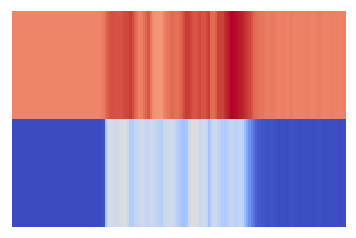

In [155]:
librosa.display.specshow(librosa.feature.mfcc(y, sr, n_mfcc=2))

ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
1000
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
ARGH
FILE ARGH - 1009_TAI_ANG_XX.wav
ARGH
ARGH
ARGH
ARGH
Wall time: 7min 21s


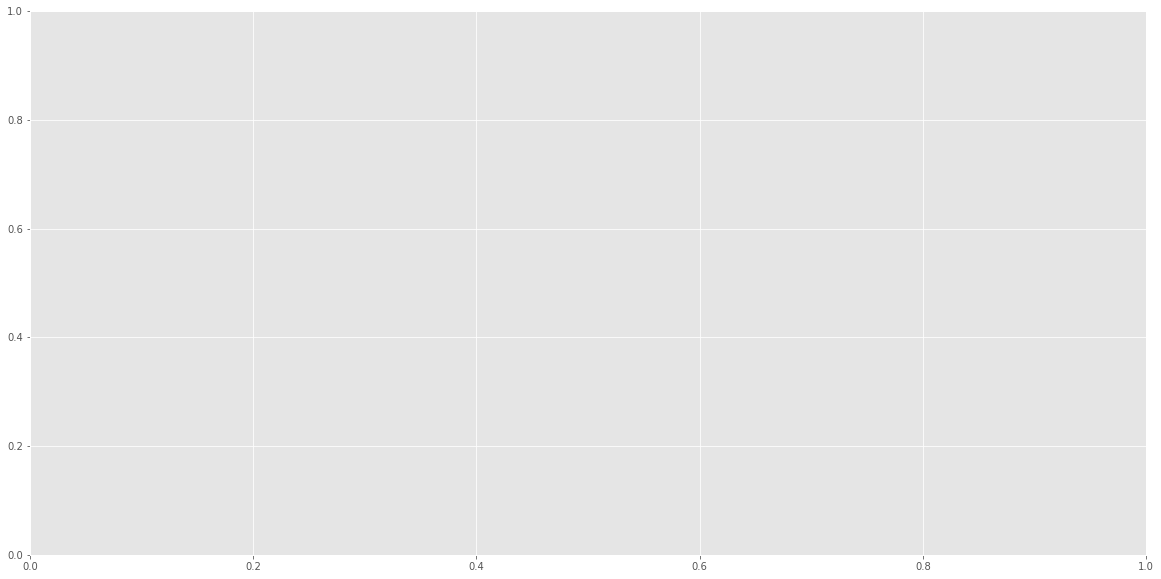

In [213]:
%%time
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)

lo_cut = 0.05
window_size = 10000
mfccs = []
ys = []
bad_filepaths = []

iterator = 0
for path in filenames:
    iterator += 1
    if iterator % 1000 == 0:
        print(iterator)
    
    fn = os.path.basename(path)
    try:
        y, sr = librosa.load(path)
    except:
        bad_filepaths.append(path)
        print("FILE ARGH - {}".format(fn))
        continue
    #print(sr)
    
    # Scale between -1 and 1
    yAbs = np.abs(y)
    
    yAbs = pd.Series(yAbs)
    # WE CHOP OFF THE SILENCE AT THE END AND THE START
    # This is achieved by establishing a baseline level for "silence" which is a actually relative
    
    yRoll = yAbs.rolling(window_size).mean().values[window_size:-window_size]
    yBaseline = yRoll[0]
    
    # Finds the first yRoll index that goes above the baseline
    try:
        sound_barrier_breaks = list(yRoll > yBaseline + 0.002)
        first_baseline_break = sound_barrier_breaks.index(True)
        sound_barrier_breaks.reverse()
        last_baseline_break = -sound_barrier_breaks.index(True)        
    except:
        bad_filepaths.append(path)
        print("ARGH")
        continue
        
    # The indices are offset because of the rolling window, this corrects for them
    true_first_index = first_baseline_break + int(window_size * 0.5) # We don't know where within the window the sound started
    true_final_index = last_baseline_break - int(window_size * 0.5) # We don't know where within the window the sound started

    
    #yRoll = yRoll[first_baseline_break:last_baseline_break]
    y = y[true_first_index:true_final_index]
    
    # Scale to -1, 1 min and max
    y_scale_factor = np.max(np.abs(y))
    y = y * (1/y_scale_factor)
    
    mfcc = librosa.feature.mfcc(y, sr=sr)
    mfccs.append(mfcc)
    ys.append(y)
    #ax.plot(y, alpha=0.2)


In [216]:
bad_filenames = [os.path.basename(x) for x in bad_filepaths]

In [220]:
pd.DataFrame([bad_filenames, bad_filepaths]).to_csv("bad_files.csv")

In [228]:
with open("mfccs.p", "wb") as fp:
    pickle.dump(mfccs, fp)

In [231]:
with open("ys.p", "wb") as fp:
    pickle.dump(ys, fp)

In [214]:
len(mfccs)

1729

### Reading Audio Files

The audios are [Pulse-code modulated](https://en.wikipedia.org/wiki/Audio_bit_depth) with a [bit depth](https://en.wikipedia.org/wiki/Audio_bit_depth) of 16 and a [sampling rate](https://en.wikipedia.org/wiki/Sampling_%28signal_processing%29) of 44.1 kHz

![16-bit PCM](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Pcm.svg/500px-Pcm.svg.png)

* **Bit-depth = 16**: The amplitude of each sample in the audio is one of 2^16 (=65536) possible values. 
* **Samplig rate = 44.1 kHz**: Each second in the audio consists of 44100 samples. So, if the duration of the audio file is 3.2 seconds, the audio will consist of 44100\*3.2 = 141120 values.

Let's listen to an audio file in our dataset and load it to a numpy array

## MFCC Transformations

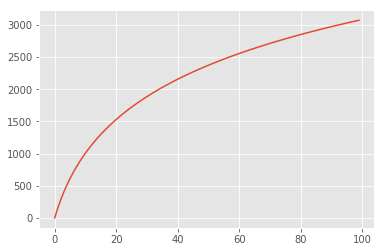

In [71]:
def mel(x):
    return 1127 * (np.log(1+(x/700)))

def melInverse(x):
    return 700 * ((np.e ** (x/1127)) - 1)

x = np.linspace(start=0,stop=10000, num=100)
y = [mel(a) for a in x]
plt.plot(y)

# Librosa bizz

In [6]:
# SR = sampling rate
#frame = short audio cliep == spectrogram column
# n_fft = samples per frame
# hop_length = num samples between frames

22050


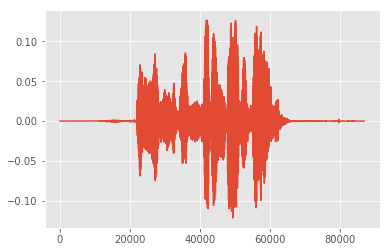

In [9]:
# Numpy array, sampling rate
y, sr = librosa.load(filenames[10])
print(sr)
plt.plot(y)

In [10]:
shortTimeFourierTransform = librosa.stft(y[200:300])
mfcc = librosa.feature.mfcc(y, sr=sr)

https://musicinformationretrieval.com/mfcc.html

In [11]:
shape = mfcc.shape

print("{} features over {} 'frames' (where a frame is an overlapping chunk of time)".format(shape[0], shape[1]))

20 features over 170 'frames' (where a frame is an overlapping chunk of time)


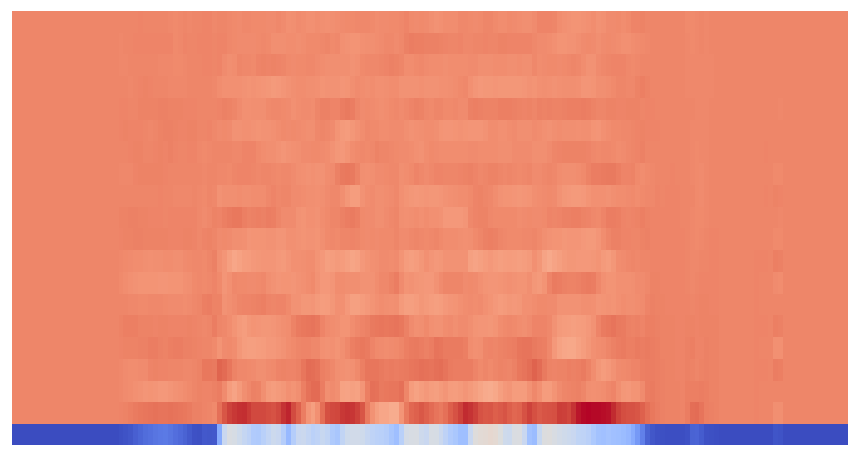

In [12]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(8)
librosa.display.specshow(mfcc)
librosa.display.specshow(mfcc)

In [13]:
# Scale the MFCCs ot unit mean and variance
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)

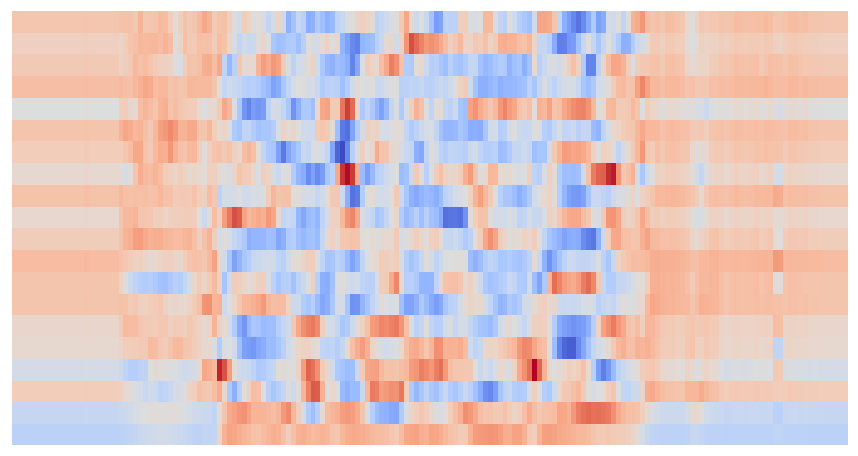

In [14]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(8)
librosa.display.specshow(mfcc)


C:\Users\chris\Anaconda3\envs\audio\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


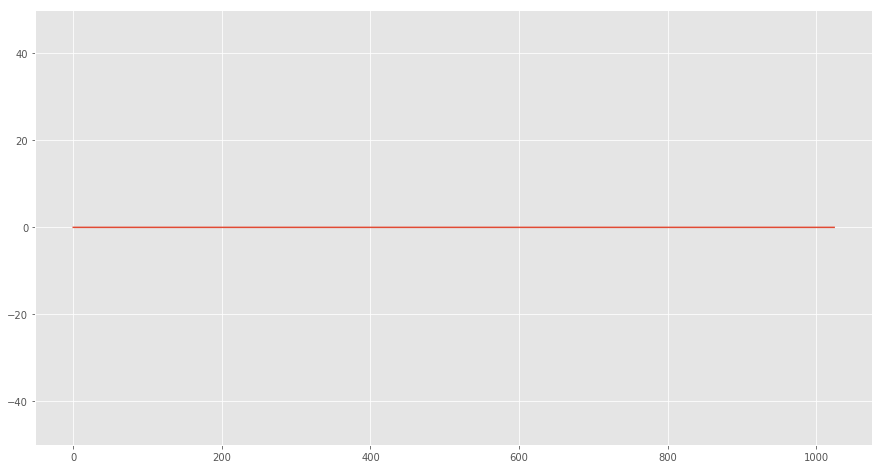

In [85]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(8)
ax.set_ylim([-50, 50])
ax.plot(shortTimeFourierTransform)

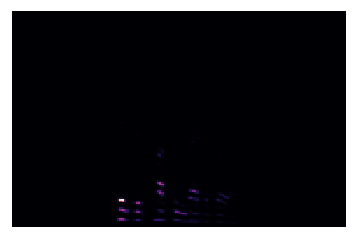

In [86]:
melspectrogram = librosa.feature.melspectrogram(y)
librosa.display.specshow(melspectrogram)

In [99]:
y, sr = librosa.load(sampleAudioFiles[50])

In [100]:
mfccass = librosa.feature.mfcc(y)

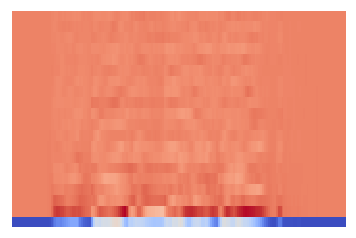

In [101]:
librosa.display.specshow(mfccass)

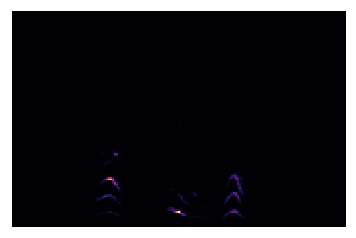

In [102]:
melspectrogram = librosa.feature.melspectrogram(y)
librosa.display.specshow(melspectrogram)

In [111]:
librosa.feature.melspectrogram(y)

array([[1.02978216e+02, 1.14474680e+02, 7.26462365e+01, ...,
        1.03840651e+02, 3.53573414e+02, 1.03370101e+03],
       [1.78534317e+02, 3.77467461e+02, 3.08798511e+02, ...,
        4.64592409e+02, 3.25459583e+02, 2.37369859e+02],
       [1.16672408e+02, 1.55782814e+02, 9.97496182e+02, ...,
        7.40739541e+02, 7.46794523e+02, 1.69696206e+02],
       ...,
       [5.98703173e-03, 1.49675297e-03, 5.40594840e-12, ...,
        4.14494436e-12, 1.55190317e-03, 6.16968651e-03],
       [5.86097716e-03, 1.46523979e-03, 4.05582458e-12, ...,
        6.48429364e-12, 1.52222115e-03, 6.05168417e-03],
       [5.78130367e-03, 1.44532145e-03, 1.05538923e-11, ...,
        1.22945254e-11, 1.50331810e-03, 5.97653651e-03]])

<a id="1d_model_building"></a>
## <center>2. Building a Model using Raw Wave</center>
We will build two models:
1. The first model will take the raw audio (1D array) as input and the primary operation will be Conv1D
2. The second model will take the MFCCs as input. (We will explain MFCC later)

<a id="1d_discription"></a>
### Keras Model using raw wave

Our model has the architecture as follows:
![raw](https://raw.githubusercontent.com/zaffnet/images/master/images/raw_model.jpg)

**Important:**
Due to the time limit on Kaggle Kernels, it is not possible to perform 10-fold training of a large model. I have trained the model locally and uploaded its output files as a dataset. If you wish to train the bigger model, change `COMPLETE_RUN = True` at the beginning of the kernel.

#### Some sssential imports

In [ ]:
import librosa
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical

<a id="configuration"></a>
#### Configuration

The Configuration object stores those learning parameters that are shared between data generators, models, and training functions. Anything that is `global` as far as the training is concerned can become the part of Configuration object.

In [ ]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

<a id="data_generator"></a>
#### DataGenerator Class

The DataGenerator class inherits from **`keras.utils.Sequence`** . It is useful for preprocessing and feeding the data to a Keras model. 
* Once initialized with a batch_size, it computes the number of batches in an epoch. The **`__len__`** method tells Keras how many batches to draw in each epoch. 
* The **`__getitem__`** method takes an index (which is the batch number) and returns a batch of the data (both X and y) after calculating the offset. During test time, only `X` is returned.
* If we want to perform some action after each epoch (like shuffle the data, or increase the proportion of augmented data), we can use the **`on_epoch_end`** method.

Note:
**`Sequence`** are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, config, data_dir, list_IDs, labels=None, 
                 batch_size=64, preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = self.config.dim

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.config.audio_length
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + ID
            
            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate,
                                        res_type='kaiser_fast')

            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
                
            # Normalization + Other Preprocessing
            if self.config.use_mfcc:
                data = librosa.feature.mfcc(data, sr=self.config.sampling_rate,
                                                   n_mfcc=self.config.n_mfcc)
                data = np.expand_dims(data, axis=-1)
            else:
                data = self.preprocessing_fn(data)[:, np.newaxis]
            X[i,] = data

        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X

<a id="1d_normalization"></a>
#### Normalization

Normalization is a crucial preprocessing step. The simplest method is rescaling the range of features to scale the range in [0, 1]. 

In [ ]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5

* The dummy model is just for debugging purpose.
* Our 1D Conv model is fairly deep and is trained using Adam Optimizer with a learning rate of 0.0001

In [ ]:
def get_1d_dummy_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = GlobalMaxPool1D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

def get_1d_conv_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = Convolution1D(16, 9, activation=relu, padding="valid")(inp)
    x = Convolution1D(16, 9, activation=relu, padding="valid")(x)
    x = MaxPool1D(16)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(rate=0.2)(x)

    x = Dense(64, activation=relu)(x)
    x = Dense(1028, activation=relu)(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

<a id="1d_training"></a>
#### Training 1D Conv

It is important to convert raw labels to integer indices

In [ ]:
LABELS = list(train.label.unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train.set_index("fname", inplace=True)
test.set_index("fname", inplace=True)
train["label_idx"] = train.label.apply(lambda x: label_idx[x])
if not COMPLETE_RUN:
    train = train[:2000]
    test = test[:2000]

In [ ]:
config = Config(sampling_rate=16000, audio_duration=2, n_folds=10, learning_rate=0.001)
if not COMPLETE_RUN:
    config = Config(sampling_rate=100, audio_duration=1, n_folds=2, max_epochs=1)

Here is the code for 10-fold training:
* We use **`from sklearn.cross_validation.StratifiedKFold`** for splitting the trainig data into 10 folds.
* We use some Keras callbacks to monitor the training.
    * **`ModelCheckpoint`** saves the best weight of our model (using validation data). We use this weight to make test predictions.
    * **`EarlyStopping`** stops the training once validation loss ceases to decrease
    * **`TensorBoard`** helps us visualize training and validation loss and accuracy.
* We fit the model using **`DataGenerator`** for training and validation splits. 
* We get both training and test predictions and save them as .npy format. We also generate a submission file. For 10-fold CV, the number of prediction files should be 10. We will ensemble these predictions later.

```python
PREDICTION_FOLDER = "predictions_1d_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

skf = StratifiedKFold(train.label_idx, n_folds=config.n_folds)

for i, (train_split, val_split) in enumerate(skf):
    train_set = train.iloc[train_split]
    val_set = train.iloc[val_split]
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%d'%i, write_graph=True)

    callbacks_list = [checkpoint, early, tb]
    print("Fold: ", i)
    print("#"*50)
    if COMPLETE_RUN:
        model = get_1d_conv_model(config)
    else:
        model = get_1d_dummy_model(config)

    train_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/', train_set.index, 
                                    train_set.label_idx, batch_size=64,
                                    preprocessing_fn=audio_norm)
    val_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/', val_set.index, 
                                  val_set.label_idx, batch_size=64,
                                  preprocessing_fn=audio_norm)
    
    history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator,
                                  epochs=config.max_epochs, use_multiprocessing=True, workers=6, max_queue_size=20)
    
    model.load_weights('best_%d.h5'%i)
    
    # Save train predictions
    train_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/', train.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(train_generator, use_multiprocessing=True, 
                                          workers=6, max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)
    
    # Save test predictions
    test_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_test/', test.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(test_generator, use_multiprocessing=True, 
                                          workers=6, max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)
    
    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)
    ```

<a id="1d_ensembling"></a>
#### Ensembling 1D Conv Predictions
Now that we have trained our model, it is time average the predictions of 10-folds. We will try Geometric Mean averaging and see what will be our Public LB score.

In [ ]:
pred_list = []
for i in range(10):
    pred_list.append(np.load("../input/freesound-prediction-file/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("1d_conv_ensembled_submission.csv", index=False)

<a id="intro_mfcc"></a>
## <center> 3. Introuction to MFCC

As we have seen in the previous section, our Deep Learning models are powerful enough to classify sounds from the raw audio. We do not require any complex feature engineering. But before the Deep Learning era, people developed techniques to extract features from audio signals. It turns out that these techniques are still useful. One such technique is computing the MFCC (Mel Frquency Cepstral Coefficients) from the raw audio. Before we jump to MFCC, let's talk about extracting features from the sound.

If we just want to classify some sound, we should build features that are **speaker independent**. Any feature that only gives information about the speaker (like the pitch of their voice) will not be helpful for classification. In other words, we should extract features that depend on the "content" of the audio rather than the nature of the speaker. Also, a good feature extraction technique should mimic the human speech perception. We don't hear loudness on a linear scale. If we want to double the perceived loudness of a sound, we have to put 8 times as much energy into it. Instead of a linear scale, our perception system uses a log scale. 

Taking these things into account, Davis and Mermelstein came up with MFCC in the 1980's. MFCC mimics the logarithmic perception of loudness and pitch of human auditory system and tries to eliminate speaker dependent characteristics by excluding the fundamental frequency and their harmonics. The underlying mathematics is quite complicated and we will skip that. For those interested, here is the [detailed explanation](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

![http://recognize-speech.com/images/FeatureExtraction/MFCC/MFCC_Flowchart.png](http://recognize-speech.com/images/FeatureExtraction/MFCC/MFCC_Flowchart.png)

<a id="librosa_mfcc"></a>
#### Generating MFCC using Librosa
The library librosa has a function to calculate MFCC. Let's compute the MFCC of an audio file and visualize it.

In [ ]:
import librosa
SAMPLE_RATE = 44100
fname = '../input/freesound-audio-tagging/audio_train/' + '00044347.wav'   # Hi-hat
wav, _ = librosa.core.load(fname, sr=SAMPLE_RATE)
wav = wav[:2*44100]

In [ ]:
mfcc = librosa.feature.mfcc(wav, sr = SAMPLE_RATE, n_mfcc=40)
mfcc.shape

In [ ]:
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

<a id="2d_model_building"></a>
## <center>4. Building a Model using MFCC

We will build now build a 2D Convolutional model using MFCC. 

In [ ]:
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras import backend as K

In [ ]:
def get_2d_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model


def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

<a id="2d_data"></a>
### Preparing data

In [ ]:
config = Config(sampling_rate=44100, audio_duration=2, n_folds=10, 
                learning_rate=0.001, use_mfcc=True, n_mfcc=40)
if not COMPLETE_RUN:
    config = Config(sampling_rate=44100, audio_duration=2, n_folds=2, 
                    max_epochs=1, use_mfcc=True, n_mfcc=40)

In [ ]:
def prepare_data(df, config, data_dir):
    X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1))
    input_length = config.audio_length
    for i, fname in enumerate(df.index):
        print(fname)
        file_path = data_dir + fname
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

```python
X_train = prepare_data(train, config, '../input/freesound-audio-tagging/audio_train/')
X_test = prepare_data(test, config, '../input/freesound-audio-tagging/audio_test/')
y_train = to_categorical(train.label_idx, num_classes=config.n_classes)
```

<a id="2d_normalization"></a>
#### Normalization


```python
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
```

<a id="2d_training"></a>
#### Training 2D Conv on MFCC

```python
PREDICTION_FOLDER = "predictions_2d_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

skf = StratifiedKFold(train.label_idx, n_folds=config.n_folds)
for i, (train_split, val_split) in enumerate(skf):
    K.clear_session()
    X, y, X_val, y_val = X_train[train_split], y_train[train_split], X_train[val_split], y_train[val_split]
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%i'%i, write_graph=True)
    callbacks_list = [checkpoint, early, tb]
    print("#"*50)
    print("Fold: ", i)
    model = get_2d_conv_model(config)
    history = model.fit(X, y, validation_data=(X_val, y_val), callbacks=callbacks_list, 
                        batch_size=64, epochs=config.max_epochs)
    model.load_weights('best_%d.h5'%i)

    # Save train predictions
    predictions = model.predict(X_train, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)

    # Save test predictions
    predictions = model.predict(X_test, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)
```

<a id="2d_ensembling"></a>
#### Ensembling 2D Conv Predictions

In [ ]:
pred_list = []
for i in range(10):
    pred_list.append(np.load("../input/freesound-prediction-data-2d-conv-reduced-lr/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("2d_conv_ensembled_submission.csv", index=False)

<a id="1d_2d_ensembling"></a>
## <center>5. Ensembling 1D Conv and 2D Conv Predictions</center>

In [ ]:
pred_list = []
for i in range(10):
    pred_list.append(np.load("../input/freesound-prediction-data-2d-conv-reduced-lr/test_predictions_%d.npy"%i))
for i in range(10):
    pred_list.append(np.load("../input/freesound-prediction-file/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("1d_2d_ensembled_submission.csv", index=False)

<a id="conclusion"></a>
## <center>Results and Conclusion</center>

So far, we have trained two models. Let's analyze their relative complexity and strength.



| Model        | Number of Trainable parameters           | Public LB score  |
| ------------- |:-------------:| -----:|
| 1D Conv on Raw wave      | 360,513 | 0.809 |
| 2D Conv on MFCC (verified labels only)    | 168,361  |   0.785 |
| 2D Conv on MFCC     | 168,361  |   0.844 |
| 1D Conv + 2D Conv Ensemble     | N/A  |   0.895 |

**As we can see, 2D Convolution on MFCC performs better than 1D Convolution on Raw waves.**

In [ ]:
def build_2D_model(n_rows, n_cols, n_classes):
    model = Sequential()
    model.add(Convolution2D(128, (3, 3),
                            padding='same',
                            input_shape=(n_rows, n_cols, 1),
                            activation="relu"))
    model.add(MaxPooling2D(padding="same", pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Convolution2D(32, (3, 3),
                            padding="same",
                            activation="relu"))
    model.add(MaxPooling2D(padding="same"))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.1))    
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(n_classes, activation="softmax"))
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['acc'])
    return model